In this study, I benefit from 

https://www.kaggle.com/new-york-city/nyc-property-sales

https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf and 

https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

# Initialization

In [1]:
#HOME = "C:\\Users\\paslanpatir\\Documents\\GitHub\\Soostone\\"
HOME = "C:\\Users\\pelin.yurdadon\\Desktop\\Soostone\\"
setwd(HOME)

## Packages

In [2]:
options(scipen=999)
options(warnings = -1)

library(data.table)
library(tidyverse)

library(ggplot2)
library(gridExtra)
library(corrplot)
library(treemapify)

library(lubridate)
library(stringr); library(stringi)

library(skimr)
library(zoo)

library(Hmisc)

library(mice) ## imputation
library(VIM)

library(e1071) # svm
library(glmnet) # lasso
library(xgboost) #xgboost
#library(caret) # for general ml applications

library(cluster)    # clustering algorithms
library(factoextra) # clustering algorithms & visualization

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x purrr::flatten()   masks jsonlite::flatten()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


corrplot 0.91 loaded


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,


## Functions

### Operational functions

In [3]:
# define a function to make plain the characters
to.plain <- function(s) {
  
  s= str_trim(str_to_lower(s, locale = "en"), side = c("both"))
  s = gsub("\\s","",s)
   
  chars = "[\\/\\(\\)\\-\\+\\&\\*]"
  
  s= str_replace_all(s, chars, "")
  return(s)
}

In [4]:
# change from "-" to NA 
make_null = function(s,selected_char){
    return(ifelse(s == "" | str_detect(s,selected_char),NA,s))
}

make_null_0 = function(s){
    return(ifelse(s == 0,NA,s))
}

In [5]:
fill_missing = function(x,method = ""){
    if(method == "mean"){
        y = mean(x,na.rm = TRUE)
        x[is.na(x)] = y
        return(x)
    }else if(method == "freq"){ # freq
        y= x[!is.na(x)]
        y = names(which.max(table(y)))
        x[is.na(x)] = y
        return(x)
    }else {
        return(x)
    }
}

In [6]:
## encode some columns
encode_numeric <- function(x, order = unique(x)) {
  x <- as.numeric(factor(x, levels = order, exclude = NULL))
  return(x)
}

encode_grouping = function(x,Q = 10,P  = NA,name_for_other = "other"){
    x_dt = data.table(t(t(table(x))))
    if(is.na(P)){
      x_dt = x_dt[order(-N)][1:(Q-1)]
  
      survivors = x_dt$x
      
    }else{
        sm = summary(x_dt$N)
        survivors = x_dt[N > sm[[P + 1]]]$x
    }
  x[!x %in% survivors] = name_for_other
  return(x)  
}

In [7]:
get_scale_params = function(data, feature_columns){
  x = data[,.SD,.SDcols = feature_columns]
  x_scaled = scale(x,center= TRUE,scale = TRUE)
  x = as.matrix(x_scaled) 
  
  Scale_Parameters = data.table("features" = attr(x_scaled,"dimnames")[[2]],
                                "means" = attr(x_scaled,"scaled:center"),
                                "sd"    = attr(x_scaled,"scaled:scale"))
  
  return(Scale_Parameters)
}


scale_external = function(dt,ScaleParams){
  for(i in ScaleParams$features){
    mean = ScaleParams[features == i]$means
    sd   = ScaleParams[features == i]$sd
    sd = ifelse(sd == 0,0.000001,sd)
    
    dt[, temp:= .SD, .SDcols = i]
    dt[, temp:= (temp - mean)/ sd]
    
    dt[,(i) := temp]
    dt[, temp := NULL]
  }
  return(dt)
}

### Calculation functions

In [8]:
calc_rmse= function(x,y){ return(sqrt(mean((x-y)^2)))}

In [9]:
normalize_between_01 = function(x){
max = max(x)
min = min(x)

x = (x - min)/(max-min)
return(x)
}

### Graph functions

In [10]:
## boxplots of different features wrt a specific column 
draw_boxplot = function(dt,id_col = NULL, selected_cols){
    dt_molten = dt[,.SD,.SDcols = c(id_col,selected_cols)] %>% melt.data.table(id.vars = id_col)

    ggplot(data = dt_molten,aes_string(x = quo_name(id_col),fill = quo_name(id_col)))+ 
    geom_boxplot(aes(y = value)) +
    facet_wrap(~ variable, scales = "free") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))
}

In [11]:
draw_barplot = function(dt,selected_cols,group_number,bin_number = NA,ncol){
    options(scipen=999)
    
    num_cols = dt[,.SD,.SDcols = selected_cols] %>% purrr::keep(is.numeric) %>% colnames()
    num_data = dt[,.SD,.SDcols = num_cols]
    if(is.na(bin_number)){
    num_data[, (num_cols):=  lapply(.SD, Hmisc::cut2, g = group_number),.SDcols = num_cols ]
        }else{
    num_data[, (num_cols):=  lapply(.SD, cut, breaks = bin_number,dig.lab=10),.SDcols = num_cols ]
        }
       
    new_data = cbind(dt[,.SD,.SDcols = c(setdiff(selected_cols,num_cols))],num_data)
    new_data_molten = new_data %>% tidyr::gather() 
    
    
    ggplot(data = new_data_molten,aes(x = value, fill = key))+ 
      facet_wrap(~ key, scales = "free",ncol = ncol) + 
      geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))
}

In [12]:
draw_corplot = function(data){
    data %>% cor() %>%
    corrplot::corrplot.mixed(upper = "ellipse",
                         lower = "number",
                         tl.pos = "lt",
                         number.cex = .5,
                         lower.col = "black",
                         tl.cex = 0.7)
}

### Outlier functions

In [13]:
tend_outliers_del = function(dt,focus_col, sigma = 3){

    temp = dt[[focus_col]]
    m  = mean(temp)
    sd = sd(temp)
    
    lb = m - sigma*sd
    ub = m + sigma*sd
    
    temp = temp[temp < ub]
    temp = temp[temp > lb]
    
    m  = mean(temp)
    sd = sd(temp)
    lb = m - sigma*sd
    ub = m + sigma*sd
    
    dt = dt[dt[[focus_col]]<ub]
    dt = dt[dt[[focus_col]]>lb]
  return(dt)
}

In [14]:
tend_outliers_keep = function(x, sigma = 3){
  if(is.numeric(x) || is.integer(x)){
    temp = copy(x) 
    m  = mean(temp)
    sd = sd(temp)
    
    lb = m - sigma*sd
    ub = m + sigma*sd
    
    temp = temp[temp < ub]
    temp = temp[temp > lb]
    
    m  = mean(temp)
    sd = sd(temp)
    lb = m - sigma*sd
    ub = m + sigma*sd
    
    temp = copy(x)
    temp[temp > ub] = ub 
    temp[temp < lb] = lb
    return(temp)
  }
  return(x)
}

In [15]:
tend_outliers_keep_IQR = function(x, IQR = 2){
  if(is.numeric(x) || is.integer(x)){
    temp = copy(x) 
    q = quantile(temp)
    third = q[[4]]
    max_limit= third*IQR

    temp[temp> max_limit] = max_limit
    
    return(temp)
  }
  return(x)
}

### Model functions

In [16]:
model_xgboost= function(feature_list,target,chunk_no = 10){
    dt_model = copy(dt[,.SD,.SDcols = c("idx",target,feature_list)])
    
    chunk_no = 10
set.seed(0)
folds <- cut(seq(1,nrow(dt_model)),breaks=chunk_no,labels=FALSE)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

for(i in 1:chunk_no){
  #Segment your data by fold using the which() function 

  testIndexes <- which(folds==i,arr.ind=TRUE)
  testData    <- dt_model[testIndexes, ]
  trainData   <- dt_model[-testIndexes, ]
  
   y_train        = trainData[[target]]
   y_test         = testData[[target]]
    
    Scale_Parameters = get_scale_params(trainData, feature_list)
    x_train = scale(trainData[,.SD,.SDcols = feature_list])
    
    x_test = testData[,.SD,.SDcols = feature_list]
    scale_external(x_test,Scale_Parameters)
    
  d_train= xgb.DMatrix(data = as.matrix(x_train), label = y_train)
  d_test = xgb.DMatrix(data = as.matrix(x_test), label = y_test)
  
  set.seed(i)
  xg.model = xgb.train( data = d_train, 
                        nrounds = 20,
                        early_stopping_rounds = 3,
                        params = params, 
                        watchlist = list(train = d_train, test = d_test))
  
  if(str_detect(target,"log") == TRUE){
      xg.pred  = exp(predict(xg.model, d_test))
      actual = exp(y_test)
      
      xg.fitted = exp(predict(xg.model, d_train))
  }else{
      xg.pred  = predict(xg.model, d_test)
      actual = y_test
      
      xg.fitted = exp(predict(xg.model, d_train))
  }
    
   imp = data.table(xgb.importance( feature_names = colnames(x_train), model = xg.model))
   imp_table = rbind(imp_table,data.table(chunk = i, imp))  
    
    
  #Check performance
  sub_pred_table = testData[,.(idx, actual = actual, pred = xg.pred, chunk = i)]
  sub_fitted_table = trainData[,.(idx, fitted = xg.fitted, chunk = i )]
  
  pred_table = rbind(pred_table,sub_pred_table )
  fitted_table = rbind(fitted_table,sub_fitted_table )
 
}   

imp_table_2= dcast(imp_table, Feature ~ chunk, value.var = "Gain")
imp_table_2 = imp_table_2[order(-`5`)]
    
    return(list(pred_table,imp_table_2))
}

In [17]:
model_xgboost_partial= function(feature_list,target,chunk_no = 5){
    borough_list = unique(dt$borough)
    b_class_list = unique(dt$b_class_group)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

for(b in borough_list){
    for(c in b_class_list){
         dt_model_sub = copy(dt[ borough == b & b_class_group == c
                                     ,.SD
                                     ,.SDcols = c("idx","borough","b_class_group",target,feature_list)])
        chunk_no = 5
        set.seed(0)
        folds <- cut(seq(1,nrow(dt_model_sub)),breaks=chunk_no,labels=FALSE)
        
    # some columns might include NA values for some group of data
        incomplete_cols = colnames(dt_model_sub)[colSums(is.na(dt_model_sub)) !=0]
        feature_list= setdiff(feature_list, incomplete_cols)
        dt_model_sub = dt_model_sub[,(incomplete_cols):= NULL]
        rm(incomplete_cols)
        
        
        for(i in 1:chunk_no){
            testIndexes <- which(folds==i,arr.ind=TRUE)
            testData    <- dt_model_sub[testIndexes, ]
            trainData   <- dt_model_sub[-testIndexes, ]

            y_train        = trainData[[target]]
            y_test         = testData[[target]]
    
            Scale_Parameters = get_scale_params(trainData, feature_list)
            x_train = scale(trainData[,.SD,.SDcols = feature_list])
            
            x_test = testData[,.SD,.SDcols = feature_list]
            scale_external(x_test,Scale_Parameters)
    
            d_train= xgb.DMatrix(data = as.matrix(x_train), label = y_train)
            d_test = xgb.DMatrix(data = as.matrix(x_test), label = y_test)
  
            set.seed(i)
            xg.model = xgb.train( data = d_train, 
                                  nrounds = 20,
                                  early_stopping_rounds = 3,
                                  params = params, 
                                  watchlist = list(train = d_train, test = d_test))
            
            if(str_detect(target,"log") == TRUE){
                xg.pred  = exp(predict(xg.model, d_test))
                actual = exp(y_test)
                
                xg.fitted = exp(predict(xg.model, d_train))
            }else{
                xg.pred  = predict(xg.model, d_test)
                actual = y_test
                
                xg.fitted = exp(predict(xg.model, d_train))
            }
    
            imp = data.table(xgb.importance( feature_names = colnames(x_train), model = xg.model))
            imp_table = rbind(imp_table,data.table(borough = b, b_class_group = c,chunk = i, imp))  
    
    
             #Check performance
             sub_pred_table = testData[,.(idx, actual = actual, pred = xg.pred, chunk = i,borough = b, b_class_group = c)]
             sub_fitted_table = trainData[,.(idx, fitted = xg.fitted, chunk = i ,borough = b, b_class_group = c)]
             
             pred_table = rbind(pred_table,sub_pred_table )
             fitted_table = rbind(fitted_table,sub_fitted_table )
        }
    }
}
    
    imp_table_2 = imp_table[, .(avg_gain = mean(Gain)),.(borough,b_class_group,Feature)]
    
return(list(pred_table,imp_table_2))    
}

In [18]:
model_xgboost_partial_wo = function(feature_list,train_target,test_target,chunk_no = 5){
borough_list = unique(dt$borough)
b_class_list = unique(dt$b_class_group)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

for(b in borough_list){
    for(c in b_class_list){
        feature_list_used = copy(feature_list) 
        dt_model_sub = copy(dt[ borough == b & b_class_group == c
                                     ,.SD
                                     ,.SDcols = c("idx","borough","b_class_group",train_target,test_target,feature_list_used)])
        chunk_no = 5
        set.seed(0)
        folds <- cut(seq(1,nrow(dt_model_sub)),breaks=chunk_no,labels=FALSE)
        

        incomplete_cols = colnames(dt_model_sub)[colSums(is.na(dt_model_sub)) !=0]
        feature_list_used= setdiff(feature_list_used, incomplete_cols)
        dt_model_sub = dt_model_sub[,(incomplete_cols):= NULL]
        rm(incomplete_cols)
        
        
        for(i in 1:chunk_no){
            testIndexes <- which(folds==i,arr.ind=TRUE)
            testData    <- dt_model_sub[testIndexes, ]
            trainData   <- dt_model_sub[-testIndexes, ]

            y_train        = trainData[[train_target]]
            y_test         = testData[[test_target]]
    
            Scale_Parameters = get_scale_params(trainData, feature_list_used)
            x_train = scale(trainData[,.SD,.SDcols = feature_list_used])
            
            x_test = testData[,.SD,.SDcols = feature_list_used]
            scale_external(x_test,Scale_Parameters)
    
            d_train= xgb.DMatrix(data = as.matrix(x_train), label = y_train)
            d_test = xgb.DMatrix(data = as.matrix(x_test), label = y_test)
  
            set.seed(i)
            xg.model = xgb.train( data = d_train, 
                                  nrounds = 20,
                                  early_stopping_rounds = 3,
                                  params = params, 
                                  watchlist = list(train = d_train, test = d_test))
            
            if(str_detect(train_target,"log") == TRUE){
                xg.pred  = exp(predict(xg.model, d_test))
                actual = exp(y_test)
                
                xg.fitted = exp(predict(xg.model, d_train))
            }else{
                xg.pred  = predict(xg.model, d_test)
                actual = y_test
                
                xg.fitted = exp(predict(xg.model, d_train))
            }
    
            imp = data.table(xgb.importance( feature_names = colnames(x_train), model = xg.model))
            imp_table = rbind(imp_table,data.table(borough = b, b_class_group = c,chunk = i, imp))  
    
    
             #Check performance
             sub_pred_table = testData[,.(idx, actual = actual, pred = xg.pred, chunk = i,borough = b, b_class_group = c)]
             sub_fitted_table = trainData[,.(idx, fitted = xg.fitted, chunk = i ,borough = b, b_class_group = c)]
             
             pred_table = rbind(pred_table,sub_pred_table )
             fitted_table = rbind(fitted_table,sub_fitted_table )
        }
    }
}
    imp_table_2 = imp_table[, .(avg_gain = mean(Gain)),.(borough,b_class_group,Feature)]
    return(list(pred_table,imp_table_2))   
    }

# Initial Look-Up

Perform exploratory analysis on this dataset and produce a showcase/storyline of a few
interesting patterns and your observations. You will walk us through your findings during
our interview. 

In [19]:
dt = fread("nyc-rolling-sales.csv")

In [20]:
colnames(dt)
t(head(dt))

[1] "V1"                             "BOROUGH"                       
 [3] "NEIGHBORHOOD"                   "BUILDING CLASS CATEGORY"       
 [5] "TAX CLASS AT PRESENT"           "BLOCK"                         
 [7] "LOT"                            "EASE-MENT"                     
 [9] "BUILDING CLASS AT PRESENT"      "ADDRESS"                       
[11] "APARTMENT NUMBER"               "ZIP CODE"                      
[13] "RESIDENTIAL UNITS"              "COMMERCIAL UNITS"              
[15] "TOTAL UNITS"                    "LAND SQUARE FEET"              
[17] "GROSS SQUARE FEET"              "YEAR BUILT"                    
[19] "TAX CLASS AT TIME OF SALE"      "BUILDING CLASS AT TIME OF SALE"
[21] "SALE PRICE"                     "SALE DATE"

[,1]                          
V1                             4                             
BOROUGH                        1                             
NEIGHBORHOOD                   ALPHABET CITY                 
BUILDING CLASS CATEGORY        07 RENTALS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2A                            
BLOCK                          392                           
LOT                             6                            
EASE-MENT                      NA                            
BUILDING CLASS AT PRESENT      C2                            
ADDRESS                        153 AVENUE B                  
APARTMENT NUMBER                                             
ZIP CODE                       10009                         
RESIDENTIAL UNITS               5                            
COMMERCIAL UNITS               0                             
TOTAL UNITS                     5                            
LAND SQUARE FEET               1633                          
GROSS SQUARE FEET              6440                          
YEAR BUILT                     1900                          
TAX CLASS AT TIME OF SALE      2                             
BUILDING CLASS AT TIME OF SALE C2                            
SALE PRICE                     6625000                       
SALE DATE                      2017-07-19                    
                               [,2]                          
V1                             5                             
BOROUGH                        1                             
NEIGHBORHOOD                   ALPHABET CITY                 
BUILDING CLASS CATEGORY        07 RENTALS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2                             
BLOCK                          399                           
LOT                            26                            
EASE-MENT                      NA                            
BUILDING CLASS AT PRESENT      C7                            
ADDRESS                        234 EAST 4TH   STREET         
APARTMENT NUMBER                                             
ZIP CODE                       10009                         
RESIDENTIAL UNITS              28                            
COMMERCIAL UNITS               3                             
TOTAL UNITS                    31                            
LAND SQUARE FEET               4616                          
GROSS SQUARE FEET              18690                         
YEAR BUILT                     1900                          
TAX CLASS AT TIME OF SALE      2                             
BUILDING CLASS AT TIME OF SALE C7                            
SALE PRICE                     -                             
SALE DATE                      2016-12-14                    
                               [,3]                          
V1                             6                             
BOROUGH                        1                             
NEIGHBORHOOD                   ALPHABET CITY                 
BUILDING CLASS CATEGORY        07 RENTALS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2                             
BLOCK                          399                           
LOT                            39                            
EASE-MENT                      NA                            
BUILDING CLASS AT PRESENT      C7                            
ADDRESS                        197 EAST 3RD   STREET         
APARTMENT NUMBER                                             
ZIP CODE                       10009                         
RESIDENTIAL UNITS              16                            
COMMERCIAL UNITS               1                             
TOTAL UNITS                    17                            
LAND SQUARE FEET               2212                          
GROSS SQUARE FEET              7803                          
YEAR BUILT                     1900                          
T

So, columns are like:

* Location colunmns : Borought, neighborhood, block, lot, address, apartment number, zipcode

* Building columns: 

    * context : residential units, commercial units and total units
    * coverage: land square feet and gross square feet
    * construction: yearbuilt
    
* Then_and_Now columns: 
    * building class at present, building class at the sale, building class category
    * tax class at present, tas lass at the sale
    
* Sale Price and Sale Date

In [21]:
#skim(dt)

Dates covered: between 2016-09-01 and 2017-08-31 (12 months) 

In [22]:
#dt %>% keep(is.character) %>% lapply(unique)

**Unique Key**  

In [23]:
# https://www.kaggle.com/new-york-city/nyc-property-sales --> 'Datasets' says that:
# The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL
dt[,bbl := paste(BOROUGH,BLOCK,LOT,sep="-")]

In [24]:
dt[,.N,.(bbl)][ N > 1][order(-N)]%>% head()
t(dt[bbl == '1-373-40'])
t(dt[bbl == '1-1006-1302'])

bbl         N  
1 4-8489-1    166
2 1-94-1       79
3 1-1009-37    69
4 4-2086-50    56
5 4-6698-40    53
6 1-1006-1302  46

[,1]                        
V1                             16                          
BOROUGH                        1                           
NEIGHBORHOOD                   ALPHABET CITY               
BUILDING CLASS CATEGORY        09 COOPS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2                           
BLOCK                          373                         
LOT                            40                          
EASE-MENT                      NA                          
BUILDING CLASS AT PRESENT      C6                          
ADDRESS                        327 EAST 3 STREET, 1C       
APARTMENT NUMBER                                           
ZIP CODE                       10009                       
RESIDENTIAL UNITS              0                           
COMMERCIAL UNITS               0                           
TOTAL UNITS                    0                           
LAND SQUARE FEET               -                           
GROSS SQUARE FEET              -                           
YEAR BUILT                     1920                        
TAX CLASS AT TIME OF SALE      2                           
BUILDING CLASS AT TIME OF SALE C6                          
SALE PRICE                     1                           
SALE DATE                      2016-09-06                  
bbl                            1-373-40                    
                               [,2]                        
V1                             17                          
BOROUGH                        1                           
NEIGHBORHOOD                   ALPHABET CITY               
BUILDING CLASS CATEGORY        09 COOPS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2                           
BLOCK                          373                         
LOT                            40                          
EASE-MENT                      NA                          
BUILDING CLASS AT PRESENT      C6                          
ADDRESS                        327 EAST 3 STREET, 1C       
APARTMENT NUMBER                                           
ZIP CODE                       10009                       
RESIDENTIAL UNITS              0                           
COMMERCIAL UNITS               0                           
TOTAL UNITS                    0                           
LAND SQUARE FEET               -                           
GROSS SQUARE FEET              -                           
YEAR BUILT                     1920                        
TAX CLASS AT TIME OF SALE      2                           
BUILDING CLASS AT TIME OF SALE C6                          
SALE PRICE                     499000                      
SALE DATE                      2017-03-10                  
bbl                            1-373-40                    
                               [,3]                        
V1                             18                          
BOROUGH                        1                           
NEIGHBORHOOD                   ALPHABET CITY               
BUILDING CLASS CATEGORY        09 COOPS - WALKUP APARTMENTS
TAX CLASS AT PRESENT           2                           
BLOCK                          373                         
LOT                            40                          
EASE-MENT                      NA                          
BUILDING CLASS AT PRESENT      C6                          
ADDRESS                        327 EAST 3 STREET, 3A       
APARTMENT NUMBER                                           
ZIP CODE                       10009                       
RESIDENTIAL UNITS              0                           
COMMERCIAL UNITS               0                           
TOTAL UNITS                    0                           
LAND SQUARE FEET               -                           
GROSS SQUARE FEET              -                           
YEAR BUILT                     1920                        
TAX CLASS A

[,1]                     
V1                             9718                     
BOROUGH                        1                        
NEIGHBORHOOD                   MIDTOWN WEST             
BUILDING CLASS CATEGORY        45 CONDO HOTELS          
TAX CLASS AT PRESENT           4                        
BLOCK                          1006                     
LOT                            1302                     
EASE-MENT                      NA                       
BUILDING CLASS AT PRESENT      RH                       
ADDRESS                        1335 AVENUE OF THE AMERIC
APARTMENT NUMBER               TIMES                    
ZIP CODE                       10019                    
RESIDENTIAL UNITS              0                        
COMMERCIAL UNITS               0                        
TOTAL UNITS                    1                        
LAND SQUARE FEET               -                        
GROSS SQUARE FEET              -                        
YEAR BUILT                     1963                     
TAX CLASS AT TIME OF SALE      4                        
BUILDING CLASS AT TIME OF SALE RH                       
SALE PRICE                     -                        
SALE DATE                      2017-07-07               
bbl                            1-1006-1302              
                               [,2]                    [,3]           
V1                             9719                    9720           
BOROUGH                        1                       1              
NEIGHBORHOOD                   MIDTOWN WEST            MIDTOWN WEST   
BUILDING CLASS CATEGORY        45 CONDO HOTELS         45 CONDO HOTELS
TAX CLASS AT PRESENT           4                       4              
BLOCK                          1006                    1006           
LOT                            1302                    1302           
EASE-MENT                      NA                      NA             
BUILDING CLASS AT PRESENT      RH                      RH             
ADDRESS                        1335 AVENUE OF THE AMER 1335 6TH AVENUE
APARTMENT NUMBER               TIMES                   TIMES          
ZIP CODE                       10019                   10019          
RESIDENTIAL UNITS              0                       0              
COMMERCIAL UNITS               0                       0              
TOTAL UNITS                    1                       1              
LAND SQUARE FEET               -                       -              
GROSS SQUARE FEET              -                       -              
YEAR BUILT                     1963                    1963           
TAX CLASS AT TIME OF SALE      4                       4              
BUILDING CLASS AT TIME OF SALE RH                      RH             
SALE PRICE                     10000                   -              
SALE DATE                      2017-03-21              2017-03-16     
bbl                            1-1006-1302             1-1006-1302    
                               [,4]                     
V1                             9721                     
BOROUGH                        1                        
NEIGHBORHOOD                   MIDTOWN WEST             
BUILDING CLASS CATEGORY        45 CONDO HOTELS          
TAX CLASS AT PRESENT           4                        
BLOCK                          1006                     
LOT                            1302                     
EASE-MENT                      NA                       
BUILDING CLASS AT PRESENT      RH                       
ADDRESS                        1335 AVENUE OF THE AMERIC
APARTMENT NUMBER               TIMES                    
ZIP CODE                       10019                    
RESIDENTIAL UNITS              0                        
COMMERCIAL UNITS               0                        
TOTAL UNITS                    1                        
LAND SQUARE FEET               -               

It seems that Borough-Block-Lot is not a key in this data sets ( not unique for eacch record). This is ok, since this is a transaction data and a unit can be sold many times. For instance, bbl = '1-373-40' at V1 = 16 and V=17. Their address is the same.

On the other hand, there can be other units in the same bbl. For instance, bbl = '1-373-40' at V1 = 17, V1 = 18 and V1 = 19. All are different apartments.

To understand whether two units are the same or different in a bbl, we can befeit from address column if it is complete.

However, V1 and Borough provides a unique key in the data set.

In [25]:
dt[,.N,.(V1,BOROUGH)][ N > 1]

V1 BOROUGH N

* There are 22 columns and 84548 rows. 

* 10 columns are numeric and another 10 are character columns. However, their true type might be different, such as Sale price.

* Rows are unique based on V1 and Borough, together. (V1 is not such an id column)

* Some of the columns have missing values which represented as "-" or " ".  ( Sale Price, Apartment Number). Therefore, missing values should be analyzed further.

* "EASE-MENT" column is completely blank.

* BOROUGH has only 5 distinct values.  Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

So, I'll proceed with transforming column types to analyze data further

## Transforming the columns

In [26]:
# get rid of complete-Null column
dt[,`EASE-MENT` := NULL]

# change colnames for easy coding
cols = to.plain(colnames(dt))
colnames(dt) = cols

## make null -,_, or 0 for square feet columns
cols = setdiff(colnames(dt),"saledate")
dt[,(cols):= lapply(.SD, make_null, selected_char="-"), .SDcols = cols]
dt[,(cols):= lapply(.SD, make_null, selected_char="_"), .SDcols = cols]

sq_ft_cols = c("landsquarefeet","grosssquarefeet")
dt[,(sq_ft_cols):= lapply(.SD, make_null_0), .SDcols = sq_ft_cols]

# make character columns plain
character_cols = dt %>% keep(is.character) %>% colnames()
dt[,(character_cols):= lapply(.SD, to.plain), .SDcols = character_cols]

#  make numeric the columns below
numeric_cols = c("saleprice","grosssquarefeet","landsquarefeet")
dt[,(numeric_cols):= lapply(.SD, as.numeric), .SDcols = numeric_cols]

# define an id column 
dt[,idx := .GRP, .(v1,borough)]

 #dt[,easement := NULL]
dt[,bbl := paste(borough,block,lot,sep="-")]

In [27]:
colnames(dt)

[1] "v1"                        "borough"                  
 [3] "neighborhood"              "buildingclasscategory"    
 [5] "taxclassatpresent"         "block"                    
 [7] "lot"                       "buildingclassatpresent"   
 [9] "address"                   "apartmentnumber"          
[11] "zipcode"                   "residentialunits"         
[13] "commercialunits"           "totalunits"               
[15] "landsquarefeet"            "grosssquarefeet"          
[17] "yearbuilt"                 "taxclassattimeofsale"     
[19] "buildingclassattimeofsale" "saleprice"                
[21] "saledate"                  "bbl"                      
[23] "idx"

In [28]:
dt[,b_class_cat := as.numeric(substr(buildingclasscategory,1,2))]

dt[,b_class_present := substr(buildingclassatpresent,1,1)]
dt[,b_class_past := substr(buildingclassattimeofsale,1,1)]
#dt[,b_style := substr(buildingclassattimeofsale,2,2)]


# by using the info on https://www1.nyc.gov/site/finance/taxes/property-determining-your-assessed-value.page
dt[,taxclass_present := as.numeric(substr(taxclassatpresent,1,1))]
dt[,taxclass_present_level := ifelse(nchar(taxclassatpresent) < 2,NA,substr(taxclassatpresent,2,2))]

dt[,taxclass_past := as.numeric(substr(taxclassattimeofsale,1,1))] # includes ony integer
#dt[,taxclass_past_level := ifelse(nchar(taxclassattimeofsale) < 2,NA,substr(taxclassattimeofsale,2,2))] ALL NA

In [29]:
t(head(dt))

[,1]         [,2]             [,3]            
v1                        4            5                6               
borough                   1            1                1               
neighborhood              alphabetcity alphabetcity     alphabetcity    
buildingclasscategory     NA           NA               NA              
taxclassatpresent         2a           2                2               
block                     392          399              399             
lot                        6           26               39              
buildingclassatpresent    c2           c7               c7              
address                   153avenueb   234east4thstreet 197east3rdstreet
apartmentnumber           NA           NA               NA              
zipcode                   10009        10009            10009           
residentialunits           5           28               16              
commercialunits           0            3                1               
totalunits                 5           31               17              
landsquarefeet            1633         4616             2212            
grosssquarefeet            6440        18690             7803           
yearbuilt                 1900         1900             1900            
taxclassattimeofsale      2            2                2               
buildingclassattimeofsale c2           c7               c7              
saleprice                 6625000      NA               NA              
saledate                  2017-07-19   2016-12-14       2016-12-09      
bbl                       1-392-6      1-399-26         1-399-39        
idx                       1            2                3               
b_class_cat               NA           NA               NA              
b_class_present           c            c                c               
b_class_past              c            c                c               
taxclass_present          2            2                2               
taxclass_present_level    a            NA               NA              
taxclass_past             2            2                2               
                          [,4]             [,5]              [,6]             
v1                        7                8                 9                
borough                   1                1                 1                
neighborhood              alphabetcity     alphabetcity      alphabetcity     
buildingclasscategory     NA               NA                NA               
taxclassatpresent         2b               2a                2                
block                     402              404               405              
lot                       21               55                16               
buildingclassatpresent    c4               c2                c4               
address                   154east7thstreet 301east10thstreet 516east12thstreet
apartmentnumber           NA               NA                NA               
zipcode                   10009            10009             10009            
residentialunits          10                6                20               
commercialunits           0                0                 0                
totalunits                10                6                20               
landsquarefeet            2272             2369              2581             
grosssquarefeet            6794             4615              9730            
yearbuilt                 1913             1900              1900             
taxclassattimeofsale      2                2                 2                
buildingclassattimeofsale c4               c2                c4               
saleprice                 3936272          8000000           NA               
saledate                  2016-09-23       2016-11-17        2017-07-20       
bbl                       1-402-21         1-404-55          1-405-16         
idx                

In [30]:
skim(dt)

-- Data Summary ------------------------
                           Values
Name                       dt    
Number of rows             84548 
Number of columns          29    
Key                        NULL  
_______________________          
Column type frequency:           
  character                11    
  numeric                  17    
  POSIXct                  1     
________________________         
Group variables            None  

-- Variable type: character ----------------------------------------------------
# A tibble: 11 x 8
   skim_variable             n_missing complete_rate   min   max empty n_unique
 * <chr>                         <int>         <dbl> <int> <int> <int>    <int>
 1 neighborhood                  19371        0.771      4    23     0      209
 2 buildingclasscategory         36244        0.571     10    36     0       33
 3 taxclassatpresent               738        0.991      1     2     0       10
 4 buildingclassatpresent          738        0.99

Now, we can talk about data better.

* borough has 5 values and it is distributed normally

* there are 0 zipcodes, which is weird.

* better to check if residentialunits + commercialunits =? totaluntit

* there are 0 feet area features(!)

* data has records with yearbuilt 0

*  taxclassatpresent and taxclassattimeofsale should have been the same type. 
    
    * taxclassatpresent: with a letter
    * taxclassattimeofsale : only numeric

## Preliminary Analysis

Since there are saleprice = 0 or NA values and  I want to eliminate them, I'll try to understand the structure of the buildings first. So, I'll play with data without any focus on saleprice.

### Correlations

#### Unit Relationships

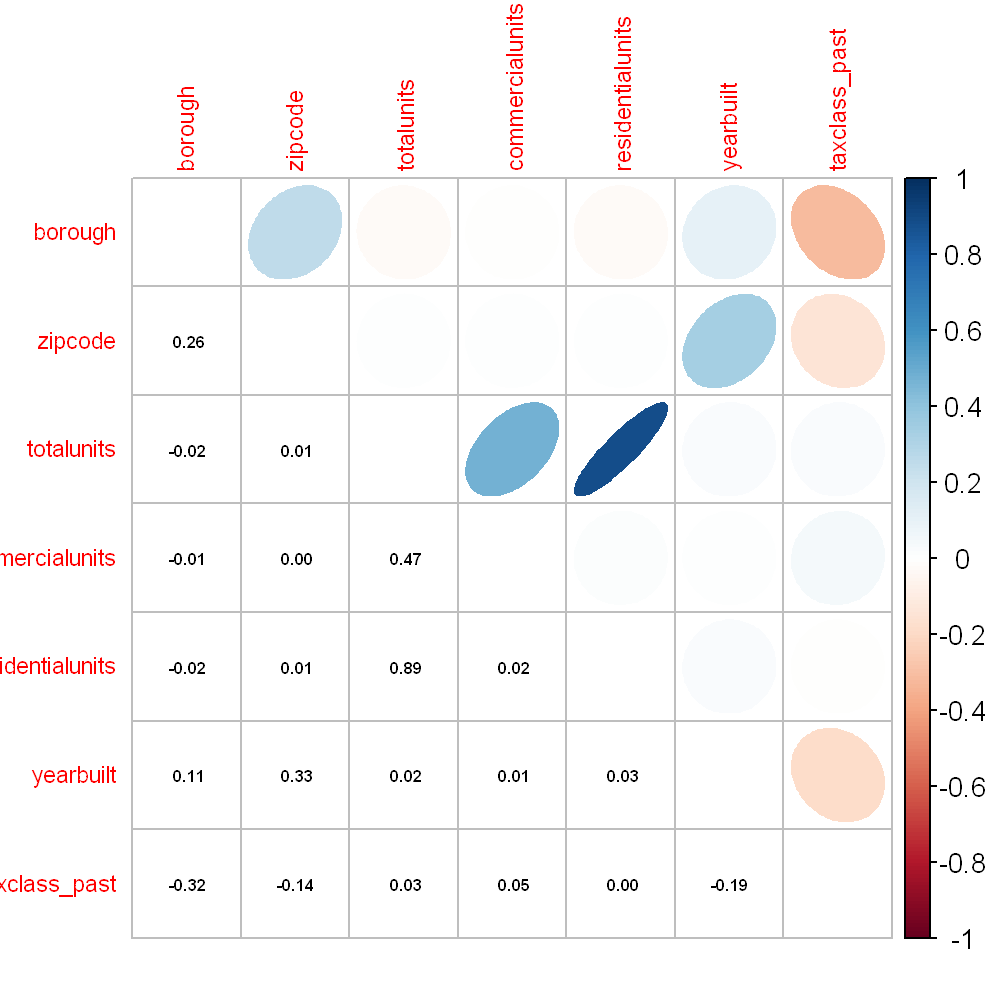

In [31]:
selected_cols = c("borough","zipcode","totalunits","commercialunits","residentialunits","yearbuilt","taxclass_past") 

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
draw_corplot(dt[,.SD,.SDcols = selected_cols])

Warning message:
"Removed 24783 rows containing non-finite values (stat_density)."
Warning message:
"Removed 79429 rows containing non-finite values (stat_density)."


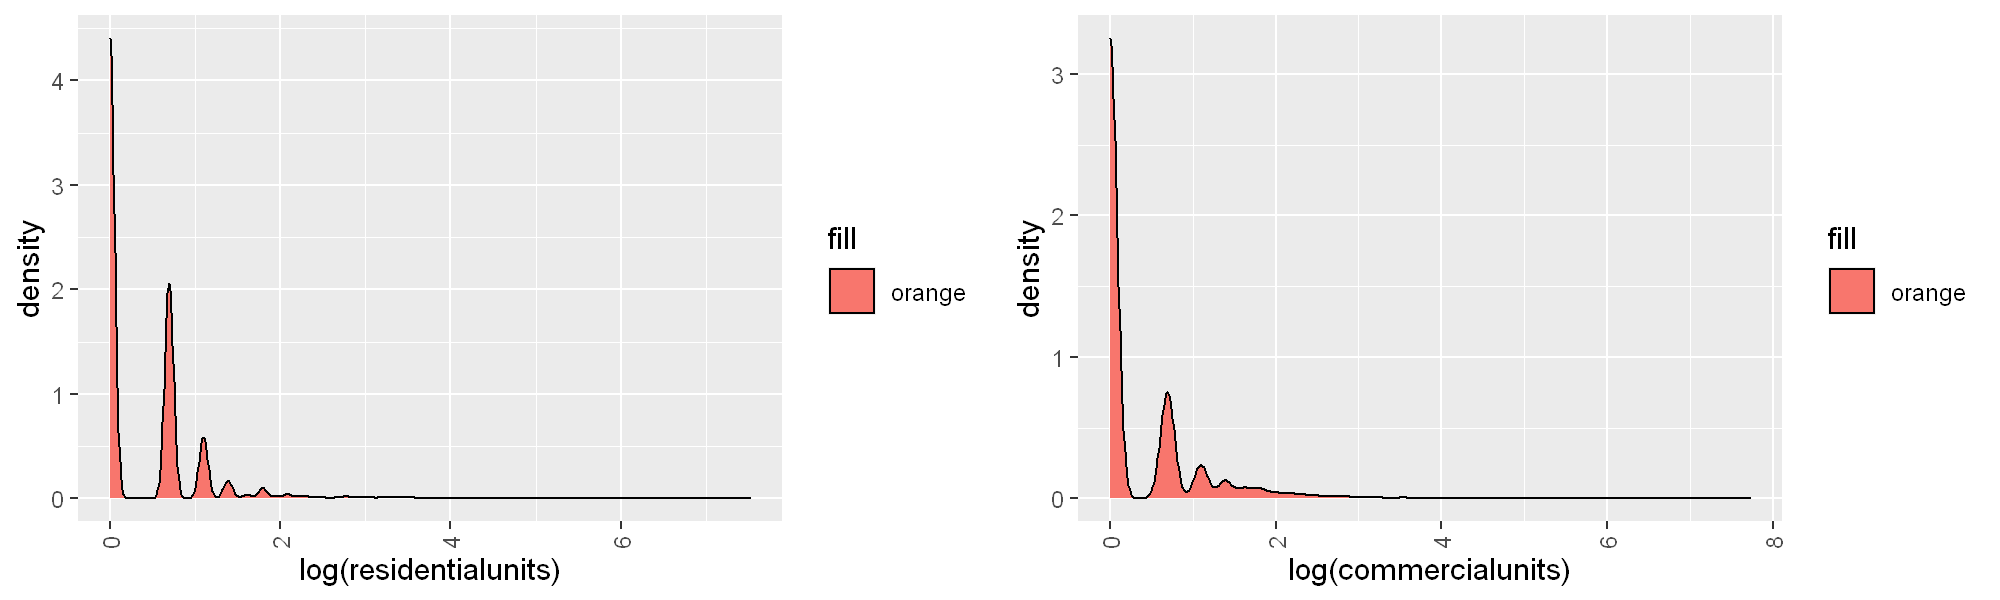

In [32]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
r1 = ggplot(data = dt,aes(x = log(residentialunits), fill = "orange"))+ 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))
c1= ggplot(data = dt,aes(x = log(commercialunits), fill = "orange"))+ 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

grid.arrange(r1,c1,ncol = 2)

#### Tax Class Relationships

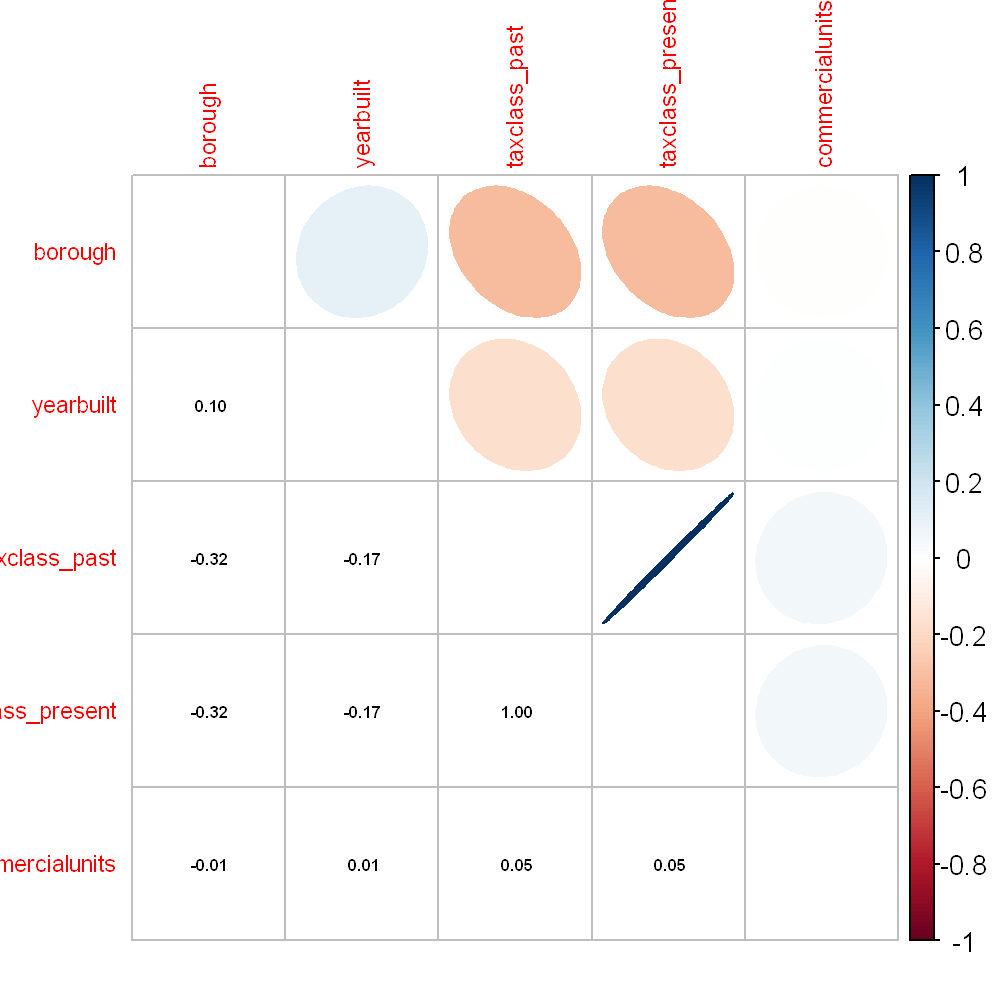

In [33]:
selected_cols = c("borough","yearbuilt","taxclass_past","taxclass_present","commercialunits") 
dt_c = copy(dt[,.SD,.SDcols = selected_cols]) 
dt_c = dt_c[complete.cases(dt_c)] # 738 records are deleted due to taxclass_present

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
draw_corplot(dt_c)


In [34]:
nrow(dt[taxclass_present != taxclass_past])
# only 46 records

[1] 46

We can consider either taxclass_present or taxclass_past as they are strongly correlated.

There is no correlation between commercial units & tax class.

negative correlation between taxclass and borough means that manhattan , for instance (borough = 1) includes mostly tax class 4 buildings.

#### Square Feet Columns

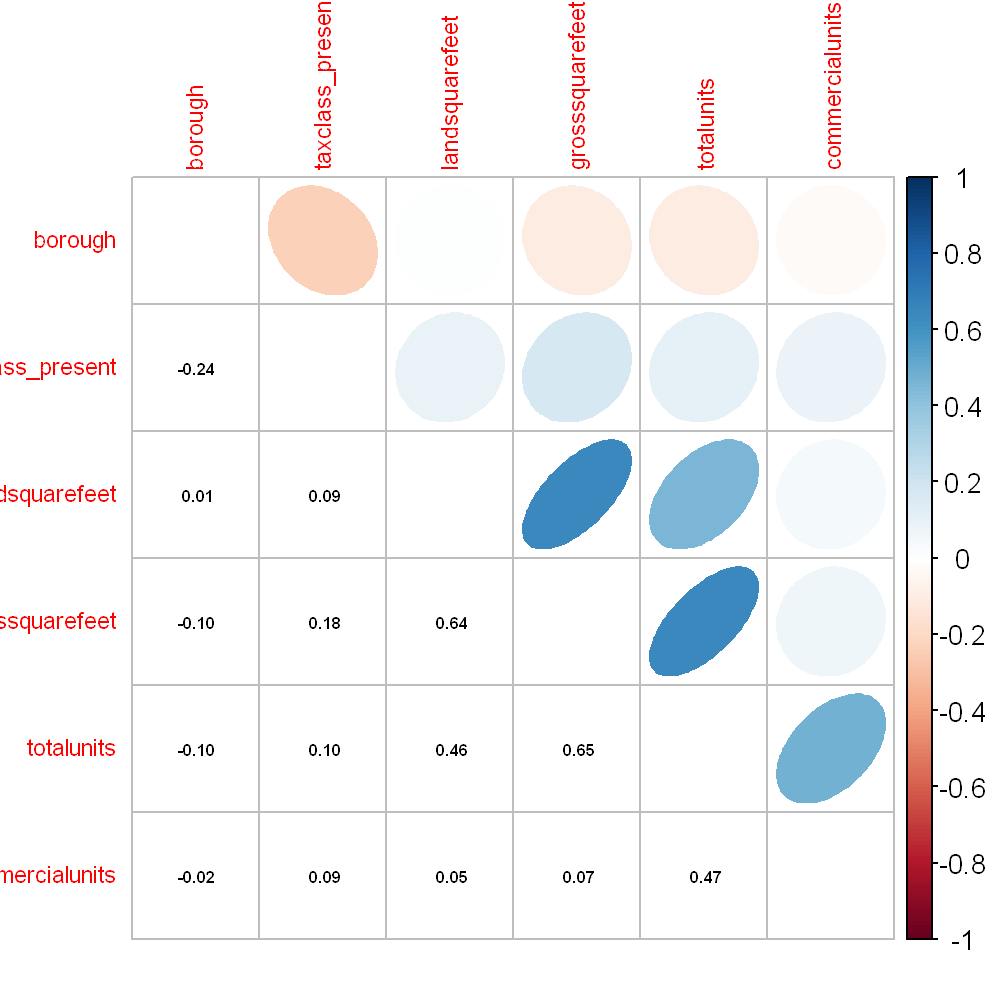

In [35]:
selected_cols = c("borough","taxclass_present",'landsquarefeet','grosssquarefeet','totalunits',"commercialunits") 
dt_c = copy(dt[,.SD,.SDcols = selected_cols]) 
dt_c = dt_c[complete.cases(dt_c)] # 27970 records are deleted

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
draw_corplot(dt_c) 

#### All Data _ Correlation

Let's see what happens if there were no missing info in the data set.

In [36]:
#remove columns with NA values over 60% 
s = skim(dt)
dt_complete = data.table(variable = s$skim_variable,complete_rate = s$complete_rate)
selected_cols = dt_complete[complete_rate > 0.6]$variable

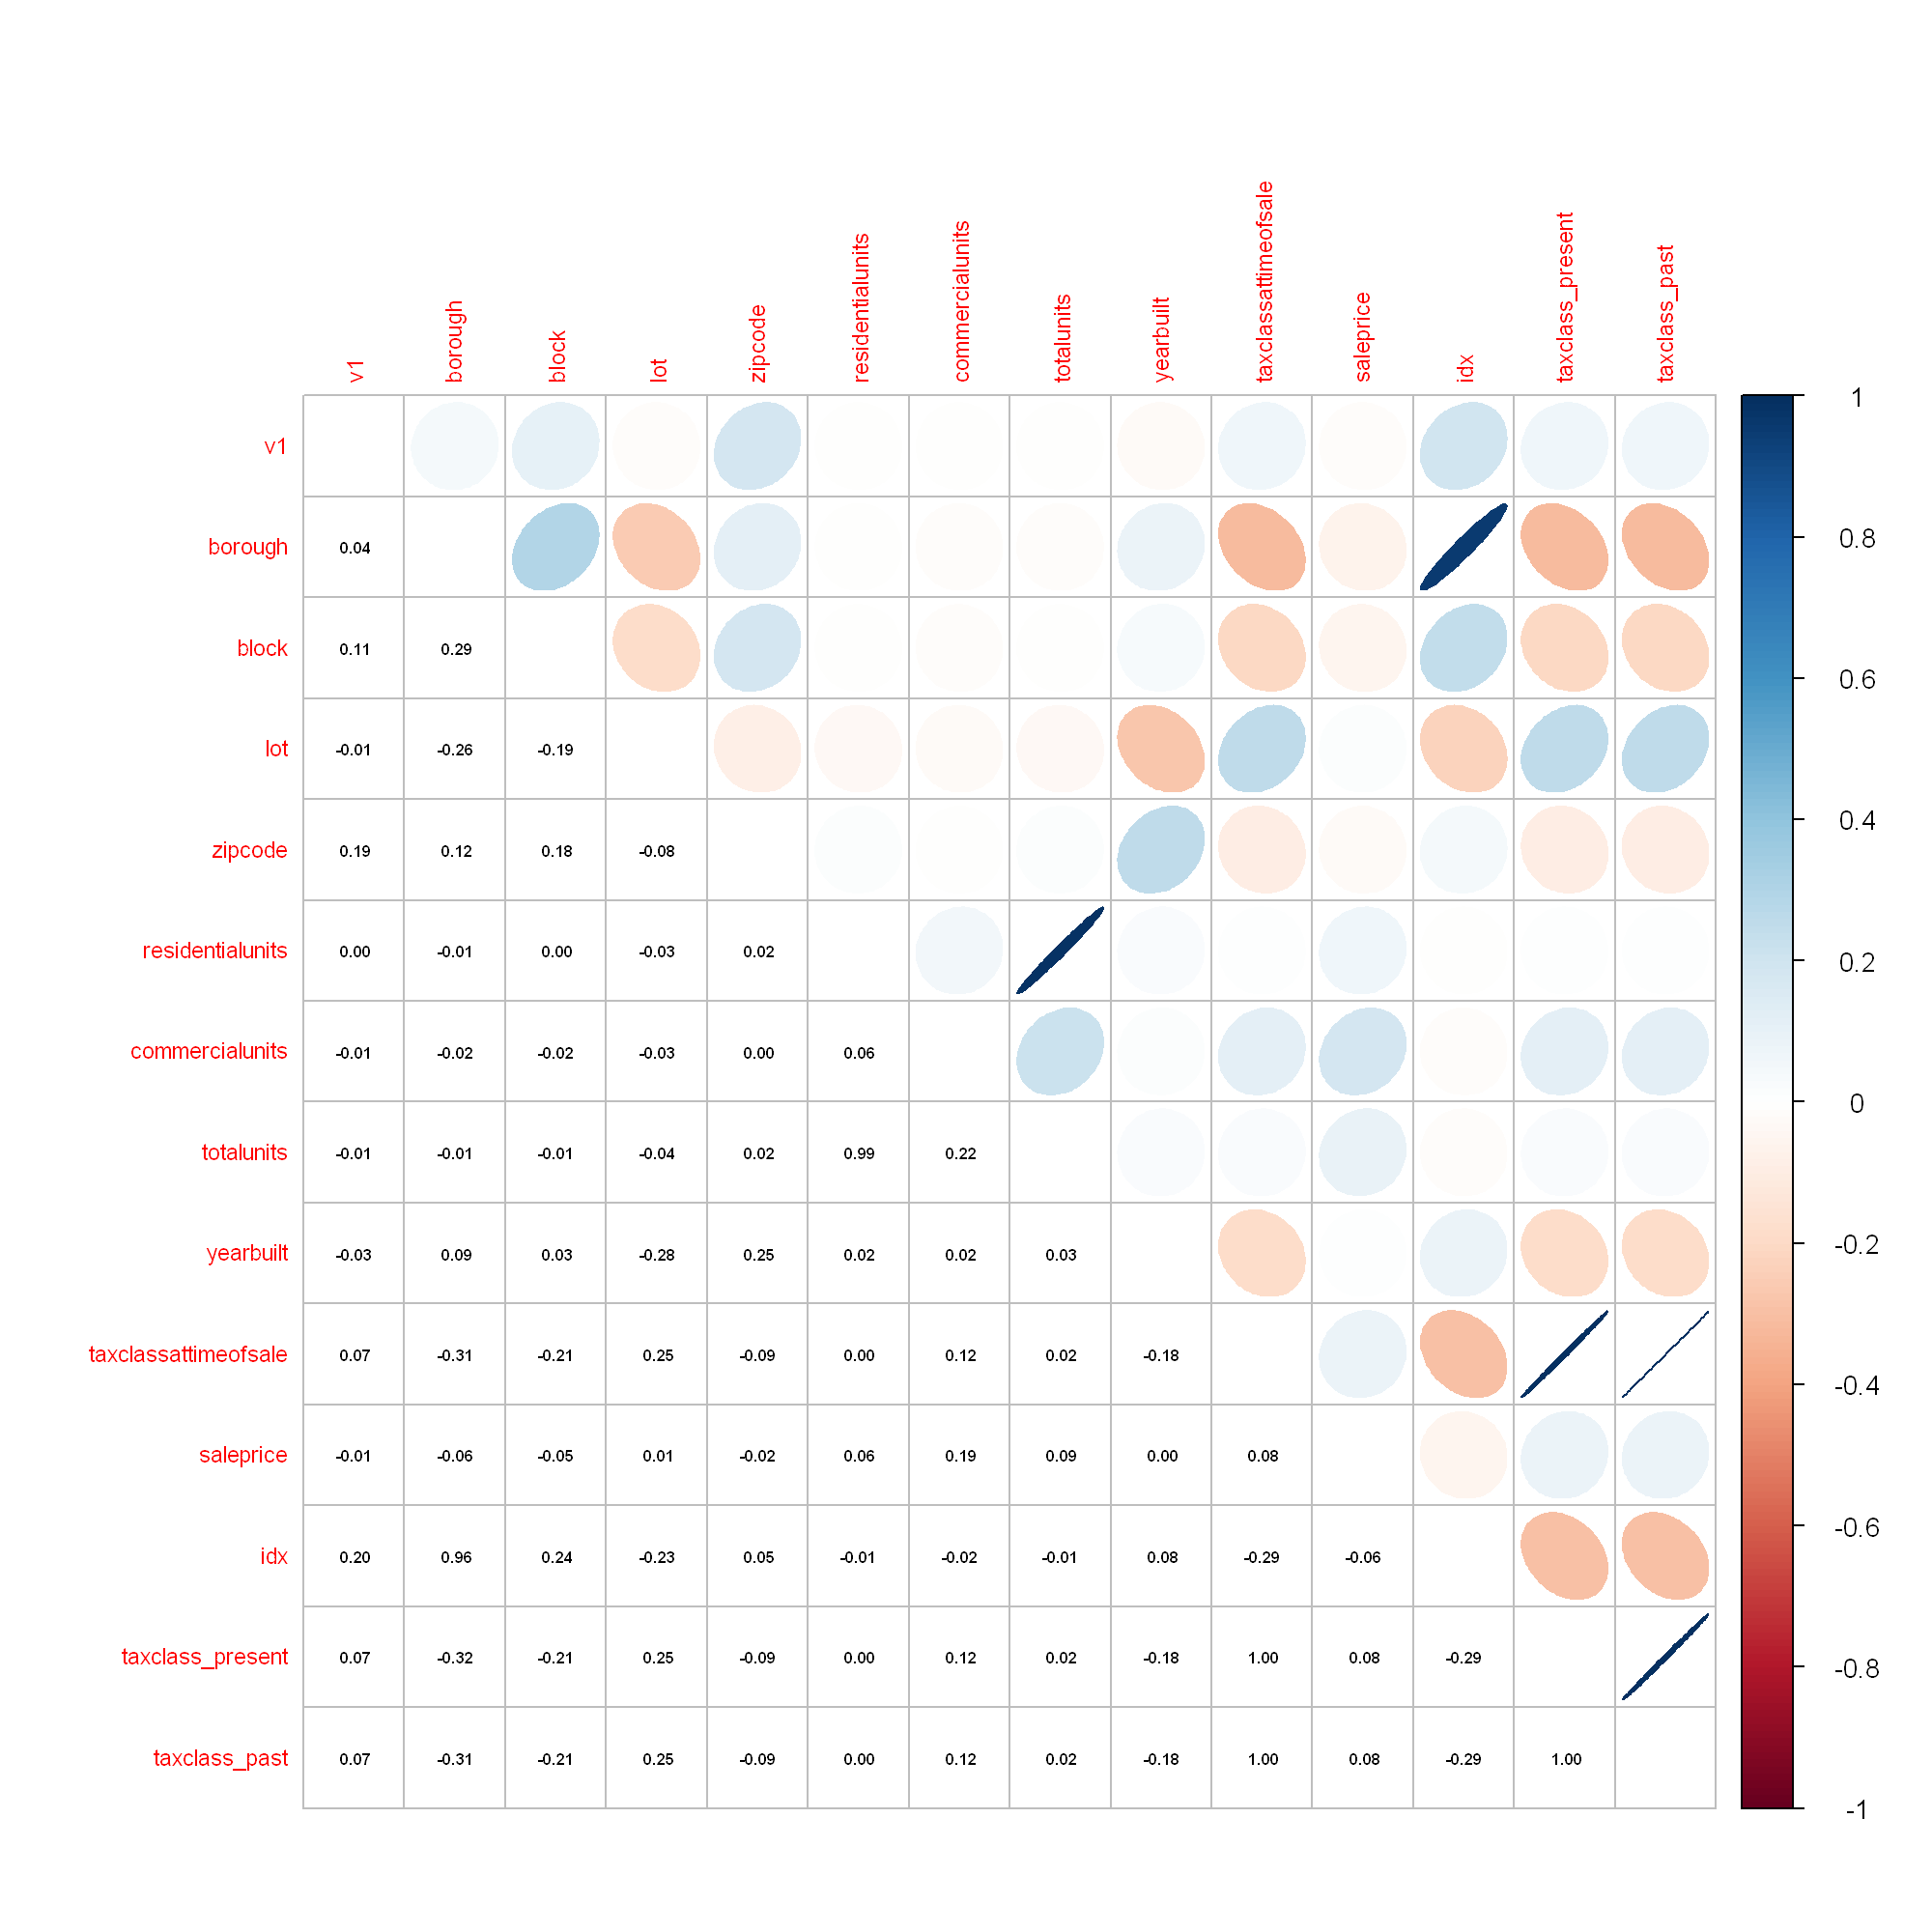

In [37]:
dt_c = copy(dt[,.SD,.SDcols = selected_cols])
dt_c = copy(dt_c[complete.cases(dt_c)]) # 53330 records are deleted 63% is deleted

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
numeric_cols = dt_c %>% keep(is.numeric) %>% colnames()
draw_corplot(dt_c[,.SD,.SDcols = numeric_cols])

## Let's meet the data

### Clean the data

Now, we'll focus on saleprice. Some records are transaction between family members. Therefore, the saleprice for such transactions are 0 or very small. 

Since such records cannot be used to understand the value of a construction/building, I eliminate na, 0 values and very small values.

In [38]:
table(dt[saleprice < 5000]$saleprice)


    0     1     2     3     5     8    10    19    20   100   200   210   250 
10228   134     3     2     1     1   766     1     4    90     1     1     1 
  300   315   373   500   501   600   750  1000  1110  1162  1175  1200  1275 
    1     1     1    67     1     1     1    77     1     1     1     1     1 
 1500  2000  2096  2200  2352  2400  2500  2510  2800  3000  3001  3012  3500 
    1    14     1     1     1     1     5     1     1     9     1     1     4 
 3750  3774  4000  4063  4500  4900 
    1     1     7     1     1     1 

In [39]:
pre = nrow(dt)
dt= dt[!is.na(saleprice)]
dt= dt[saleprice != 0]
dt= dt[saleprice >200]
now = nrow(dt)

In [40]:
# percentage eliminated
100*(pre-now)/pre

[1] 30.50575

**yearbuilt**

In [41]:
min_yearbuilt = min(dt[yearbuilt>1111]$yearbuilt)
dt[yearbuilt <=1111, yearbuilt := min_yearbuilt]

In [42]:
table(dt$yearbuilt)


1800 1832 1835 1844 1845 1846 1847 1849 1850 1851 1852 1854 1855 1856 1864 1865 
4228    1    2    2    4    2    1    1    5    2    2    3    1    2    2    2 
1870 1871 1875 1880 1881 1882 1883 1889 1890 1891 1892 1893 1894 1895 1896 1898 
  12    1    3   21    4    2    1    2   45    1    4    2    4   23    4    3 
1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 
1151  832 1154   23   47   16  467   57   40   65   62 2360   85   93  124   88 
1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 
 781   87   56   34   12 4035  107  124  203  249 2877  408  386  526  396 3347 
1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 
1358  191   61   22 1090   82  208  142  306 1663  176   98    6   31  834   52 
1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 
 100  193  329 2143  520  618  330  297 1378  409  392  380  359 1804  627  707 
1963 1964 1965 1966 1967 19

**building class**

In [43]:
# Lets see if building class changes frequently
dt[, b_class_ischanged := ifelse(b_class_present != b_class_past,1,0)]
table(dt$b_class_ischanged)
# appearently, no, then lets eliminate one of the column


    0     1 
58103    60 

In [44]:
dt = dt[b_class_ischanged == 0]
dt[,c("b_class_ischanged","b_class_past") := NULL]

In [45]:
skim(dt)

-- Data Summary ------------------------
                           Values
Name                       dt    
Number of rows             58103 
Number of columns          28    
Key                        NULL  
_______________________          
Column type frequency:           
  character                10    
  numeric                  17    
  POSIXct                  1     
________________________         
Group variables            None  

-- Variable type: character ----------------------------------------------------
# A tibble: 10 x 8
   skim_variable             n_missing complete_rate   min   max empty n_unique
 * <chr>                         <int>         <dbl> <int> <int> <int>    <int>
 1 neighborhood                  13934        0.760      4    23     0      208
 2 buildingclasscategory         27945        0.519     10    36     0       33
 3 taxclassatpresent                 0        1          1     2     0        9
 4 buildingclassatpresent            0        1   

Also, we know that  taxclass_present and taxclass_past are highly correlated. taxclass_present has about 500 NA records. I believe these are demolished buildings. So, I decided to eliminate taxclass_past completely and only na values of taxclass_present

In [46]:
dt[,c("taxclass_present_level","taxclass_past") := NULL]
dt = dt[!is.na(taxclass_present)] #593 records are eliminated
nrow(dt)

[1] 58103

### Missing Values

v1                   borough              neighborhood 
                        0                         0                     13934 
    buildingclasscategory         taxclassatpresent                     block 
                    27945                         0                         0 
                      lot    buildingclassatpresent                   address 
                        0                         0                     17001 
          apartmentnumber                   zipcode          residentialunits 
                    45186                         0                         0 
          commercialunits                totalunits            landsquarefeet 
                        0                         0                     28558 
          grosssquarefeet                 yearbuilt      taxclassattimeofsale 
                    29543                         0                         0 
buildingclassattimeofsale                 saleprice                  saledate 
                        0                         0                         0 
                      bbl                       idx               b_class_cat 
                        0                         0                     27945 
          b_class_present          taxclass_present 
                        0                         0

Warning message in plot.aggr(res, ...):
"not enough vertical space to display frequencies (too many combinations)"



 Variables sorted by number of missings: 
                  Variable     Count
           apartmentnumber 0.7776879
           grosssquarefeet 0.5084591
            landsquarefeet 0.4915065
     buildingclasscategory 0.4809562
               b_class_cat 0.4809562
                   address 0.2926011
              neighborhood 0.2398155
                        v1 0.0000000
                   borough 0.0000000
         taxclassatpresent 0.0000000
                     block 0.0000000
                       lot 0.0000000
    buildingclassatpresent 0.0000000
                   zipcode 0.0000000
          residentialunits 0.0000000
           commercialunits 0.0000000
                totalunits 0.0000000
                 yearbuilt 0.0000000
      taxclassattimeofsale 0.0000000
 buildingclassattimeofsale 0.0000000
                 saleprice 0.0000000
                  saledate 0.0000000
                       bbl 0.0000000
                       idx 0.0000000
           b_class_present 0.000


 Missings in variables:
              Variable Count
          neighborhood 13934
 buildingclasscategory 27945
               address 17001
       apartmentnumber 45186
        landsquarefeet 28558
       grosssquarefeet 29543
           b_class_cat 27945

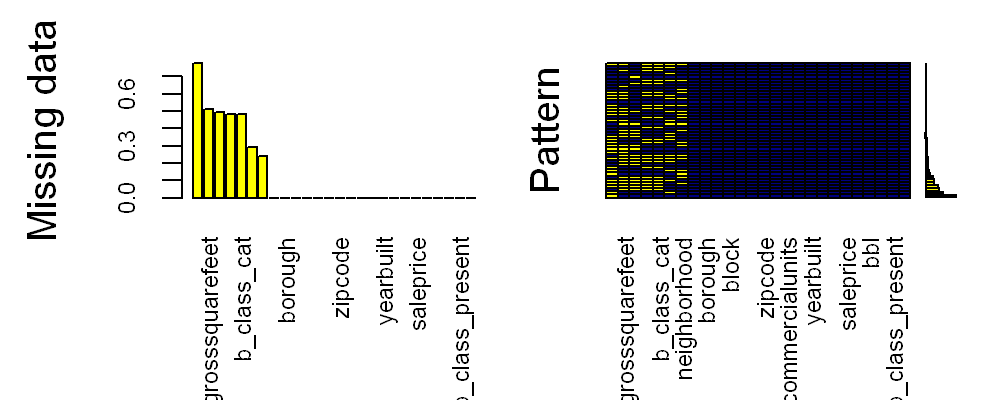

In [47]:
colSums(is.na(dt))
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)
mice_plot <- aggr(dt, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(dt), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))
mice_plot


* neighborhood is such a nice column to take a reference in order to impute missing values in other columns.However, almost 25% ofthis column has missing values.

* buildingclasscategory is only 57% complete. Therefore,it is better to ignore it. 

* Almost 30% of address is missing. No need to impute it.

* Apartmentnumber has much more missing values.

* landssquarefeet and grosssquarefeet have too many missing data points.

In [48]:
#nothing can be drawn from apartmentnumber, so we can delete it peacefully.
dt[,.N,.(apartmentnumber)][order(-N)] %>% head(5)

apartmentnumber N    
1 NA              45186
2 3b                217
3 3a                216
4 2b                207
5 2a                205

In [49]:
dt[,c("apartmentnumber") := NULL]

**Other Features**

I'll try to extract some info from features listed below.


In [50]:
s = skim(dt)
dt_complete = data.table(variable = s$skim_variable,complete_rate = s$complete_rate)[complete_rate < 1]
dt_complete[order(complete_rate)]

variable              complete_rate
1 grosssquarefeet       0.4915409    
2 landsquarefeet        0.5084935    
3 buildingclasscategory 0.5190438    
4 b_class_cat           0.5190438    
5 address               0.7073989    
6 neighborhood          0.7601845

### Focus on features

#### building category

Building class and building category seem to be relevant. There is no such a 1-1 kind of mapping between themm. Yet, for instance, b_class = a is always category 1. 

In the beginning I though I might impute building category by using b_class_present. However most missing values of category are c,d, and r of b_class. These classes do not have enoght number of observations with complete category info.

Apart from that, only b_class_cat 1 and 2 have a meaningful presence in the data set and b_class_present can cover this as well. 

So, I'll ignore building category in the calculations in the further steps.

In [51]:
b_class_freq = dt[,.N,.(b_class_present,b_class_cat)]
b_class_freq[, perc  := round(N / sum(N),2)]
b_class_freq[order(b_class_present)]
b_class_freq[order(b_class_present)][ perc > 0.05]

b_class_present b_class_cat N     perc
1  a                1          12491 0.21
2  b                2           9459 0.16
3  c               NA           4250 0.07
4  c                3           2327 0.04
5  d               NA          11719 0.20
6  e               30            167 0.00
7  f               27            106 0.00
8  g               29            273 0.00
9  g               NA             43 0.00
10 h               25              8 0.00
11 h               26             93 0.00
12 i               32             28 0.00
13 j               34              4 0.00
14 k               22            477 0.01
15 l               23             21 0.00
16 m               37             62 0.00
17 n               38             14 0.00
18 o               21            221 0.00
19 p               35             16 0.00
20 q               36              6 0.00
21 r               NA          11546 0.20
22 r               17           1111 0.02
23 r               46             72 0.00
24 r                4           1225 0.02
25 r               43            239 0.00
26 r               44            264 0.00
27 r               28             14 0.00
28 r               45             81 0.00
29 r               42              4 0.00
30 r               49             10 0.00
31 r               48             12 0.00
32 r               11              1 0.00
33 s               NA            327 0.01
34 s                2            436 0.01
35 s                1            218 0.00
36 t               39              1 0.00
37 v               31            185 0.00
38 v                5            485 0.01
39 w               33             26 0.00
40 y               40              1 0.00
41 z               NA             60 0.00

b_class_present b_class_cat N     perc
1 a                1          12491 0.21
2 b                2           9459 0.16
3 c               NA           4250 0.07
4 d               NA          11719 0.20
5 r               NA          11546 0.20

Nevertheless, I just want to explore building category more. 

Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."


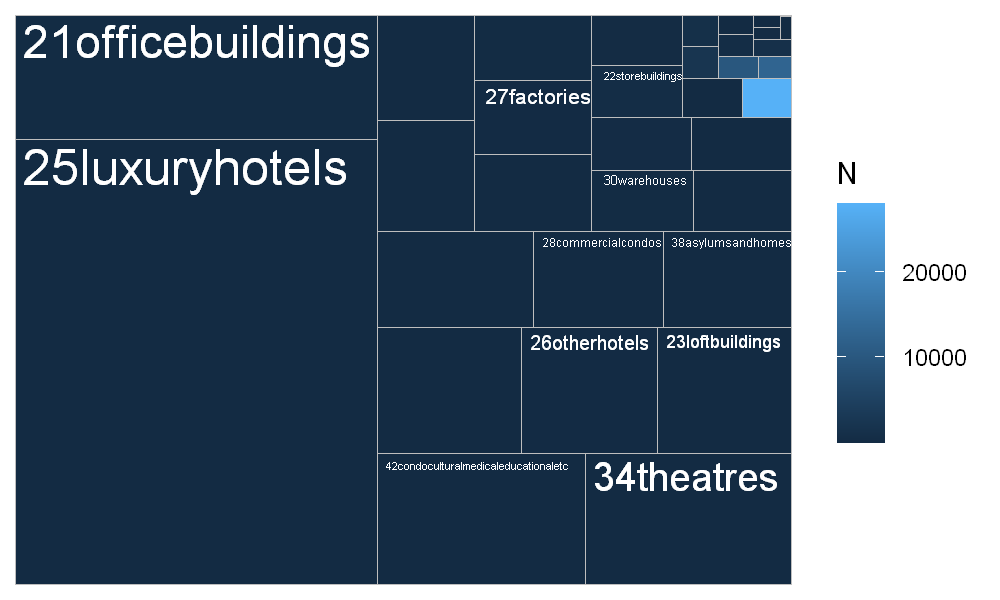

In [52]:
dt_tree = dt[,.(M = mean(saleprice, na.rm = TRUE), N = .N) ,.(buildingclasscategory)]

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(dt_tree
       , aes(area = M, fill = N, label = buildingclasscategory)) +
  geom_treemap() +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T)


So, luxuryhotels have the highet mean but there are only 8 records.  Light Blue colored cell is on the top right of the treemap. 

It really seems that we cannot benefit from building category regarding price prediction.

In [53]:
#dt[,saleprice_group := Hmisc::cut2(saleprice,g = 10)]
#
#options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 200)
#ggplot(data = dt, aes(y = saleprice, x = as.factor(b_class_past), fill =as.factor(b_class_past))) + 
#    geom_boxplot() +
#    facet_wrap(~ saleprice_group,scales = "free", ncol = 2)
#
### b_class_cat'ı b_class_present ile doldurabiliriz.


#### Grouping building classes

In [54]:
b_groups = dt[,.N,.(b_class_present)][order(-N)]
b_groups[, perc := N/sum(N)][order(-perc)] 

b_class_present N     perc         
1  r               14579 0.25091647591
2  a               12491 0.21498029362
3  d               11719 0.20169354422
4  b                9459 0.16279710170
5  c                6577 0.11319553207
6  s                 981 0.01688380979
7  v                 670 0.01153124624
8  k                 477 0.00820955889
9  g                 316 0.00543861763
10 o                 221 0.00380359018
11 e                 167 0.00287420615
12 f                 106 0.00182434642
13 h                 101 0.00173829234
14 m                  62 0.00106707055
15 z                  60 0.00103264892
16 i                  28 0.00048190283
17 w                  26 0.00044748120
18 l                  21 0.00036142712
19 p                  16 0.00027537304
20 n                  14 0.00024095141
21 q                   6 0.00010326489
22 j                   4 0.00006884326
23 y                   1 0.00001721082
24 t                   1 0.00001721082

In [55]:
dt[, b_class_group := encode_grouping(b_class_present, Q = 6,name_for_other = "other")]
dt[,.N,.(b_class_group)]

b_class_group N    
1 c              6577
2 d             11719
3 r             14579
4 other          3278
5 a             12491
6 b              9459

#### Address

Maybe we can obtain some info from address column. Let's see.

In [56]:
address_focus = dt$address
address_focus[str_detect(address_focus, "street")] = "street"
address_focus[str_detect(address_focus, "avenue")] = "avenue"
address_focus[str_detect(address_focus, "square")] = "square"
address_focus[str_detect(address_focus, "highway")] = "highway"
address_focus[str_detect(address_focus, "boulevard")] = "boulevard"
address_focus[str_detect(address_focus, "centralpark")] = "centralpark"
address_focus[str_detect(address_focus, "broadway")] = "broaadway"
address_focus[str_detect(address_focus, "road")] = "road"
address_focus[!address_focus %in% c("street","avenue","square","highway","boulevard","centralpark","broaadway","road")] = "other"
table(address_focus)

address_focus
     avenue   boulevard   broaadway centralpark     highway       other 
      12094         386         342         331          38       23774 
       road      square      street 
       1136          45       19957 

In [57]:
## lets try to simplify the address column
address_focus = dt$address
address_focus[str_detect(address_focus, "street")] = "street"
address_focus[str_detect(address_focus, "avenue")] = "avenue"
address_focus[!address_focus %in% c("street","avenue")] = "other"
table(address_focus)
dt$address = address_focus

address_focus
avenue  other street 
 12094  26052  19957 

Warning message in melt.data.table(., id.vars = id_col):
"'measure.vars' [saleprice, totalunits, commercialunits] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."


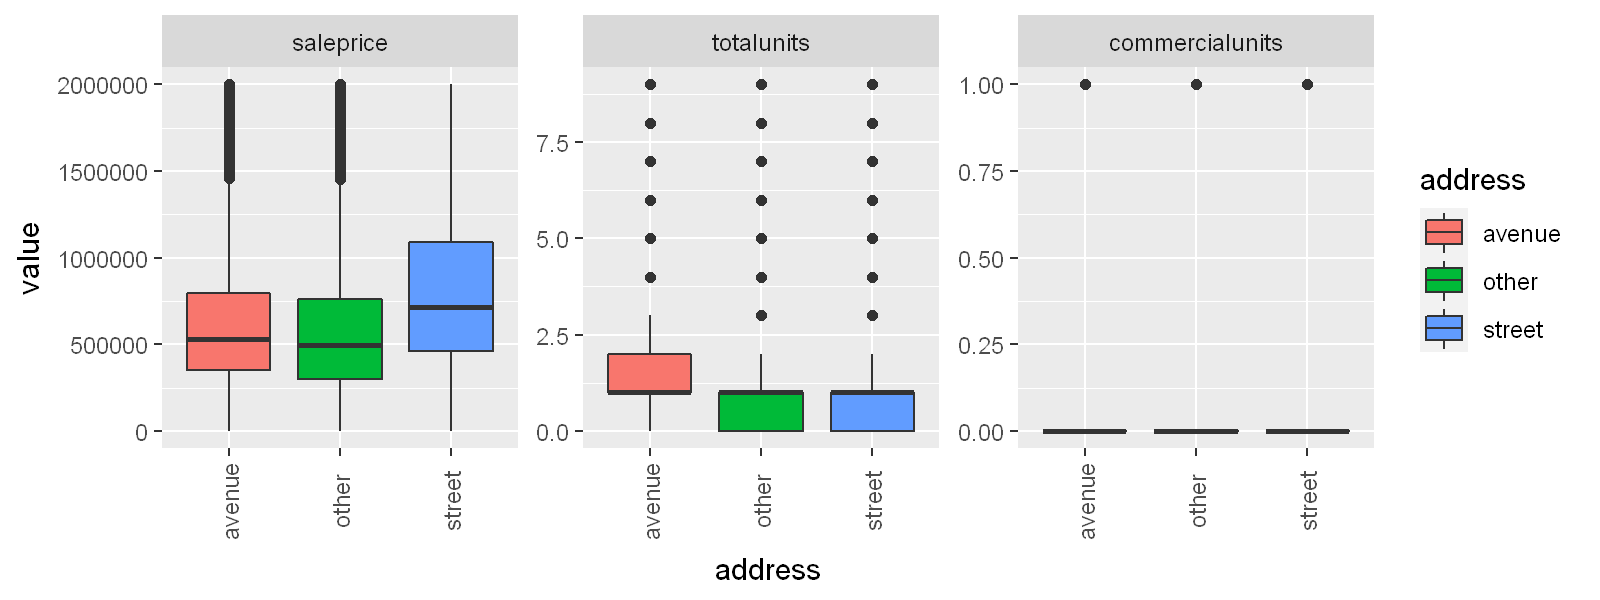

In [58]:
selected_cols = c("saleprice","totalunits","commercialunits")

options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 200)
draw_boxplot(dt[saleprice < 2000000 & totalunits< 10 & commercialunits < 2],id_col = "address", selected_cols)

new address info can be useful in prediction of small house prices.

#### Neighborhood

The size of the rectangules implies the number of data points, while the color shows the mean sale price in the neighborhood.

Warning message:
"Removed 5 rows containing missing values (geom_treemap_text)."


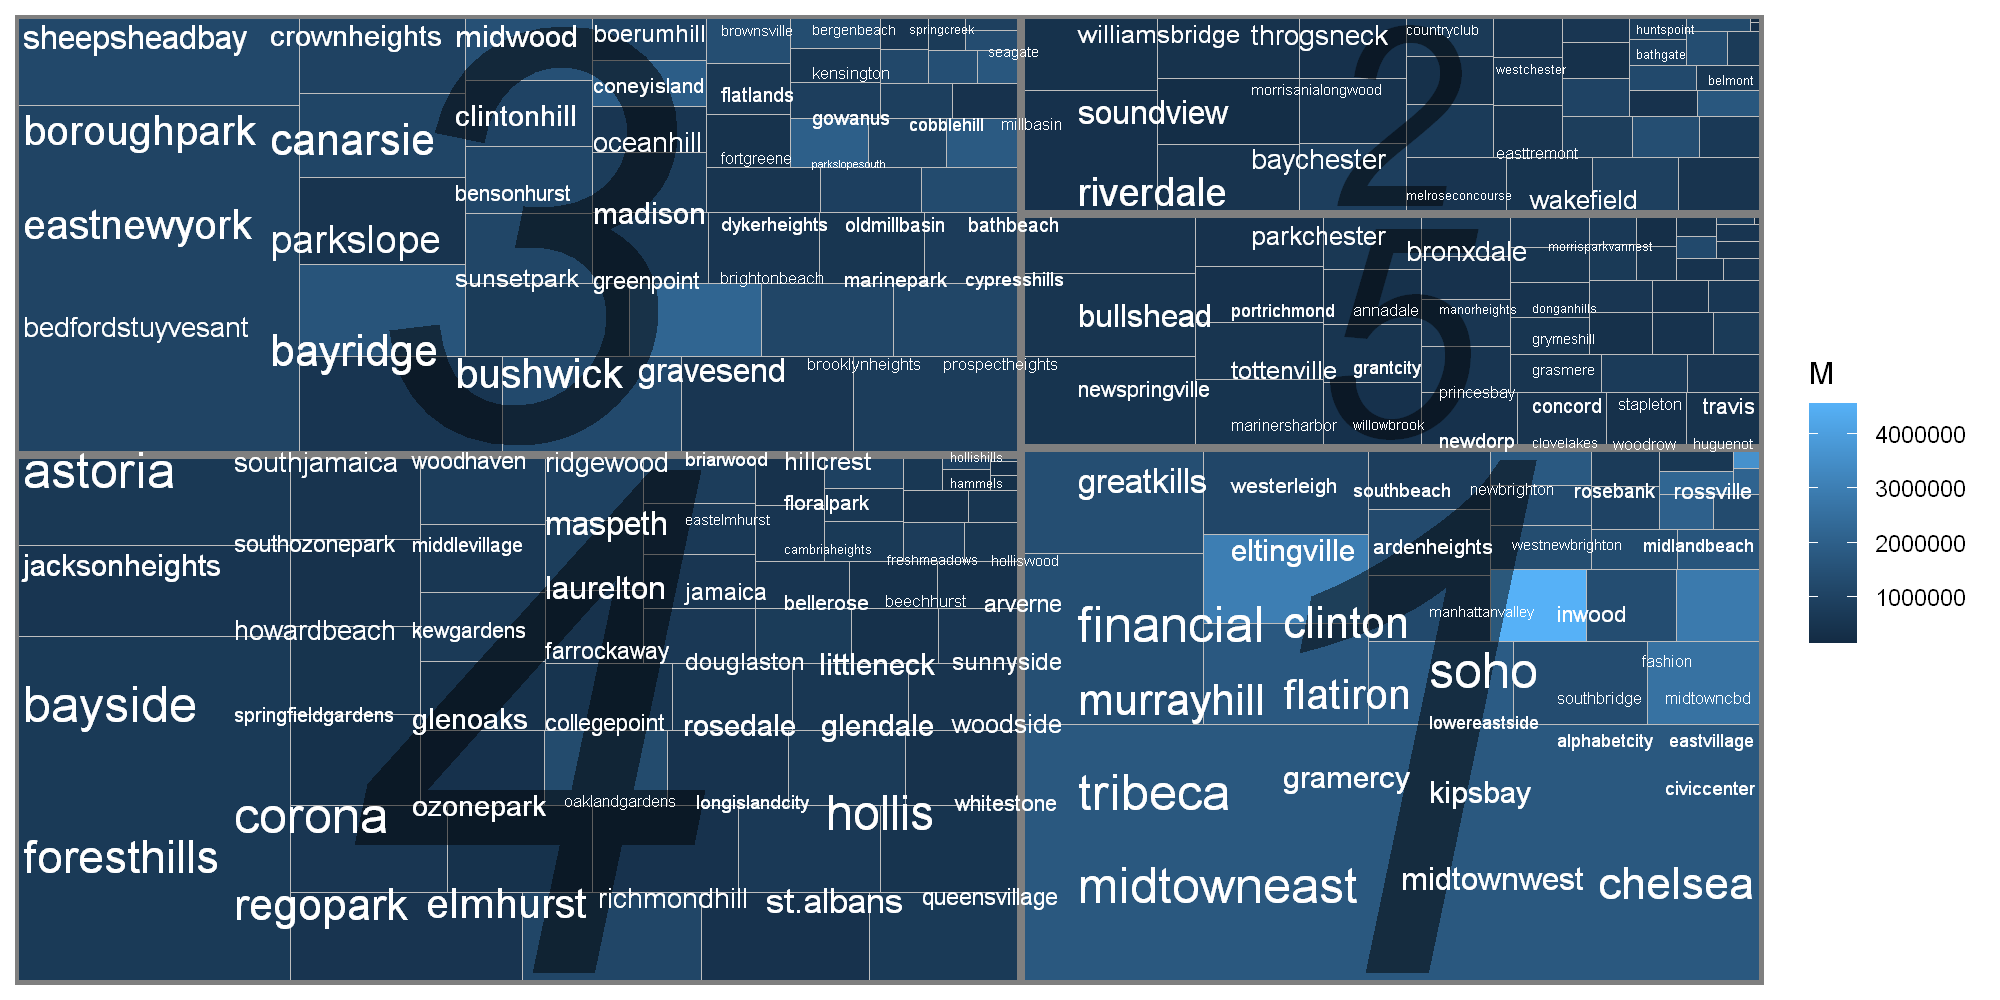

In [59]:
dt_tree = dt[saleprice < 10000000,.(N = .N, M = mean(saleprice,na.rm = TRUE)),.(borough,neighborhood)]

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
ggplot(dt_tree
       , aes(area = N, fill = M, label = neighborhood,
                subgroup = borough)) +
  geom_treemap() +
  geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", grow = T, alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 0) +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T)

In [60]:
dt_tree = dt[saleprice < 10000000,.(N = .N, M = mean(saleprice,na.rm = TRUE)),.(borough,neighborhood)]

for(i in c(1:5)){
g = ggplot(dt_tree[borough == i]
           , aes(area = N, fill = M, label = neighborhood,subgroup = borough)) +
  geom_treemap() +
  geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", grow = T, alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 0) +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T) 
    
    assign(paste0("g_",i),g)
    }

Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."
Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."
Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."
Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."
Warning message:
"Removed 1 rows containing missing values (geom_treemap_text)."


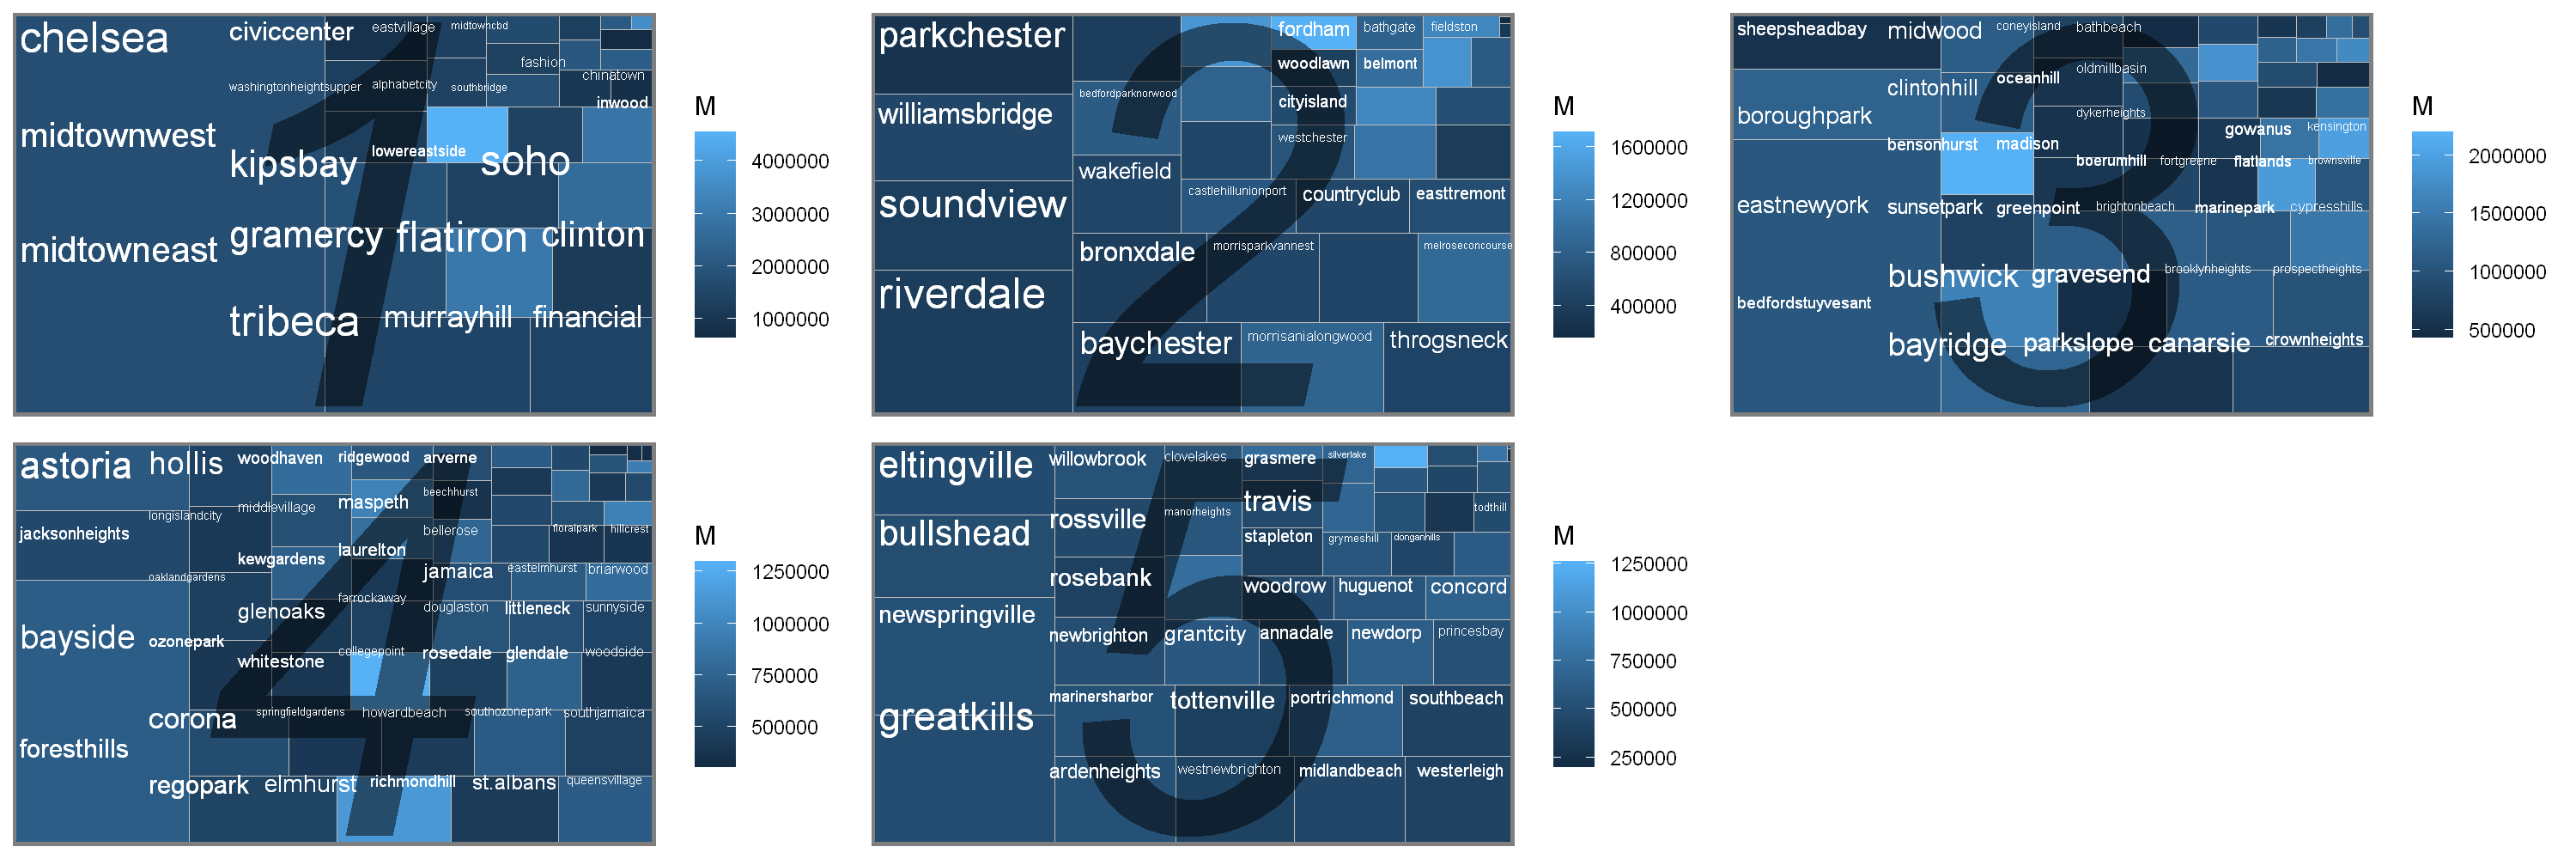

In [61]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
gridExtra::grid.arrange(g_1,g_2,g_3,g_4,g_5, nrow = 2)

### Distributions 

*midtowncbd includes the terrific record with 210000000000 saleprice.*

t(dt[saleprice > 2000000000])

Warning message:
"attributes are not identical across measure variables;
they will be dropped"
Warning message in min(xx[xx > upper]):
"no non-missing arguments to min; returning Inf"
Warning message:
"attributes are not identical across measure variables;
they will be dropped"


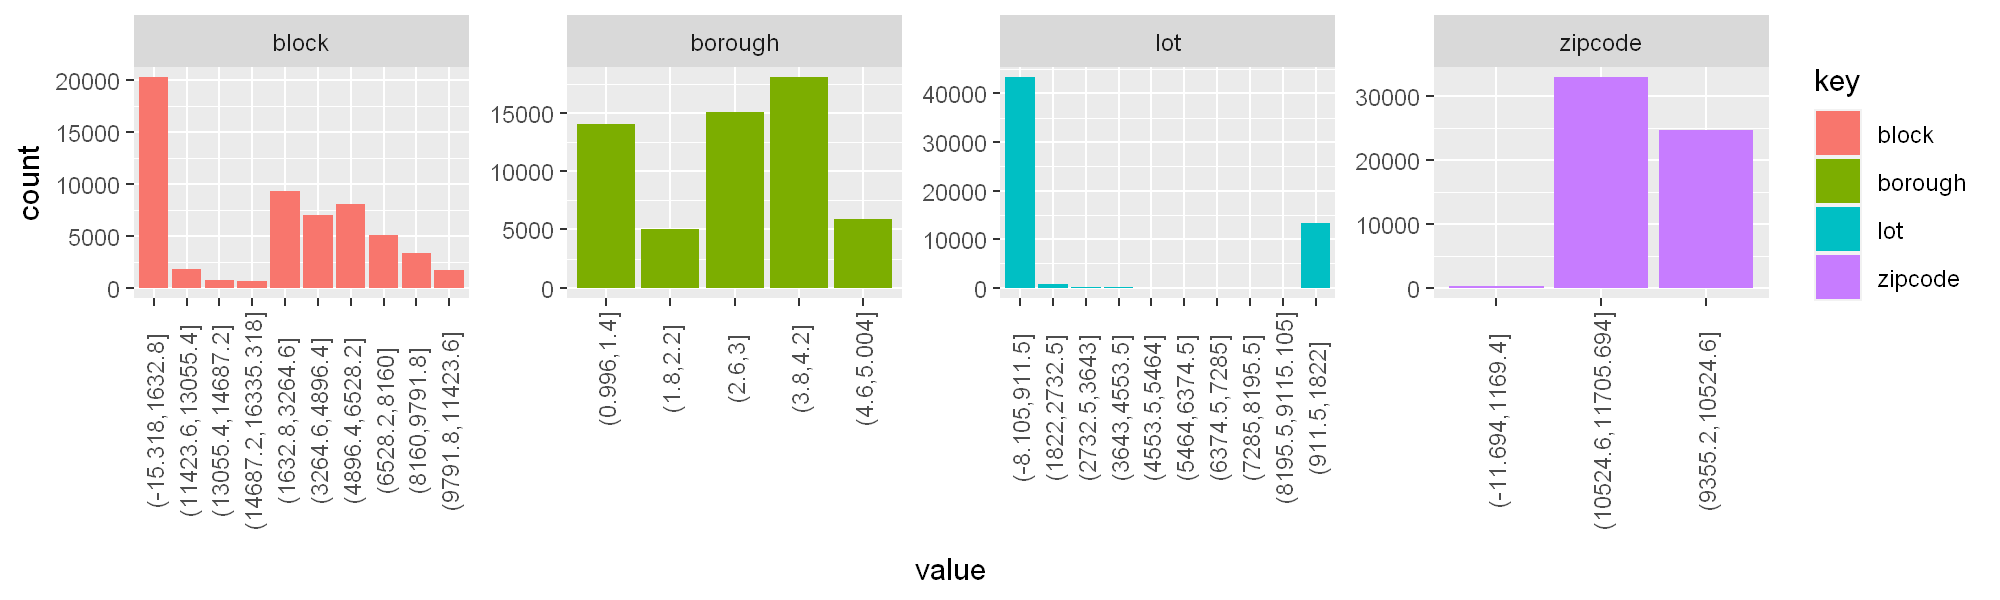

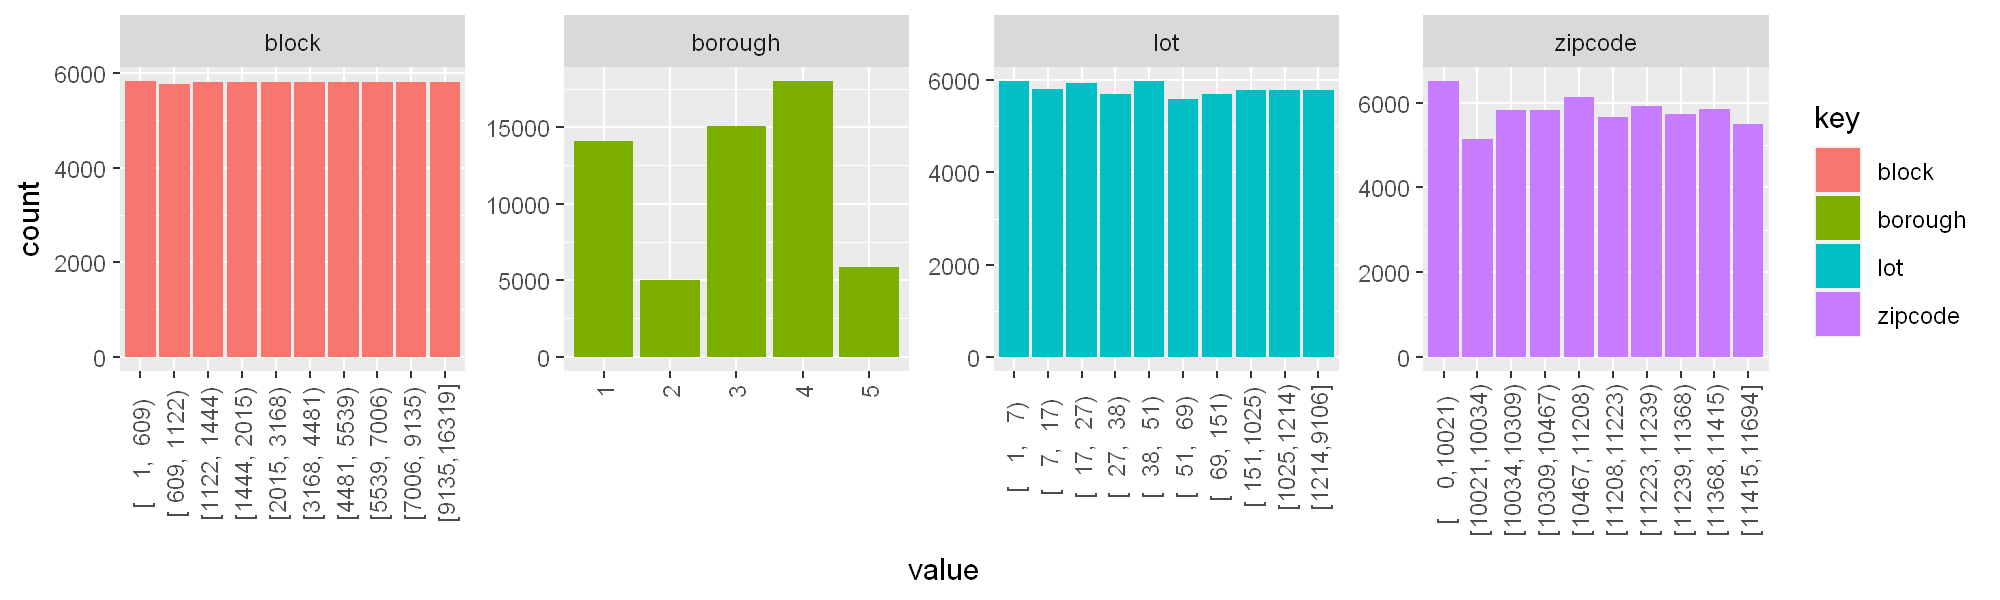

In [62]:
loc_cols = c('borough','block','lot',"zipcode")

options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
draw_barplot(dt,loc_cols,bin_number = 10,ncol = 4)
draw_barplot(dt,loc_cols,group_number = 10,ncol = 4)

Warning message:
"attributes are not identical across measure variables;
they will be dropped"
Warning message:
"attributes are not identical across measure variables;
they will be dropped"


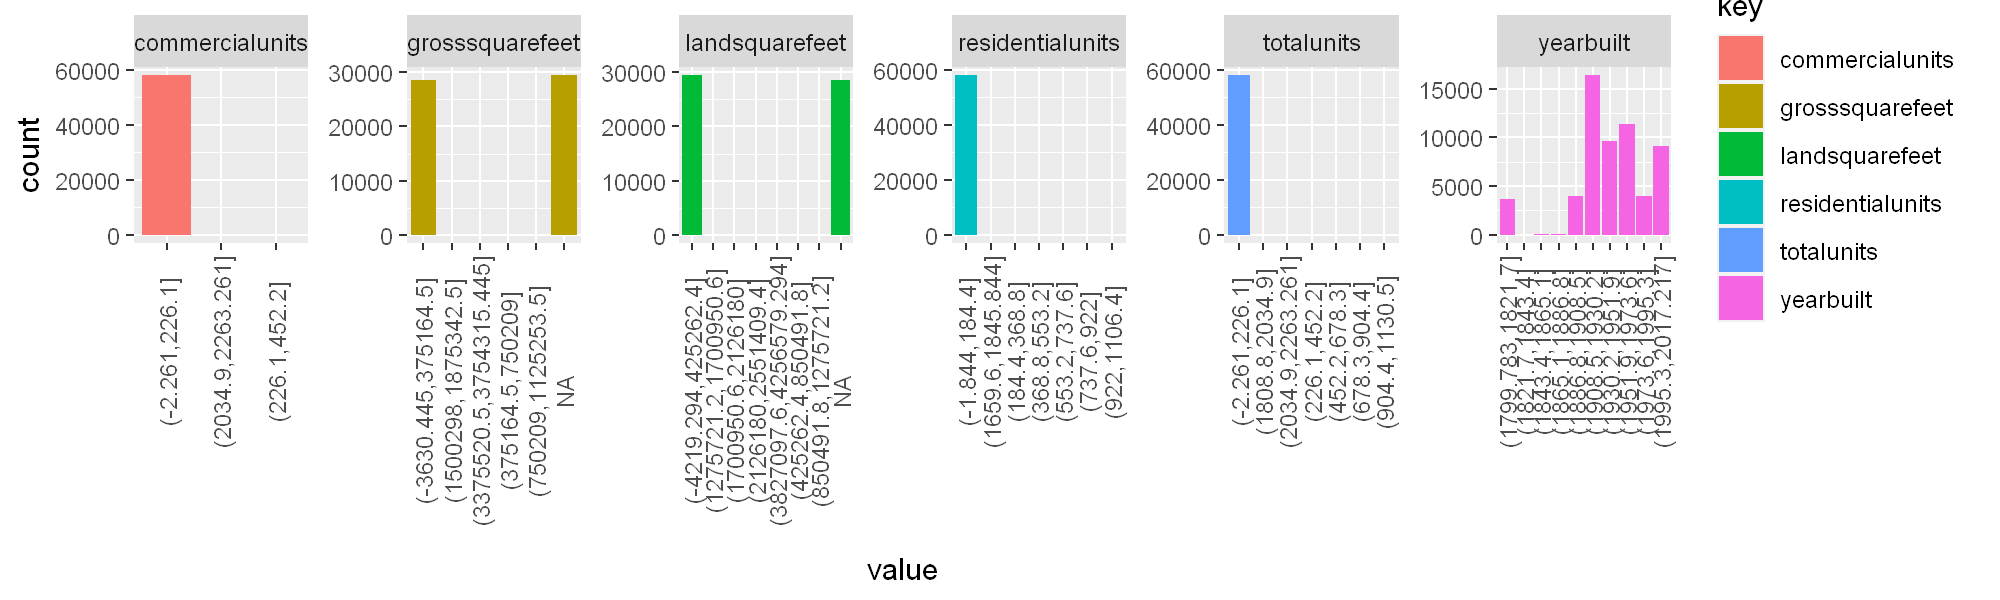

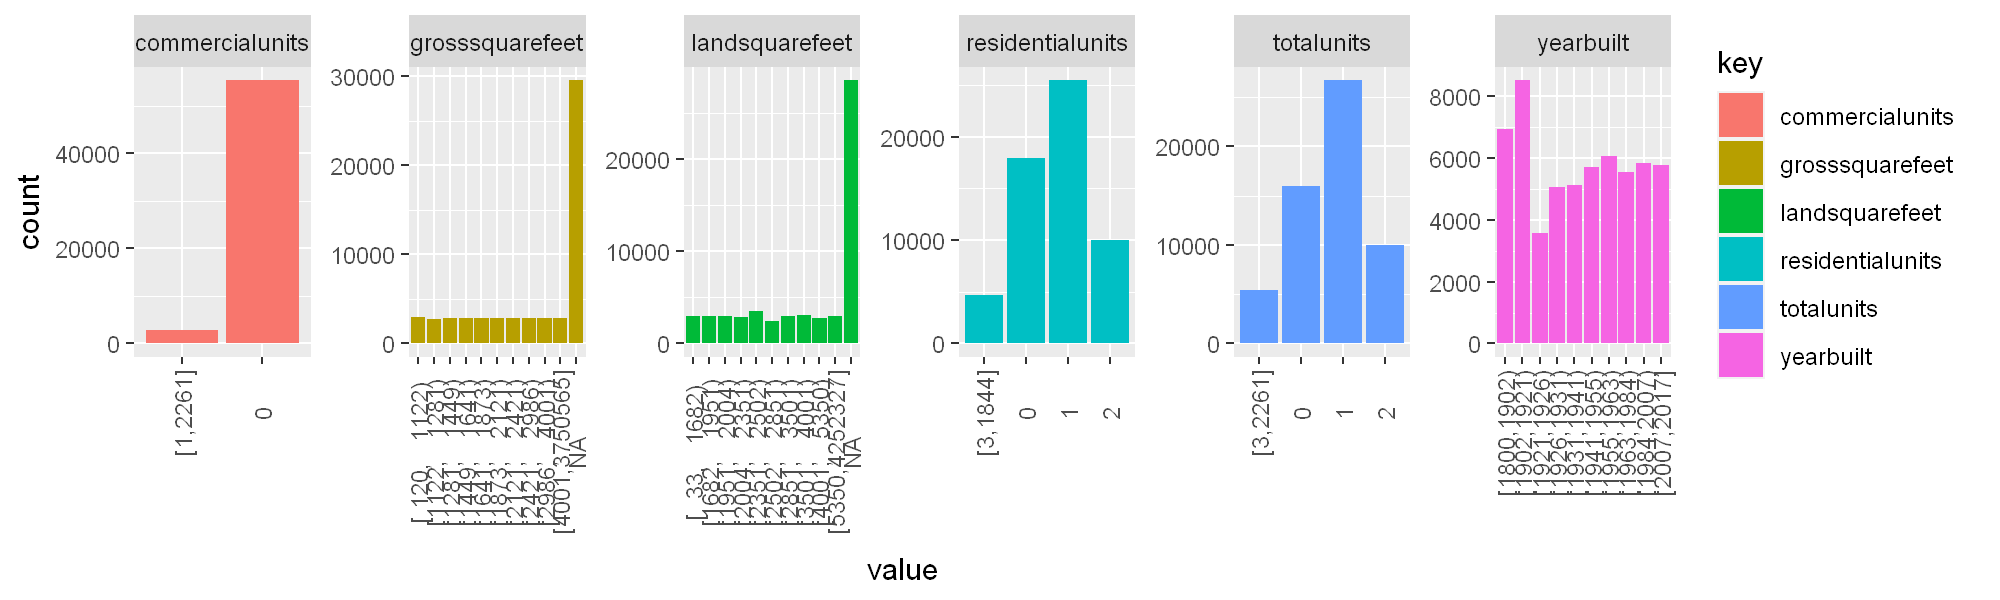

In [63]:
selected_cols = c('residentialunits','commercialunits','totalunits','landsquarefeet','grosssquarefeet','yearbuilt')

options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
draw_barplot(dt,selected_cols,bin_number = 10,ncol = 6)
draw_barplot(dt,selected_cols,group_number = 10,ncol = 6)

#### WRT SalePrice

In [64]:
dt_c = copy(dt[   ,.(residential_group = Hmisc::cut2(residentialunits, g = 10),
                  commerical_group = Hmisc::cut2(commercialunits, g = 10),
                  totalunit_group = Hmisc::cut2(totalunits, g = 10),
                  landsquarefeet_group = Hmisc::cut2(landsquarefeet, g = 10),
                  grosssquarefeet_group = Hmisc::cut2(grosssquarefeet, g = 10),
                     grosssquarefeet_log_group = Hmisc::cut2(log(grosssquarefeet), g = 10),
                     grosssquarefeet_log = log(grosssquarefeet),
                  yearbuilt_group = Hmisc::cut2(yearbuilt, g = 10),
                  saleprice,
                  saleprice_log = log(saleprice),
                saleprice_sqrt = sqrt(saleprice),
                      totalunits,
                      commercialunits,
                      yearbuilt,
                      grosssquarefeet,
                      zipcode,
                  address,
                  borough = as.factor(borough),
                  taxclass_present =as.factor(taxclass_present),
                  b_class_present = as.factor(b_class_present),
                    b_class_group)])

dt_c[, saleprice_wo := tend_outliers_keep(saleprice, sigma = 3),.(borough)]
dt_c[, saleprice_wo_log := log(saleprice_wo)]

dt_c[, saleprice_log_wo := tend_outliers_keep(saleprice_log, sigma = 3),.(borough)]

In [65]:
price_summaries = dt_c[, as.list(summary(saleprice)), by = borough]
price_summaries
price_summaries = dt_c[, as.list(summary(saleprice_wo)), by = borough]
price_summaries

borough Min. 1st Qu. Median    Mean      3rd Qu. Max.      
1 1       373  665000  1150000.0 3327982.1 2425000 2210000000
2 2       250  226000   405300.0  825425.6  575000  110000000
3 3       210  456246   765000.0 1306216.2 1261239  345000000
4 4       300  295000   499994.5  750476.6  780000  257500000
5 5       500  335000   468468.0  553102.3  600000  122000000

borough Min. 1st Qu. Median    Mean      3rd Qu. Max.    
1 1       373  665000  1150000.0 2364344.3 2425000 16971406
2 2       250  226000   405300.0  568088.9  575000  3687222
3 3       210  456246   765000.0 1036736.0 1261239  4804451
4 4       300  295000   499994.5  603108.1  780000  2449214
5 5       500  335000   468468.0  490229.5  600000  1409392

Saleprice quartiles of each borough seems different. Especially look at borought 1 and 2.

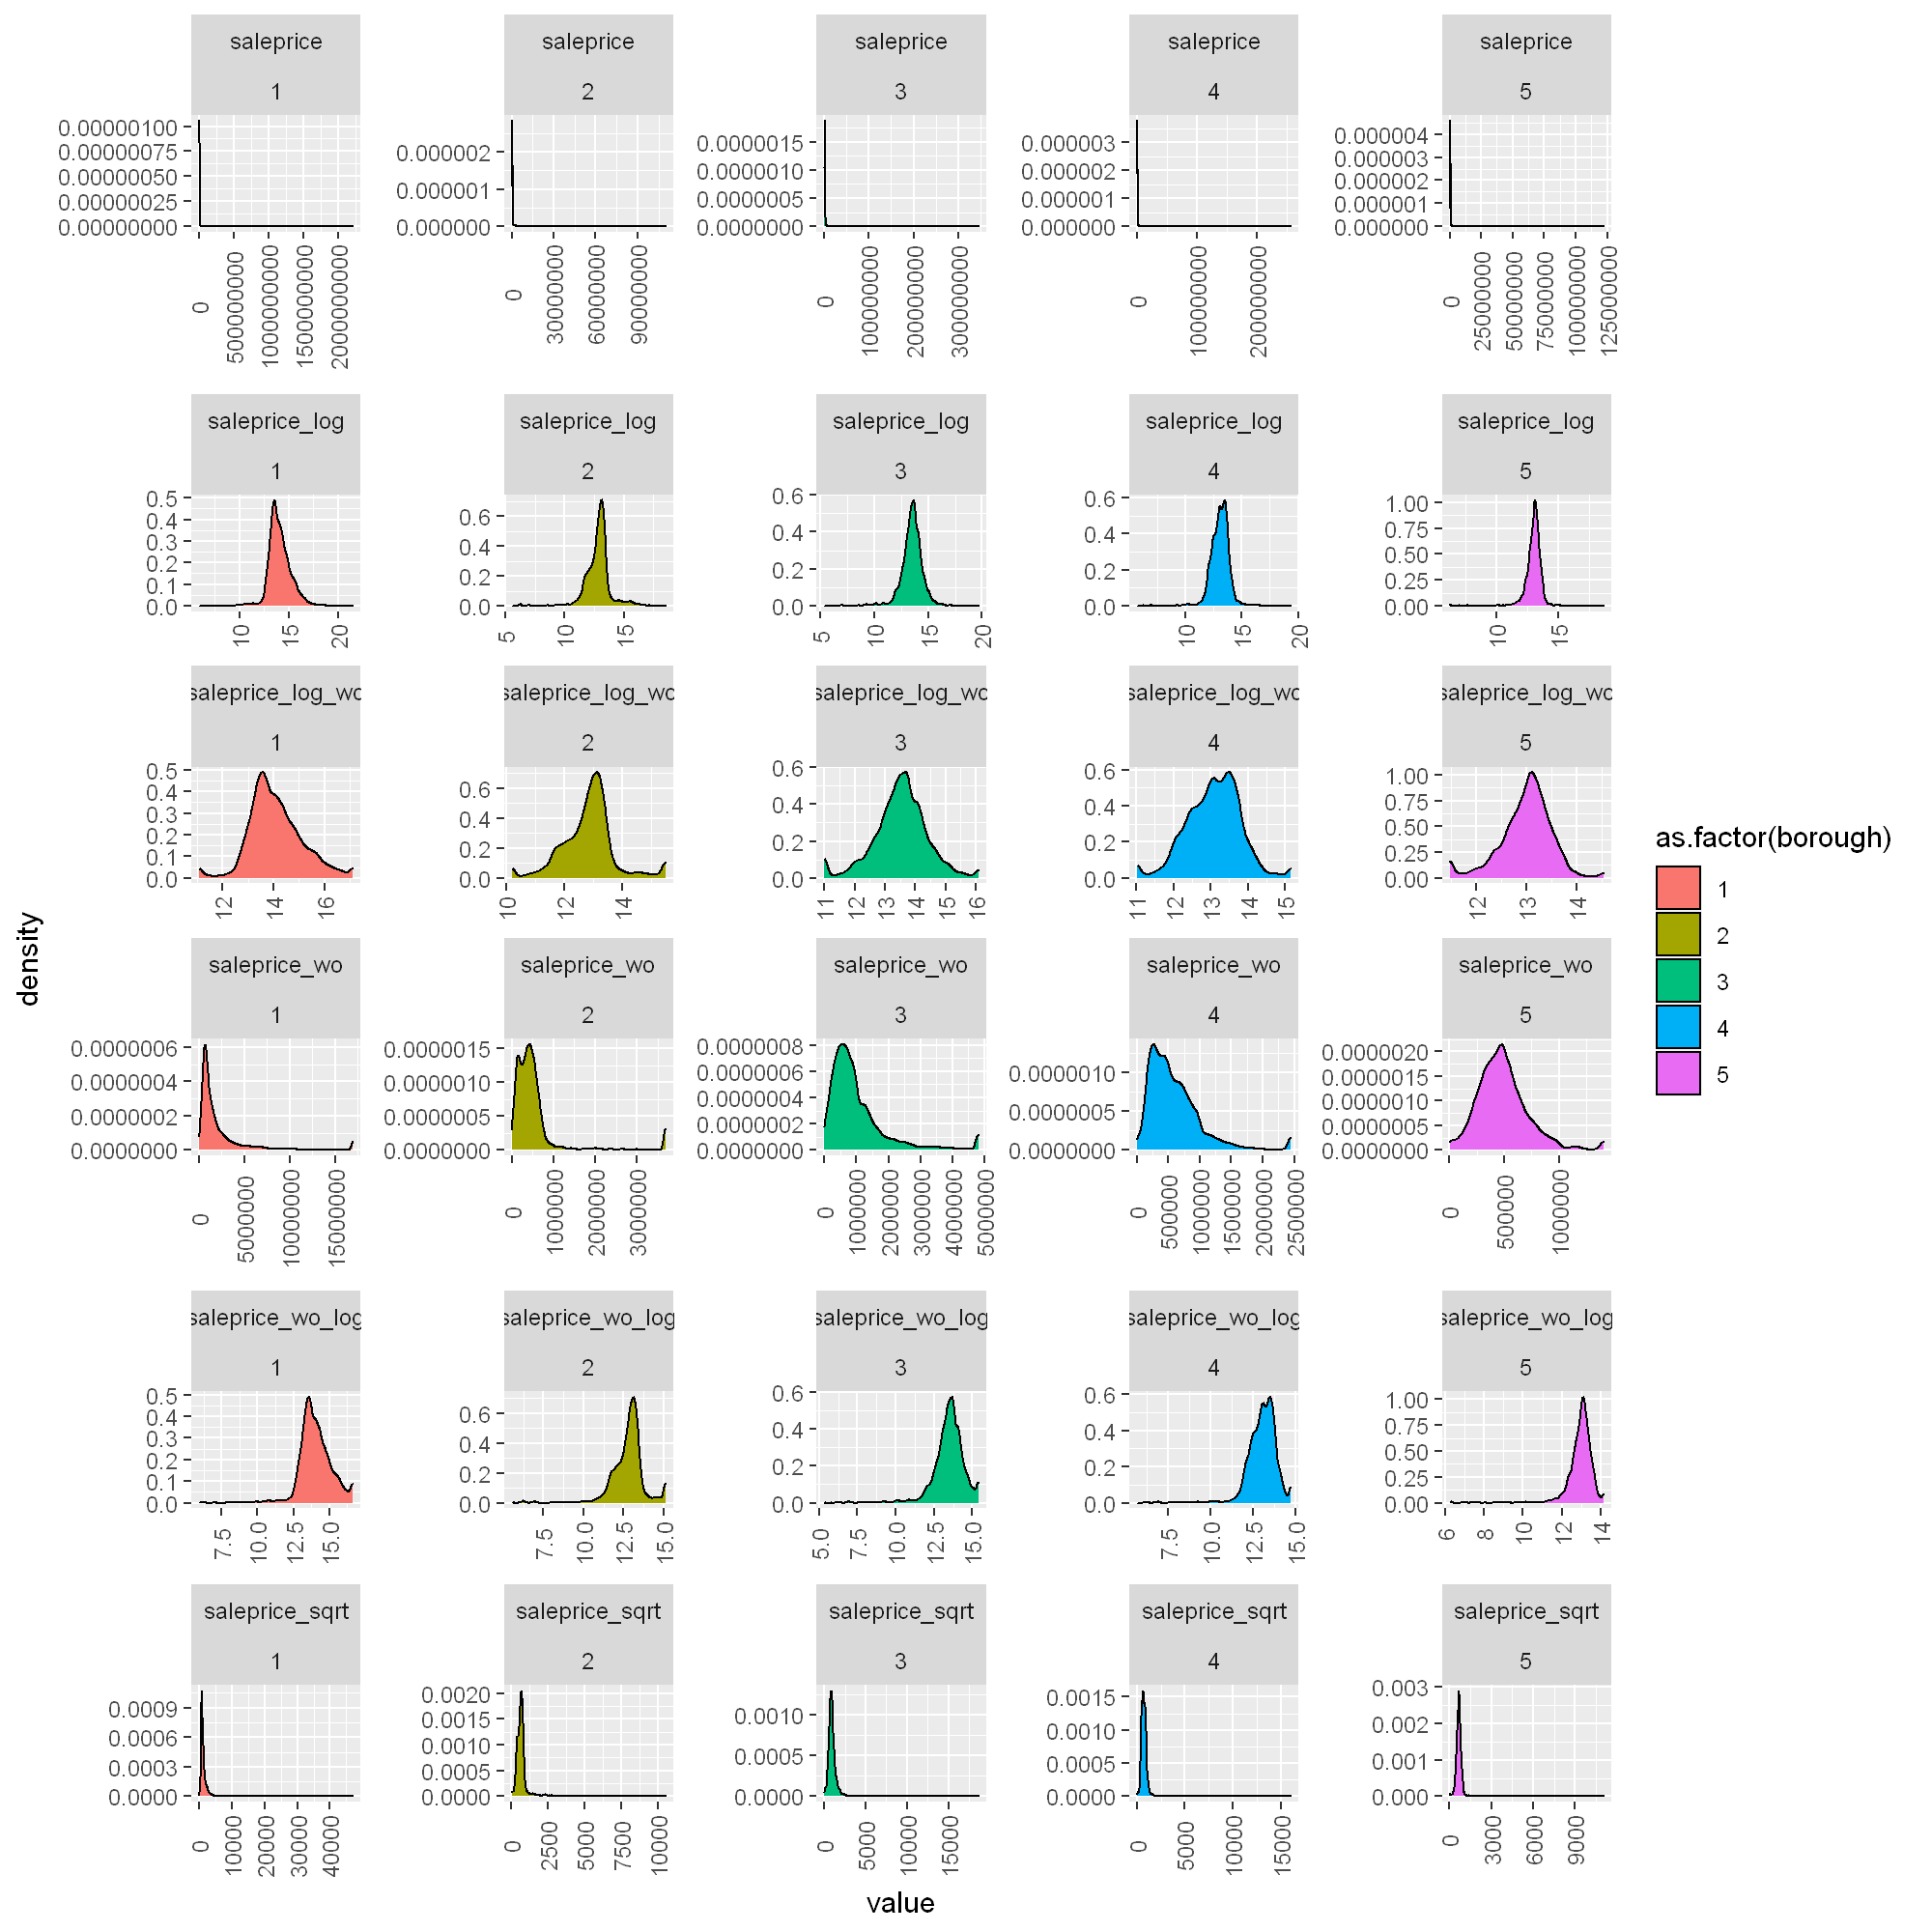

In [66]:
dt_molten = dt_c[,.(borough,saleprice,saleprice_log,saleprice_log_wo,saleprice_wo,saleprice_wo_log,saleprice_sqrt)] %>%
    melt.data.table(id.vars = c("borough"))
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
ggplot(data = dt_molten ,aes(x = value, fill = as.factor(borough)))+ 
  facet_wrap(variable ~ borough, scales ="free", ncol = 5) + 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

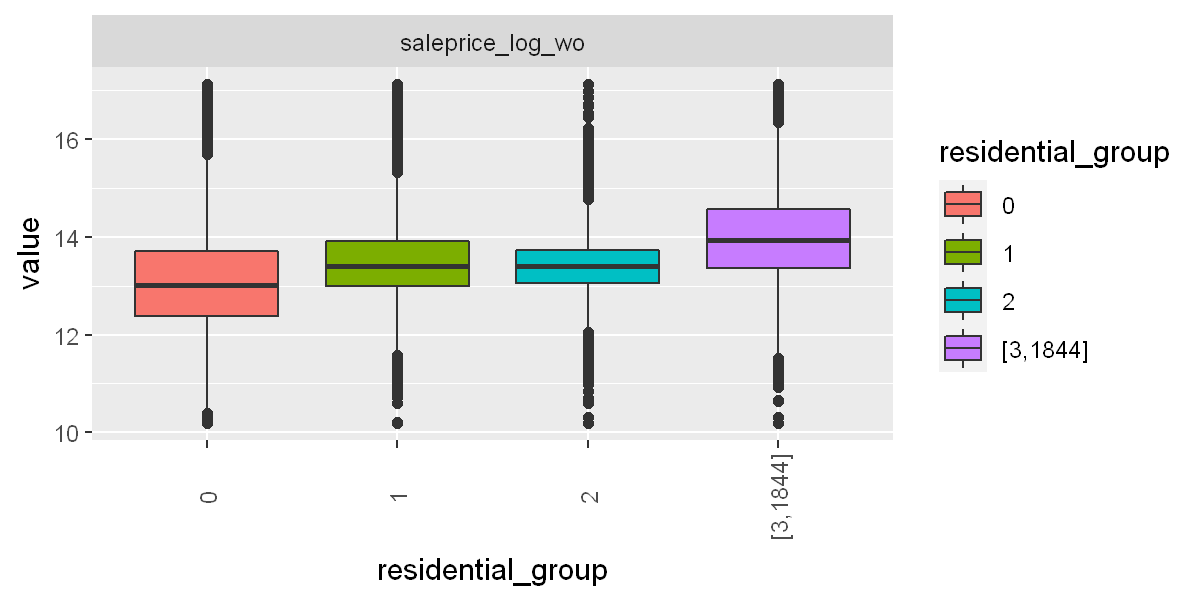

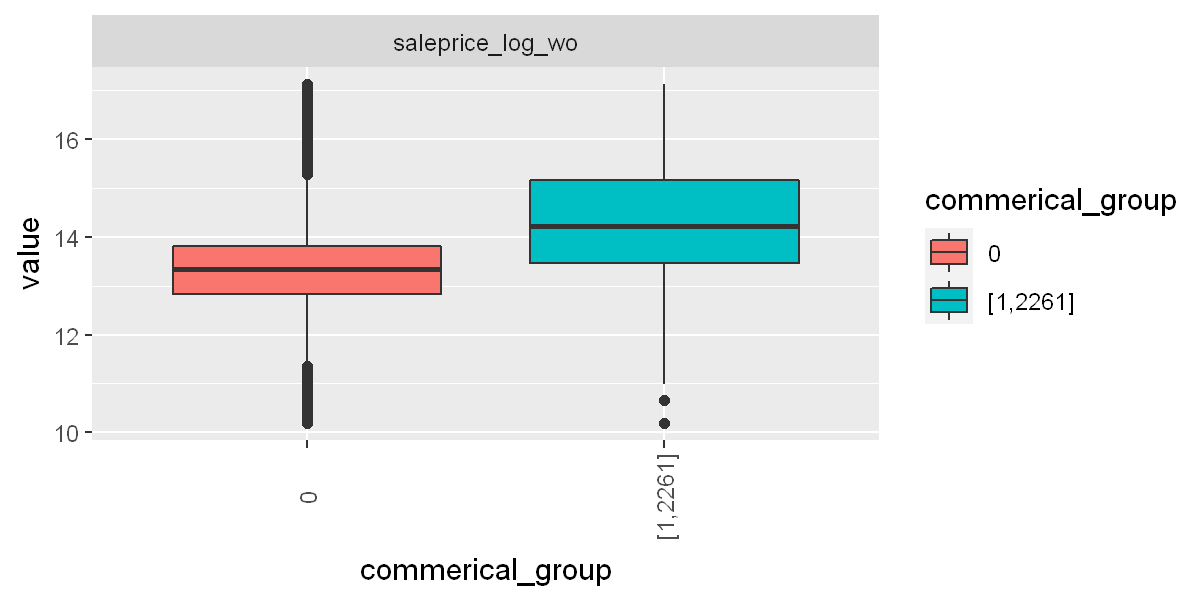

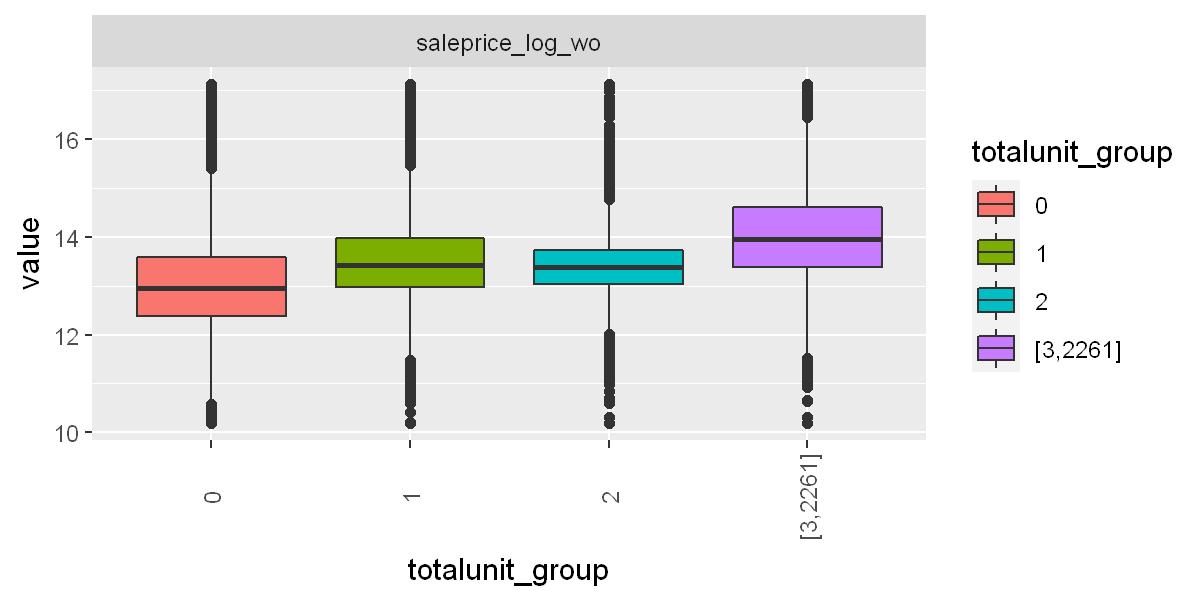

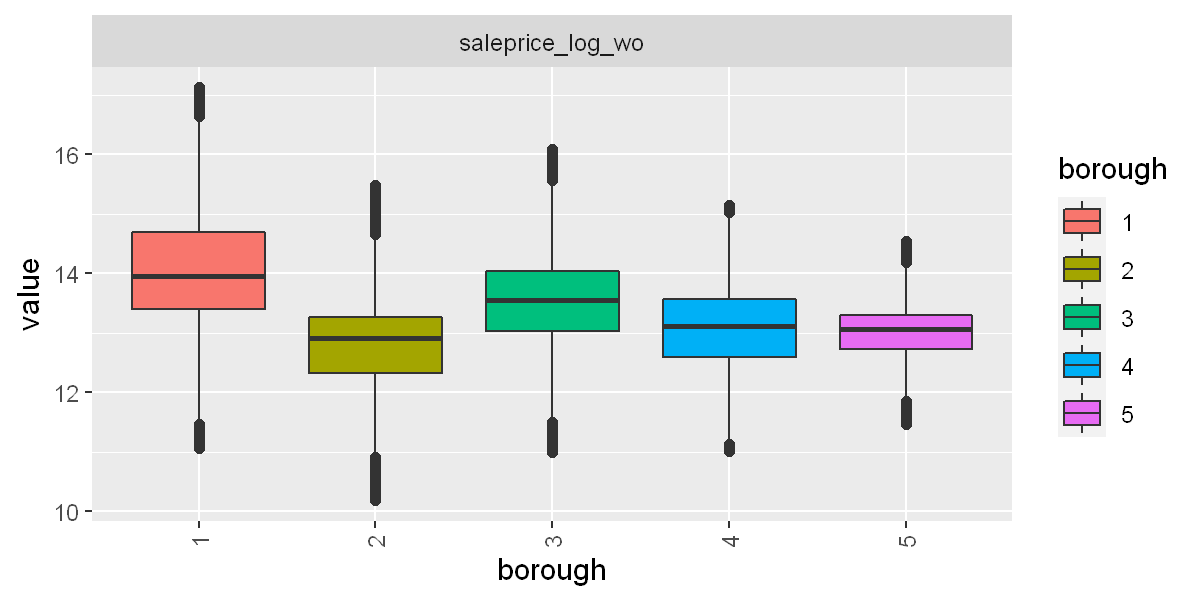

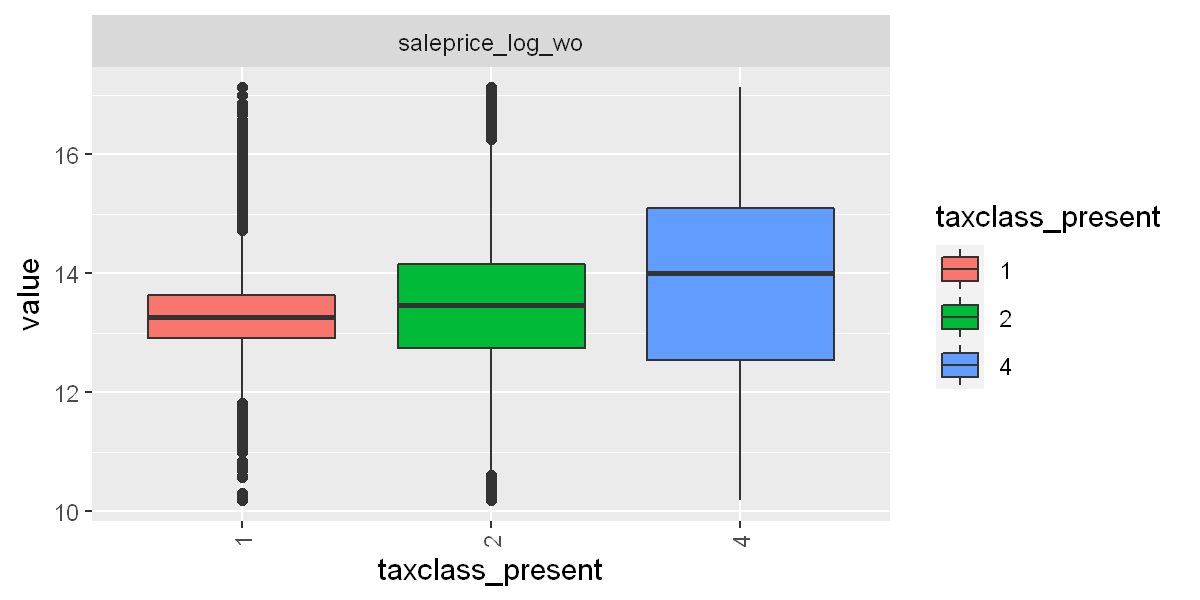

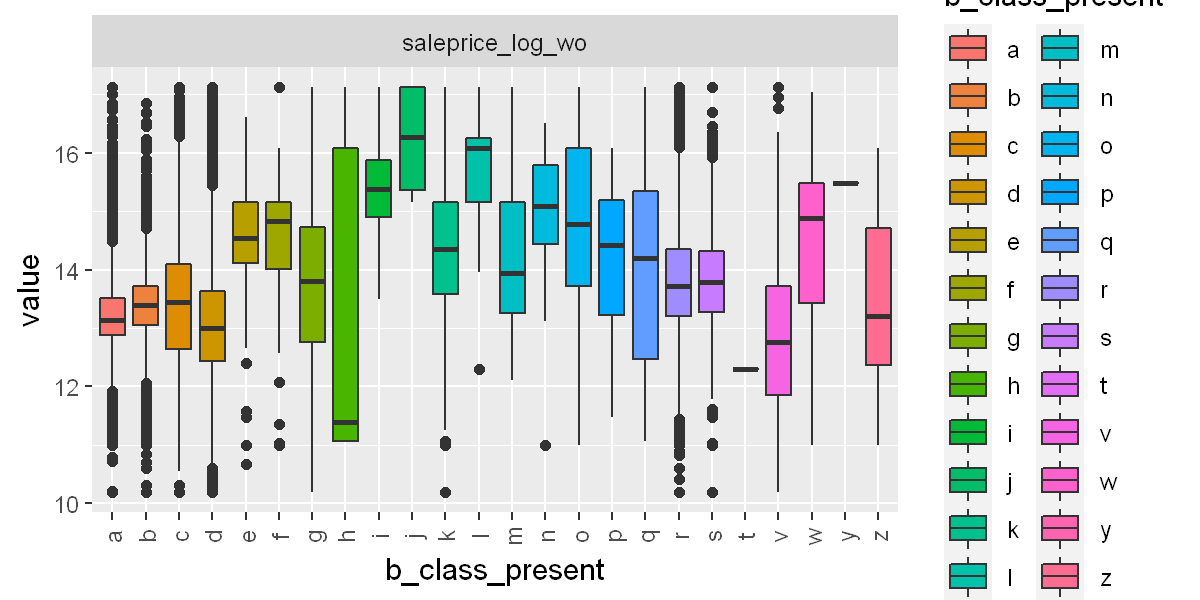

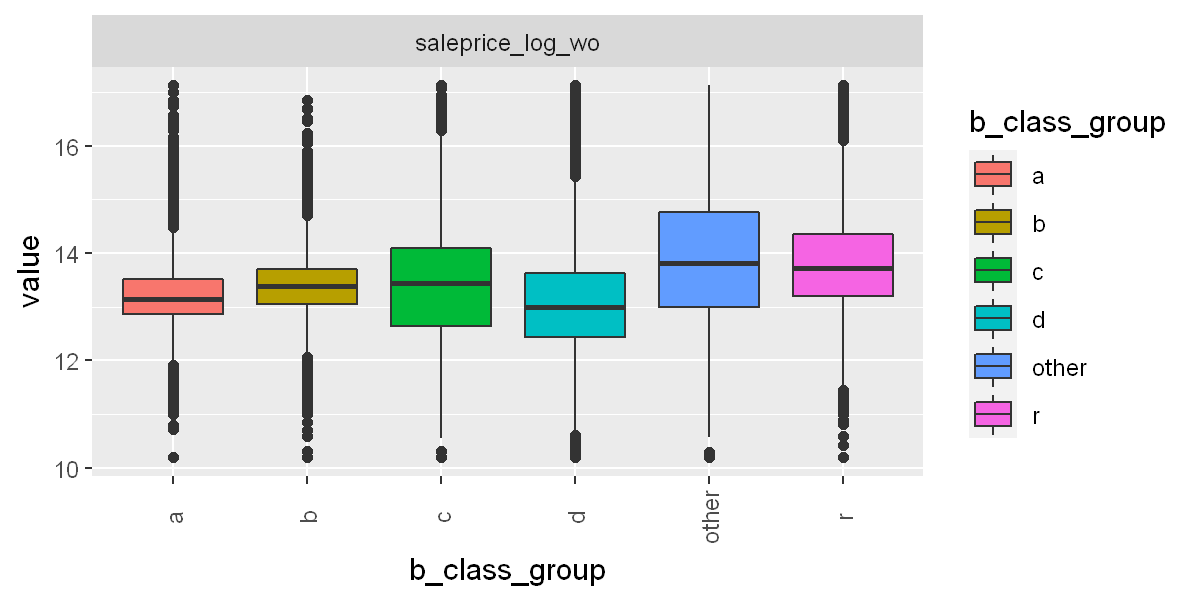

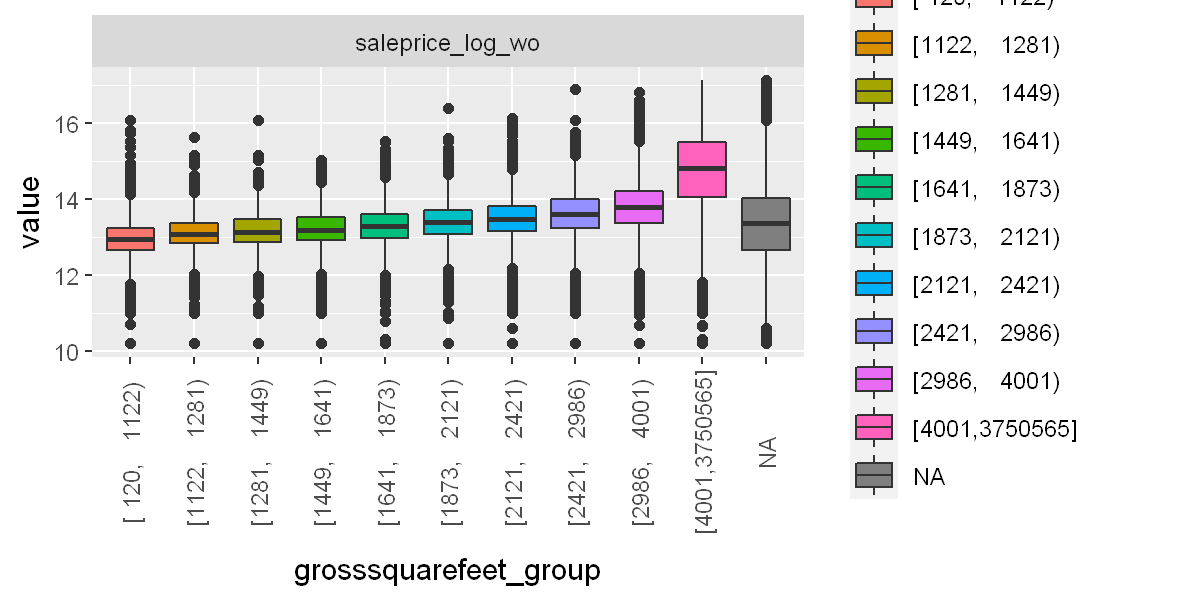

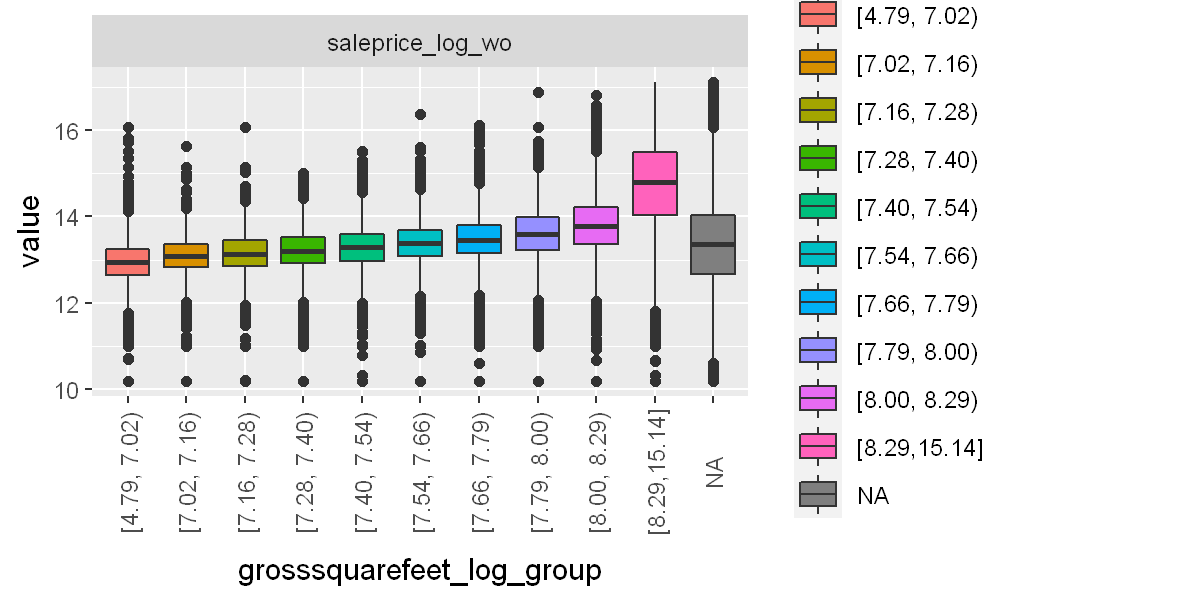

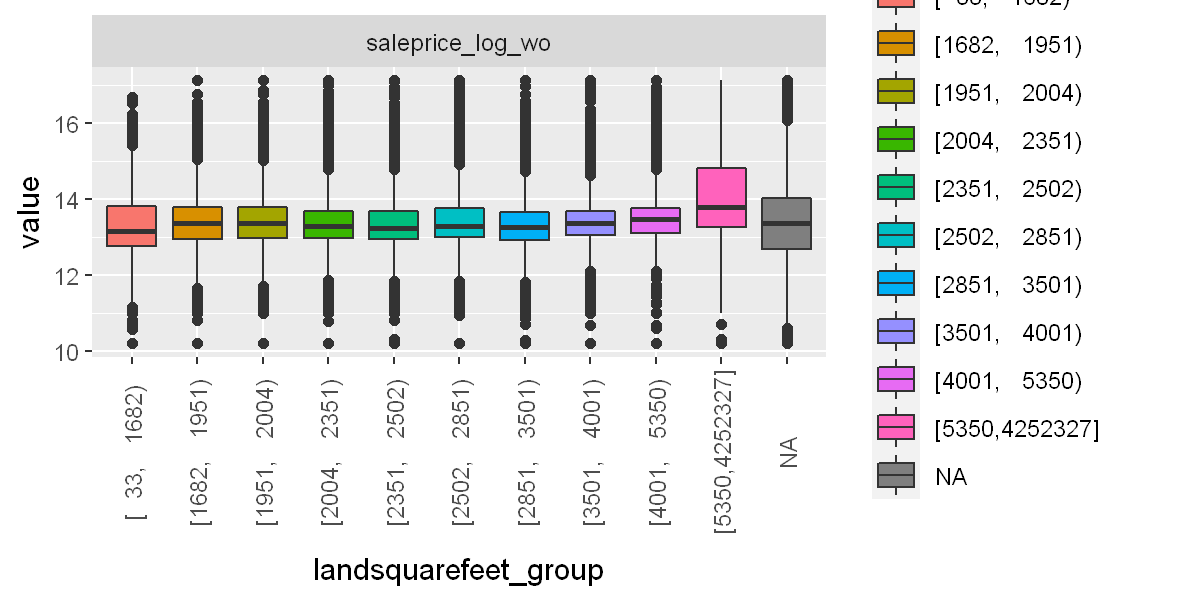

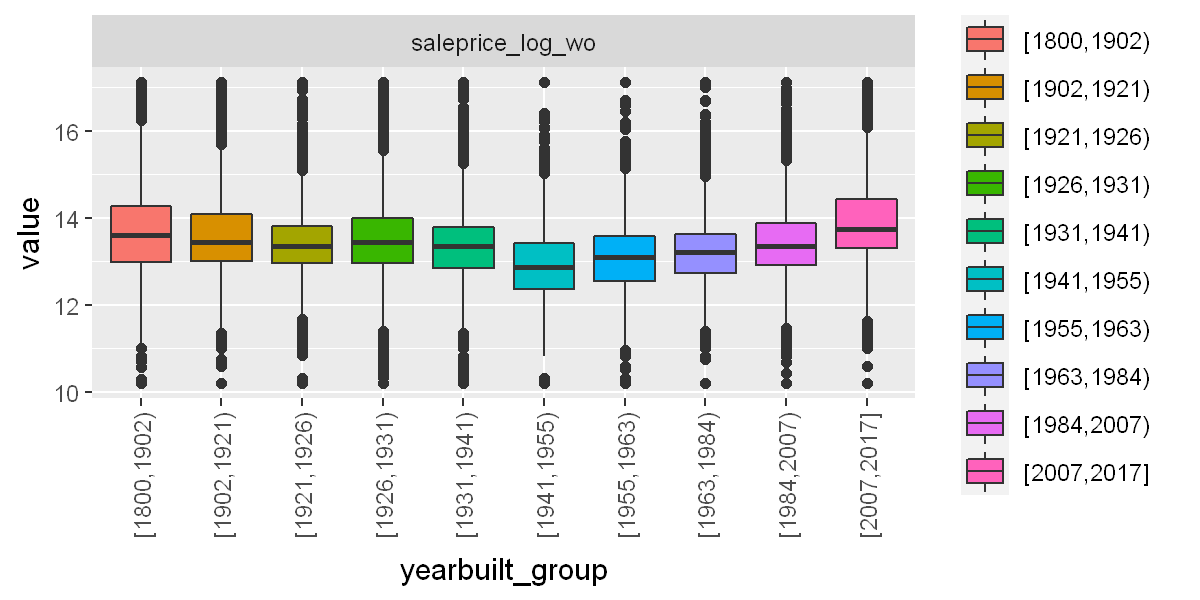

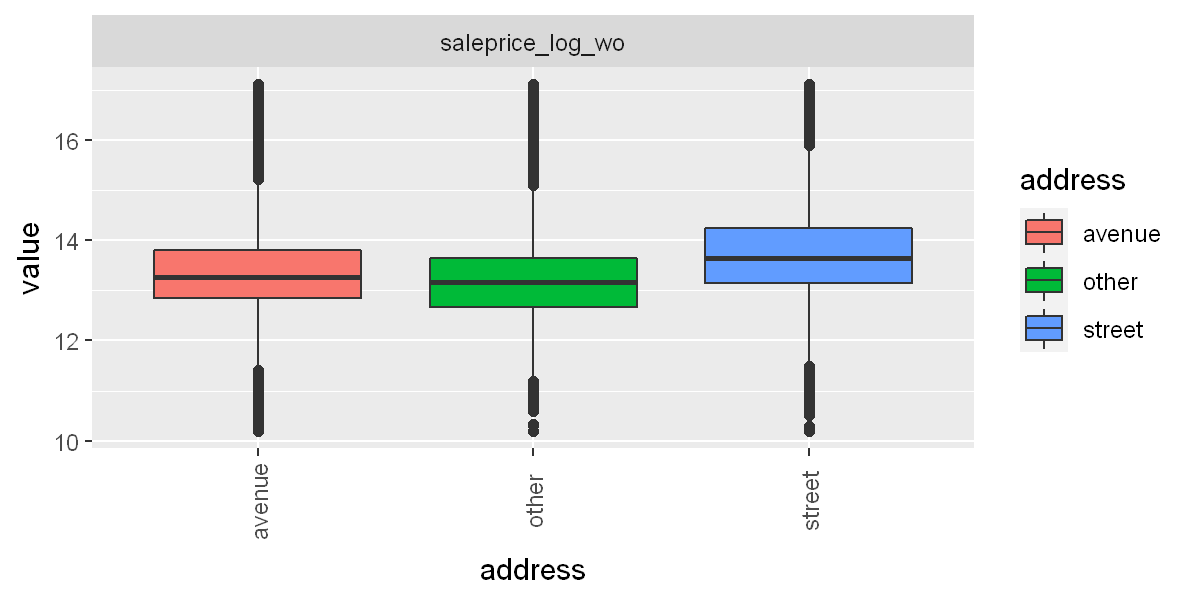

In [67]:
id_cols = c("residential_group","commerical_group","totalunit_group","borough","taxclass_present","b_class_present","b_class_group","grosssquarefeet_group","grosssquarefeet_log_group","landsquarefeet_group","yearbuilt_group","address")
selected_cols = c('saleprice_log_wo')

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
for(i in id_cols){
    print(draw_boxplot(dt_c,id_col = i, selected_cols))
}

In [68]:
dt_c[,totalunits_group := ifelse(totalunits<4,totalunits,4)]
dt_c[,commercialunits_group := ifelse(commercialunits<2,commercialunits,2)]
dt_c[,yearbuilt_group := Hmisc::cut2(yearbuilt, g = 5)]
dt_c[,grosssquarefeet_log_group := Hmisc::cut2(grosssquarefeet_log, g = 5)]
dt_c[,saleprice_log_wo_group := Hmisc::cut2(saleprice_log_wo,g = 5),.(borough)]


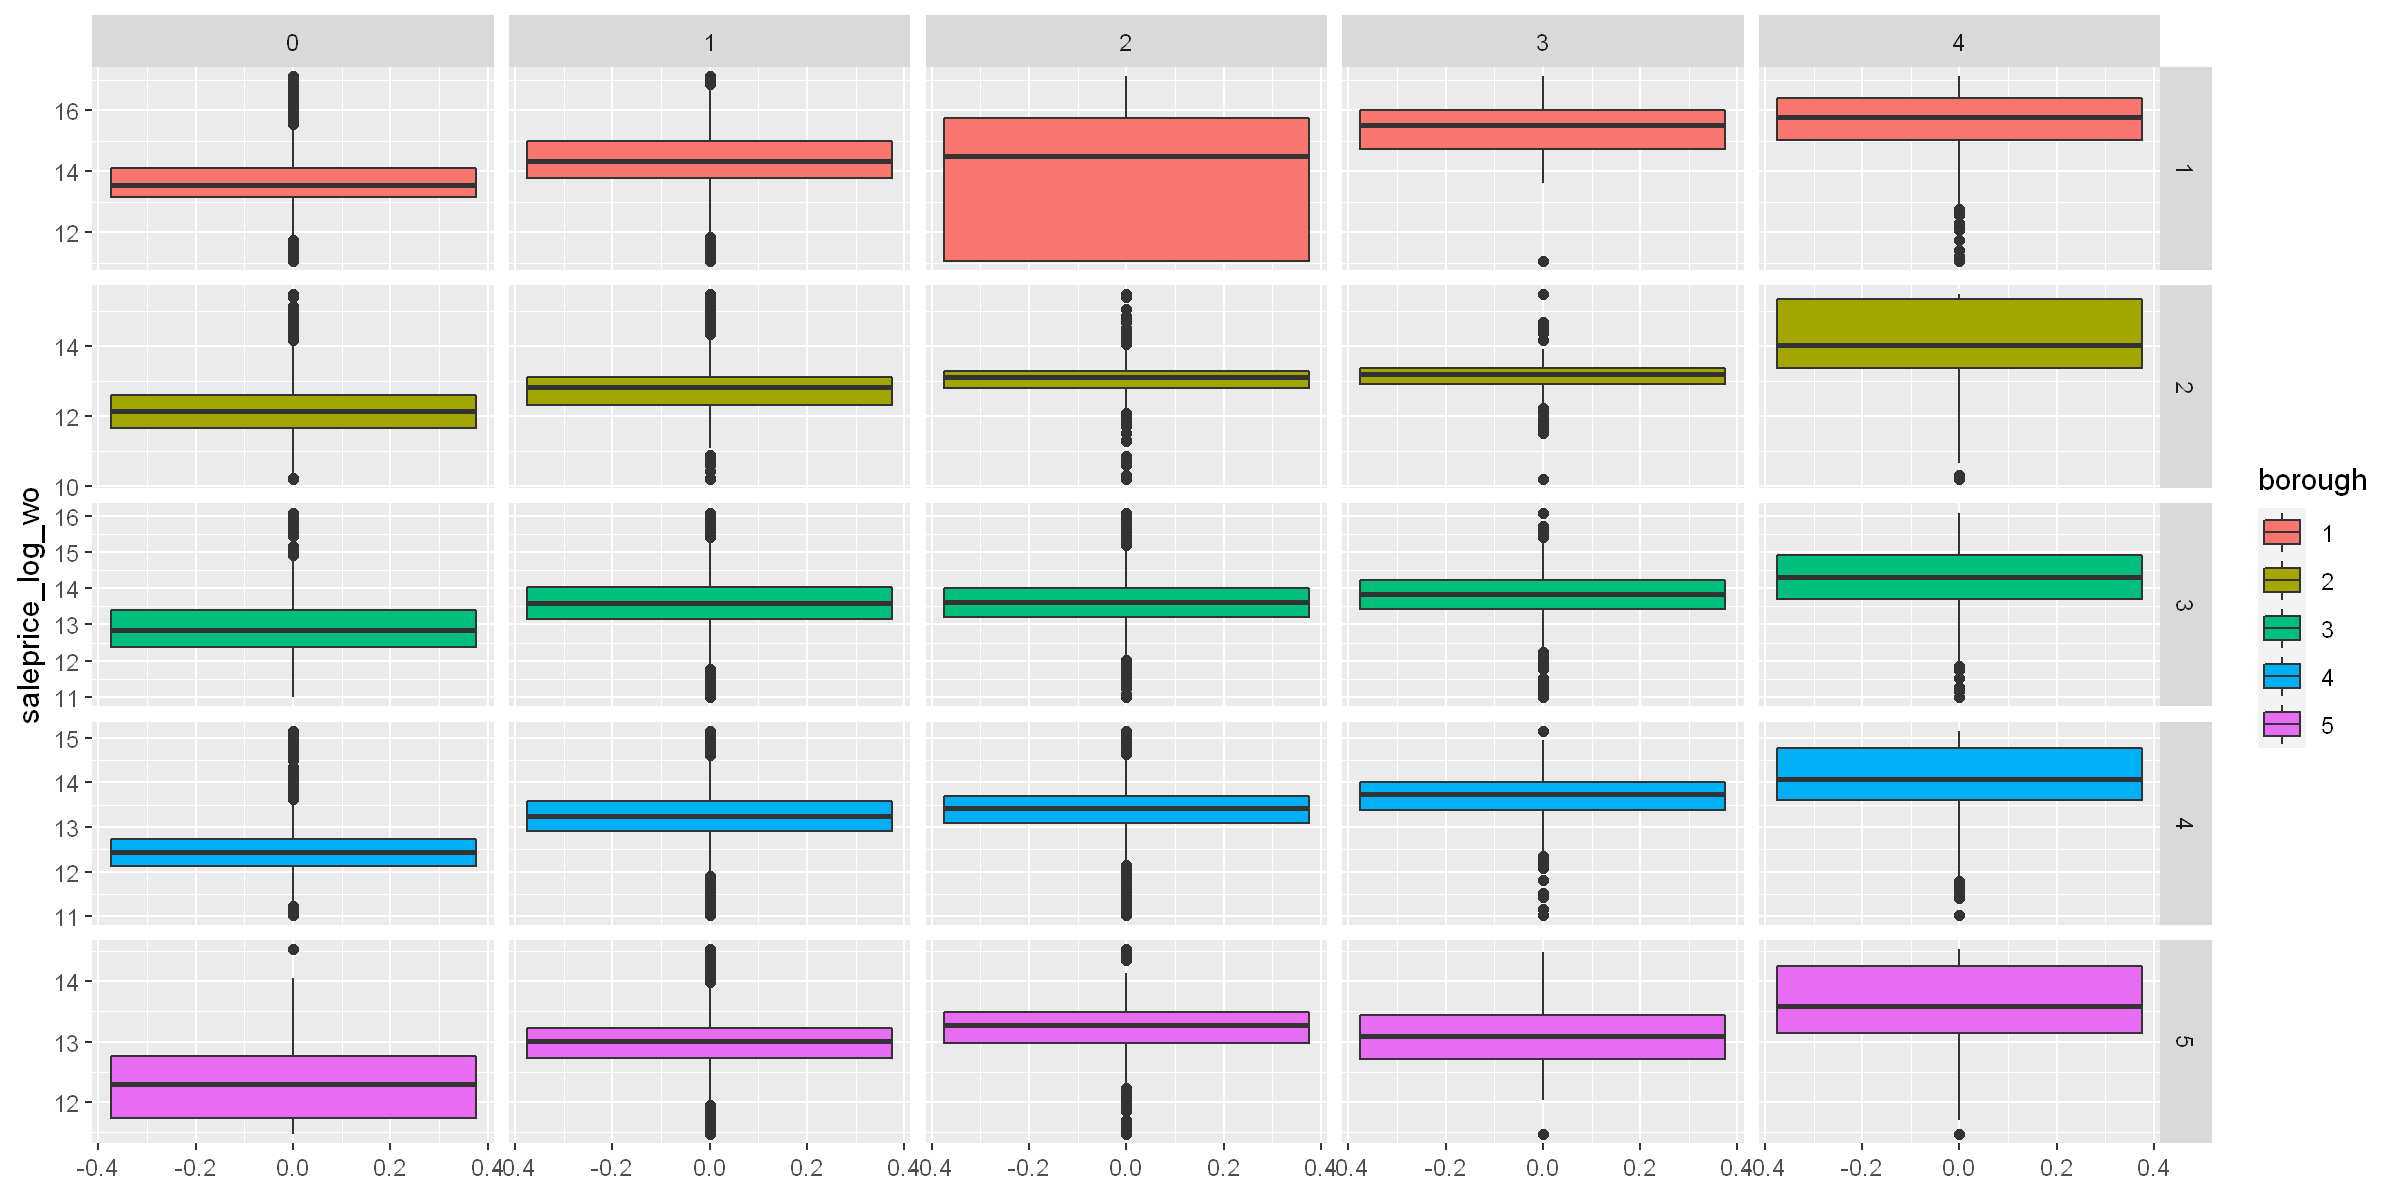

In [69]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(data = dt_c, aes(y = saleprice_log_wo, fill = borough)) + 
    geom_boxplot() +
    facet_grid(borough ~ totalunits_group,scales = "free")

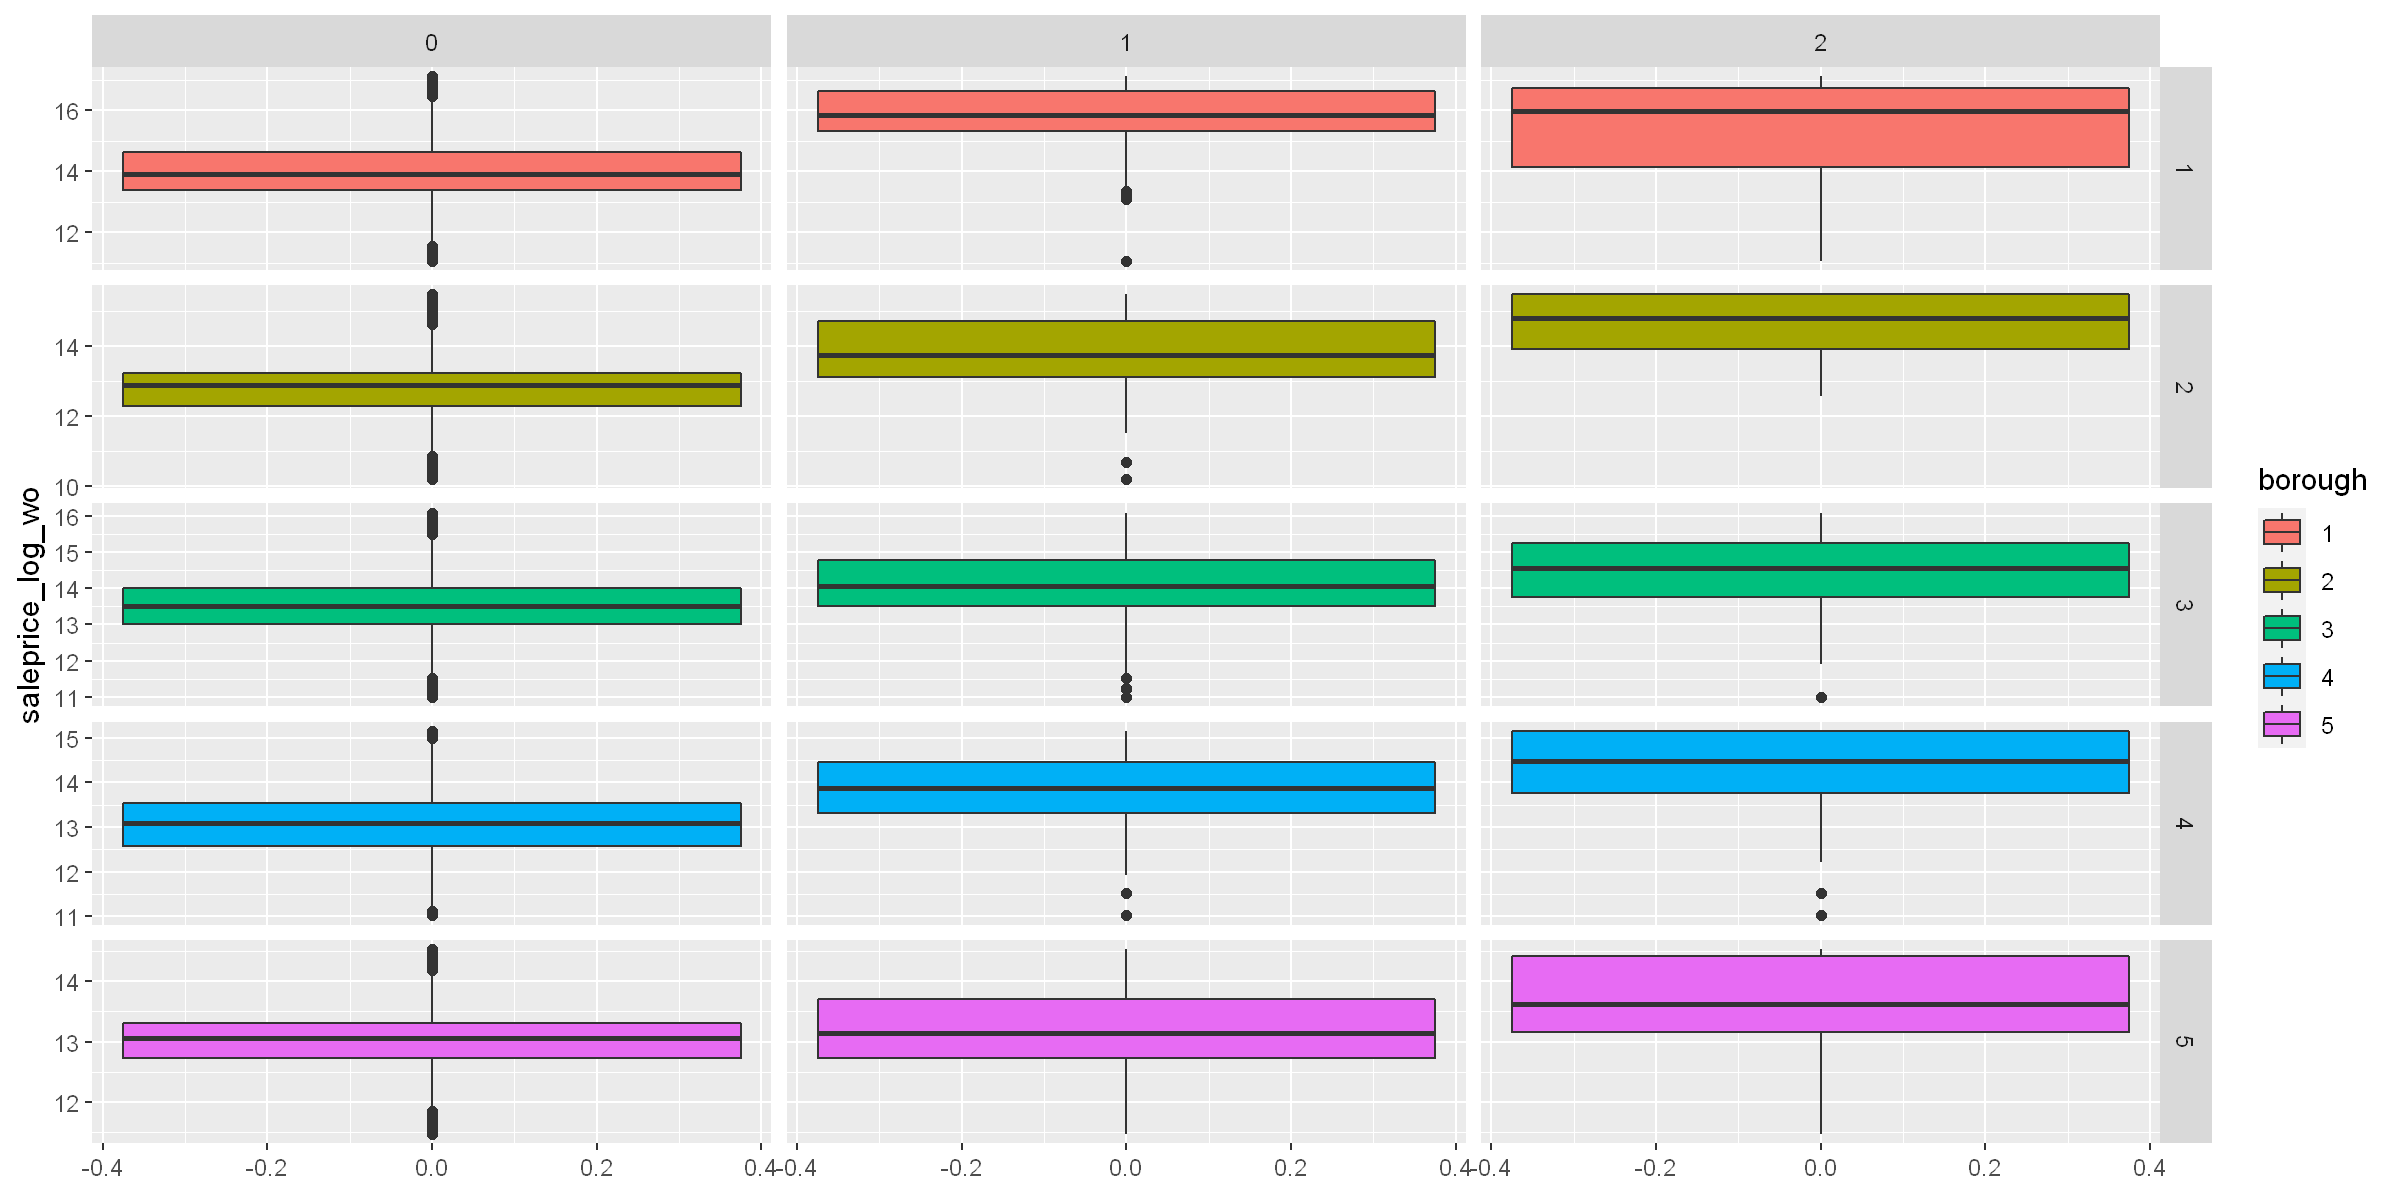

In [70]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(data = dt_c, aes(y = saleprice_log_wo, fill = borough)) + 
    geom_boxplot() +
    facet_grid(borough ~ commercialunits_group,scales = "free")

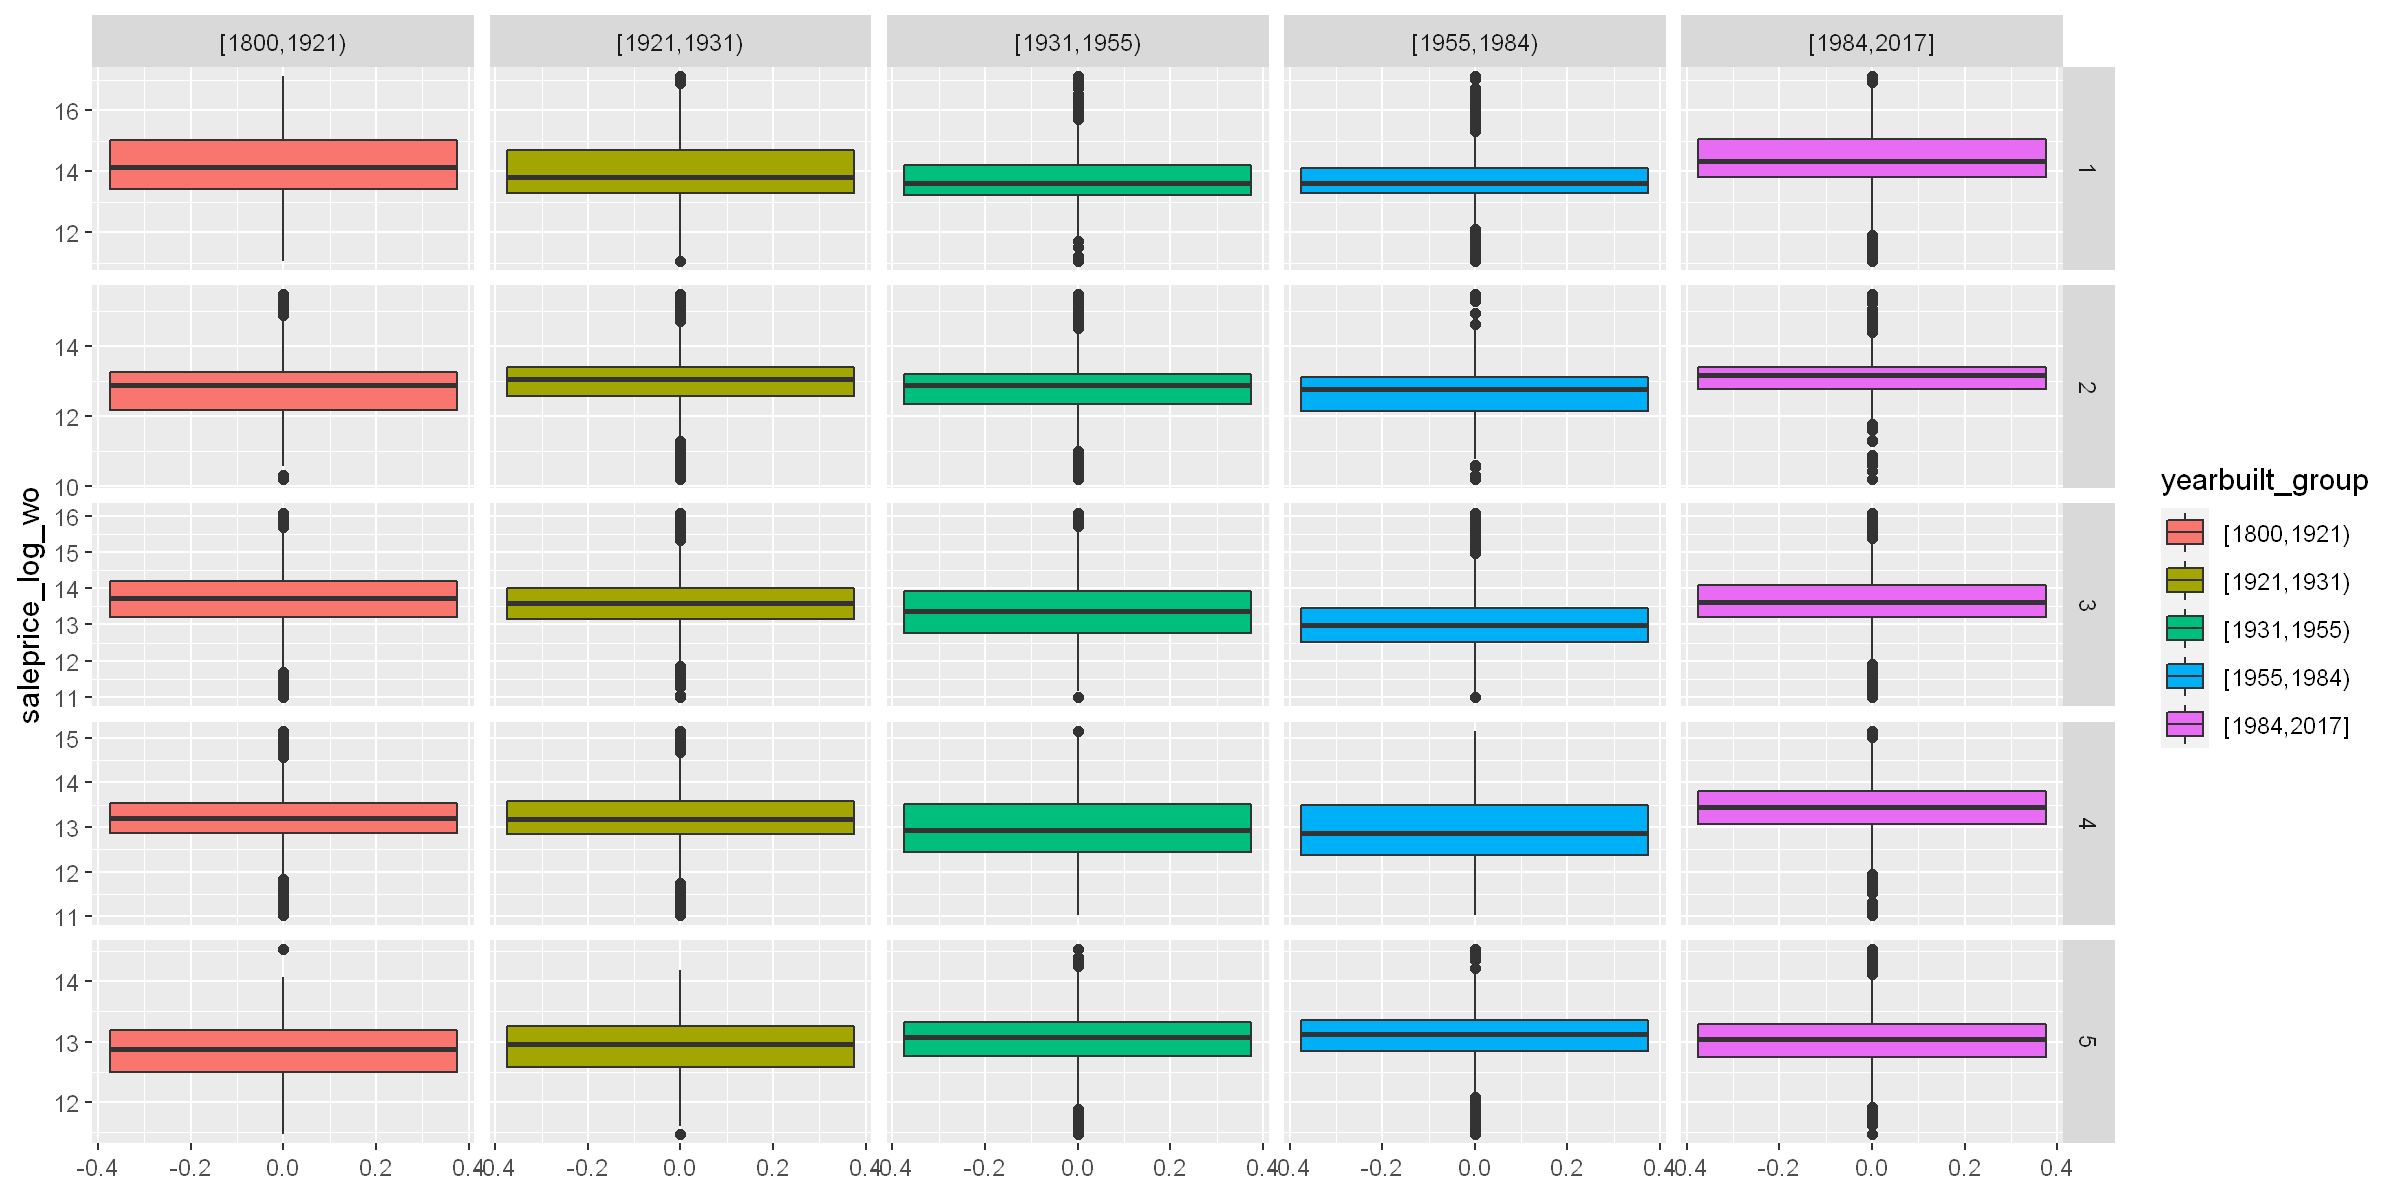

In [71]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(data = dt_c, aes(y = saleprice_log_wo, fill = yearbuilt_group)) + 
    geom_boxplot() +
    facet_grid(borough ~ yearbuilt_group,scales = "free")

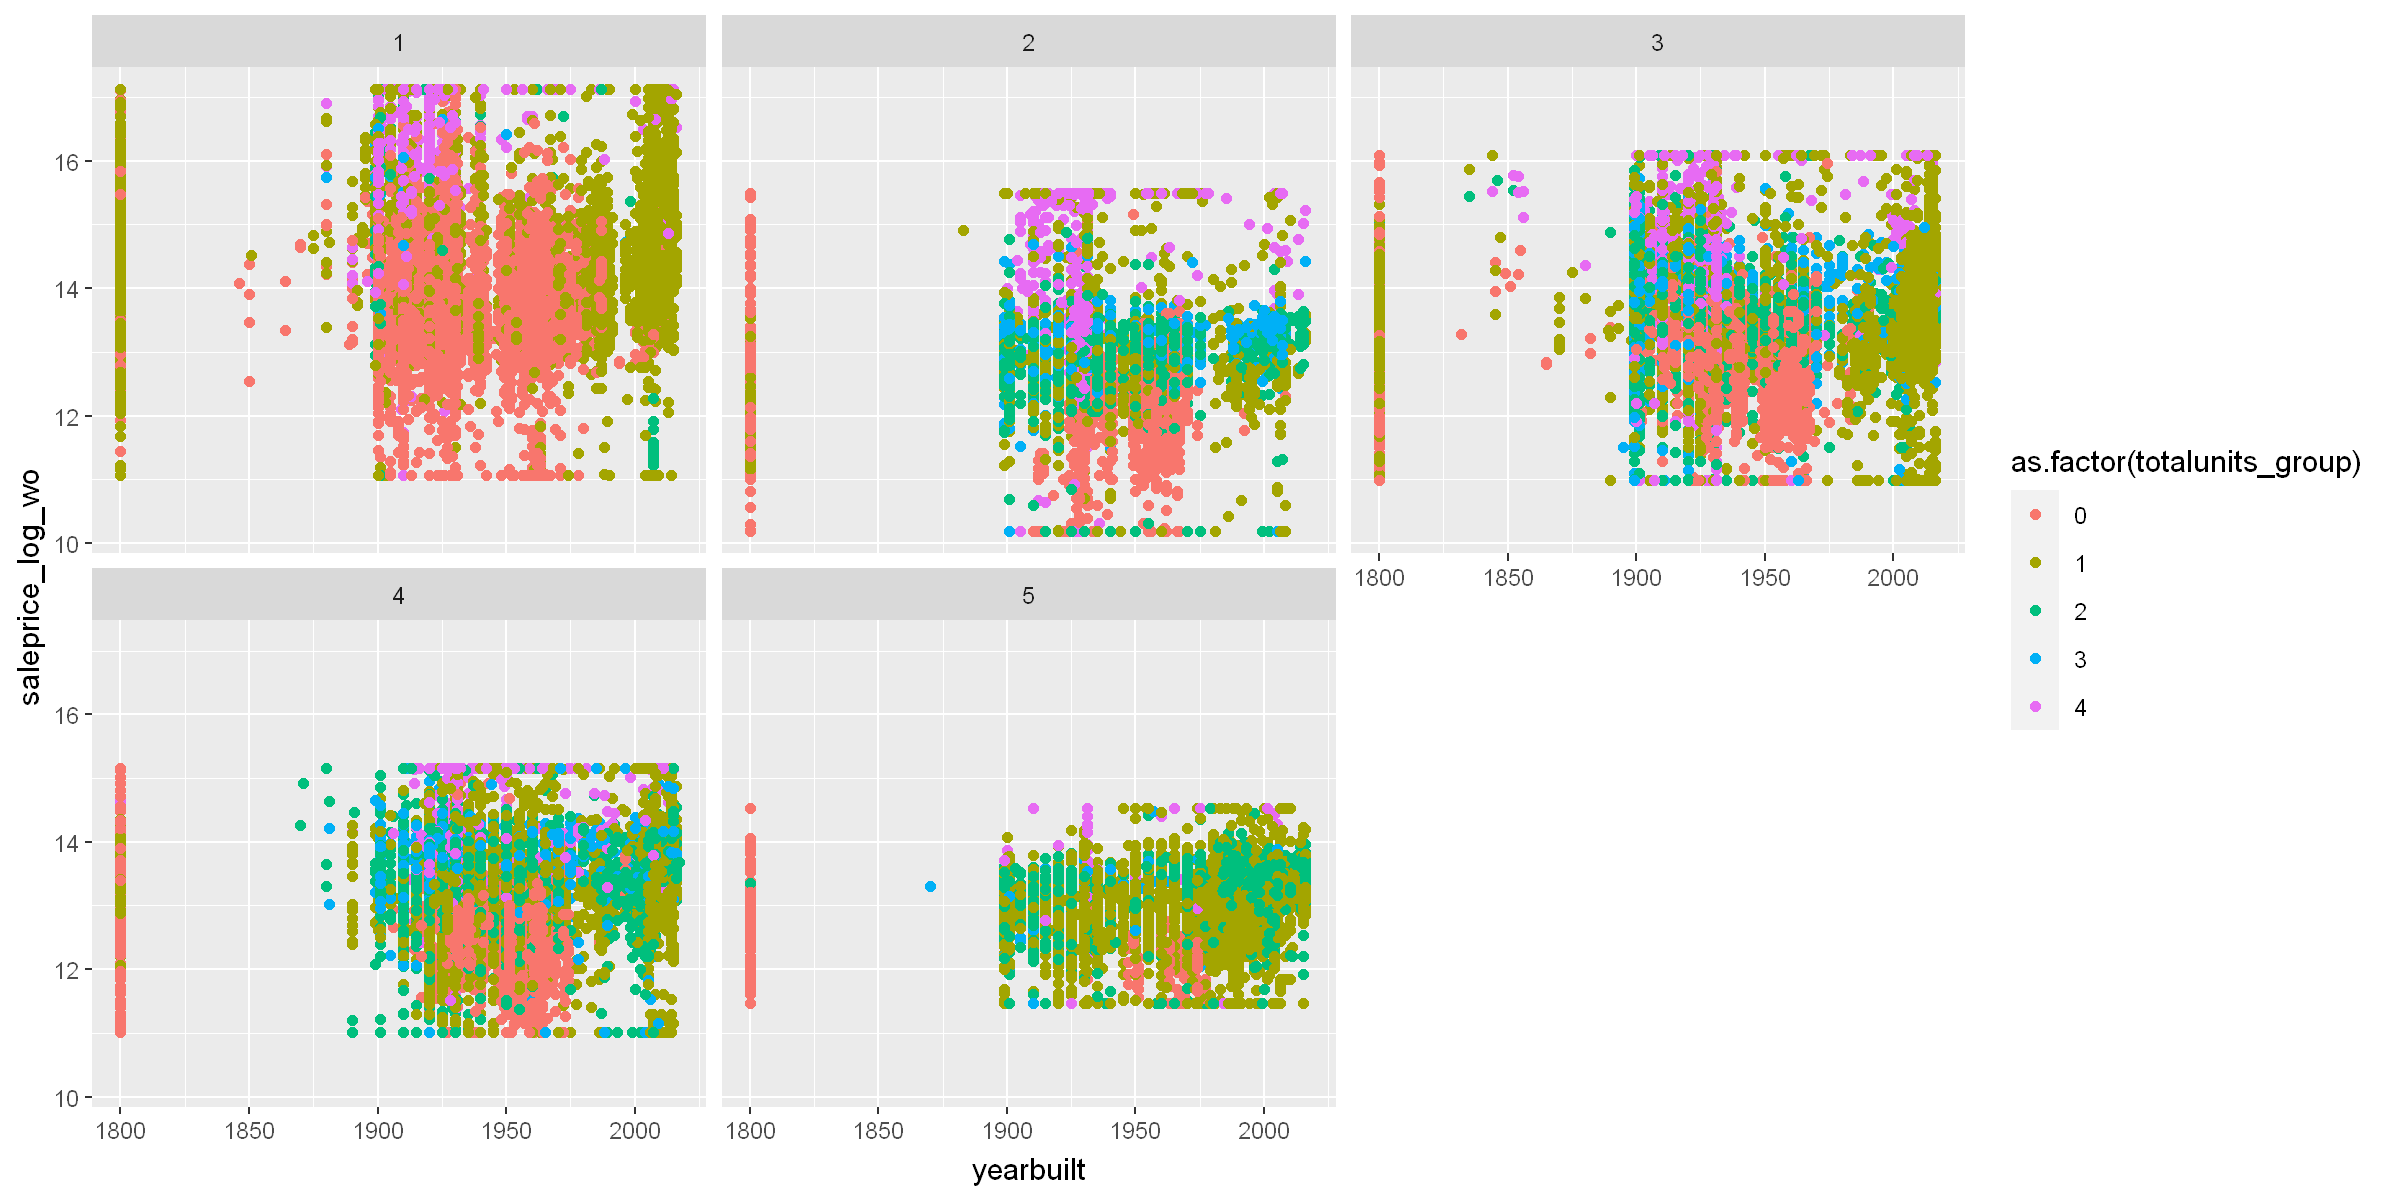

In [72]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(dt_c, aes(x = yearbuilt, y = saleprice_log_wo, fill = as.factor(totalunits_group), color = as.factor(totalunits_group))) + geom_point() + facet_wrap(~borough) 

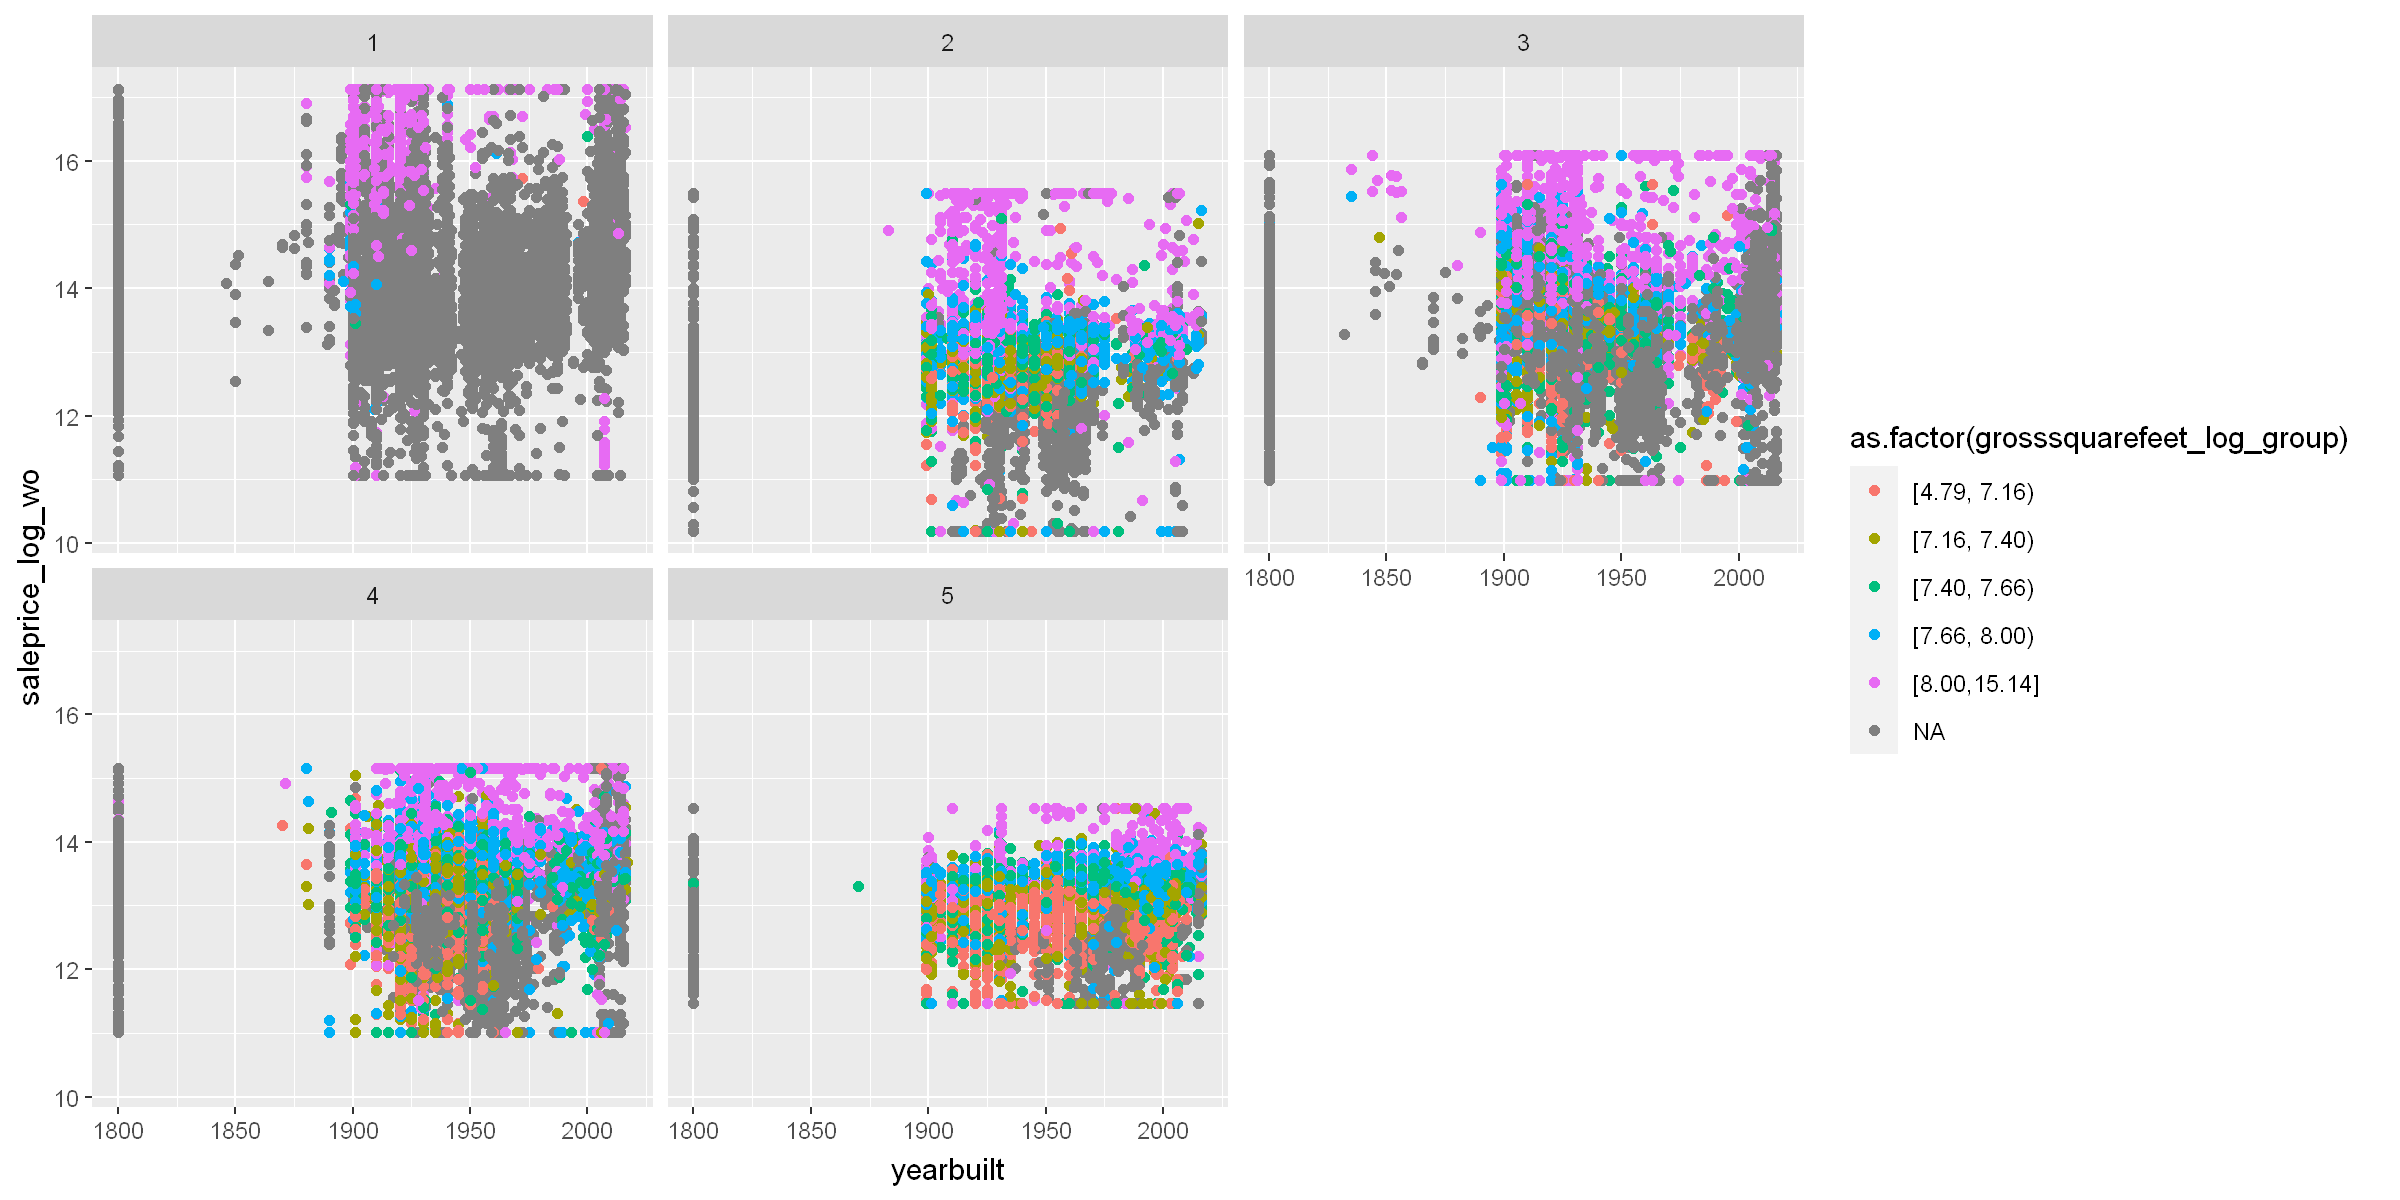

In [73]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(dt_c, aes(x = yearbuilt, y = saleprice_log_wo, fill = as.factor(grosssquarefeet_log_group), color = as.factor(grosssquarefeet_log_group))) + geom_point() + facet_wrap(~borough) 

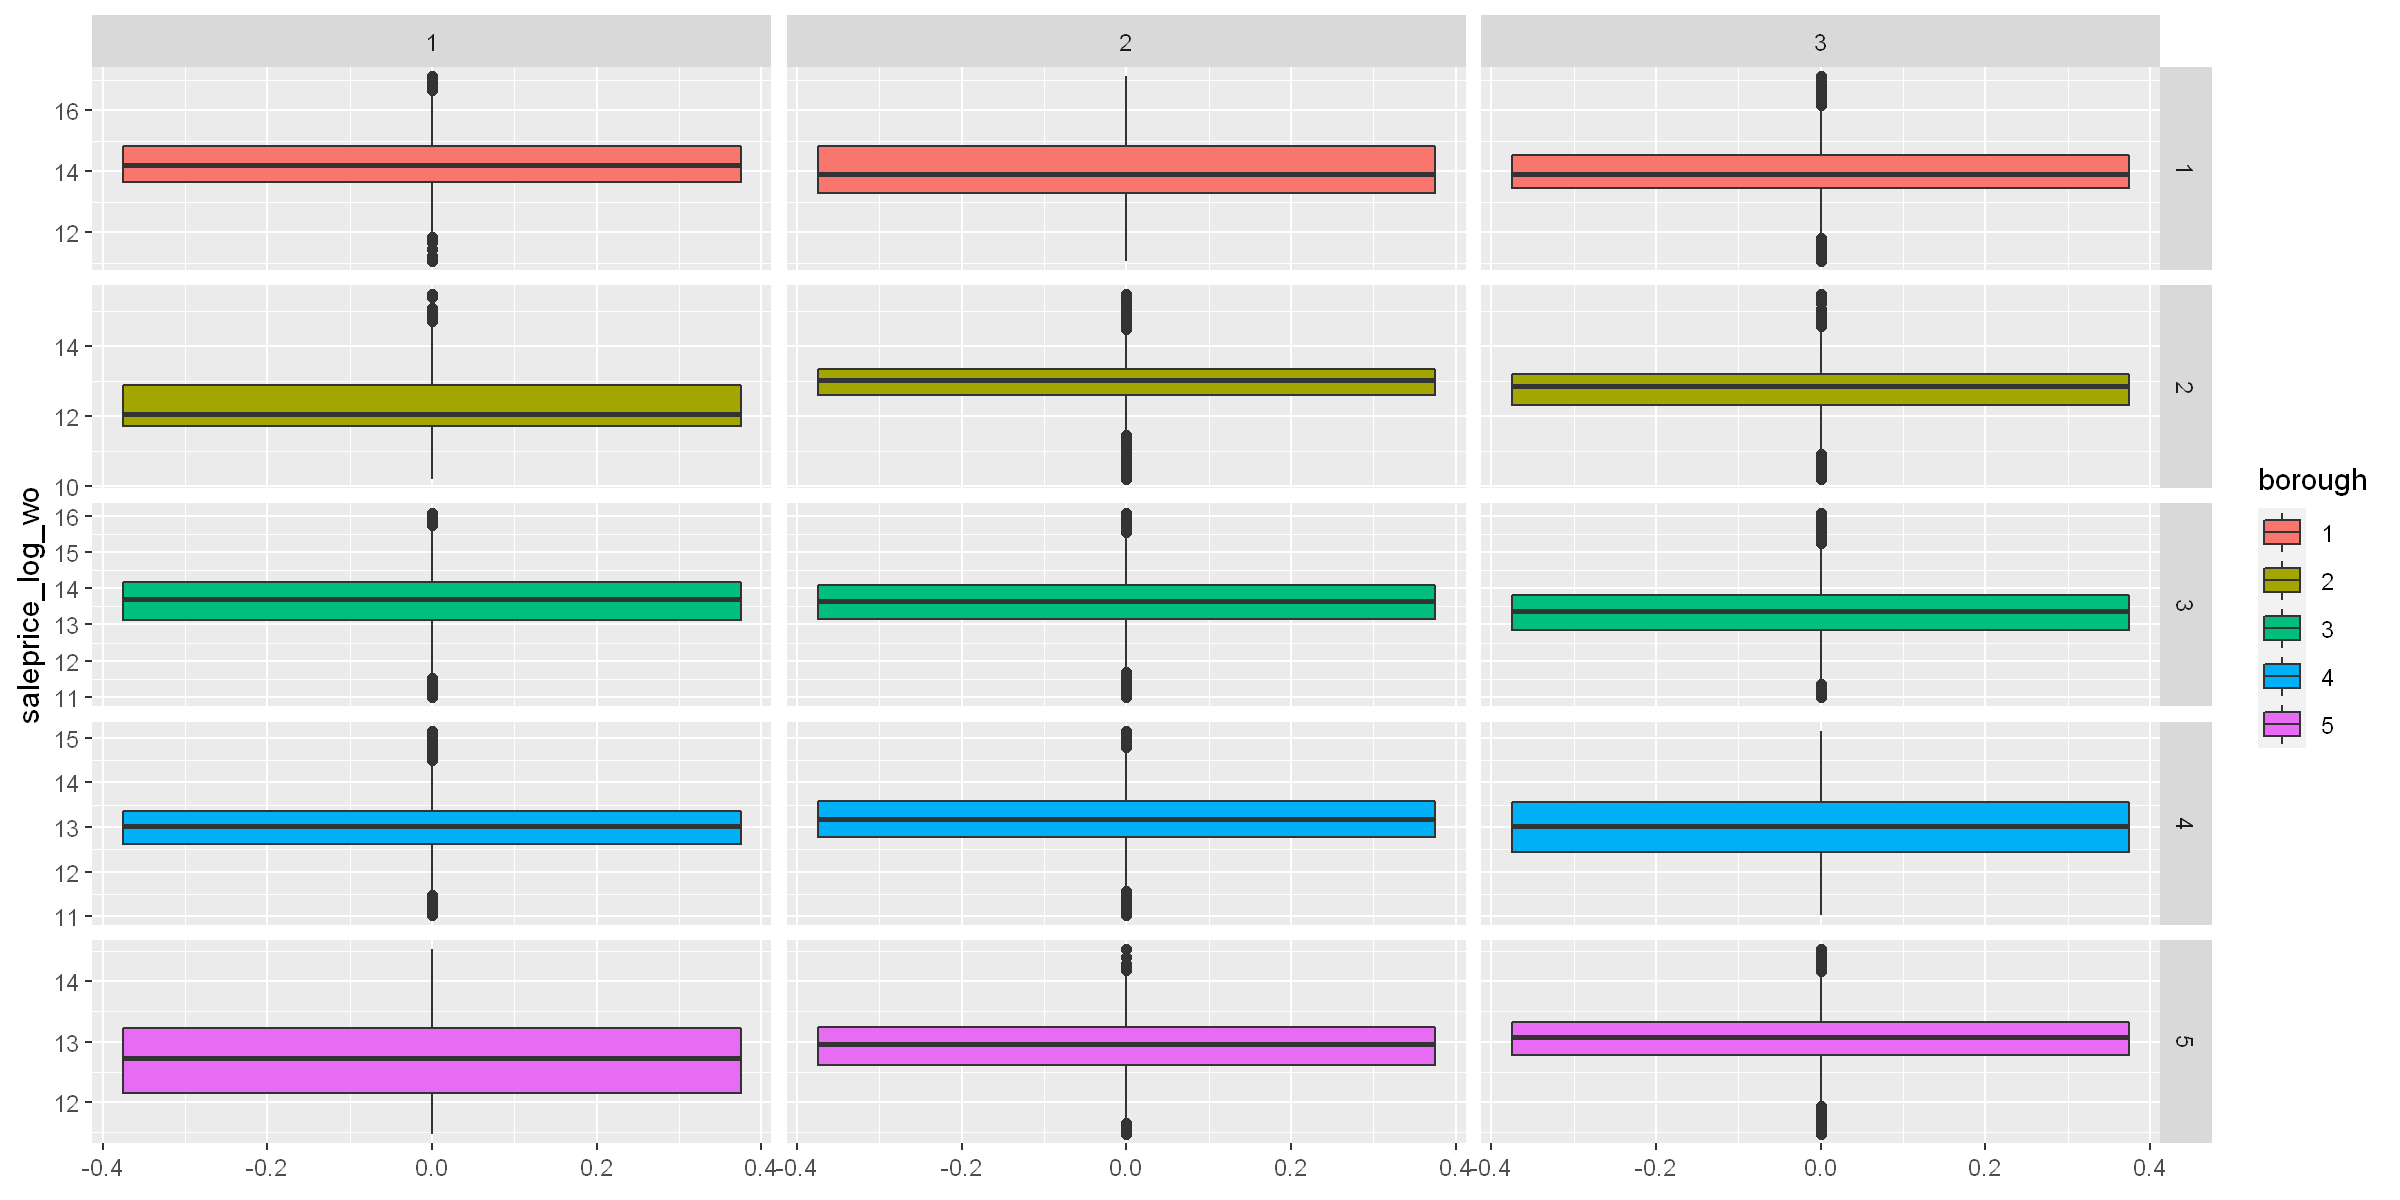

In [74]:
dt_c[, yearbuilt_group := ifelse(yearbuilt < 1900,1,ifelse(yearbuilt < 1950,2,3))]

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(data = dt_c, aes(y = saleprice_log_wo, fill = borough)) + 
    geom_boxplot() +
    facet_grid(borough ~ yearbuilt_group,scales = "free")

Not an obvious finding regarding yearbuilt. But it can be connected with other features.

#### Filling gross square feet

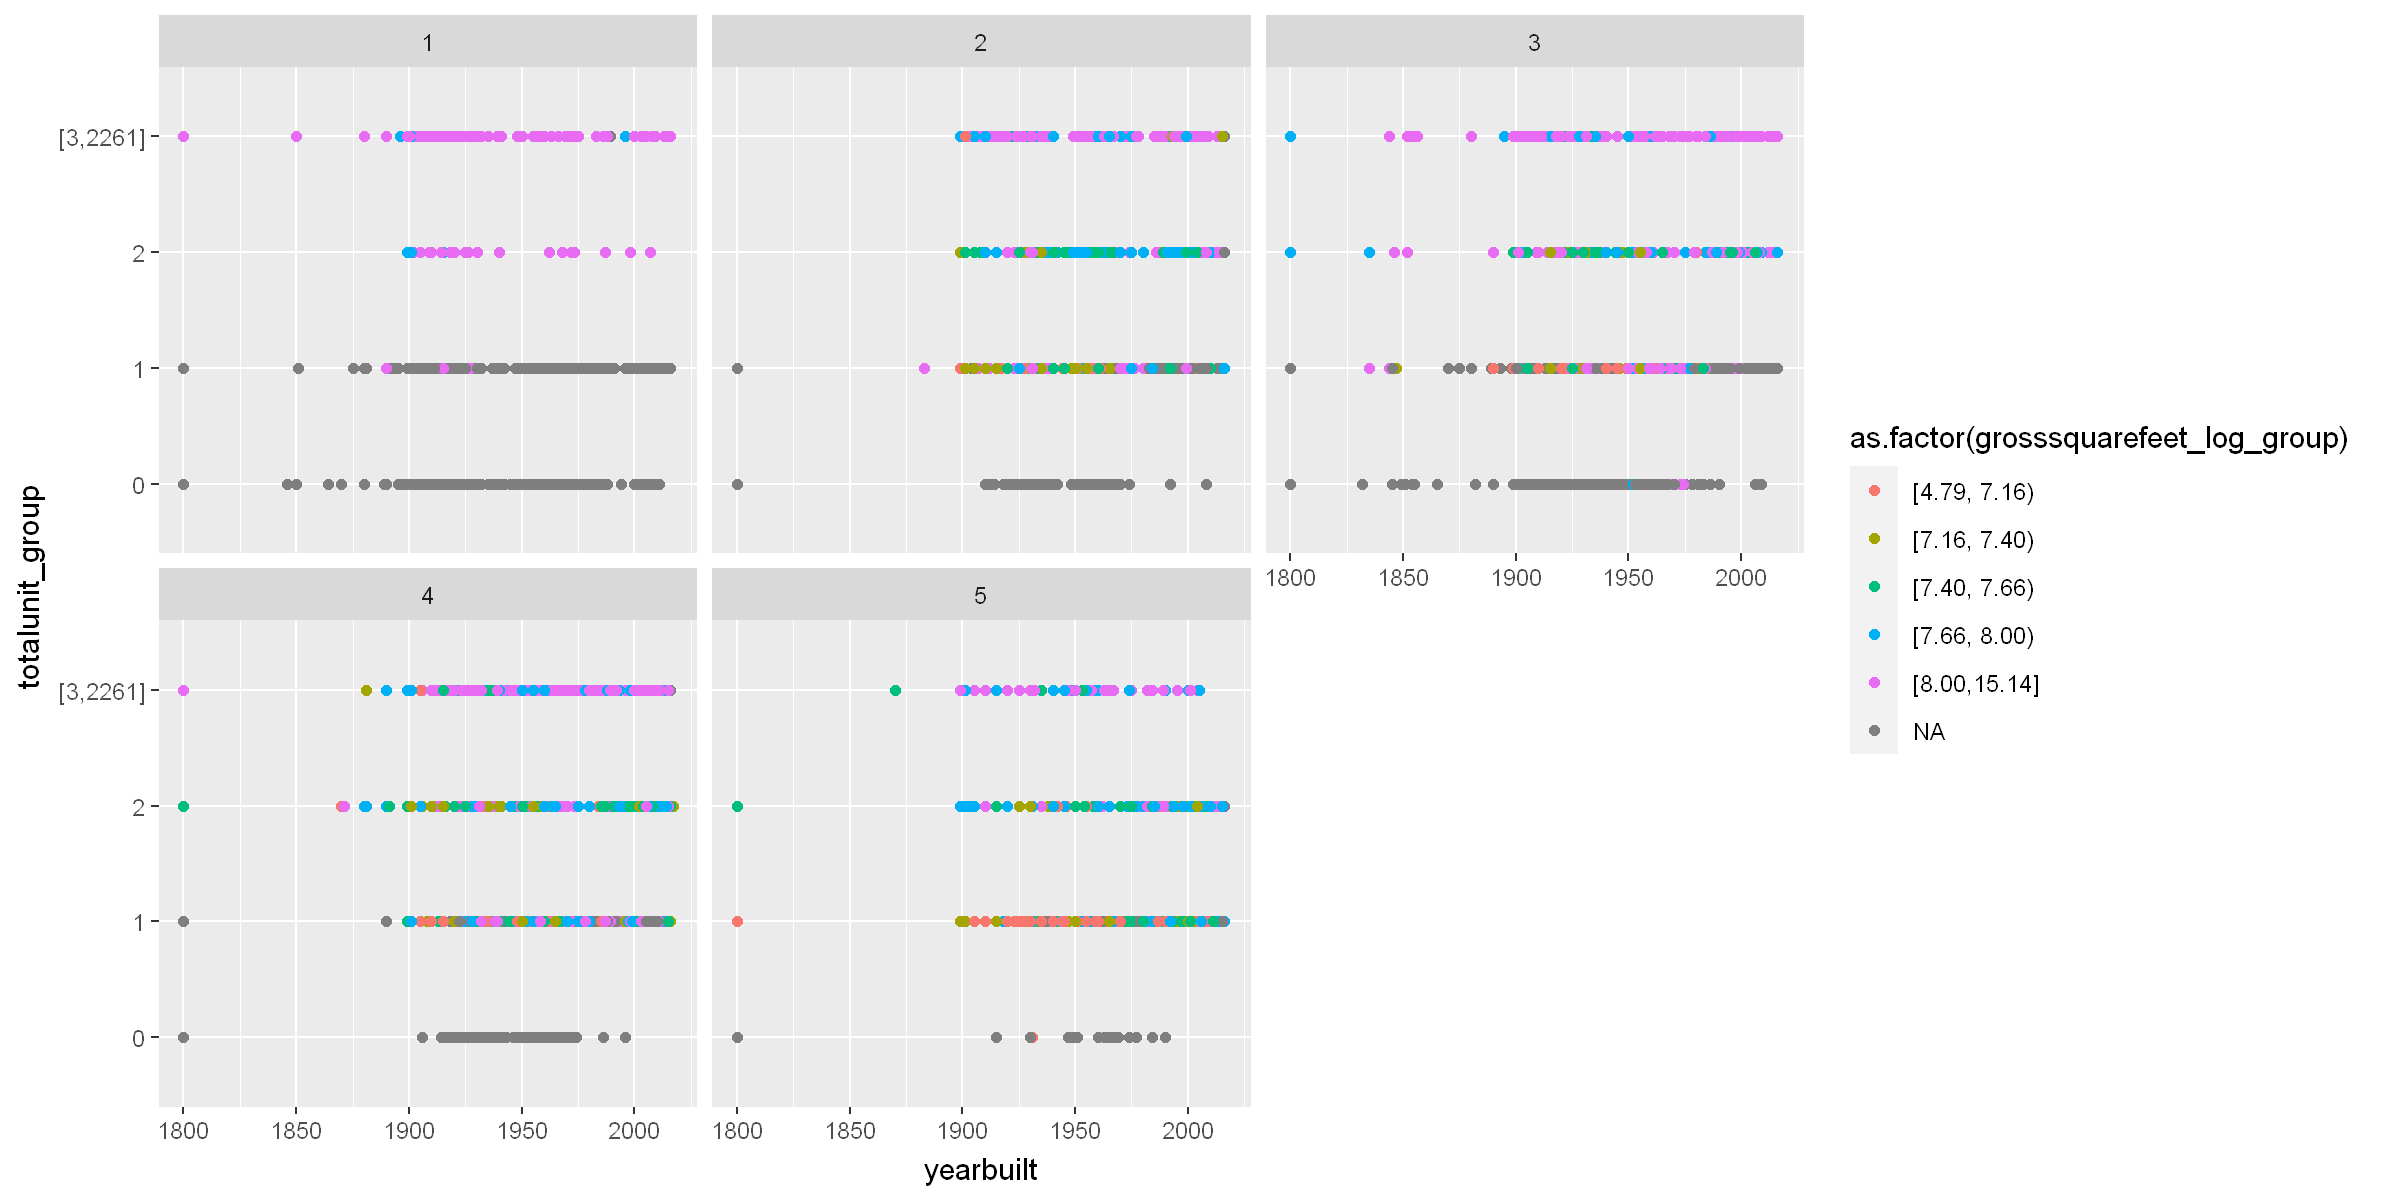

In [75]:
ggplot(dt_c, aes(x = yearbuilt, y = totalunit_group, fill = as.factor(grosssquarefeet_log_group), color = as.factor(grosssquarefeet_log_group))) + geom_point() + facet_wrap(~borough) 

Warning message:
"Removed 29543 rows containing non-finite values (stat_density)."


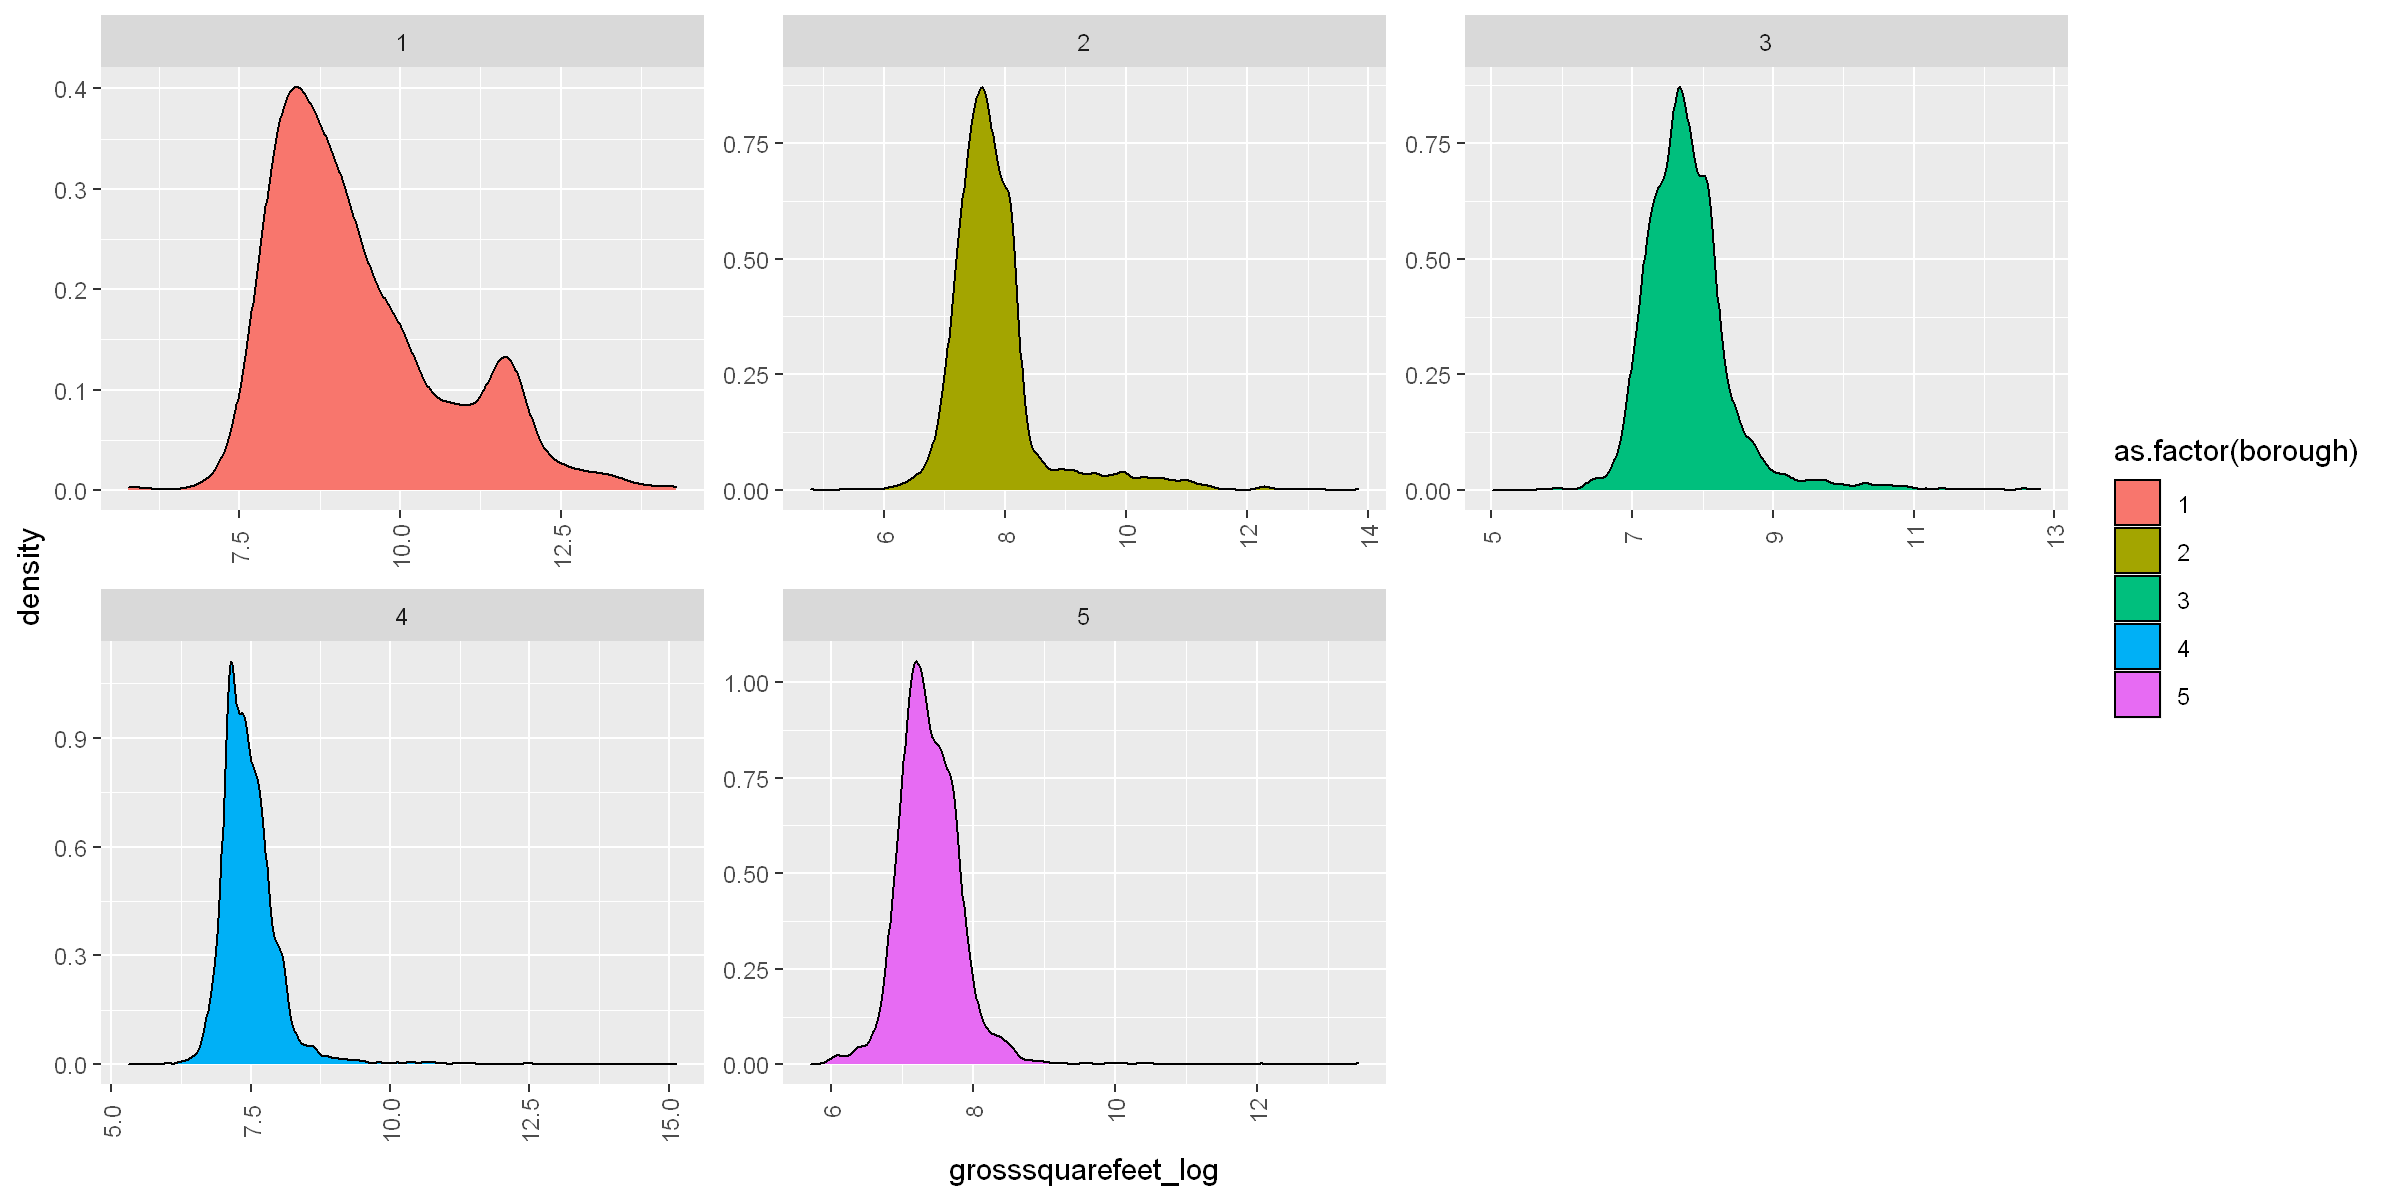

In [76]:
ggplot(data = dt_c ,aes(x = grosssquarefeet_log, fill = as.factor(borough)))+ 
  facet_wrap( ~ borough, scales ="free") + 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

In [77]:
#tempData <- mice(dt_c[,.(borough,yearbuilt_group,address,grosssquarefeet,zipcode)] ,m=5,maxit=50,meth='pmm',seed=500)
#completedData <- complete(tempData,1)
dt_c[,grosssquarefeet_log_filled := grosssquarefeet_log]
dt_c[,grosssquarefeet_log_filled := fill_missing(grosssquarefeet_log_filled,method = "mean"),.(borough,totalunit_group)]

#dt_c[,grosssquarefeet_filled := completedData$grosssquarefeet]

dt_c[,grosssquarefeet_log_group := Hmisc::cut2(grosssquarefeet_log_filled, g = 5)]

In [78]:
table(dt_c$grosssquarefeet_log_group)


[4.79, 7.27) [7.27, 7.54) [7.54, 8.20) [8.20, 8.89) [8.89,15.14] 
       12305        10960        13468        12992         8378 

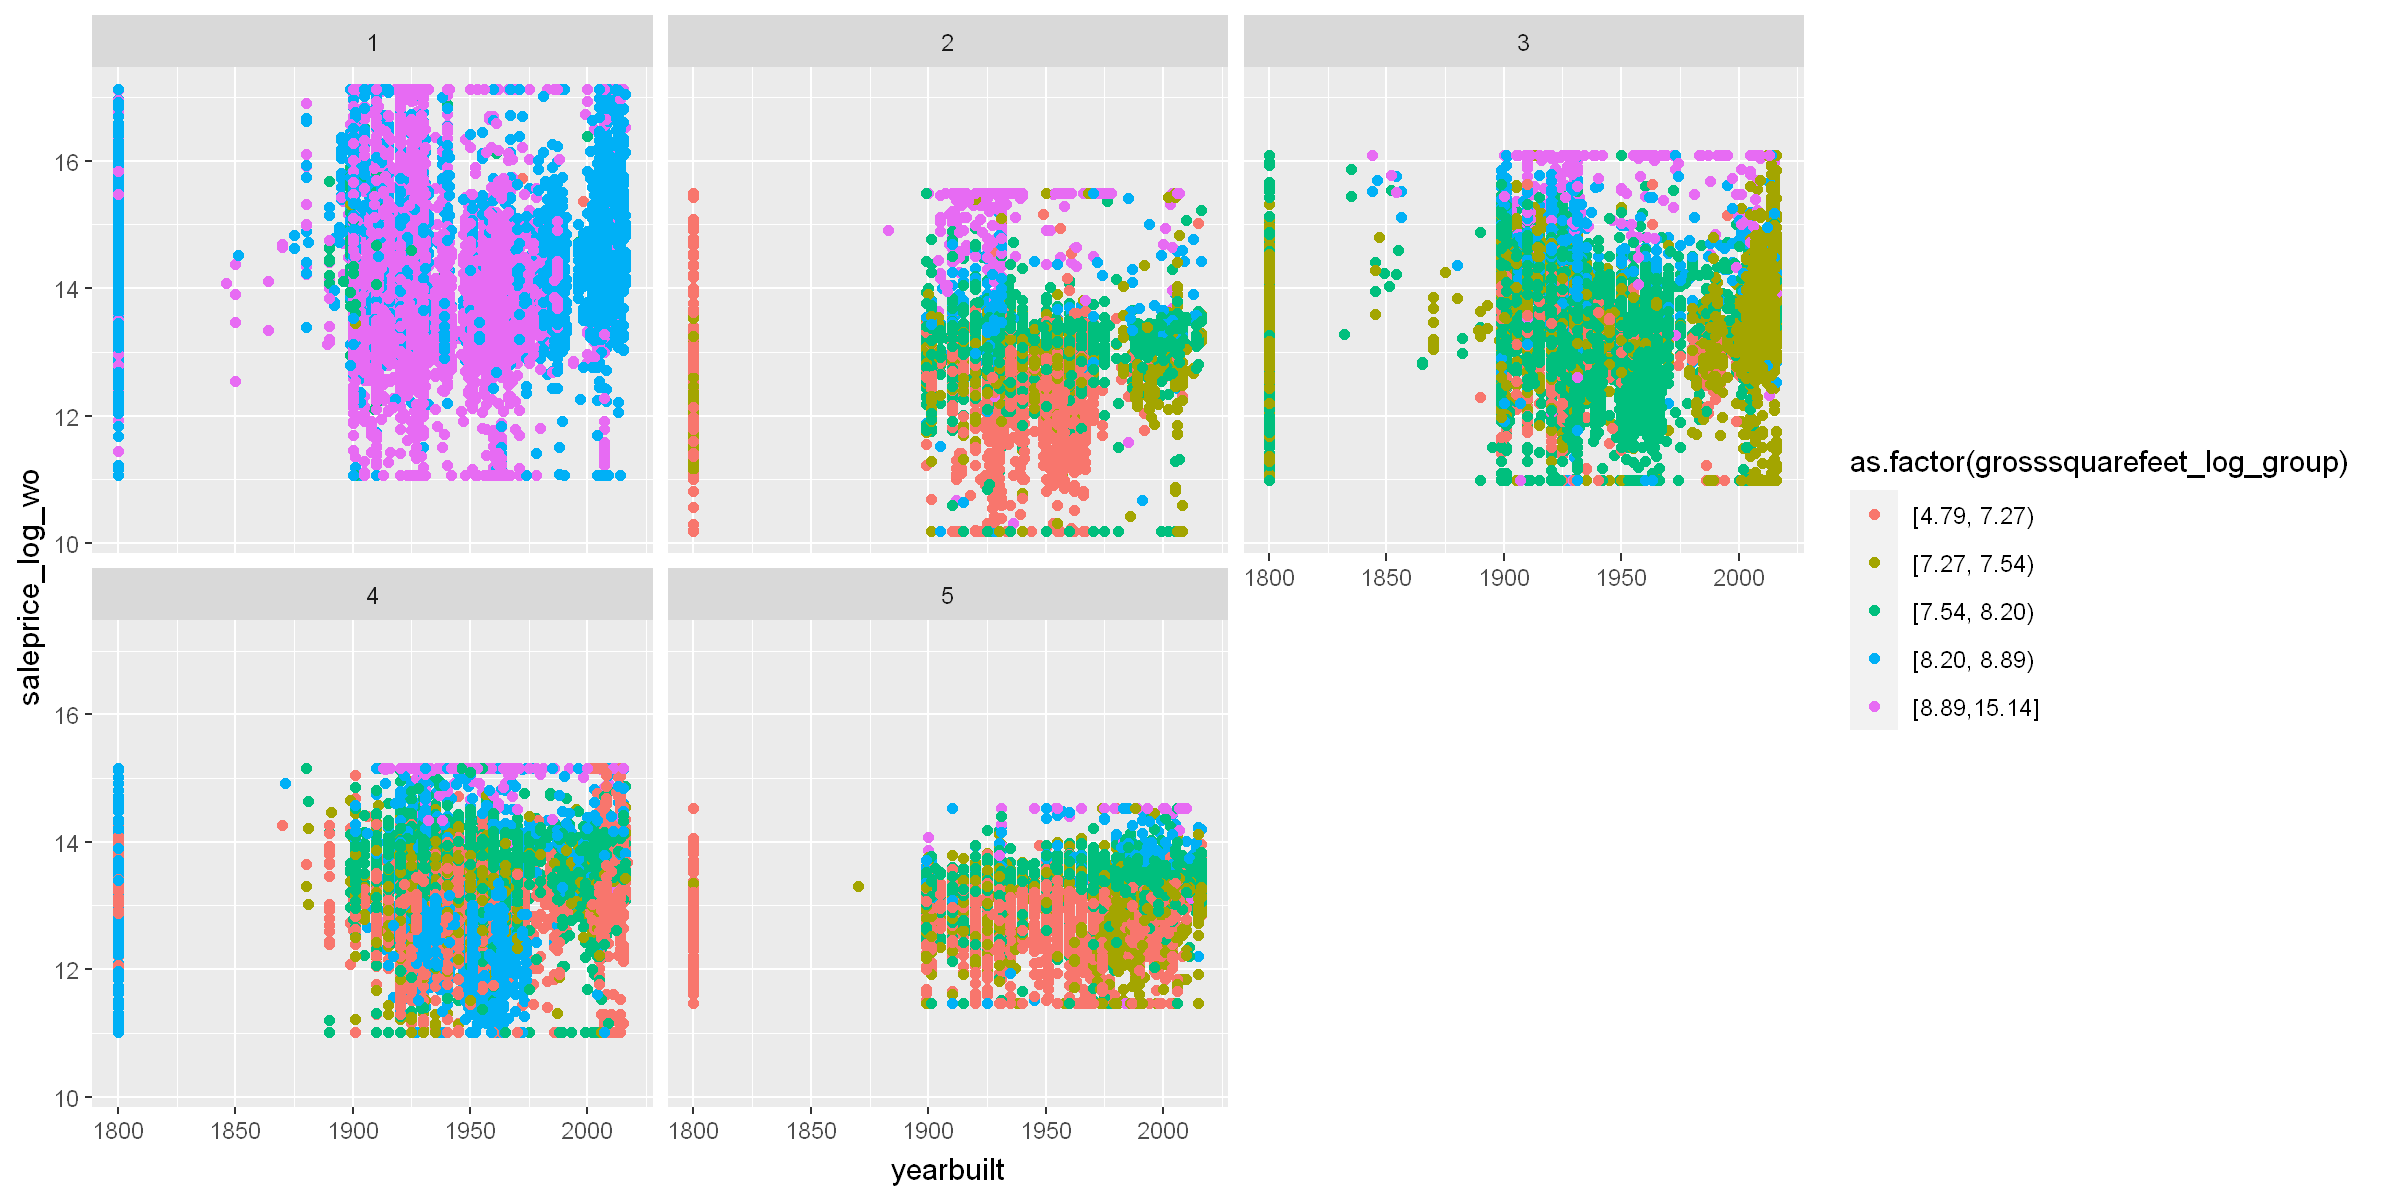

In [79]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggplot(dt_c, aes(x = yearbuilt, y = saleprice_log_wo, fill = as.factor(grosssquarefeet_log_group), color = as.factor(grosssquarefeet_log_group))) + geom_point() + facet_wrap(~borough) 

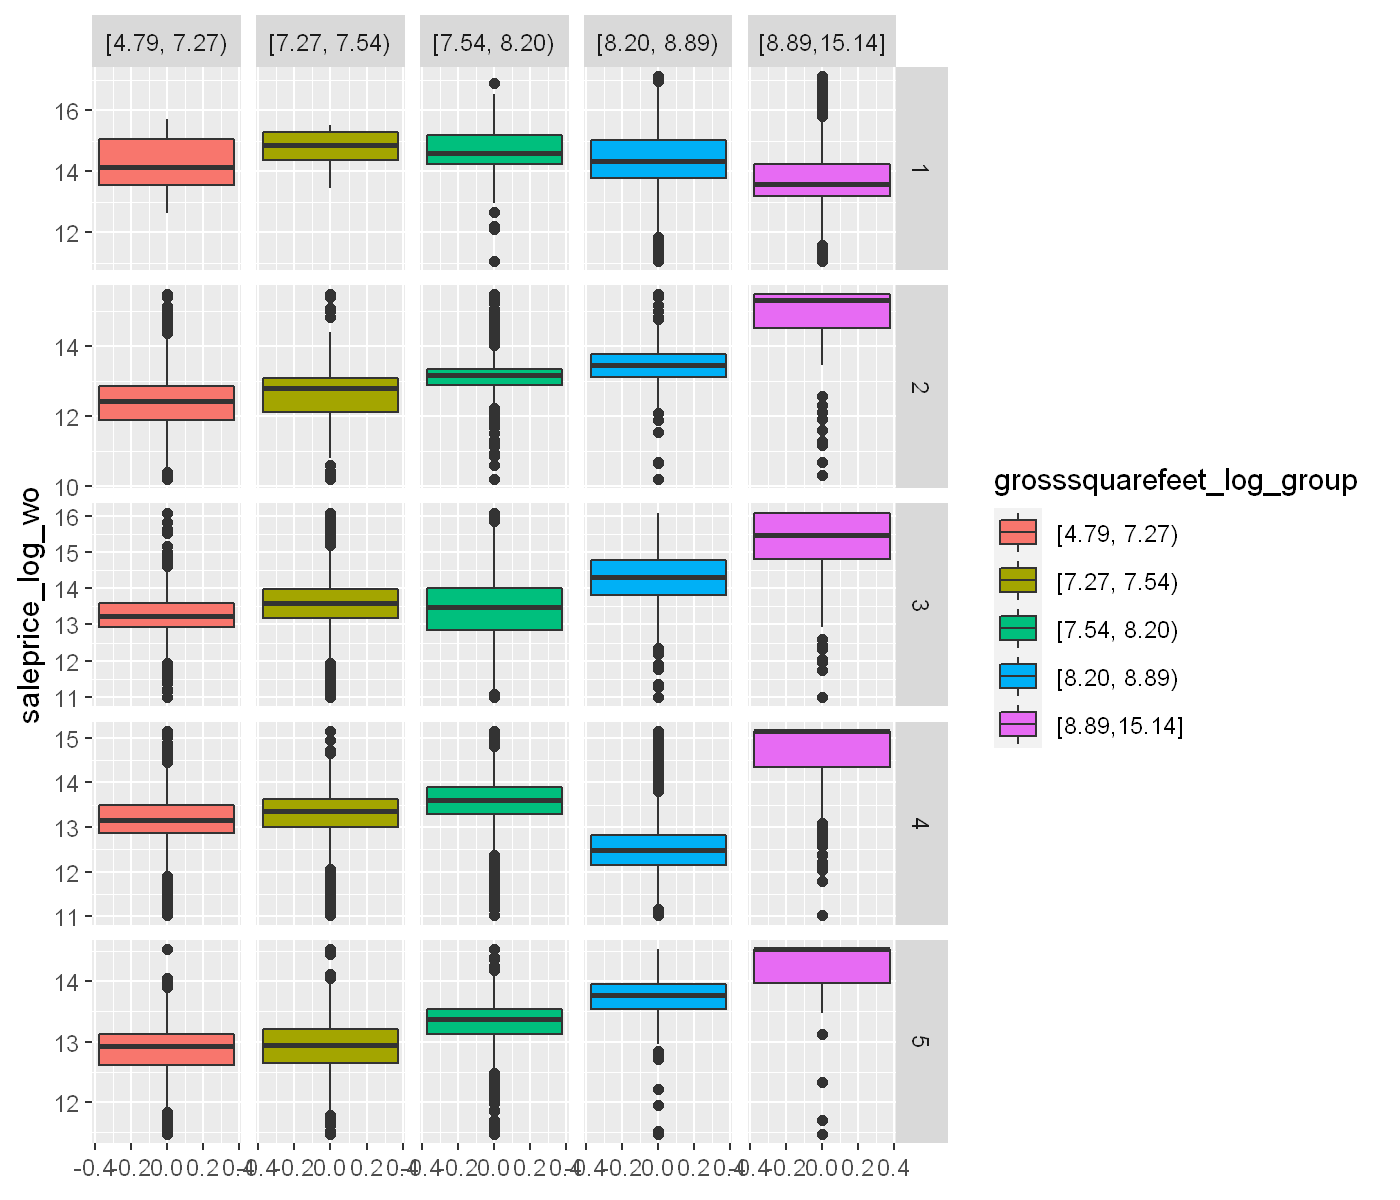

In [80]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 200)
ggplot(data = dt_c, aes(y = saleprice_log_wo, fill = grosssquarefeet_log_group)) + 
    geom_boxplot() +
    facet_grid(borough ~ grosssquarefeet_log_group,scales = "free")

### Several Transformations

In [81]:
dt[, saleprice_log := log(saleprice)]
dt[, saleprice_wo := tend_outliers_keep(saleprice, sigma = 3),.(borough)]
dt[, saleprice_wo_log := log(saleprice_wo)]
dt[, saleprice_log_wo := tend_outliers_keep(saleprice_log, sigma = 3),.(borough)]

dt[, yearbuilt_group := ifelse(yearbuilt < 1900,1,ifelse(yearbuilt < 1950,2,3))]
dt[, totalunits_group := ifelse(totalunits<4,totalunits,4)]
dt[, commercialunits_group := ifelse(commercialunits<2,commercialunits,2)]


dt[,grosssquarefeet_log_filled := log(grosssquarefeet)]
dt[,grosssquarefeet_log_filled := fill_missing(grosssquarefeet_log_filled,method = "mean"),.(borough,totalunits_group)]
dt[,grosssquarefeet_log_group := Hmisc::cut2(grosssquarefeet_log_filled, g = 5)]

In [82]:
dt[, commercialunits_sqrt := sqrt(commercialunits)]
dt[, residentialunits_sqrt := sqrt(residentialunits)]

dt[,residentialunits_group := Hmisc::cut2(residentialunits_sqrt, g = 5)]
dt[,residentialunits_group := encode_numeric(residentialunits_group)]

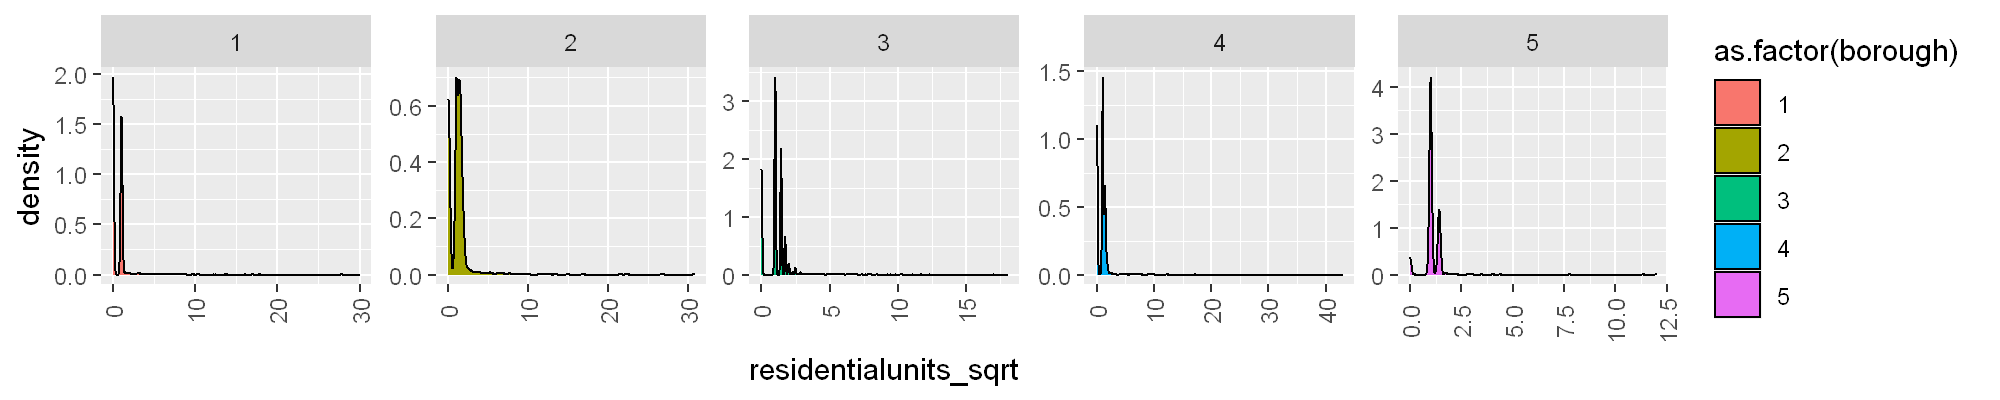

In [83]:
options(repr.plot.width = 10, repr.plot.height = 2, repr.plot.res = 200)
ggplot(data = dt ,aes(x = residentialunits_sqrt, fill = as.factor(borough)))+ 
  facet_wrap( ~ borough, scales ="free", ncol = 5 ) + 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

### Grouping buildings

In [84]:
building_cols = c("residentialunits_group","commercialunits_group","grosssquarefeet_log_filled")
dt_cluster =  copy(scale(dt[,.SD,.SDcols = building_cols ]))

set.seed(0)
building_clusters <- kmeans(dt_cluster, centers = 5, nstart = 25)
table(building_clusters$cluster)
building_clusters


    1     2     3     4     5 
 2730 11920 15728  7376 20349 

K-means clustering with 5 clusters of sizes 2730, 11920, 15728, 7376, 20349

Cluster means:
  residentialunits_group commercialunits_group grosssquarefeet_log_filled
1             -0.4883702             4.2341652                0.538697838
2             -1.1983317            -0.2088750                0.129745087
3              1.0598819            -0.2088750                0.001321825
4             -0.8902921            -0.2079576                1.954910306
5              0.2709881            -0.2088750               -0.857900369

Clustering vector:
    [1] 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
   [37] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3
   [73] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  [109] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 3 3 3 3 1 1 4 4 4 4 4 4 1 2
  [145] 2 3 1 2 3 1 2 2 2 1 2 2 2 2 1 1 1 2 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  [181] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

In [85]:
dt$building_clusters = building_clusters$cluster

### Trends over Date

In [86]:
dt_c = copy(dt)
dt_c$borough = as.factor(dt_c$borough)


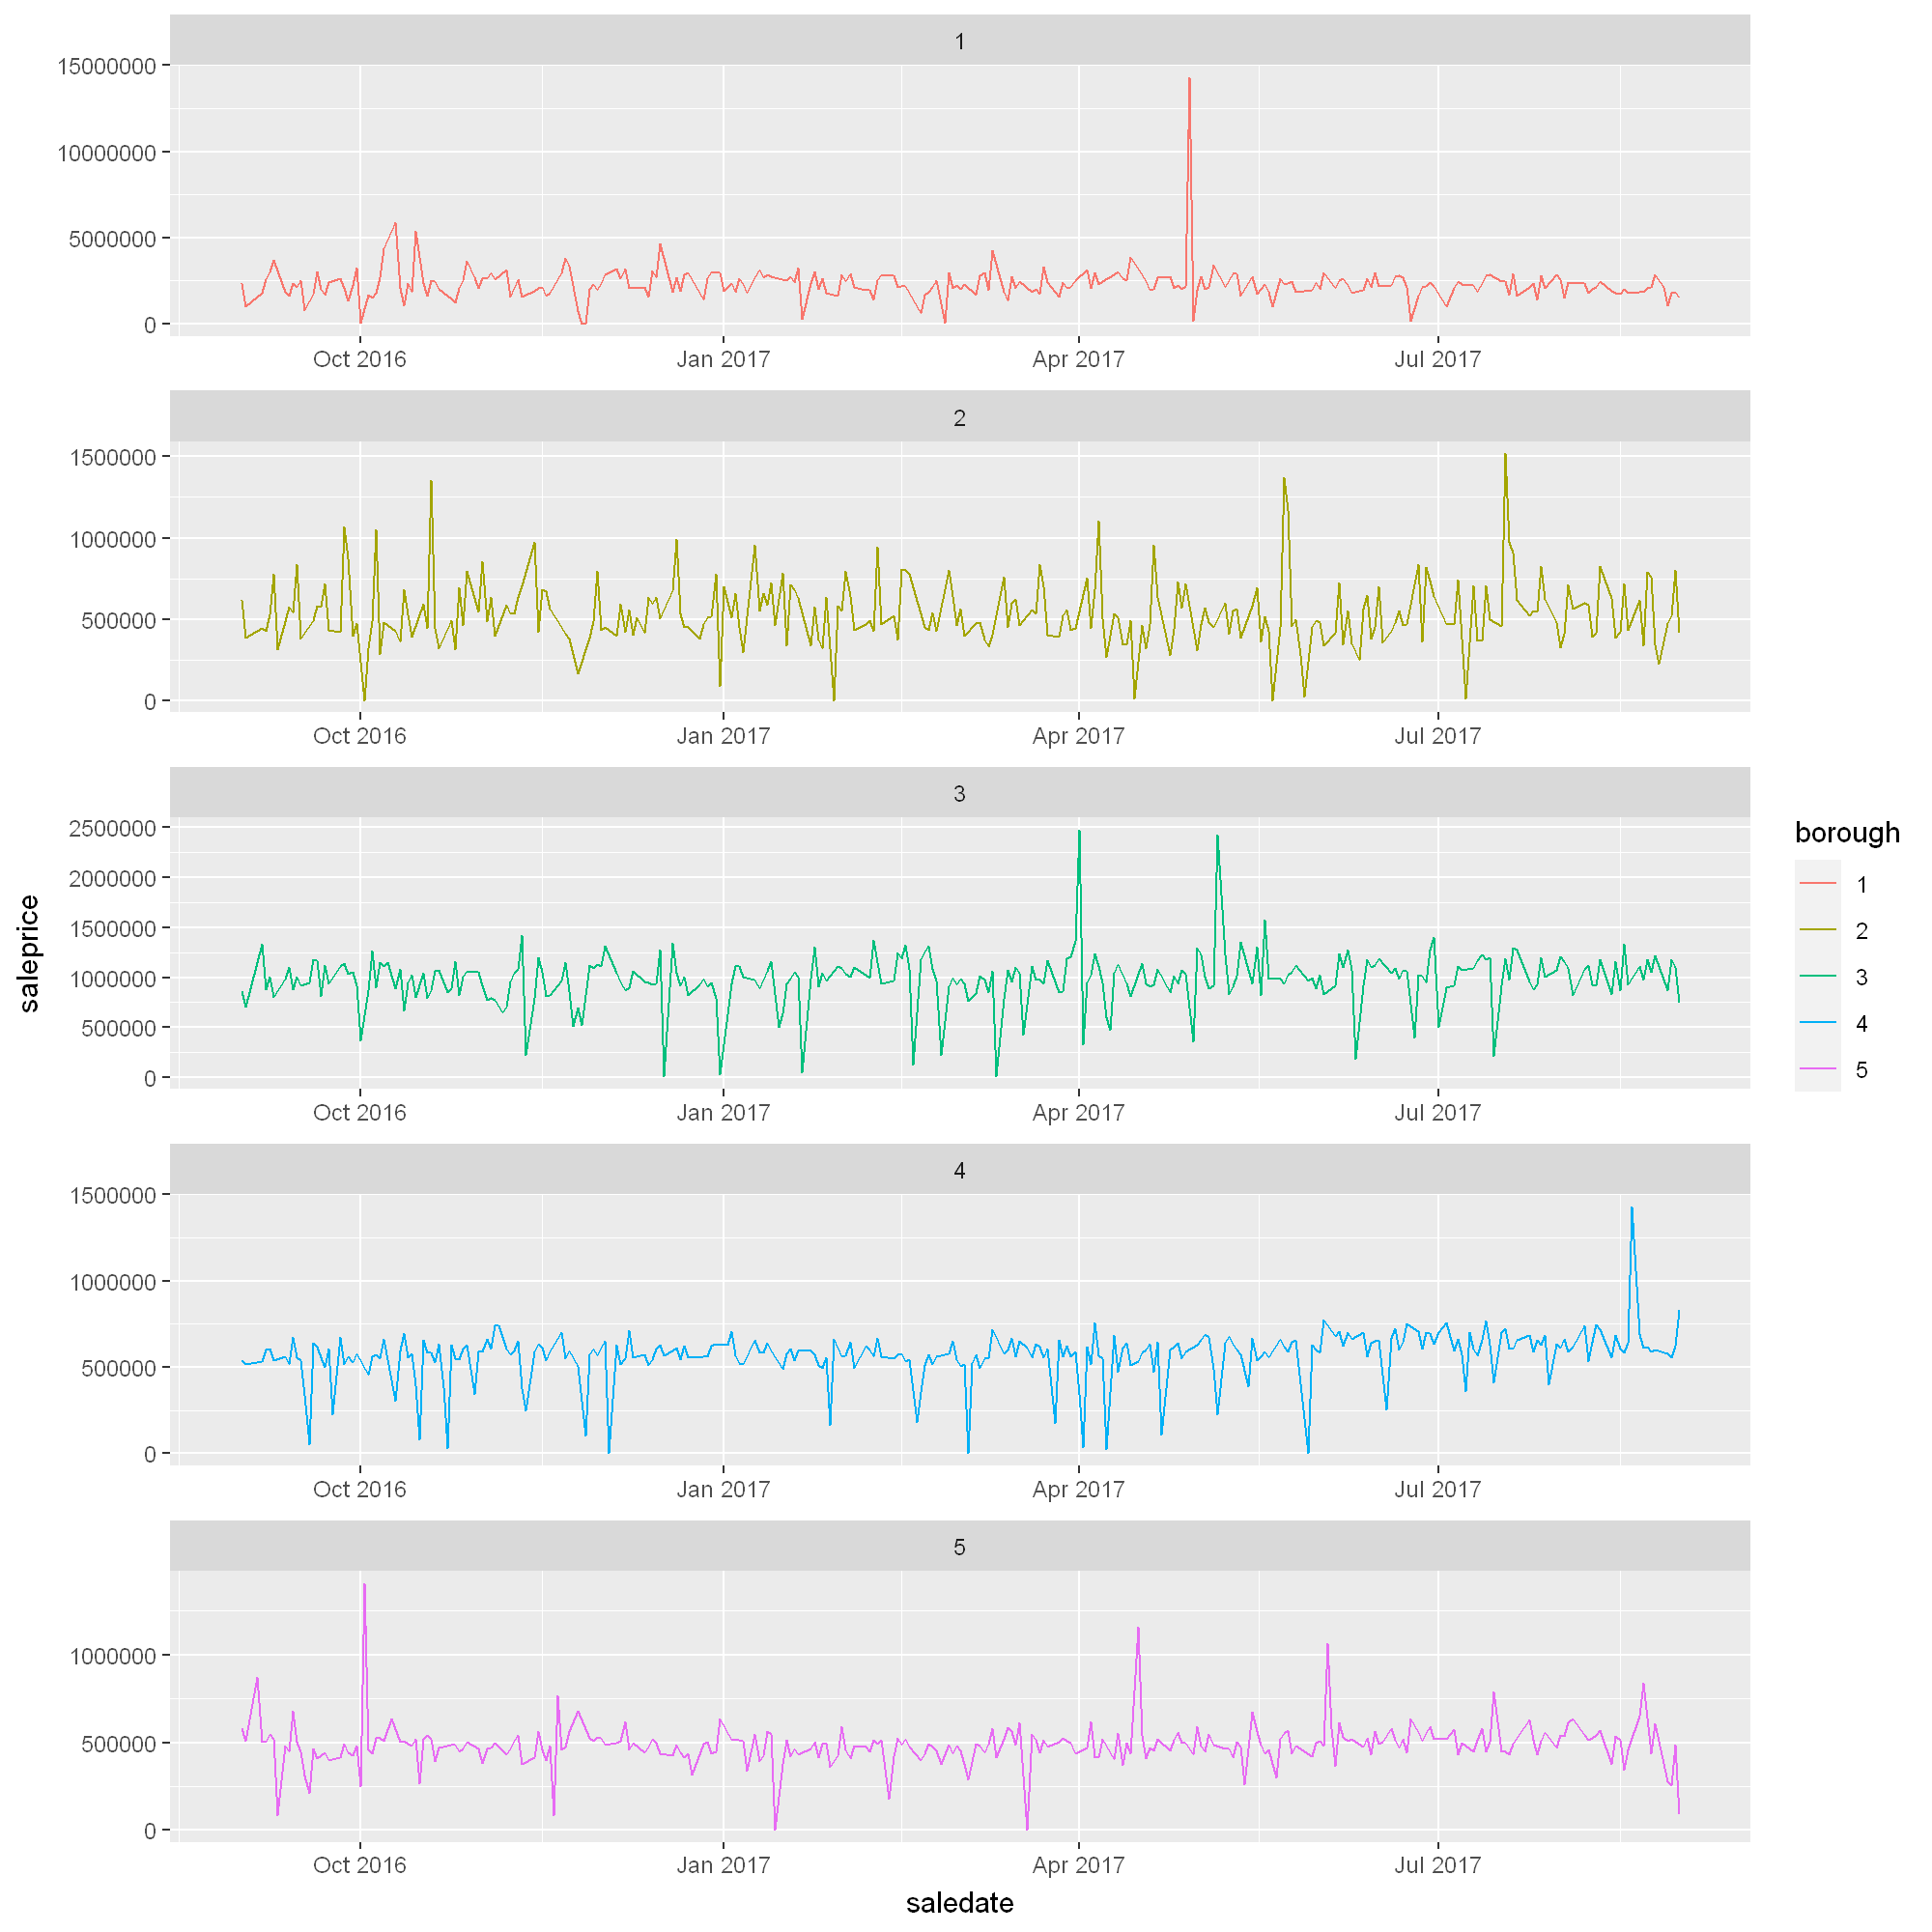

In [87]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200) # for graph sizes
ggplot(data = dt_c[,.(saleprice = mean(saleprice_wo, na.rm = TRUE)),.(saledate,borough)]
       , aes(x = saledate, y = saleprice, group = borough, color = borough)) +
    geom_line() +
    facet_wrap(~borough, ncol = 1,scales = "free")

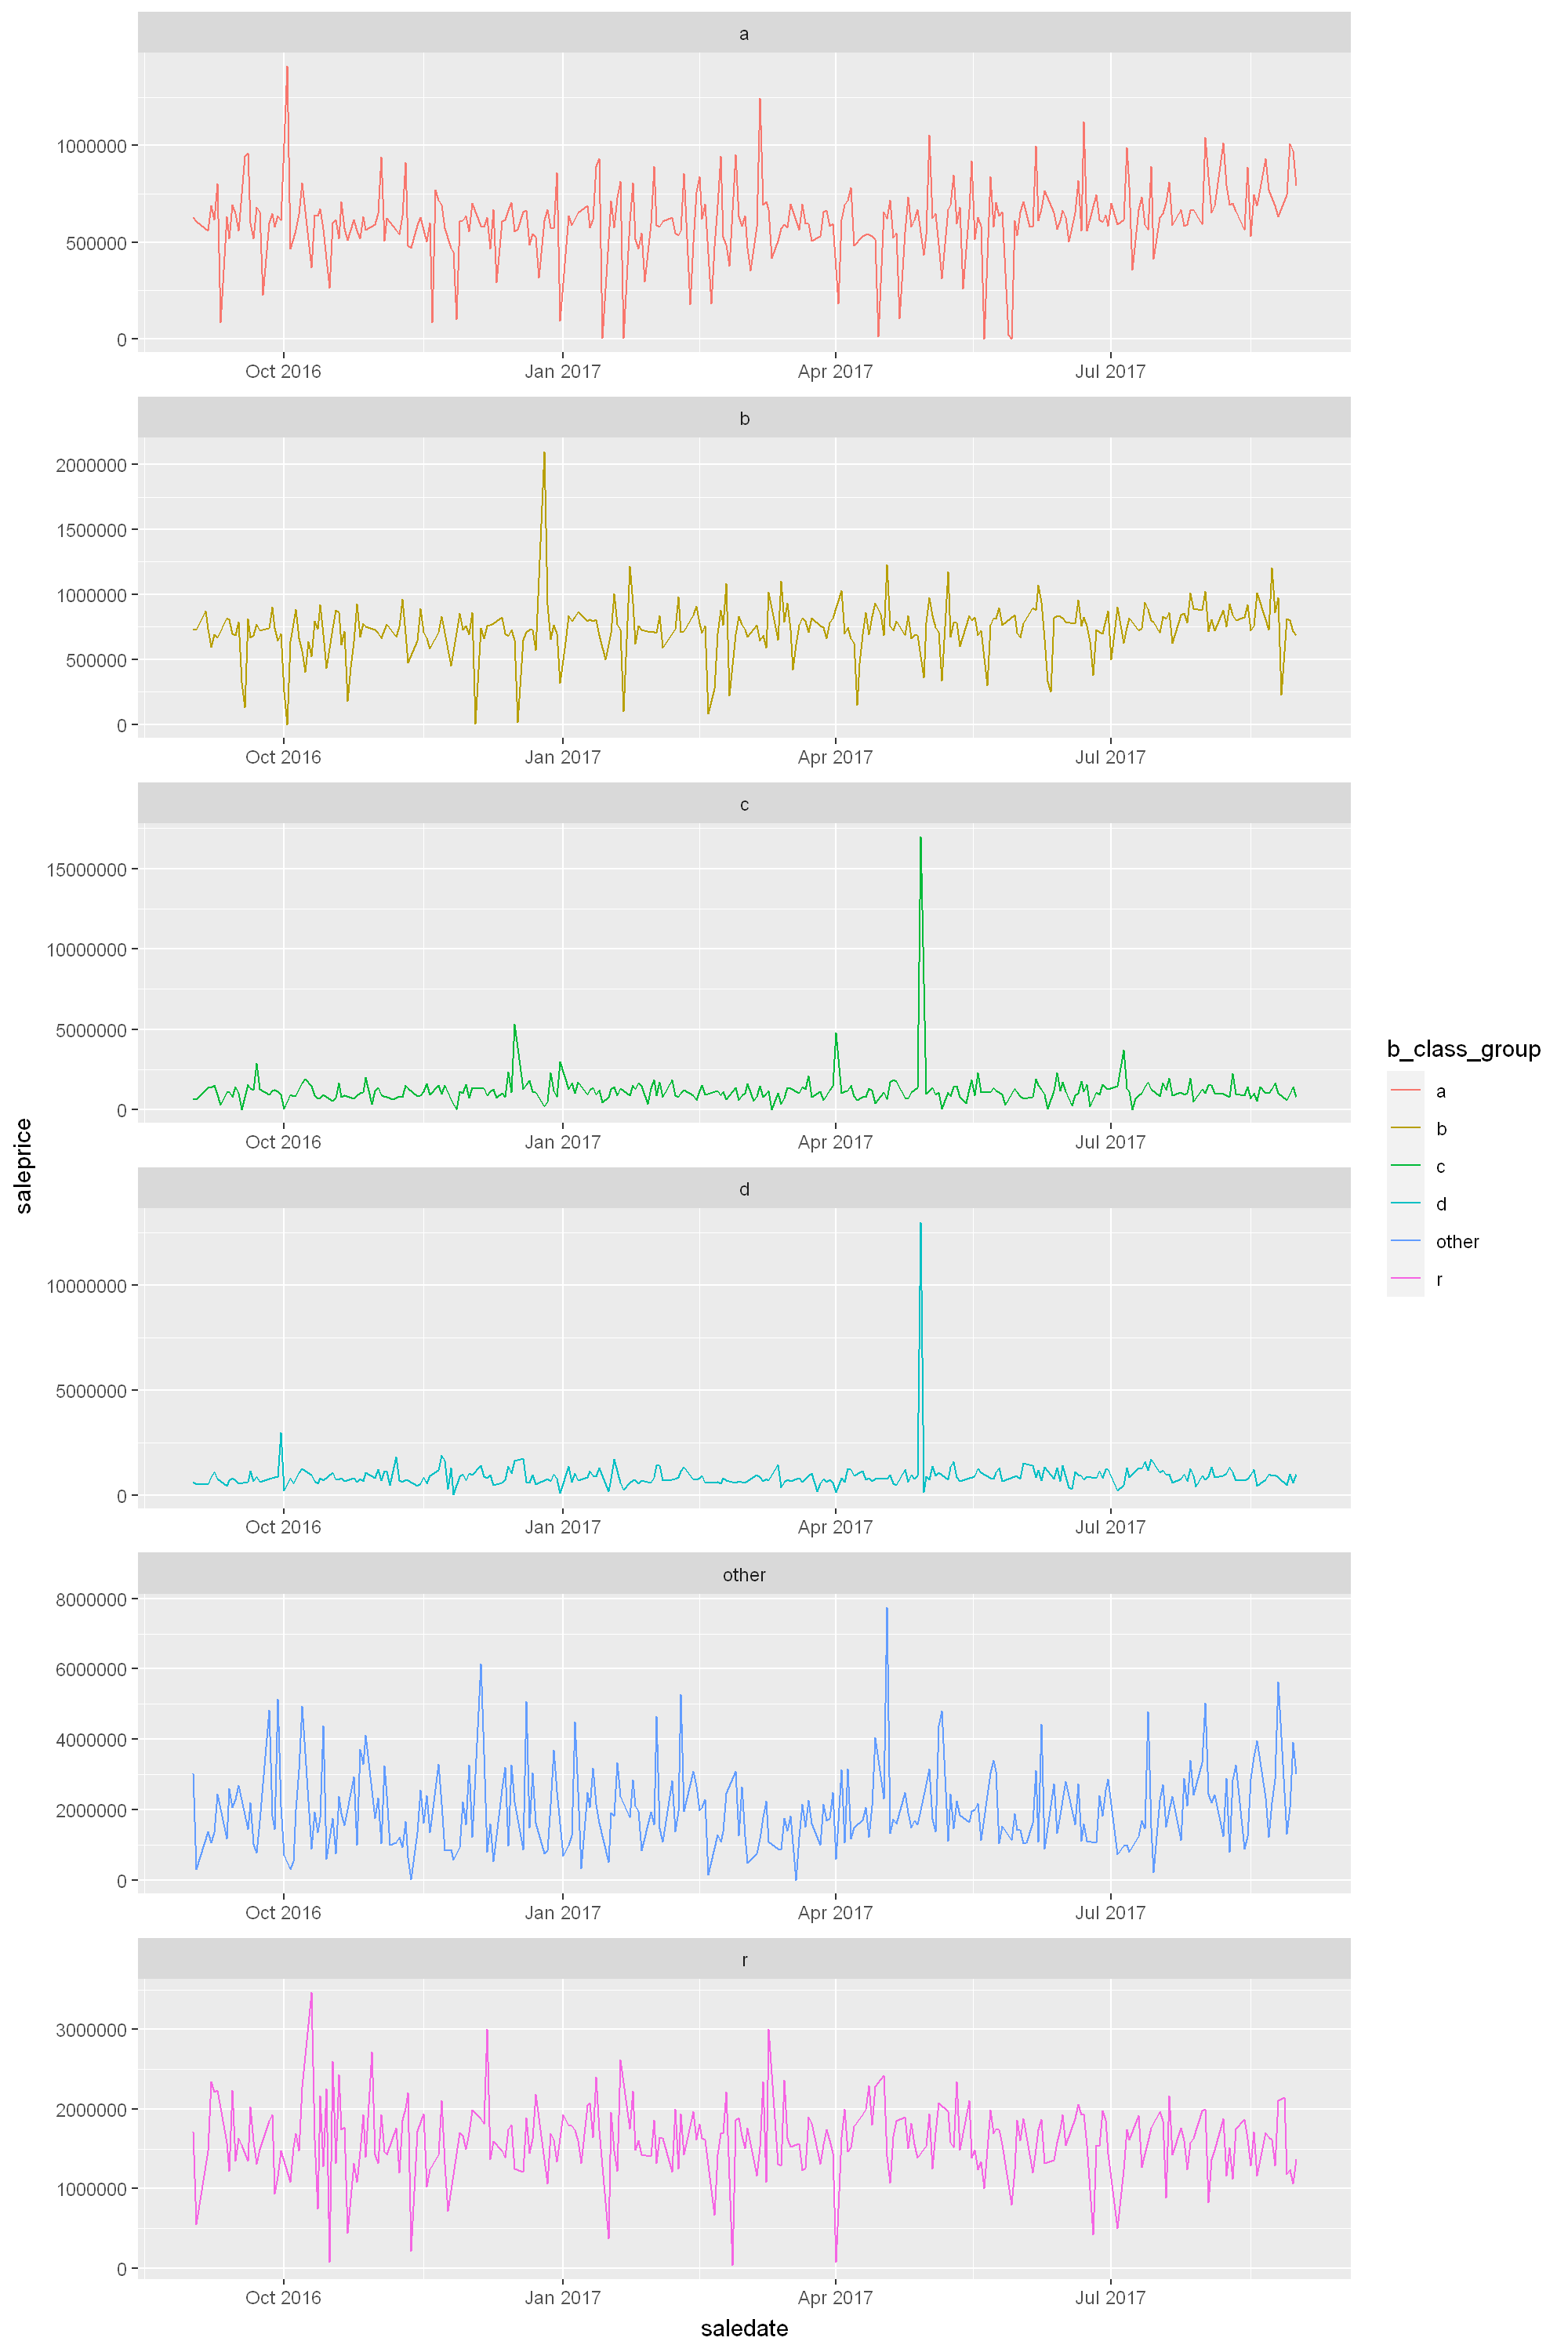

In [88]:
## without outliers
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 200) # for graph sizes
ggplot(data = dt_c[,.(saleprice = mean(saleprice_wo, na.rm = TRUE)),.(saledate,b_class_group)]
       , aes(x = saledate, y = saleprice, group = b_class_group, color = b_class_group)) +
    geom_line() +
    facet_wrap(~b_class_group, ncol = 1,scales = "free")

#### Outlier in SalePrice

In [89]:
dt[, saleprice_wo := tend_outliers_keep(saleprice, sigma = 3),.(borough)]
dt[, saleprice_wo_3s := tend_outliers_keep(saleprice, sigma = 3),.(borough,b_class_group)]
dt[, saleprice_wo_IQR := tend_outliers_keep_IQR(saleprice, IQR = 1.5),.(borough,b_class_group)]

dt[, saleprice_log_wo_IQR := tend_outliers_keep_IQR(saleprice_log,  IQR = 1.5),.(borough,b_class_group)]
dt[, saleprice_log_wo_3s := tend_outliers_keep(saleprice_log, sigma = 3),.(borough,b_class_group)]

In [90]:
summary( dt[,.(saleprice,saleprice_wo,saleprice_wo_3s,saleprice_wo_IQR
               ,saleprice_log_wo= exp(saleprice_log_wo)
               ,saleprice_log_wo_IQR = exp(saleprice_log_wo_IQR)
               ,saleprice_log_wo_3s = exp(saleprice_log_wo_3s))])

   saleprice           saleprice_wo      saleprice_wo_3s     saleprice_wo_IQR  
 Min.   :       210   Min.   :     210   Min.   :      210   Min.   :     210  
 1st Qu.:    380000   1st Qu.:  380000   1st Qu.:   380000   1st Qu.:  380000  
 Median :    635000   Median :  635000   Median :   635000   Median :  630000  
 Mean   :   1505757   Mean   : 1127934   Mean   :  1205344   Mean   :  956561  
 3rd Qu.:   1080000   3rd Qu.: 1080000   3rd Qu.:  1073460   3rd Qu.: 1050000  
 Max.   :2210000000   Max.   :16971406   Max.   :148538545   Max.   :27750000  
 saleprice_log_wo   saleprice_log_wo_IQR saleprice_log_wo_3s 
 Min.   :   26659   Min.   :       210   Min.   :      5997  
 1st Qu.:  380000   1st Qu.:    380000   1st Qu.:    380000  
 Median :  635000   Median :    635000   Median :    635000  
 Mean   : 1194498   Mean   :   1505757   Mean   :   1367657  
 3rd Qu.: 1080000   3rd Qu.:   1080000   3rd Qu.:   1078932  
 Max.   :27382670   Max.   :2210000000   Max.   :2210000000  

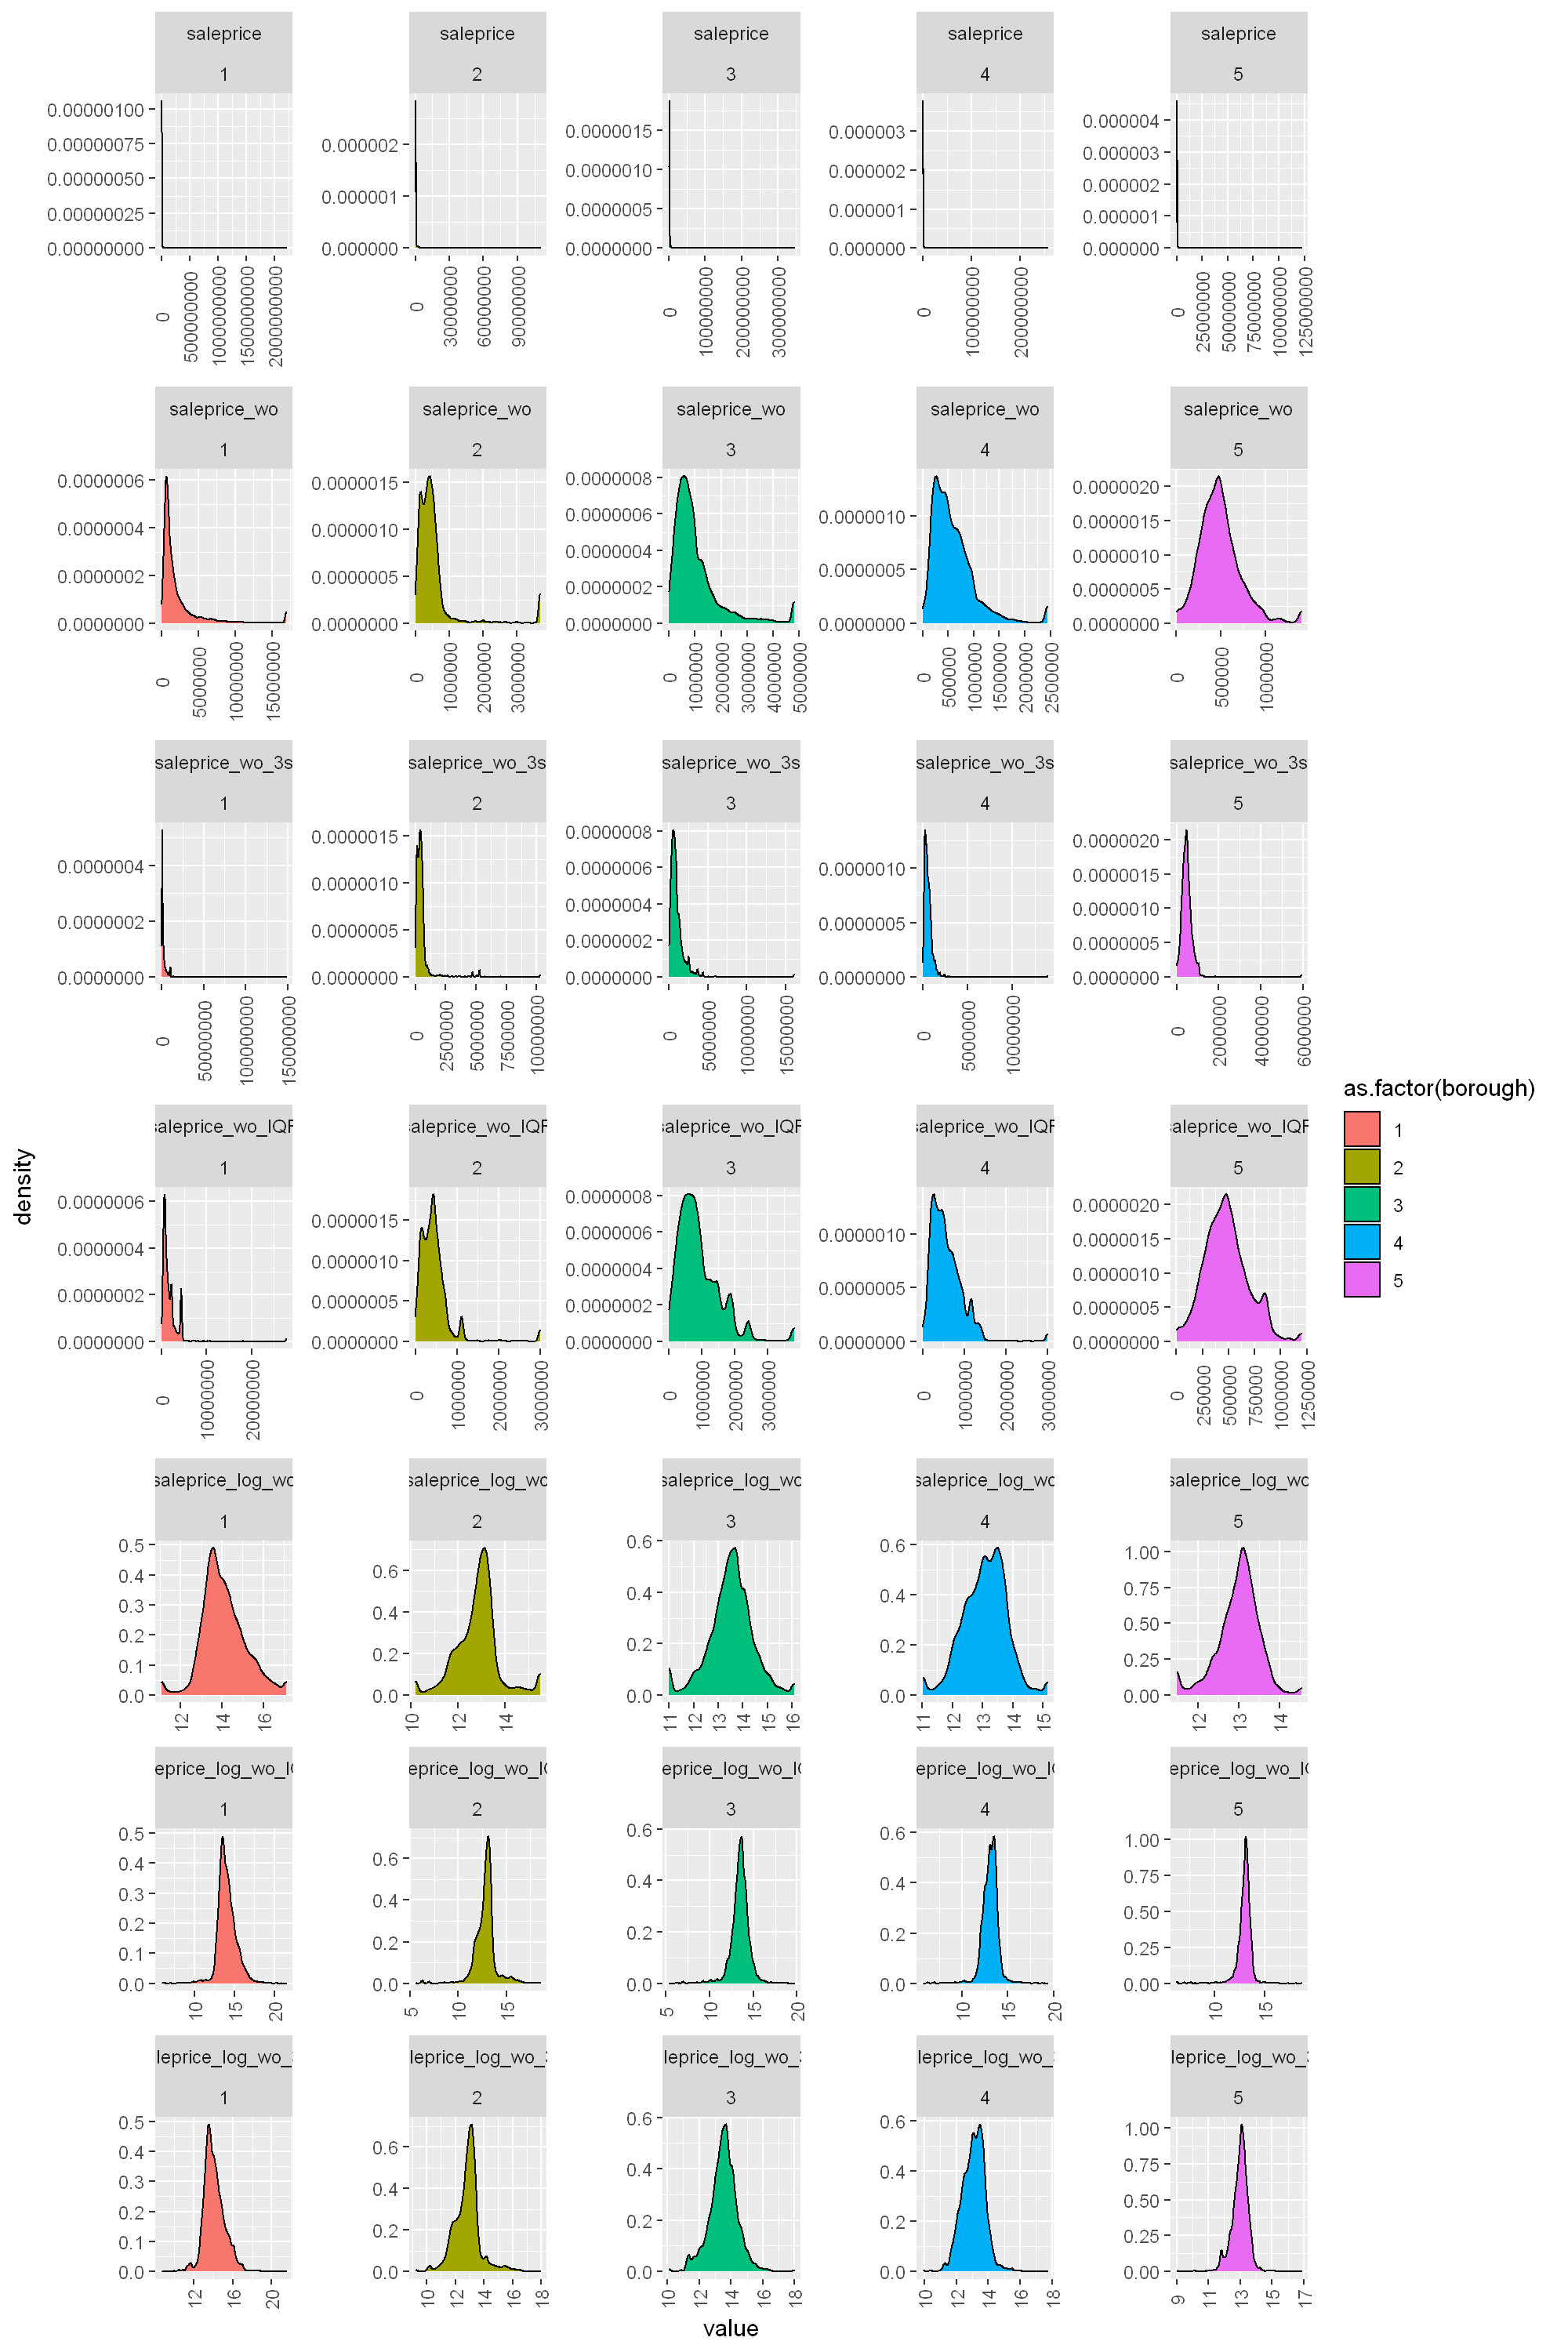

In [91]:
dt_molten = dt[,.(borough,saleprice,saleprice_wo,saleprice_wo_3s,saleprice_wo_IQR
               ,saleprice_log_wo
               ,saleprice_log_wo_IQR 
               ,saleprice_log_wo_3s)] %>%
    melt.data.table(id.vars = c("borough"))
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 200)
ggplot(data = dt_molten ,aes(x = value, fill = as.factor(borough)))+ 
  facet_wrap(variable ~ borough, scales ="free", ncol = 5) + 
  geom_density() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

The nicest shape belongs to saleprice_log_wo :)

**Any pattern in a year?**

In [92]:
dt_outlier = dt[,.SD,.SDcols = c("saledate","b_class_group","saleprice_wo","saleprice_wo_3s","saleprice_wo_IQR")]
dt_outlier[, yearmonth := zoo::as.yearmon(saledate, "%Y%m")] 
dt_outlier = dt_outlier[,.(saleprice_wo = mean(saleprice_wo),
             saleprice_wo_3s = mean(saleprice_wo_3s),
             saleprice_wo_IQR = mean(saleprice_wo_IQR)),
          .(yearmonth,b_class_group)]
dt_molten = dt_outlier %>%
    melt.data.table(id.vars = c("yearmonth","b_class_group"))

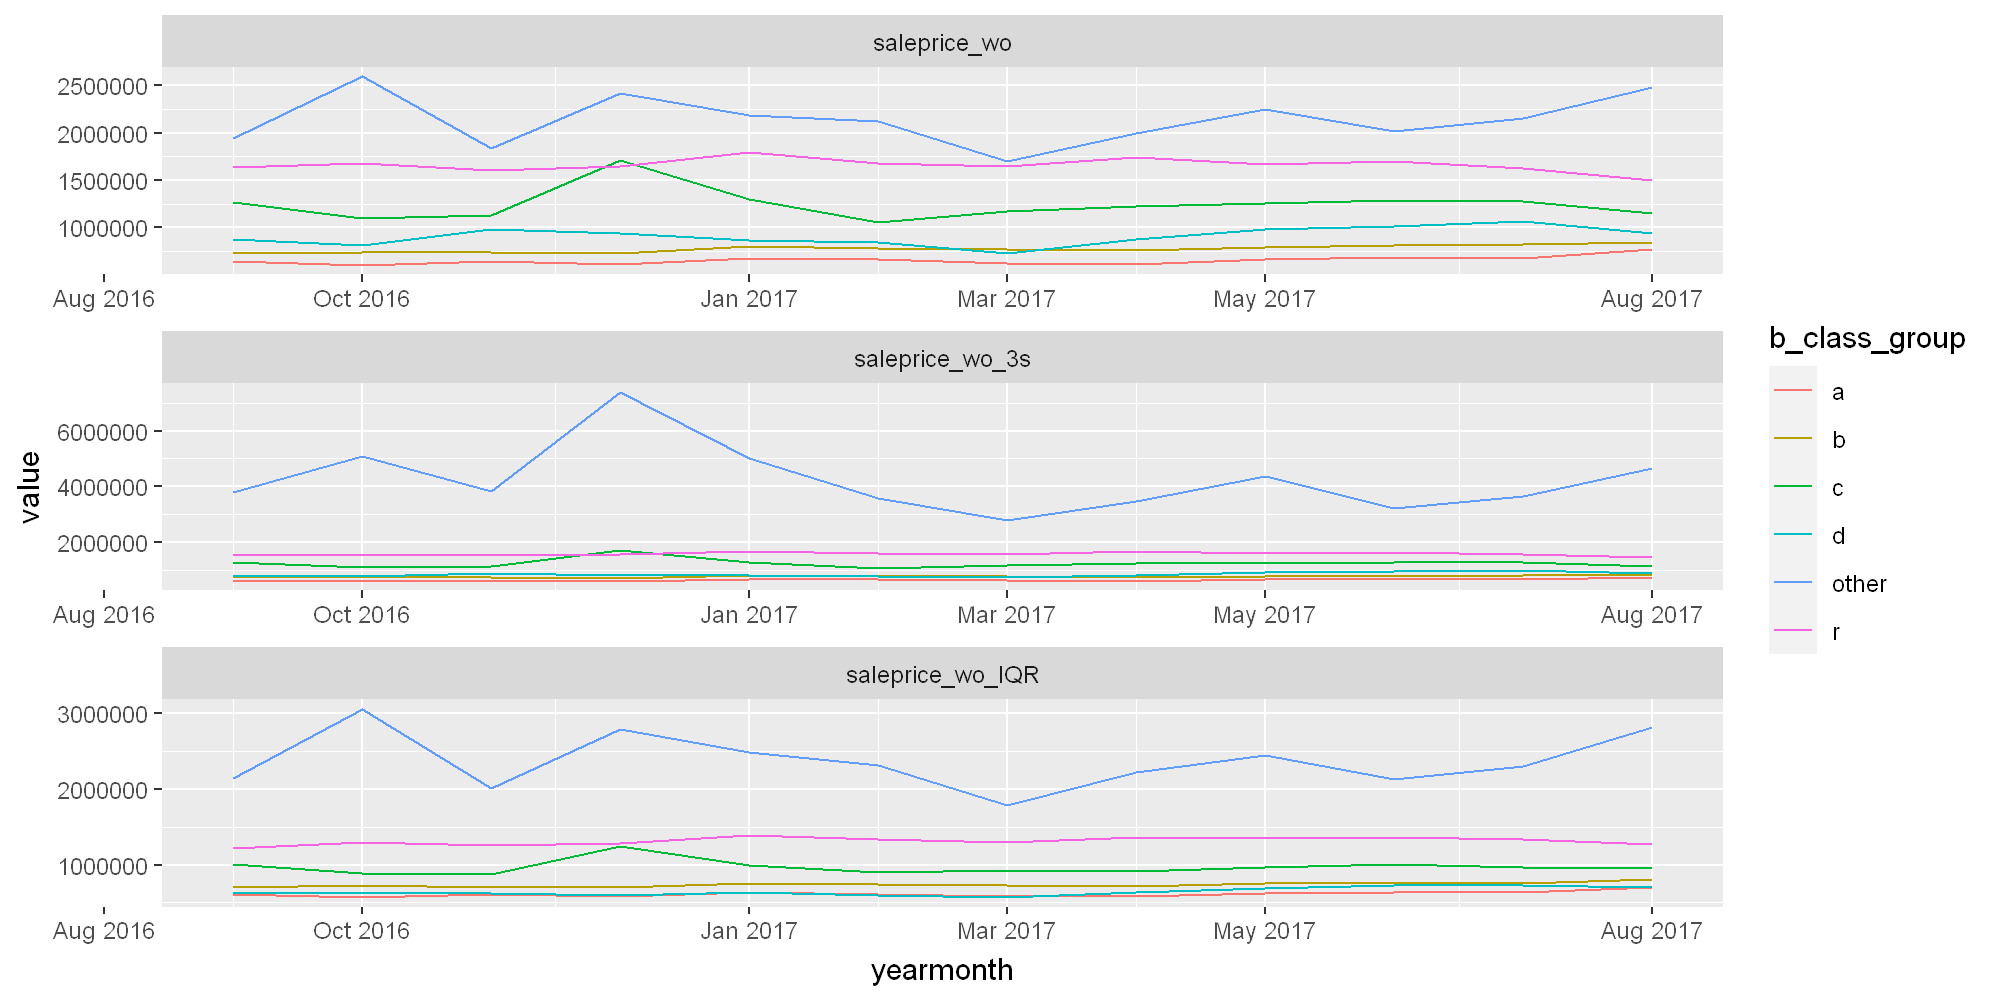

In [93]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) # for graph sizes
ggplot(data = dt_molten
       , aes(x = yearmonth, y = value, group = b_class_group, color = b_class_group)) +
    geom_line() + facet_wrap(~variable,scales = "free", ncol = 1)

**Any pattern explicable with week effect?**

In [94]:
#dt[, wday := wday(saledate, label=TRUE)]
dt_outlier = dt[,.SD,.SDcols = c("saledate","b_class_group","saleprice_wo","saleprice_wo_3s","saleprice_wo_IQR")]
dt_outlier[, wday := wday(saledate, label=TRUE)] 
dt_outlier = dt_outlier[,.(saleprice_wo = mean(saleprice_wo),
             saleprice_wo_3s = mean(saleprice_wo_3s),
             saleprice_wo_IQR = mean(saleprice_wo_IQR)),
          .(wday,b_class_group)]
dt_molten = dt_outlier %>%
    melt.data.table(id.vars = c("wday","b_class_group"))

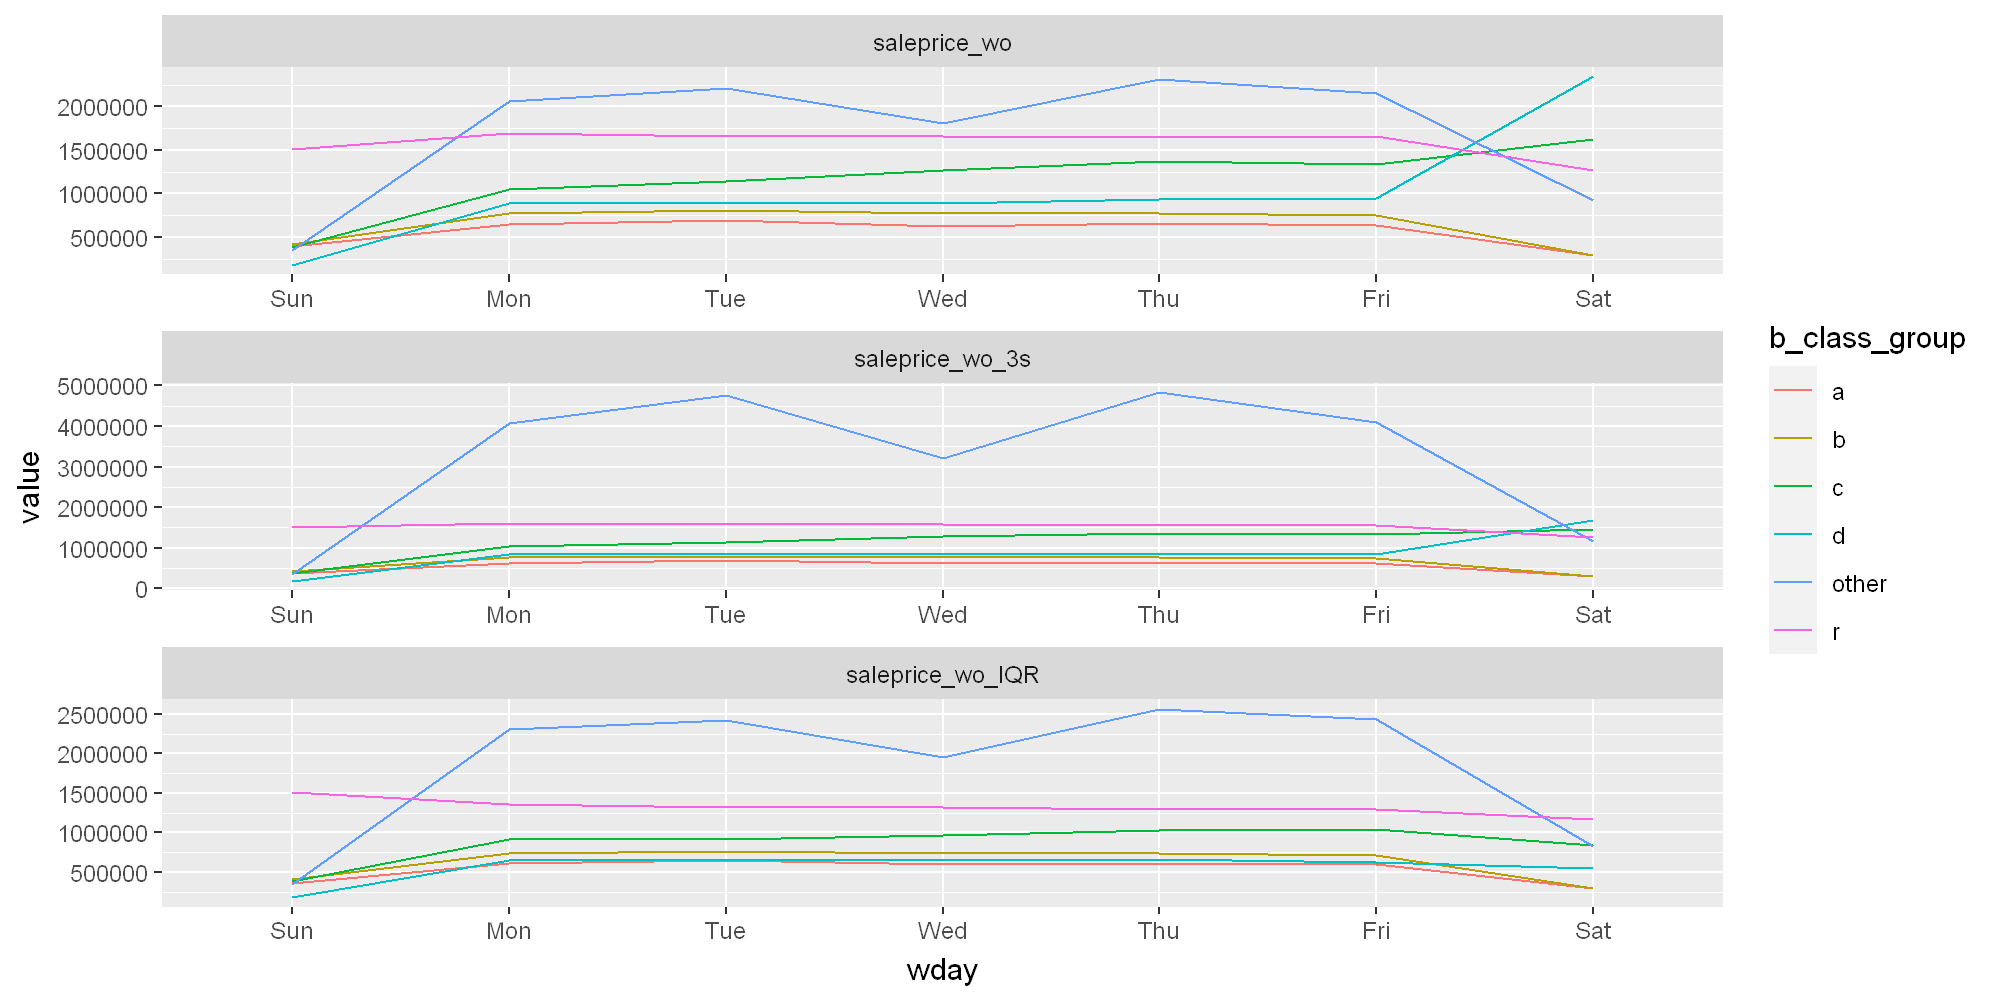

In [95]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) # for graph sizes
ggplot(data = dt_molten
       , aes(x = wday, y = value, group = b_class_group, color = b_class_group)) +
    geom_line() + facet_wrap(~variable,scales = "free", ncol = 1)

### Check the reliability of the data set

*Totalunits = 0 and na square feet columns are very related.*

In [96]:
table(dt$totalunits)
dt[,iszero := ifelse(totalunits == 0,"1","0")]


    0     1     2     3     4     5     6     7     8     9    10    11    12 
15943 26728  9976  2875   782   216   400    96   168    86   100    27    35 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
   14    19    32    52    12    14    15    47     9     5     7    28    19 
   26    27    28    29    30    31    32    33    34    35    36    37    38 
   14    18     6     7    23    12     9     5     6    12    17    12     4 
   39    40    41    42    43    44    45    46    47    48    49    50    51 
    4     3    13    16     3     7     6     5     5    13     5     3     2 
   52    53    54    55    56    57    58    59    60    61    62    63    64 
    2     2     5     3     4     1     3     2     8     4     4     6     2 
   65    66    67    68    69    70    71    72    74    75    76    78    79 
    2     3     1     3     1     2     2     2     3     2     1     5     1 
   81    83    84    86    89    90    91    93    

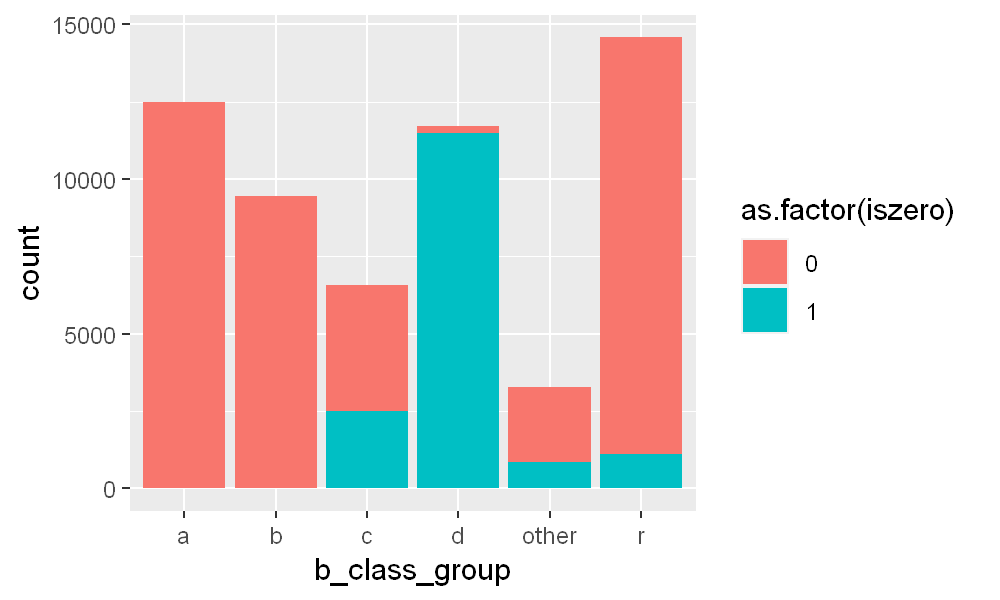

In [97]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200) # for graph sizes
ggplot(data = dt, aes(x = b_class_group, fill = as.factor(iszero), group = as.factor(iszero))) + geom_bar() 

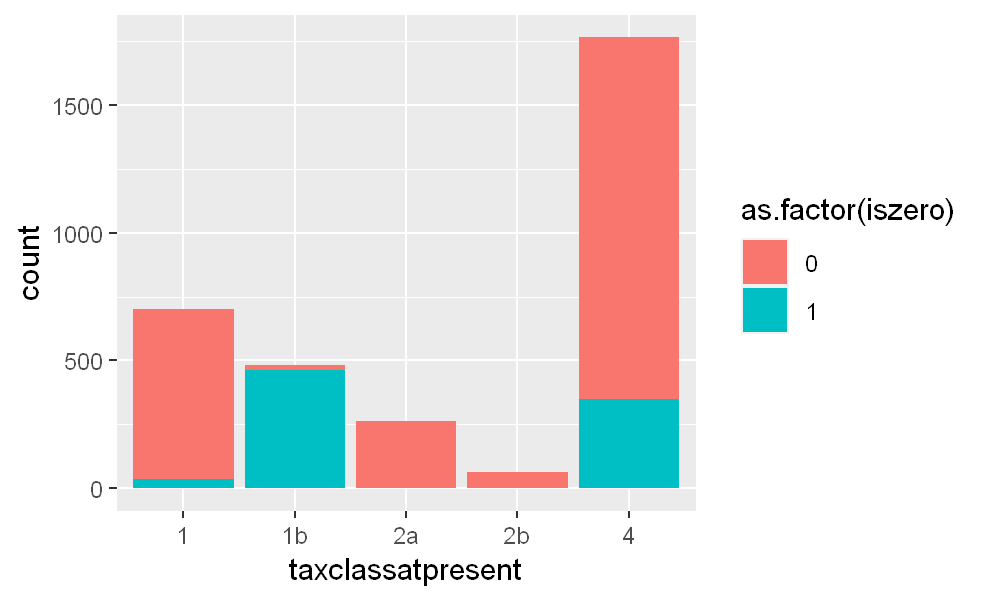

In [98]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200) # for graph sizes
ggplot(data = dt[b_class_group == "other"], aes(x = taxclassatpresent, fill = as.factor(iszero), group = as.factor(iszero))) + geom_bar() 

#### Check (residentialunits + commercialunits != totalunits)

Let's check if the sum of residentialunits and commercialunits gives us the total units.  It seems that inconsistency is present mostly at tax class 4 ( which has the lowest tax rate https://www1.nyc.gov/site/finance/taxes/property-bills-and-payments.page). Moreover, most of these records has R_type building class which are like parking and storage spaces.

In [99]:
#dt[residentialunits + commercialunits != totalunits,.N,.(bor)]
#t(dt[idx == 200])

dt[(residentialunits + commercialunits != totalunits),.N,.(taxclass_present)]
dt[(residentialunits + commercialunits != totalunits),.N,.(buildingclassatpresent)][order(-N)] %>% head()
dt[(residentialunits + commercialunits != totalunits),.N,.(buildingclassatpresent)][order(-N)] %>% head() %>% select(N) %>% sum()

taxclass_present N  
1 4                757
2 1                 11

buildingclassatpresent N  
1 rb                     241
2 rg                     218
3 rh                      81
4 rk                      73
5 rs                      66
6 rp                      42

[1] 721

#### Zero-zipcodes

In [100]:
skim(dt[zipcode == 0]) #308 records

-- Data Summary ------------------------
                           Values          
Name                       dt[zipcode == 0]
Number of rows             308             
Number of columns          44              
Key                        NULL            
_______________________                    
Column type frequency:                     
  character                10              
  factor                   1               
  numeric                  32              
  POSIXct                  1               
________________________                   
Group variables            None            

-- Variable type: character ----------------------------------------------------
# A tibble: 10 x 8
   skim_variable             n_missing complete_rate   min   max empty n_unique
 * <chr>                         <int>         <dbl> <int> <int> <int>    <int>
 1 neighborhood                     32         0.896     6    23     0      102
 2 buildingclasscategory            39        

In [101]:
## deletion
dt = dt[zipcode != 0] # 308 rows

 #### NA area

Most of NA landsquarefeet and grosssquarefeet happen when commercial units are equal to 0.

In [102]:
dt[,iszero := ifelse(is.na(grosssquarefeet),"1","0")]

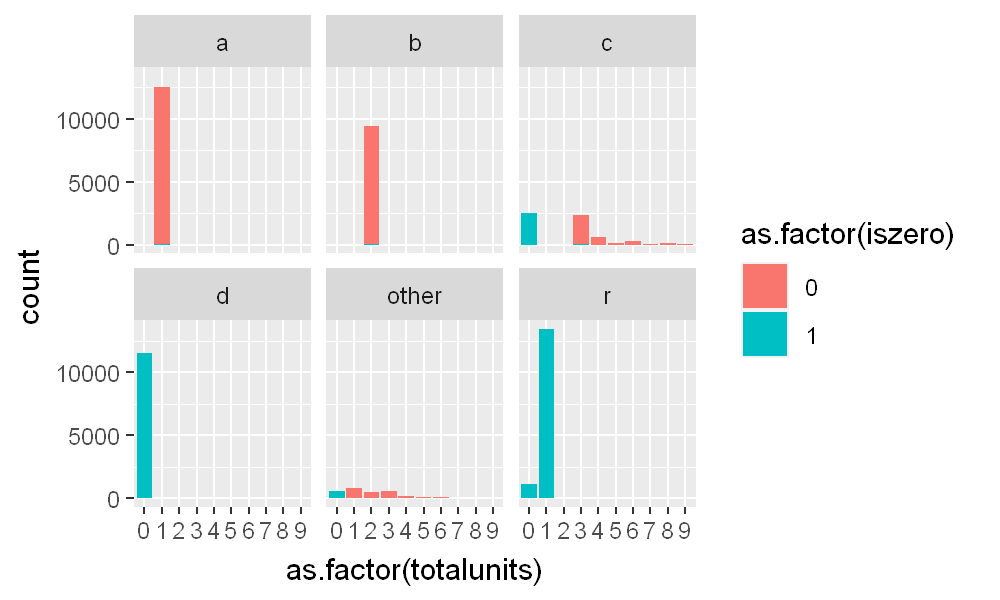

In [103]:
ggplot(data = dt[totalunits < 10], aes(x = as.factor(totalunits), fill = as.factor(iszero), group = as.factor(iszero))) + geom_bar() + facet_wrap(~b_class_group)

In [104]:
dt[, saleprice_log := log(saleprice)]

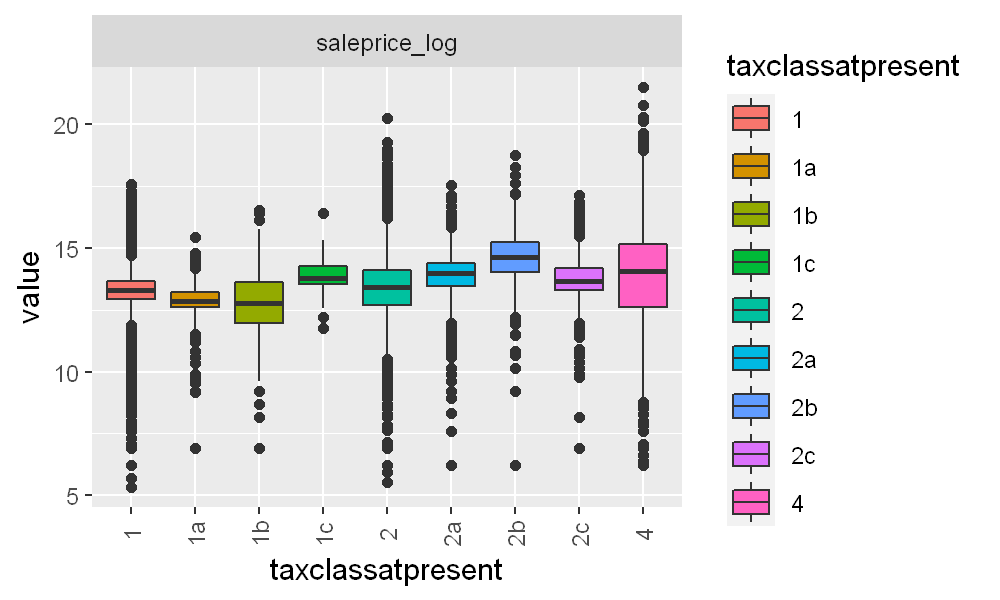

In [105]:
draw_boxplot(dt,id_col = "taxclassatpresent", "saleprice_log")

# Additional Columns

## Extra info

In [106]:
# by using the info on https://www1.nyc.gov/site/finance/taxes/property-determining-your-assessed-value.page
dt[, assessment_ratio_present := ifelse(taxclass_present == 1,0.06,0.45)]
dt[,onlycommercial := ifelse(totalunits == commercialunits,1,0)]

[1] 880

[1] 11679

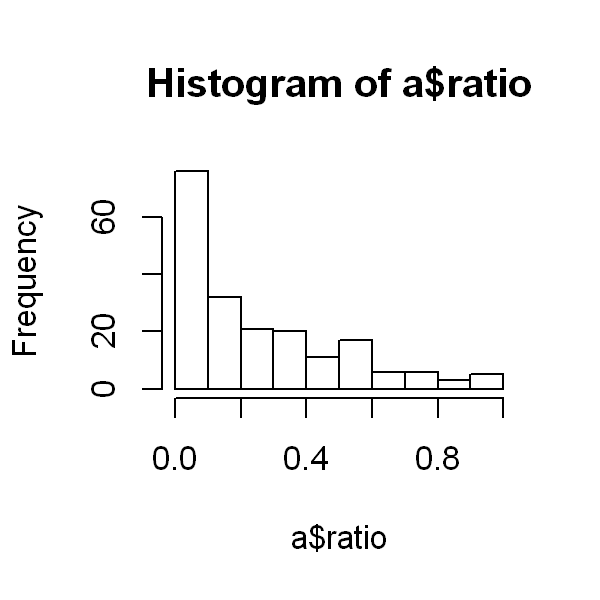

In [107]:
# maybe new feature?
a = dt[,.N,.(onlycommercial,neighborhood)]
onlycommercial_neighborhoods = a[,.N,.(neighborhood)][N == 1]$neighborhood

nrow(dt[neighborhood %in% onlycommercial_neighborhoods])
#nah, nothing important

#maybe degree of commercial?
a[,sum_N := sum(N),.(neighborhood)]
a=a[onlycommercial == 1, .(ratio = N / sum_N,neighborhood)]
options(repr.plot.width =3, repr.plot.height = 3, repr.plot.res = 200) # for graph sizes
hist(a$ratio)
highlycommercial_neighborhoods = a[ratio > 0.4]$neighborhood

nrow(dt[neighborhood %in% highlycommercial_neighborhoods])
#cool

In [108]:
dt[,highly_commercial := ifelse(neighborhood %in% highlycommercial_neighborhoods,1,0)]

## Encoding

In [109]:
encode_cols = c("b_class_present","b_class_group","address","taxclassatpresent")
dt[,paste0((encode_cols),"_encoded"):= lapply(.SD, encode_numeric), .SDcols = encode_cols]

## logs

In [110]:
dt[,address_encoded := encode_numeric(address)]
dt[,b_class_group_encoded := encode_numeric(b_class_group)]
dt[,taxclassatpresent_encoded := encode_numeric(taxclassatpresent)]
dt[,b_class_present_encoded := encode_numeric(b_class_present)]

dt[,grosssquarefeet_log_group_encoded := encode_numeric(grosssquarefeet_log_group)]

dt[, commercialunits_log := log(commercialunits+0.01)]
dt[, residentialunits_log := log(residentialunits+0.01)]

dt[, commercialunits_wo := tend_outliers_keep_IQR(commercialunits, IQR = 1.5)]
dt[, commercialunits_log := log(commercialunits_wo+0.01)]

Warning message:
"Removed 85686 rows containing non-finite values (stat_density)."


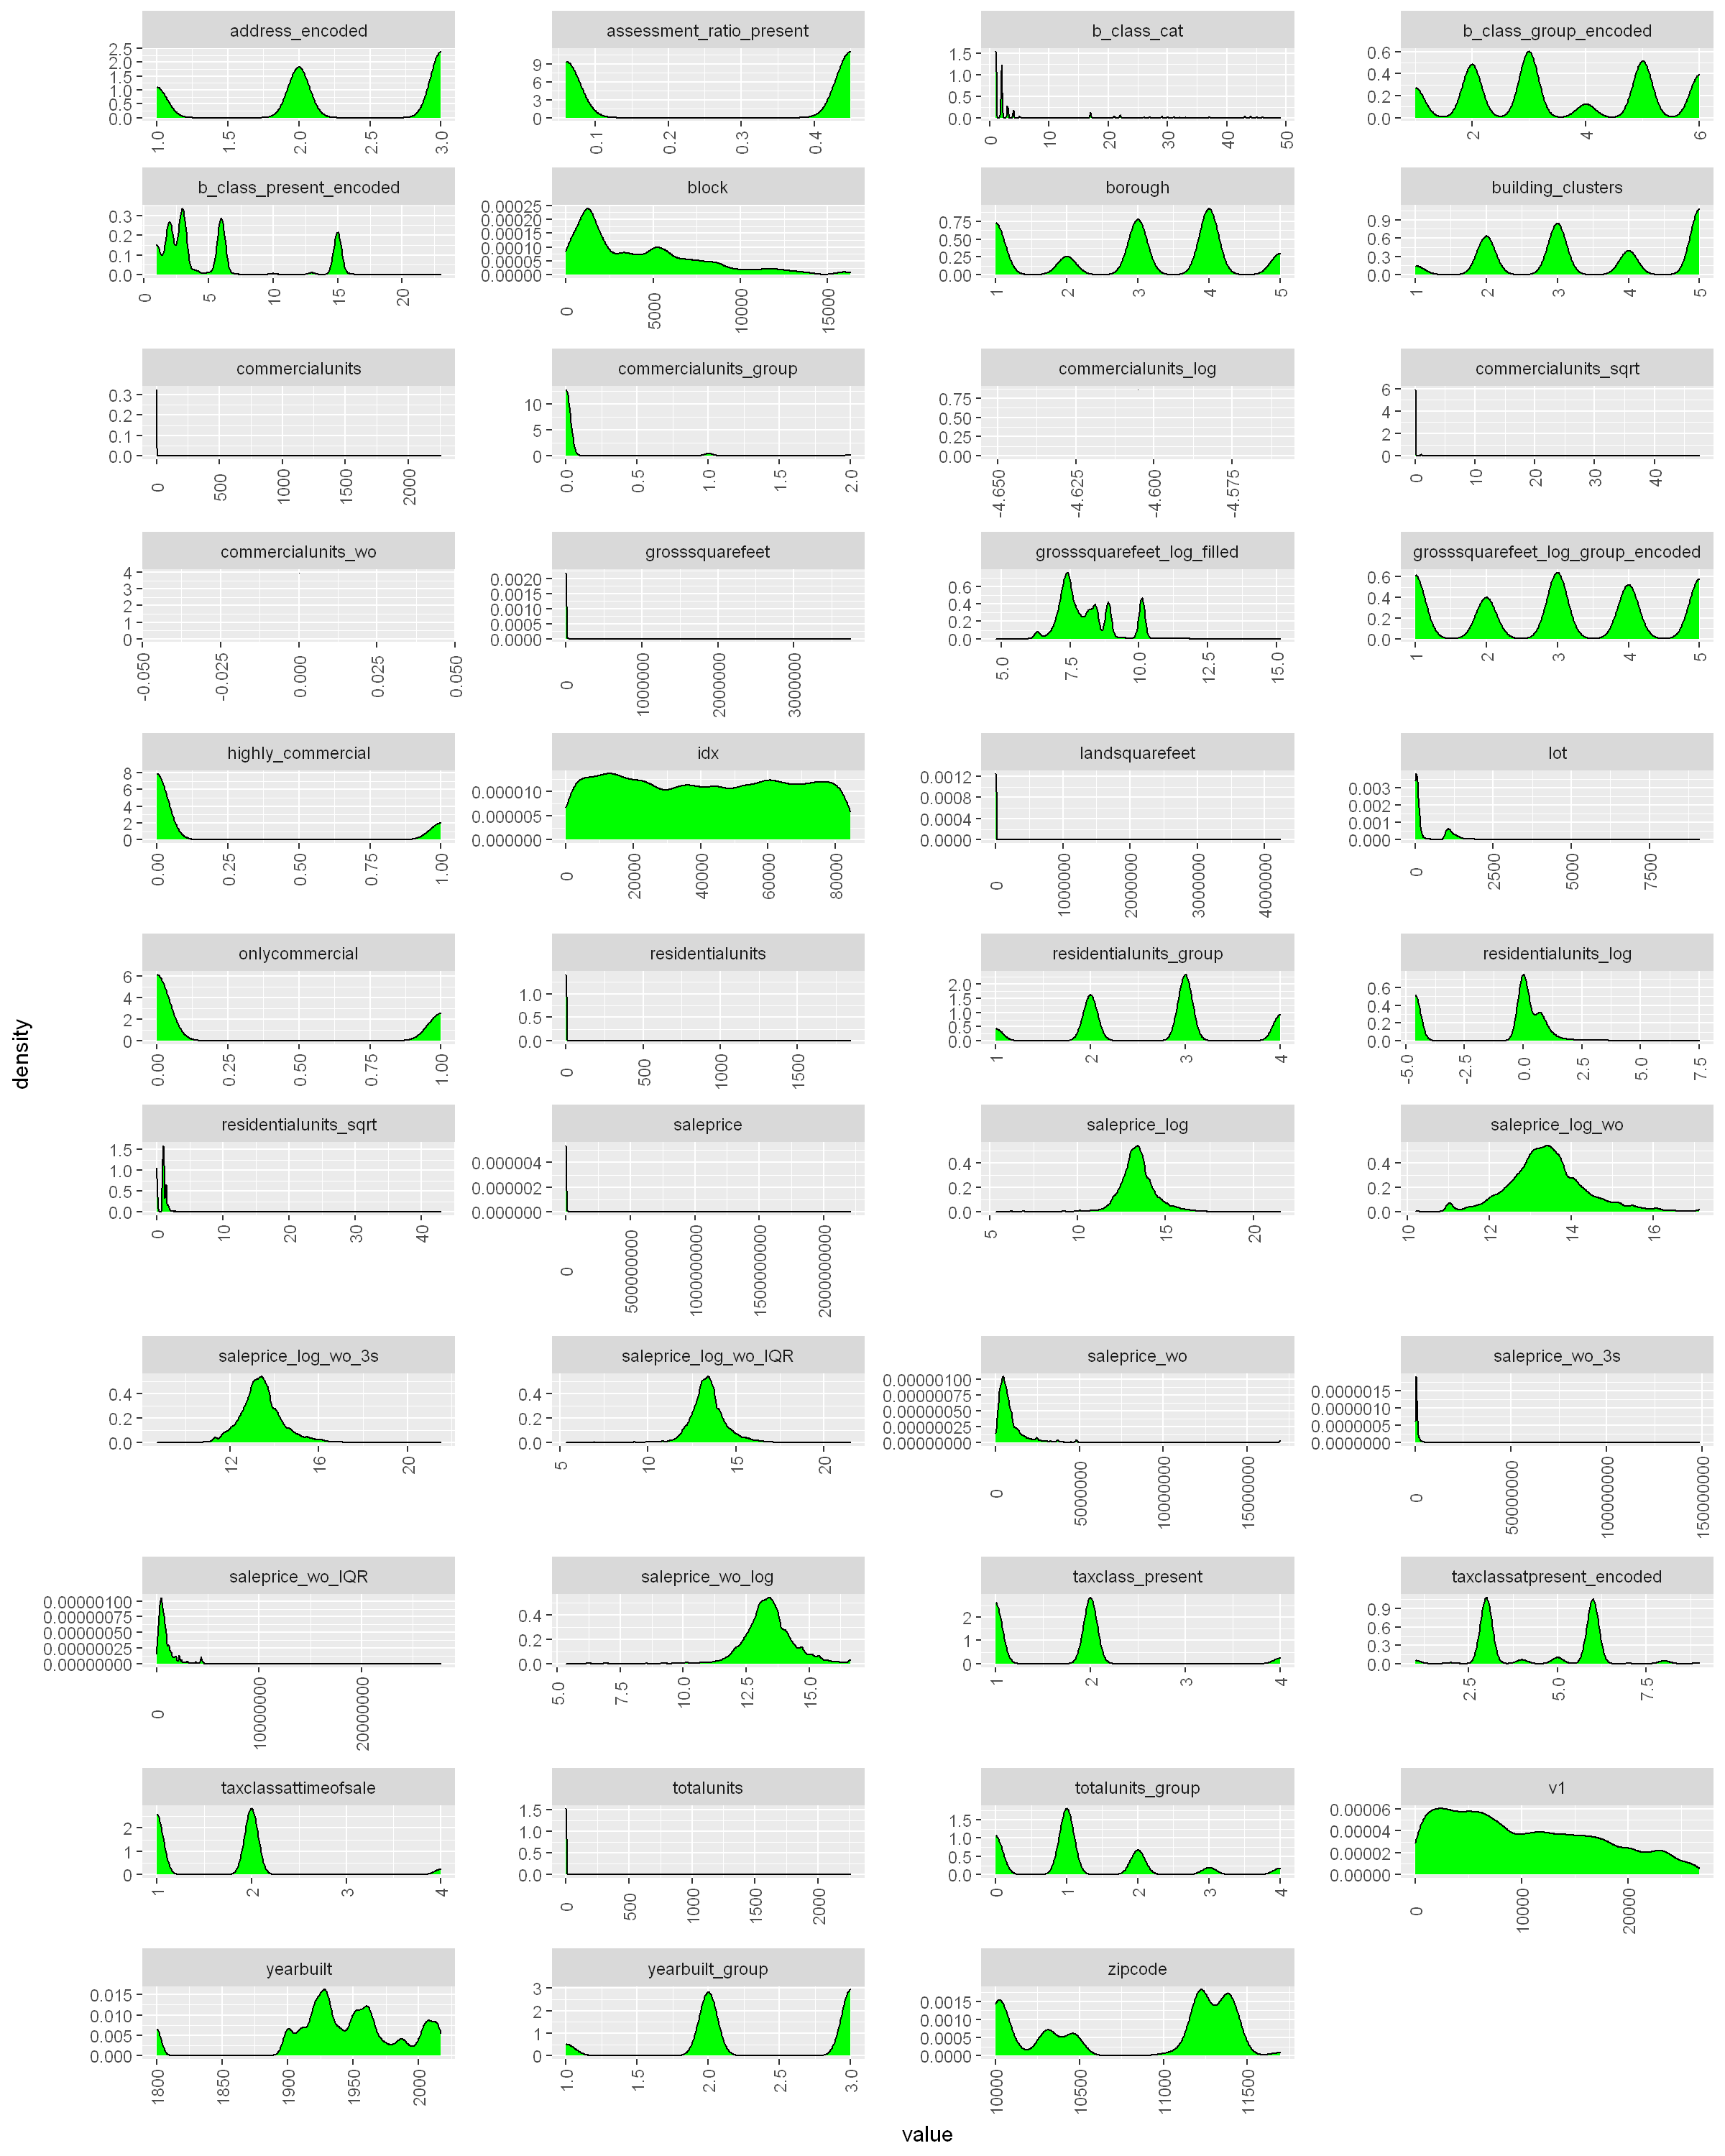

In [111]:
dt_molten = dt %>% purrr::keep(is.numeric) %>% 
  tidyr::gather()

options(repr.plot.width=12, repr.plot.height=15) # for graph sizes
ggplot(data = dt_molten,aes(x = value, fill = key))+ 
  facet_wrap(~ key, scales = "free", ncol = 4) + 
  geom_density(fill = "green") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

# Modeling

## Lasso

Log + outlier

In [112]:
#feature_list = c("borough","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","residentialunits_group","commercialunits_group","address_encoded","b_class_present_encoded","taxclassatpresent_encoded","highly_commercial","building_clusters")

target = c("saleprice_log_wo","saleprice_log")

dt_model = copy(dt[,.SD,.SDcols = c("idx",target,feature_list)])

chunk_no = 10
set.seed(0)
folds <- cut(seq(1,nrow(dt_model)),breaks=chunk_no,labels=FALSE)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

In [113]:
for(i in 1:chunk_no){
  #Segment your data by fold using the which() function 

  testIndexes <- which(folds==i,arr.ind=TRUE)
  testData    <- dt_model[testIndexes, ]
  trainData   <- dt_model[-testIndexes, ]
    
    target = "saleprice_log_wo" 
   y_train        = trainData[[target]]
    target = "saleprice_log"
   y_test         = testData[[target]]
    
    Scale_Parameters = get_scale_params(trainData, feature_list)
    x_train = scale(trainData[,.SD,.SDcols = feature_list])
    
    x_test = testData[,.SD,.SDcols = feature_list]
    scale_external(x_test,Scale_Parameters)
    
    ls.model <- cv.glmnet(  x_train , y_train , type.measure="mse", alpha=1, family="gaussian", nfolds = 5)
    lasso_imp = coef(ls.model)
    lasso_imp = t(t(lasso_imp[order(lasso_imp),]))
    lasso_imp = data.table("names" = names(lasso_imp[,1]), "coeff" = lasso_imp[,1])
    
     if(str_detect(target,"log") == TRUE){
      pred  = exp(predict(ls.model, as.matrix(x_test), s = "lambda.min"))
      actual = exp(y_test)
      
      fitted = exp(predict(ls.model, as.matrix(x_train), s = "lambda.min"))
  }else{
      pred  = predict(ls.model, as.matrix(x_test), s = "lambda.min")
      actual = y_test
      
      fitted = exp(predict(ls.model, as.matrix(x_train)))
  }

  #Check performance
  sub_pred_table = testData[,.(idx, actual = actual, pred = pred, chunk = i)]
  sub_fitted_table = trainData[,.(idx, fitted = fitted, chunk = i )]
  
  pred_table = rbind(pred_table,sub_pred_table )
  fitted_table = rbind(fitted_table,sub_fitted_table )
 
}   


<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



## KNN

Since some problem occured with caret package, unfortunately, I am not able to share the results. 

In [114]:
#feature_list = c("borough","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","residentialunits_group","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")

target = "saleprice_log"

dt_model = copy(dt[,.SD,.SDcols = c("idx",target,feature_list)])

chunk_no = 10
set.seed(0)
folds <- cut(seq(1,nrow(dt_model)),breaks=chunk_no,labels=FALSE)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

In [115]:
#for(i in 1:chunk_no){
#  #Segment your data by fold using the which() function 
#
#  testIndexes <- which(folds==i,arr.ind=TRUE)
#  testData    <- dt_model[testIndexes, ]
#  trainData   <- dt_model[-testIndexes, ]
#  
#   y_train        = trainData[[target]]
#   y_test         = testData[[target]]
#    
#    Scale_Parameters = get_scale_params(trainData, feature_list)
#    x_train = scale(trainData[,.SD,.SDcols = feature_list])
#    
#    x_test = testData[,.SD,.SDcols = feature_list]
#    scale_external(x_test,Scale_Parameters)
#    
#    for (k in c(5)){ #3,5,10,15 
#    knn = caret::knnregTrain(train = x_train, test = x_test, y = y_train, k = k)
#    print(paste0("knn k= ",k,"  rmse: ",calc_rmse(y_test, knn)))
#    }
#      
#     if(str_detect(target,"log") == TRUE){
#      pred  = exp(knn)
#      actual = exp(y_test)
#  }else{
#      pred  = knn
#      actual = y_test
#  }
#
#  #Check performance
#  sub_pred_table = testData[,.(idx, actual = actual, pred = pred, chunk = i)]
#  sub_fitted_table = trainData[,.(idx, fitted = fitted, chunk = i )]
#  
#  pred_table = rbind(pred_table,sub_pred_table )
#  fitted_table = rbind(fitted_table,sub_fitted_table )
# 
#}   
#

## SVM

In [116]:
#feature_list = c("borough","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","residentialunits_group","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")

target = "saleprice_log"

dt_model = copy(dt[,.SD,.SDcols = c("idx",target,feature_list)])

chunk_no = 10
set.seed(0)
folds <- cut(seq(1,nrow(dt_model)),breaks=chunk_no,labels=FALSE)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

6 min for the 1st chunk

In [117]:
for(i in 1:1){
  #Segment your data by fold using the which() function 

  testIndexes <- which(folds==i,arr.ind=TRUE)
  testData    <- dt_model[testIndexes, ]
  trainData   <- dt_model[-testIndexes, ]
  
   y_train        = trainData[[target]]
   y_test         = testData[[target]]
    
    Scale_Parameters = get_scale_params(trainData, feature_list)
    x_train = scale(trainData[,.SD,.SDcols = feature_list])
    
    x_test = testData[,.SD,.SDcols = feature_list]
    scale_external(x_test,Scale_Parameters)
    
    svm.model <- svm(  x_train , y_train)
      
     if(str_detect(target,"log") == TRUE){
      pred  = exp(predict(svm.model, as.matrix(x_test)))
      actual = exp(y_test)
  }else{
      pred  = predict(svm.model, as.matrix(x_test))
      actual = y_test
      
      fitted = exp(predict(svm.model, as.matrix(x_train)))
  }

  #Check performance
  sub_pred_table = testData[,.(idx, actual = actual, pred = pred, chunk = i)]
  sub_fitted_table = trainData[,.(idx, fitted = fitted, chunk = i )]
  
  pred_table = rbind(pred_table,sub_pred_table )
  fitted_table = rbind(fitted_table,sub_fitted_table )
 
}   


In [118]:
## Results for only 1 chunk
print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)


[1] "overall test rmse:"


[1] 37031393

[1] 2914649

## XGBoost (Base)

A general model with everything vs different models for borough and building type.

In [119]:
params = list(   booster = "gbtree"
                 #  , eta = best_params$eta #learning rate
                 #  , gamma = best_params$gamma # min loss reduction
                 #   , max_depth = best_params$depth
                 , min_child_weight = 1, subsample = 1, colsample_bytree= 1
                 , objective = "reg:squarederror"
                 , eval_metric = "rmse")

In [120]:
#feature_list = c("borough","zipcode","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","b_class_group_encoded"
                 ,"zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                )
target = "saleprice"

fit = model_xgboost(feature_list,target,chunk_no = 10)
pred_table = fit[[1]]

imp_table = fit[[2]]
imp_table

print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)


[1]	train-rmse:4244969.000000	test-rmse:36897200.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:4026631.500000	test-rmse:36494472.000000 
[3]	train-rmse:3898269.250000	test-rmse:36266436.000000 
[4]	train-rmse:3757441.250000	test-rmse:36129340.000000 
[5]	train-rmse:3671084.750000	test-rmse:36042768.000000 
[6]	train-rmse:3617252.500000	test-rmse:35979220.000000 
[7]	train-rmse:3563825.750000	test-rmse:35942720.000000 
[8]	train-rmse:3511676.500000	test-rmse:35891592.000000 
[9]	train-rmse:3465778.000000	test-rmse:35891844.000000 
[10]	train-rmse:3396834.500000	test-rmse:35873512.000000 
[11]	train-rmse:3382777.500000	test-rmse:35862776.000000 
[12]	train-rmse:3362368.500000	test-rmse:35861236.000000 
[13]	train-rmse:3344753.750000	test-rmse:35837356.000000 
[14]	train-rmse:3328556.750000	test-rmse:35838036.000000 
[15]	train-rmse:3320809.250000	test-rmse:35829864.000000 
[16]	tra

Feature                1          2            3           4           
1  zipcode                0.39253360 0.8164719688 0.758510203 0.7980900070
2  building_clusters      0.04162015 0.0998416757 0.101532361 0.1054774692
3  commercialunits_group  0.10946186 0.0364813836 0.031959159 0.0365645206
4  address_encoded        0.06201821 0.0141769572 0.032244109 0.0203960599
5  b_class_group_encoded  0.09706340 0.0127703209 0.010503758 0.0124074965
6  highly_commercial      0.03234904 0.0040426918 0.010788299 0.0097260623
7  taxclass_present       0.06715878 0.0085910240 0.008752791 0.0088537046
8  residentialunits_group 0.07494638 0.0052251738 0.005159020 0.0053910554
9  onlycommercial         0.07704466 0.0019810168 0.014115998 0.0028086942
10 borough                0.04580392 0.0004177874 0.026434301 0.0002849302
   5           6           7            8           9            10         
1  0.791233138 0.804270650 0.8018064029 0.805992240 0.8057535788 0.548230730
2  0.099389054 0.100985898 0.1063890565 0.104056023 0.1034287252 0.098318354
3  0.036639116 0.033059983 0.0360641903 0.036024378 0.0349764508 0.038597810
4  0.024917270 0.021550293 0.0177112827 0.017726009 0.0179667260 0.017164530
5  0.018297213 0.009175303 0.0073557569 0.006615443 0.0081750049 0.004974304
6  0.010426498 0.009787730 0.0099422887 0.010399352 0.0096239268 0.010206110
7  0.008326027 0.008297487 0.0095082066 0.008624524 0.0089758494 0.009328126
8  0.005550276 0.005007051 0.0046283425 0.004685668 0.0044592682 0.005763518
9  0.002931058 0.003761594 0.0060760983 0.005693697 0.0063375083 0.004170385
10 0.002290350 0.004104013 0.0005183746 0.000182666 0.0003029617 0.263246134

[1] "overall test rmse:"


[1] 12017563

[1] 2309030

In [121]:
print("please compare with knn:")
calc_rmse(pred_table[chunk ==1]$pred,pred_table[chunk ==1]$actual)

[1] "please compare with knn:"


[1] 35829882

In [122]:
#feature_list = c("borough","zipcode","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","b_class_group_encoded"
                 ,"zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                )
target = "saleprice_log"


fit = model_xgboost(feature_list,target,chunk_no = 10)
pred_table = fit[[1]]

imp_table = fit[[2]]
imp_table

print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)


[1]	train-rmse:9.015181	test-rmse:9.605144 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.340274	test-rmse:6.724190 
[3]	train-rmse:4.478600	test-rmse:4.654668 
[4]	train-rmse:3.189958	test-rmse:3.229381 
[5]	train-rmse:2.307349	test-rmse:2.309324 
[6]	train-rmse:1.713515	test-rmse:1.696084 
[7]	train-rmse:1.322782	test-rmse:1.375553 
[8]	train-rmse:1.078677	test-rmse:1.192670 
[9]	train-rmse:0.935439	test-rmse:1.097197 
[10]	train-rmse:0.852653	test-rmse:1.063898 
[11]	train-rmse:0.805861	test-rmse:1.050811 
[12]	train-rmse:0.782749	test-rmse:1.054734 
[13]	train-rmse:0.765518	test-rmse:1.060228 
[14]	train-rmse:0.757321	test-rmse:1.066706 
Stopping. Best iteration:
[11]	train-rmse:0.805861	test-rmse:1.050811

[1]	train-rmse:9.028004	test-rmse:9.582934 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Feature                1          2           3          4         
1  zipcode                0.34741699 0.369159131 0.41937417 0.39755637
2  borough                0.14117768 0.125191336 0.14477561 0.16331159
3  taxclass_present       0.14663807 0.116926111 0.12464467 0.10812566
4  building_clusters      0.03869330 0.073610924 0.08260858 0.09122481
5  onlycommercial         0.15727368 0.106919101 0.07996558 0.07992588
6  residentialunits_group 0.03077724 0.048039418 0.04128153 0.05983227
7  b_class_group_encoded  0.05006407 0.068585779 0.04801472 0.04043573
8  commercialunits_group  0.05599813 0.063117294 0.03090834 0.03317610
9  highly_commercial      0.02103257 0.018584176 0.01537385 0.01274842
10 address_encoded        0.01092828 0.009866729 0.01305296 0.01366317
   5          6          7          8          9          10         
1  0.37630405 0.39433256 0.39224332 0.39185131 0.38315148 0.377285805
2  0.17457872 0.17377497 0.16658327 0.15965033 0.14943973 0.144112945
3  0.12045090 0.09065736 0.05888988 0.07167369 0.10901944 0.111173136
4  0.09264541 0.09450354 0.09388947 0.09441654 0.10260943 0.095791093
5  0.08418488 0.08287896 0.06872065 0.05869818 0.09151990 0.094652655
6  0.04307243 0.02936097 0.05254068 0.05717811 0.03486787 0.041560820
7  0.04138632 0.05398890 0.07816688 0.07853008 0.04857100 0.046759459
8  0.03426678 0.05029455 0.05997776 0.05645977 0.04951313 0.064114090
9  0.01768986 0.01599048 0.01516145 0.01953154 0.01894645 0.015982044
10 0.01542065 0.01421771 0.01382665 0.01201044 0.01236157 0.008567953

[1] "overall test rmse:"


[1] 12329535

[1] 1551164

In [123]:
## units groups vs log versions

feature_list = c("borough","b_class_group_encoded"
                 ,"zipcode","commercialunits_log","residentialunits_log","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                 )
target = "saleprice_log"


fit = model_xgboost(feature_list,target,chunk_no = 10)
pred_table = fit[[1]]

imp_table = fit[[2]]
imp_table
## target = saleprice
print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)


[1]	train-rmse:9.014654	test-rmse:9.600600 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.339021	test-rmse:6.753989 
[3]	train-rmse:4.476543	test-rmse:4.681537 
[4]	train-rmse:3.186913	test-rmse:3.262213 
[5]	train-rmse:2.303090	test-rmse:2.322323 
[6]	train-rmse:1.707287	test-rmse:1.719528 
[7]	train-rmse:1.318257	test-rmse:1.372497 
[8]	train-rmse:1.072905	test-rmse:1.164161 
[9]	train-rmse:0.928685	test-rmse:1.084627 
[10]	train-rmse:0.848111	test-rmse:1.055423 
[11]	train-rmse:0.803335	test-rmse:1.038223 
[12]	train-rmse:0.778426	test-rmse:1.041024 
[13]	train-rmse:0.762325	test-rmse:1.047040 
[14]	train-rmse:0.753941	test-rmse:1.052864 
Stopping. Best iteration:
[11]	train-rmse:0.803335	test-rmse:1.038223

[1]	train-rmse:9.027500	test-rmse:9.582708 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Feature               1          2           3           4          
1 zipcode               0.34479951 0.361943883 0.407907803 0.403582984
2 residentialunits_log  0.26060410 0.224631996 0.224358425 0.237877253
3 borough               0.14282743 0.128047410 0.147904475 0.163751812
4 building_clusters     0.13864993 0.148247694 0.107486338 0.104913644
5 b_class_group_encoded 0.04787361 0.080176017 0.055768991 0.045392579
6 highly_commercial     0.01780939 0.015912627 0.018932434 0.011560598
7 taxclass_present      0.02237428 0.021093100 0.016928498 0.014284079
8 onlycommercial        0.01266427 0.009166839 0.008371551 0.007320032
9 address_encoded       0.01239748 0.010780436 0.012341485 0.011317018
  5           6           7          8          9           10        
1 0.396454062 0.398183114 0.39665764 0.39662654 0.387825125 0.37534796
2 0.237904281 0.235338422 0.23473662 0.23420960 0.254247944 0.27177208
3 0.162583631 0.171508992 0.15983698 0.15333706 0.148596099 0.13805670
4 0.080840851 0.105114442 0.07000339 0.10505905 0.106172937 0.11005421
5 0.067644525 0.035015779 0.07152289 0.04859018 0.050768125 0.04784931
6 0.017682019 0.015977867 0.01617625 0.01437256 0.014419995 0.01575769
7 0.016213037 0.017858443 0.01858911 0.02005562 0.018375934 0.01633516
8 0.011253991 0.007732666 0.02012526 0.01346945 0.010035796 0.01267636
9 0.009423604 0.013270274 0.01235186 0.01427994 0.009558046 0.01215053

[1] "overall test rmse:"


[1] 12349354

[1] 1564908

If we remove zipcode and keep grosssquarefeet_log_group_encoded rmse increases only a little bit.

In [124]:
#feature_list = c("borough","zipcode","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded")
feature_list = c("borough","b_class_group_encoded"
                 ,"commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                 ,"grosssquarefeet_log_group_encoded" ## replacable with zipcode
                )
target = "saleprice_log"


fit = model_xgboost(feature_list,target,chunk_no = 10)
pred_table = fit[[1]]

imp_table = fit[[2]]
imp_table
## target = saleprice
print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)


[1]	train-rmse:9.015265	test-rmse:9.654713 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.340294	test-rmse:6.812314 
[3]	train-rmse:4.478897	test-rmse:4.834664 
[4]	train-rmse:3.189979	test-rmse:3.487850 
[5]	train-rmse:2.307970	test-rmse:2.571551 
[6]	train-rmse:1.716564	test-rmse:1.961449 
[7]	train-rmse:1.333268	test-rmse:1.575325 
[8]	train-rmse:1.096979	test-rmse:1.349704 
[9]	train-rmse:0.958209	test-rmse:1.211321 
[10]	train-rmse:0.881858	test-rmse:1.136287 
[11]	train-rmse:0.840173	test-rmse:1.099157 
[12]	train-rmse:0.818386	test-rmse:1.081450 
[13]	train-rmse:0.807365	test-rmse:1.071248 
[14]	train-rmse:0.800842	test-rmse:1.067611 
[15]	train-rmse:0.797501	test-rmse:1.065767 
[16]	train-rmse:0.795212	test-rmse:1.063245 
[17]	train-rmse:0.793646	test-rmse:1.063488 
[18]	train-rmse:0.792645	test-rmse:1.063297 
[19]	train-rmse:0.791472	test-rmse:1.067395 
Stopping. Best iteratio

Feature                           1          2          3         
1  borough                           0.32314555 0.34634116 0.40650885
2  taxclass_present                  0.19727050 0.16997872 0.15992558
3  grosssquarefeet_log_group_encoded 0.17238952 0.15778050 0.12605381
4  onlycommercial                    0.13262527 0.08657659 0.08523277
5  building_clusters                 0.01809992 0.06579880 0.08450339
6  highly_commercial                 0.04109750 0.02881136 0.02987213
7  residentialunits_group            0.03436199 0.04560094 0.02866140
8  commercialunits_group             0.01736617 0.03700198 0.02749259
9  b_class_group_encoded             0.04696046 0.04659738 0.02724243
10 address_encoded                   0.01668312 0.01551257 0.02450706
   4          5          6          7          8          9          10        
1  0.43506594 0.42809053 0.43794265 0.41683882 0.40263442 0.39882561 0.37593176
2  0.15396464 0.14967387 0.12819648 0.07843711 0.06912372 0.15803424 0.16778050
3  0.11121754 0.11755838 0.11993267 0.12335037 0.12687699 0.12436720 0.12816887
4  0.09882453 0.10457746 0.09966909 0.08693106 0.08819079 0.10916972 0.12813700
5  0.07419227 0.07203429 0.07780739 0.07995502 0.08151238 0.07651454 0.07059309
6  0.02868328 0.03697382 0.02597311 0.03810978 0.03337971 0.02953910 0.03018972
7  0.03424093 0.03209310 0.03171803 0.05007354 0.05491468 0.03081090 0.02522330
8  0.02377227 0.02312809 0.02977925 0.05442819 0.05645065 0.02446366 0.03768015
9  0.02400957 0.02225546 0.03035703 0.05554338 0.06918672 0.03328478 0.02328792
10 0.01602904 0.01361500 0.01862428 0.01633273 0.01772993 0.01499026 0.01300769

[1] "overall test rmse:"


[1] 12302489

[1] 1571037

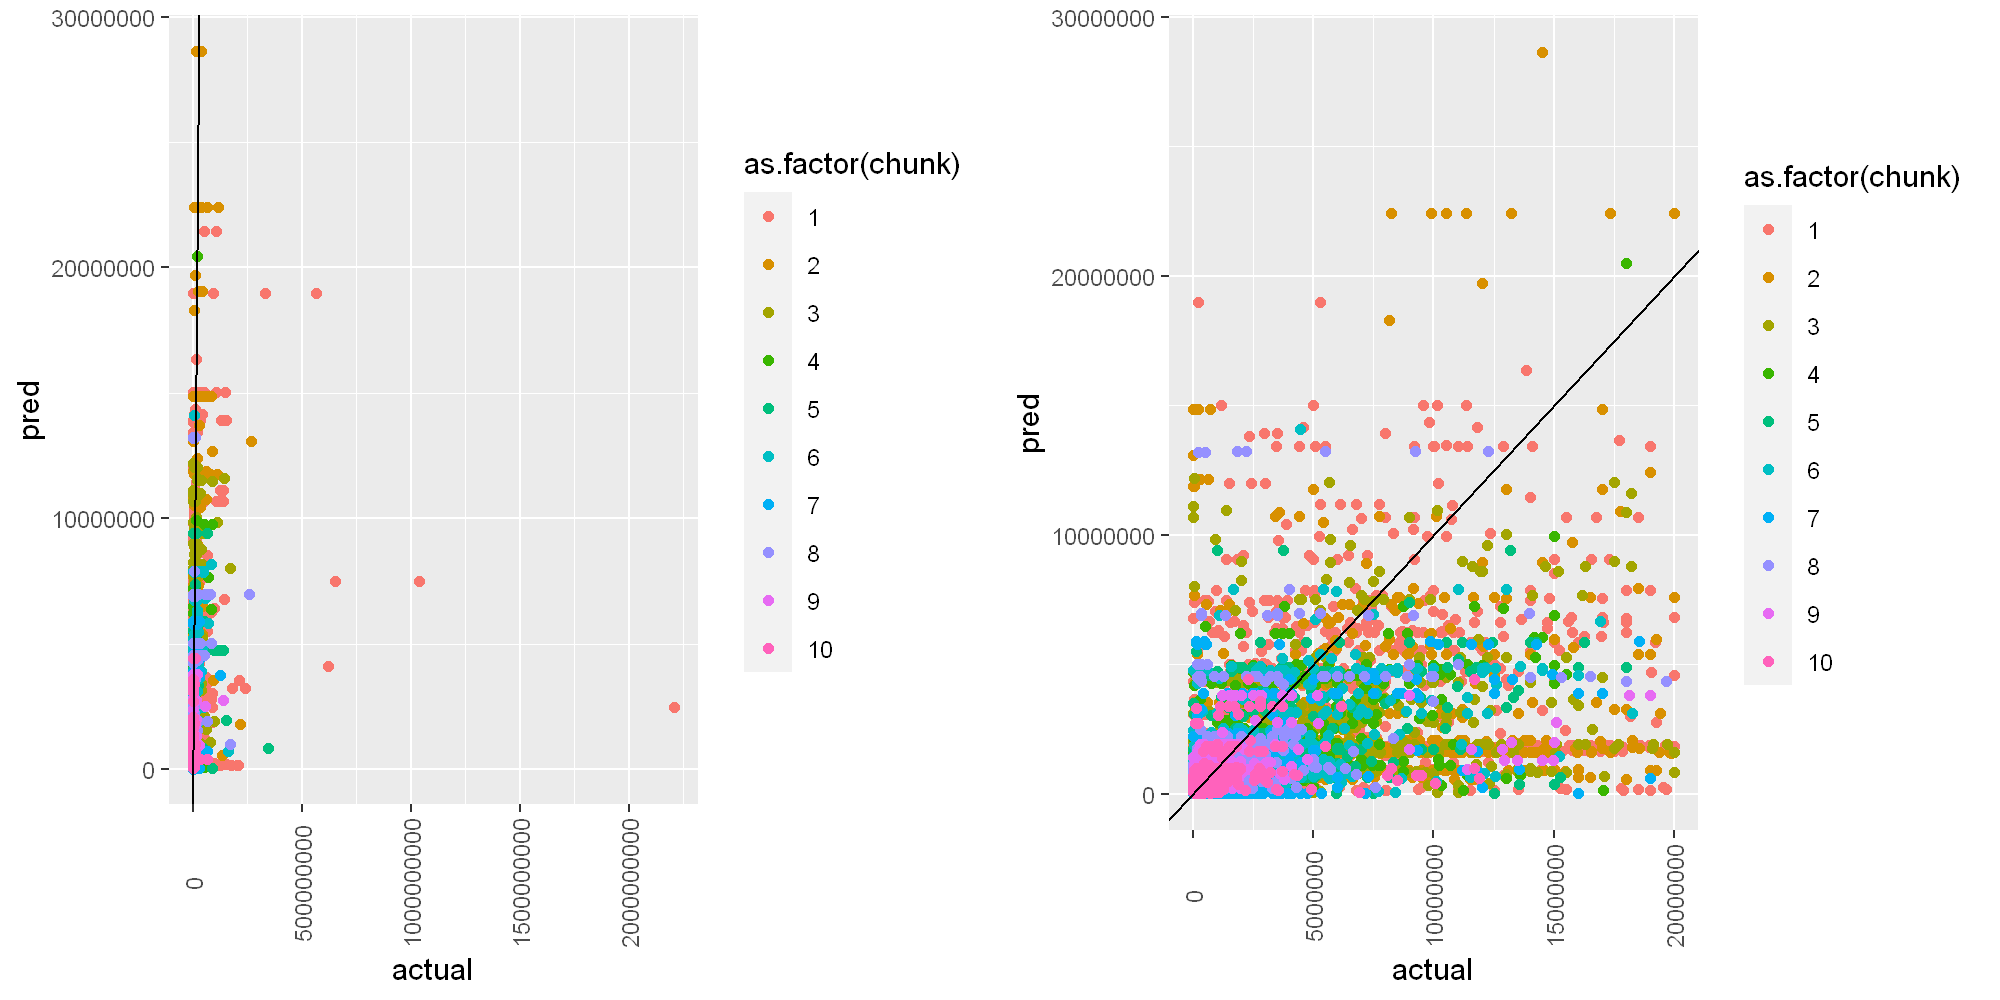

In [125]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) # for graph sizes
p1 = ggplot(data = pred_table, aes(x = actual, y = pred, color = as.factor(chunk))) + geom_point() + geom_abline(intercept = 0, slope = 1)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))
p2 = ggplot(data = pred_table[actual < 20000000], aes(x = actual, y = pred, color = as.factor(chunk))) + geom_point() + geom_abline(intercept = 0, slope = 1) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

grid.arrange(p1,p2, ncol = 2)

**Based on borough**

Warning message in as.data.table.list(jval, .named = NULL):
"Item 3 has 57439 rows but longest item has 57445; recycled with remainder."


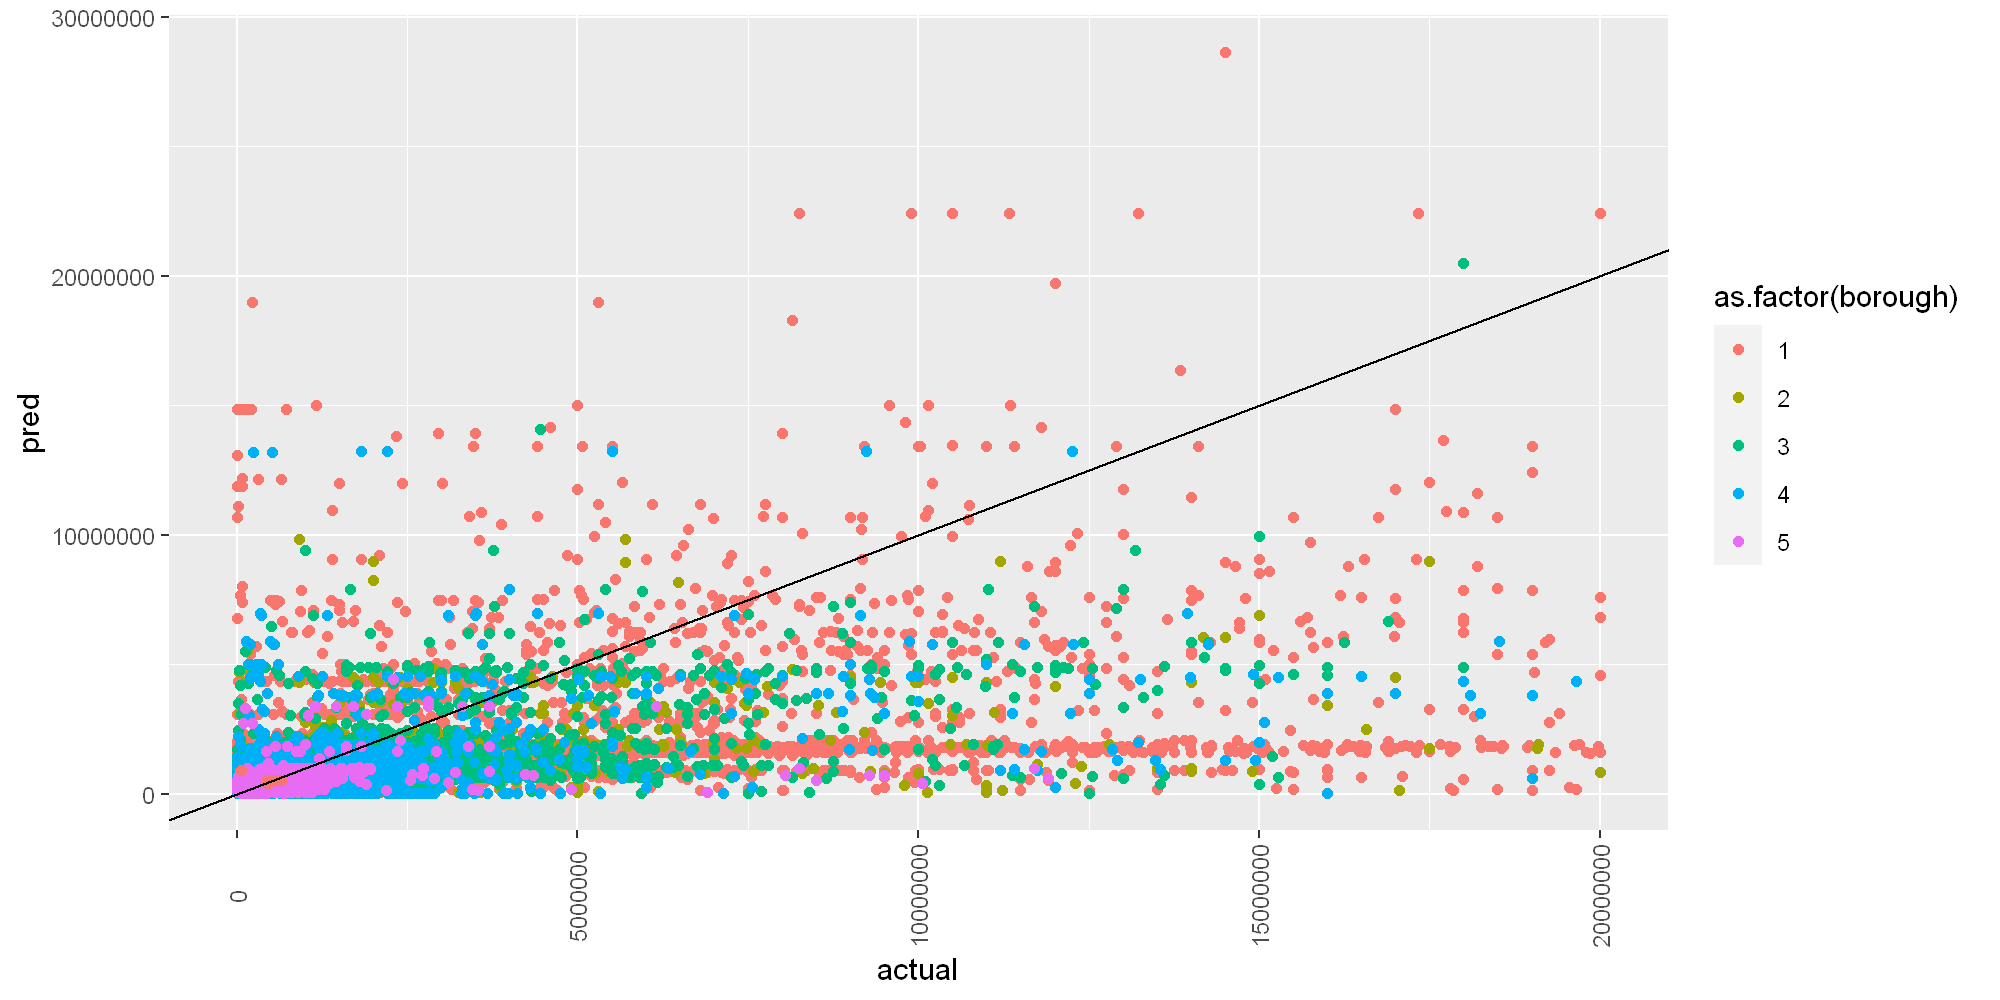

In [126]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) # for graph sizes
ggplot(data = pred_table[actual < 20000000,.(actual, pred, borough = dt[saleprice < 20000000]$borough)]
       , aes(x = actual, y = pred, color = as.factor(borough))) + geom_point() + geom_abline(intercept = 0, slope = 1) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))


Predictions are generally below actual sale prices. It seems that outliers in the training set causes problems.

But before that, lets try to address each borough and building class pair separately.

## XGBoost Based on Borough & Building Class

If we study partial models, it is important that we eliminated the outliers because with target = saleprice, rmse increases drastically. 

In [127]:
feature_list = c( "zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                )
target = "saleprice"

fit_bb = model_xgboost_partial(feature_list,target,chunk_no = 5)

pred_table_bb = fit_bb[[1]]

imp_table_bb = fit_bb[[2]]
imp_table_bb
## target = saleprice
print("overall test rmse:")
calc_rmse(pred_table_bb$pred,pred_table_bb$actual)
calc_rmse(pred_table_bb[actual < 20000000]$pred,pred_table_bb[actual < 20000000]$actual)


Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:5713704.500000	test-rmse:9591128.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:4919245.500000	test-rmse:9290110.000000 
[3]	train-rmse:4408553.000000	test-rmse:9133765.000000 
[4]	train-rmse:4009983.000000	test-rmse:9001239.000000 
[5]	train-rmse:3759177.500000	test-rmse:8954834.000000 
[6]	train-rmse:3552701.750000	test-rmse:8928165.000000 
[7]	train-rmse:3405038.000000	test-rmse:8920197.000000 
[8]	train-rmse:3300301.250000	test-rmse:8884942.000000 
[9]	train-rmse:3234957.500000	test-rmse:8886349.000000 
[10]	train-rmse:3179999.250000	test-rmse:8893731.000000 
[11]	train-rmse:3120129.750000	test-rmse:8893089.000000 
Stopping. Best iteration:
[8]	train-rmse:3300301.250000	test-rmse:8884942.000000

[1]	train-rmse:6388114.000000	test-rmse:6517715.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't impro

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8938046.000000	test-rmse:10163435.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7632638.500000	test-rmse:12163311.000000 
[3]	train-rmse:6554452.500000	test-rmse:14727506.000000 
[4]	train-rmse:5662910.000000	test-rmse:17117018.000000 
Stopping. Best iteration:
[1]	train-rmse:8938046.000000	test-rmse:10163435.000000

[1]	train-rmse:5376536.000000	test-rmse:19082548.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:4534164.000000	test-rmse:19002100.000000 
[3]	train-rmse:3898312.500000	test-rmse:18973668.000000 
[4]	train-rmse:3413629.500000	test-rmse:18987814.000000 
[5]	train-rmse:3053340.750000	test-rmse:19018570.000000 
[6]	train-rmse:2785515.500000	test-rmse:19044254.000000 
Stopping. Best iteration:
[3]	train-rmse:3898312.500000	test-rmse:18973668.000000

[1

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:6040739.500000	test-rmse:5613885.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5731368.000000	test-rmse:5321536.000000 
[3]	train-rmse:5565285.000000	test-rmse:5180362.000000 
[4]	train-rmse:5409315.500000	test-rmse:5146421.500000 
[5]	train-rmse:5350009.000000	test-rmse:5151418.000000 
[6]	train-rmse:5278820.500000	test-rmse:5187229.000000 
[7]	train-rmse:5246700.000000	test-rmse:5230003.500000 
Stopping. Best iteration:
[4]	train-rmse:5409315.500000	test-rmse:5146421.500000

[1]	train-rmse:6152971.500000	test-rmse:5413611.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5886792.500000	test-rmse:5157612.000000 
[3]	train-rmse:5646637.500000	test-rmse:5013506.500000 
[4]	train-rmse:5562035.500000	test-rmse:4873689.500000 
[5]	train-rmse:5433150.500000	test-rmse:

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:119696352.000000	test-rmse:165644368.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:102578400.000000	test-rmse:163231376.000000 
[3]	train-rmse:88399968.000000	test-rmse:161468800.000000 
[4]	train-rmse:76445984.000000	test-rmse:160470064.000000 
[5]	train-rmse:66703176.000000	test-rmse:158864192.000000 
[6]	train-rmse:58742452.000000	test-rmse:157864048.000000 
[7]	train-rmse:52039008.000000	test-rmse:157490192.000000 
[8]	train-rmse:46751676.000000	test-rmse:157244960.000000 
[9]	train-rmse:42109248.000000	test-rmse:155362048.000000 
[10]	train-rmse:38484016.000000	test-rmse:155129488.000000 
[11]	train-rmse:35565996.000000	test-rmse:155021856.000000 
[12]	train-rmse:33352072.000000	test-rmse:154899344.000000 
[13]	train-rmse:31588516.000000	test-rmse:154819200.000000 
[14]	train-rmse:30302674.000000	test-rmse:154811616.000000 
[15]	train-rmse:29293676.000000	test

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9405757.000000	test-rmse:10219531.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7925381.000000	test-rmse:9555580.000000 
[3]	train-rmse:6976979.500000	test-rmse:9039661.000000 
[4]	train-rmse:6397596.500000	test-rmse:7914185.000000 
[5]	train-rmse:6028932.500000	test-rmse:7700378.000000 
[6]	train-rmse:5810976.000000	test-rmse:7515632.500000 
[7]	train-rmse:5684246.000000	test-rmse:7331613.000000 
[8]	train-rmse:5613926.500000	test-rmse:7184148.000000 
[9]	train-rmse:5569502.000000	test-rmse:6921661.000000 
[10]	train-rmse:5545552.500000	test-rmse:6841195.000000 
[11]	train-rmse:5530642.000000	test-rmse:6721123.000000 
[12]	train-rmse:5520577.500000	test-rmse:6693953.500000 
[13]	train-rmse:5513828.000000	test-rmse:6617387.500000 
[14]	train-rmse:5509716.500000	test-rmse:6598136.000000 
[15]	train-rmse:5507169.500000	test-rmse:6590658.000000 
[16]	train-rmse:550562

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:4969931.000000	test-rmse:6960448.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:3971531.500000	test-rmse:6296238.000000 
[3]	train-rmse:3230871.500000	test-rmse:5812261.500000 
[4]	train-rmse:2682731.000000	test-rmse:5659360.500000 
[5]	train-rmse:2283322.250000	test-rmse:5106778.000000 
[6]	train-rmse:1975804.500000	test-rmse:5078865.500000 
[7]	train-rmse:1754765.875000	test-rmse:5063322.000000 
[8]	train-rmse:1592207.250000	test-rmse:5056497.500000 
[9]	train-rmse:1477436.750000	test-rmse:5055735.500000 
[10]	train-rmse:1400949.500000	test-rmse:4980608.000000 
[11]	train-rmse:1348519.500000	test-rmse:4922331.000000 
[12]	train-rmse:1309186.625000	test-rmse:4918497.500000 
[13]	train-rmse:1280081.125000	test-rmse:4944883.000000 
[14]	train-rmse:1259330.125000	test-rmse:4969106.500000 
[15]	train-rmse:1244619.750000	test-rmse:4990643.000000 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1879447.000000	test-rmse:4508587.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1519908.500000	test-rmse:4248733.500000 
[3]	train-rmse:1278278.375000	test-rmse:4027588.250000 
[4]	train-rmse:1112288.500000	test-rmse:3869586.000000 
[5]	train-rmse:994333.937500	test-rmse:3801905.250000 
[6]	train-rmse:922084.312500	test-rmse:3710865.750000 
[7]	train-rmse:869958.375000	test-rmse:3686040.750000 
[8]	train-rmse:833964.250000	test-rmse:3661386.000000 
[9]	train-rmse:809080.875000	test-rmse:3652012.750000 
[10]	train-rmse:789402.625000	test-rmse:3635615.500000 
[11]	train-rmse:776996.500000	test-rmse:3639627.000000 
[12]	train-rmse:766498.562500	test-rmse:3633216.250000 
[13]	train-rmse:757857.437500	test-rmse:3633350.750000 
[14]	train-rmse:752507.312500	test-rmse:3632966.250000 
[15]	train-rmse:746039.062500	test-rmse:3626616.250000 
[16]	train-rmse:743292.625000	test

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:3957569.250000	test-rmse:3813776.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:3475568.000000	test-rmse:3615714.000000 
[3]	train-rmse:3165418.500000	test-rmse:3632355.250000 
[4]	train-rmse:2848835.750000	test-rmse:3712686.000000 
[5]	train-rmse:2625347.500000	test-rmse:3875362.250000 
Stopping. Best iteration:
[2]	train-rmse:3475568.000000	test-rmse:3615714.000000

[1]	train-rmse:3186154.000000	test-rmse:6832414.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2735878.500000	test-rmse:6203505.000000 
[3]	train-rmse:2396304.750000	test-rmse:5885531.500000 
[4]	train-rmse:2128031.500000	test-rmse:5645268.000000 
[5]	train-rmse:1918104.500000	test-rmse:5418400.500000 
[6]	train-rmse:1760304.250000	test-rmse:5246067.500000 
[7]	train-rmse:1630541.625000	test-rmse:

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:981683.437500	test-rmse:1563757.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:809818.375000	test-rmse:1587125.750000 
[3]	train-rmse:678065.937500	test-rmse:1643142.750000 
[4]	train-rmse:578361.312500	test-rmse:1708893.000000 
Stopping. Best iteration:
[1]	train-rmse:981683.437500	test-rmse:1563757.500000

[1]	train-rmse:1162764.375000	test-rmse:377265.812500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:950495.312500	test-rmse:417504.718750 
[3]	train-rmse:786767.437500	test-rmse:534337.187500 
[4]	train-rmse:661221.187500	test-rmse:654647.437500 
Stopping. Best iteration:
[1]	train-rmse:1162764.375000	test-rmse:377265.812500

[1]	train-rmse:1186593.125000	test-rmse:101784.679688 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:7817797.000000	test-rmse:3536962.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6804571.500000	test-rmse:3464171.000000 
[3]	train-rmse:6022244.000000	test-rmse:3419261.500000 
[4]	train-rmse:5388860.000000	test-rmse:3379279.500000 
[5]	train-rmse:4977097.000000	test-rmse:3374434.500000 
[6]	train-rmse:4669593.000000	test-rmse:3400423.250000 
[7]	train-rmse:4179075.000000	test-rmse:3414906.250000 
[8]	train-rmse:3959261.000000	test-rmse:3436597.000000 
Stopping. Best iteration:
[5]	train-rmse:4977097.000000	test-rmse:3374434.500000

[1]	train-rmse:7849339.500000	test-rmse:2949789.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6784648.000000	test-rmse:3066343.750000 
[3]	train-rmse:5928500.000000	test-rmse:3593534.000000 
[4]	train-rmse:5226660.000000	test-rmse:

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:618077.125000	test-rmse:240689.703125 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:542501.250000	test-rmse:172092.125000 
[3]	train-rmse:498440.781250	test-rmse:136528.125000 
[4]	train-rmse:473491.218750	test-rmse:125563.531250 
[5]	train-rmse:459402.187500	test-rmse:124583.695312 
[6]	train-rmse:451368.562500	test-rmse:127355.648438 
[7]	train-rmse:446804.625000	test-rmse:132202.718750 
[8]	train-rmse:444157.781250	test-rmse:135981.609375 
Stopping. Best iteration:
[5]	train-rmse:459402.187500	test-rmse:124583.695312

[1]	train-rmse:546793.750000	test-rmse:695684.125000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:488410.500000	test-rmse:626426.375000 
[3]	train-rmse:455055.562500	test-rmse:584412.812500 
[4]	train-rmse:436603.093750	test-rmse:563392.062500 
[5]	train-

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:381680.093750	test-rmse:366662.468750 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:295880.406250	test-rmse:286085.906250 
[3]	train-rmse:242027.203125	test-rmse:233891.187500 
[4]	train-rmse:210054.578125	test-rmse:203334.468750 
[5]	train-rmse:191574.156250	test-rmse:187284.453125 
[6]	train-rmse:181820.968750	test-rmse:179297.718750 
[7]	train-rmse:176319.375000	test-rmse:175873.390625 
[8]	train-rmse:173681.250000	test-rmse:174808.796875 
[9]	train-rmse:172073.390625	test-rmse:174076.078125 
[10]	train-rmse:171260.078125	test-rmse:174209.062500 
[11]	train-rmse:170659.656250	test-rmse:174332.234375 
[12]	train-rmse:170374.937500	test-rmse:174238.515625 
Stopping. Best iteration:
[9]	train-rmse:172073.390625	test-rmse:174076.078125

[1]	train-rmse:373174.062500	test-rmse:393011.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:2190132.000000	test-rmse:1575229.250000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1975286.250000	test-rmse:1319403.125000 
[3]	train-rmse:1839436.125000	test-rmse:1188508.625000 
[4]	train-rmse:1733642.000000	test-rmse:1131386.375000 
[5]	train-rmse:1678510.375000	test-rmse:1086495.875000 
[6]	train-rmse:1635338.625000	test-rmse:1089178.000000 
[7]	train-rmse:1596151.750000	test-rmse:1119782.250000 
[8]	train-rmse:1569620.000000	test-rmse:1151212.250000 
Stopping. Best iteration:
[5]	train-rmse:1678510.375000	test-rmse:1086495.875000

[1]	train-rmse:2146260.250000	test-rmse:1886774.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1930101.625000	test-rmse:1701305.250000 
[3]	train-rmse:1791096.125000	test-rmse:1590748.625000 
[4]	train-rmse:1703774.625000	test-rmse:

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:3357434.500000	test-rmse:1752655.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2784219.750000	test-rmse:1690425.500000 
[3]	train-rmse:2377457.750000	test-rmse:1649112.375000 
[4]	train-rmse:2049933.125000	test-rmse:1626279.625000 
[5]	train-rmse:1789711.625000	test-rmse:1559282.000000 
[6]	train-rmse:1611617.500000	test-rmse:1554552.000000 
[7]	train-rmse:1464206.875000	test-rmse:1489457.625000 
[8]	train-rmse:1353487.125000	test-rmse:1326832.375000 
[9]	train-rmse:1270613.375000	test-rmse:1314210.750000 
[10]	train-rmse:1206285.750000	test-rmse:1314845.375000 
[11]	train-rmse:1156091.250000	test-rmse:1324212.250000 
[12]	train-rmse:1120081.625000	test-rmse:1330268.125000 
Stopping. Best iteration:
[9]	train-rmse:1270613.375000	test-rmse:1314210.750000

[1]	train-rmse:3038443.250000	test-rmse:3573433.750000 
Multiple eval metrics are present. Will use test_rmse fo

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:3073189.000000	test-rmse:2089022.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2751188.250000	test-rmse:2016791.750000 
[3]	train-rmse:2509056.000000	test-rmse:1983912.125000 
[4]	train-rmse:2328369.500000	test-rmse:1967785.375000 
[5]	train-rmse:2193702.750000	test-rmse:1958780.375000 
[6]	train-rmse:2092127.625000	test-rmse:1953797.125000 
[7]	train-rmse:2016937.125000	test-rmse:1951975.000000 
[8]	train-rmse:1961698.750000	test-rmse:1951524.000000 
[9]	train-rmse:1921325.500000	test-rmse:1951308.875000 
[10]	train-rmse:1891296.875000	test-rmse:1948667.625000 
[11]	train-rmse:1868821.500000	test-rmse:1947980.875000 
[12]	train-rmse:1852730.500000	test-rmse:1946299.750000 
[13]	train-rmse:1841185.375000	test-rmse:1946407.875000 
[14]	train-rmse:1832299.000000	test-rmse:1947018.000000 
[15]	train-rmse:1826227.625000	test-rmse:1947249.000000 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:14326104.000000	test-rmse:3971924.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:12260562.000000	test-rmse:3663572.750000 
[3]	train-rmse:10679911.000000	test-rmse:3536341.500000 
[4]	train-rmse:9488357.000000	test-rmse:3587648.750000 
[5]	train-rmse:8586038.000000	test-rmse:3684673.500000 
[6]	train-rmse:7921149.500000	test-rmse:3802383.250000 
Stopping. Best iteration:
[3]	train-rmse:10679911.000000	test-rmse:3536341.500000

[1]	train-rmse:14127263.000000	test-rmse:6240130.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:12078039.000000	test-rmse:5772019.000000 
[3]	train-rmse:10522072.000000	test-rmse:5697583.500000 
[4]	train-rmse:9366390.000000	test-rmse:5780395.500000 
[5]	train-rmse:8492793.000000	test-rmse:5919072.000000 
[6]	train-rmse:7836780.500000	tes

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:958022.062500	test-rmse:1265520.250000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:788586.312500	test-rmse:1079757.500000 
[3]	train-rmse:681382.000000	test-rmse:950282.250000 
[4]	train-rmse:614713.750000	test-rmse:865693.875000 
[5]	train-rmse:574185.312500	test-rmse:828464.812500 
[6]	train-rmse:548493.187500	test-rmse:797360.812500 
[7]	train-rmse:533798.875000	test-rmse:780683.687500 
[8]	train-rmse:525392.937500	test-rmse:776991.062500 
[9]	train-rmse:520698.218750	test-rmse:781586.312500 
[10]	train-rmse:515125.875000	test-rmse:773997.312500 
[11]	train-rmse:509396.000000	test-rmse:775668.375000 
[12]	train-rmse:507072.218750	test-rmse:789248.125000 
[13]	train-rmse:505765.718750	test-rmse:795586.812500 
Stopping. Best iteration:
[10]	train-rmse:515125.875000	test-rmse:773997.312500

[1]	train-rmse:1047288.937500	test-rmse:842300.812500 
Multiple eval metrics are

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:897049.000000	test-rmse:991457.812500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:718003.375000	test-rmse:796099.187500 
[3]	train-rmse:607295.937500	test-rmse:697498.937500 
[4]	train-rmse:540262.375000	test-rmse:645089.125000 
[5]	train-rmse:501753.437500	test-rmse:615789.250000 
[6]	train-rmse:481209.500000	test-rmse:611623.437500 
[7]	train-rmse:470245.500000	test-rmse:607780.437500 
[8]	train-rmse:463756.062500	test-rmse:616188.875000 
[9]	train-rmse:457513.562500	test-rmse:619106.625000 
[10]	train-rmse:452719.437500	test-rmse:620528.750000 
Stopping. Best iteration:
[7]	train-rmse:470245.500000	test-rmse:607780.437500

[1]	train-rmse:884589.375000	test-rmse:1092470.625000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:704498.750000	test-rmse:953037.812500 
[3]	trai

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1329938.875000	test-rmse:2258990.250000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1119670.000000	test-rmse:1952489.875000 
[3]	train-rmse:975005.750000	test-rmse:1702960.375000 
[4]	train-rmse:879509.562500	test-rmse:1531079.500000 
[5]	train-rmse:819652.187500	test-rmse:1423289.125000 
[6]	train-rmse:779556.875000	test-rmse:1334545.250000 
[7]	train-rmse:750230.125000	test-rmse:1284509.625000 
[8]	train-rmse:732778.937500	test-rmse:1242930.375000 
[9]	train-rmse:720177.375000	test-rmse:1221563.750000 
[10]	train-rmse:712703.500000	test-rmse:1205020.125000 
[11]	train-rmse:707950.500000	test-rmse:1191574.625000 
[12]	train-rmse:704732.500000	test-rmse:1181482.125000 
[13]	train-rmse:702601.687500	test-rmse:1174870.875000 
[14]	train-rmse:700146.687500	test-rmse:1175826.375000 
[15]	train-rmse:694588.437500	test-rmse:1170398.000000 
[16]	train-rmse:691408.437500	test-r

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1962014.875000	test-rmse:4763253.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1803956.250000	test-rmse:4593502.500000 
[3]	train-rmse:1714571.375000	test-rmse:4491691.000000 
[4]	train-rmse:1654562.875000	test-rmse:4496856.000000 
[5]	train-rmse:1618062.125000	test-rmse:4505612.000000 
[6]	train-rmse:1598437.375000	test-rmse:4497724.500000 
Stopping. Best iteration:
[3]	train-rmse:1714571.375000	test-rmse:4491691.000000

[1]	train-rmse:2783784.250000	test-rmse:1840767.875000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2475760.000000	test-rmse:2057946.250000 
[3]	train-rmse:2238617.250000	test-rmse:2425903.250000 
[4]	train-rmse:2061786.000000	test-rmse:2922986.250000 
Stopping. Best iteration:
[1]	train-rmse:2783784.250000	test-rmse:1840767.875000

[1]	train-rmse

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:907531.062500	test-rmse:991896.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:803805.500000	test-rmse:946356.812500 
[3]	train-rmse:745185.937500	test-rmse:929166.750000 
[4]	train-rmse:713405.625000	test-rmse:922373.000000 
[5]	train-rmse:696441.250000	test-rmse:919762.750000 
[6]	train-rmse:687213.875000	test-rmse:918918.687500 
[7]	train-rmse:682223.812500	test-rmse:919693.687500 
[8]	train-rmse:679642.187500	test-rmse:921035.875000 
[9]	train-rmse:678220.312500	test-rmse:920862.750000 
Stopping. Best iteration:
[6]	train-rmse:687213.875000	test-rmse:918918.687500

[1]	train-rmse:765598.750000	test-rmse:1423663.125000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:646238.187500	test-rmse:1385953.125000 
[3]	train-rmse:572603.312500	test-rmse:1362525.000000 
[4]	tra

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:14780164.000000	test-rmse:3646065.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:14190717.000000	test-rmse:3502647.250000 
[3]	train-rmse:13791092.000000	test-rmse:3618938.750000 
[4]	train-rmse:13522116.000000	test-rmse:3908333.750000 
[5]	train-rmse:13379988.000000	test-rmse:4258624.500000 
Stopping. Best iteration:
[2]	train-rmse:14190717.000000	test-rmse:3502647.250000

[1]	train-rmse:14342233.000000	test-rmse:8177737.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:13796387.000000	test-rmse:8316248.500000 
[3]	train-rmse:13462925.000000	test-rmse:8572361.000000 
[4]	train-rmse:13264718.000000	test-rmse:8968611.000000 
Stopping. Best iteration:
[1]	train-rmse:14342233.000000	test-rmse:8177737.500000

[1]	train-rmse:7066117.500000	test-rmse:27080934.000000 
Mu

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:487945.031250	test-rmse:584987.812500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:370993.937500	test-rmse:455615.656250 
[3]	train-rmse:296175.125000	test-rmse:377518.468750 
[4]	train-rmse:250514.281250	test-rmse:334608.562500 
[5]	train-rmse:224295.921875	test-rmse:310896.531250 
[6]	train-rmse:209166.468750	test-rmse:295379.000000 
[7]	train-rmse:201351.093750	test-rmse:287370.875000 
[8]	train-rmse:196991.125000	test-rmse:283949.937500 
[9]	train-rmse:193982.718750	test-rmse:281877.218750 
[10]	train-rmse:192403.218750	test-rmse:282069.156250 
[11]	train-rmse:191562.656250	test-rmse:281549.156250 
[12]	train-rmse:191039.843750	test-rmse:281033.218750 
[13]	train-rmse:190521.031250	test-rmse:281383.625000 
[14]	train-rmse:190042.656250	test-rmse:280964.250000 
[15]	train-rmse:189871.062500	test-rmse:281078.218750 
[16]	train-rmse:189645.703125	test-rmse:281130.593750

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:570781.500000	test-rmse:642526.562500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:444411.437500	test-rmse:487968.843750 
[3]	train-rmse:365822.000000	test-rmse:402141.156250 
[4]	train-rmse:319413.625000	test-rmse:364873.531250 
[5]	train-rmse:293524.906250	test-rmse:350457.906250 
[6]	train-rmse:279563.781250	test-rmse:347787.968750 
[7]	train-rmse:272106.781250	test-rmse:350169.750000 
[8]	train-rmse:268224.375000	test-rmse:353670.375000 
[9]	train-rmse:266093.000000	test-rmse:357499.562500 
Stopping. Best iteration:
[6]	train-rmse:279563.781250	test-rmse:347787.968750

[1]	train-rmse:572330.250000	test-rmse:690395.312500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:448884.062500	test-rmse:547657.062500 
[3]	train-rmse:372529.031250	test-rmse:463490.375000 
[4]	train-

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:544016.625000	test-rmse:355413.593750 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:460638.968750	test-rmse:271826.781250 
[3]	train-rmse:398143.656250	test-rmse:227381.937500 
[4]	train-rmse:353674.750000	test-rmse:190304.390625 
[5]	train-rmse:320672.062500	test-rmse:181450.718750 
[6]	train-rmse:298093.000000	test-rmse:173805.781250 
[7]	train-rmse:281211.875000	test-rmse:177632.343750 
[8]	train-rmse:269592.781250	test-rmse:178269.921875 
[9]	train-rmse:260832.593750	test-rmse:179039.328125 
Stopping. Best iteration:
[6]	train-rmse:298093.000000	test-rmse:173805.781250

[1]	train-rmse:569782.937500	test-rmse:134327.921875 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:480534.187500	test-rmse:97179.671875 
[3]	train-rmse:414493.125000	test-rmse:79181.039062 
[4]	train-rm

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:197759.437500	test-rmse:117078.296875 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:154051.937500	test-rmse:66769.843750 
[3]	train-rmse:124926.757812	test-rmse:44574.132812 
[4]	train-rmse:106305.242188	test-rmse:49866.984375 
[5]	train-rmse:94933.296875	test-rmse:64016.640625 
[6]	train-rmse:88275.265625	test-rmse:77155.679688 
Stopping. Best iteration:
[3]	train-rmse:124926.757812	test-rmse:44574.132812

[1]	train-rmse:199167.562500	test-rmse:136166.265625 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:156948.156250	test-rmse:97156.679688 
[3]	train-rmse:128694.875000	test-rmse:72795.656250 
[4]	train-rmse:110513.804688	test-rmse:59629.863281 
[5]	train-rmse:99272.351562	test-rmse:53726.796875 
[6]	train-rmse:92609.718750	test-rmse:52128.730469 
[7]	train-rmse:88776.3906

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:461487.968750	test-rmse:234660.125000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:429372.593750	test-rmse:179350.609375 
[3]	train-rmse:412150.718750	test-rmse:147300.531250 
[4]	train-rmse:402769.968750	test-rmse:127062.515625 
[5]	train-rmse:397870.156250	test-rmse:119944.023438 
[6]	train-rmse:395353.625000	test-rmse:117485.171875 
[7]	train-rmse:394034.218750	test-rmse:117000.414062 
[8]	train-rmse:393310.687500	test-rmse:116488.062500 
[9]	train-rmse:392923.750000	test-rmse:117574.234375 
[10]	train-rmse:392719.718750	test-rmse:117930.687500 
[11]	train-rmse:392601.281250	test-rmse:119669.156250 
Stopping. Best iteration:
[8]	train-rmse:393310.687500	test-rmse:116488.062500

[1]	train-rmse:461213.125000	test-rmse:230588.875000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	trai

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1712099.875000	test-rmse:10610785.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1487928.250000	test-rmse:10581957.000000 
[3]	train-rmse:1330445.750000	test-rmse:10299444.000000 
[4]	train-rmse:1219383.000000	test-rmse:10079225.000000 
[5]	train-rmse:1143377.875000	test-rmse:10075780.000000 
[6]	train-rmse:1088605.250000	test-rmse:10074536.000000 
[7]	train-rmse:1029789.187500	test-rmse:10074235.000000 
[8]	train-rmse:989705.375000	test-rmse:10074907.000000 
[9]	train-rmse:961205.687500	test-rmse:10075336.000000 
[10]	train-rmse:941328.875000	test-rmse:10076025.000000 
Stopping. Best iteration:
[7]	train-rmse:1029789.187500	test-rmse:10074235.000000

[1]	train-rmse:4946422.500000	test-rmse:1230471.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:4339546.500000	t

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:454777.468750	test-rmse:349818.531250 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:367748.000000	test-rmse:260058.062500 
[3]	train-rmse:315013.968750	test-rmse:205199.609375 
[4]	train-rmse:284267.062500	test-rmse:174287.000000 
[5]	train-rmse:267368.906250	test-rmse:158794.109375 
[6]	train-rmse:258209.265625	test-rmse:152121.171875 
[7]	train-rmse:253306.484375	test-rmse:150209.218750 
[8]	train-rmse:250714.156250	test-rmse:150331.375000 
[9]	train-rmse:249332.093750	test-rmse:151252.281250 
[10]	train-rmse:248591.671875	test-rmse:151804.062500 
Stopping. Best iteration:
[7]	train-rmse:253306.484375	test-rmse:150209.218750

[1]	train-rmse:445083.937500	test-rmse:410443.781250 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:359585.156250	test-rmse:321942.875000 
[3]	train

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:452676.906250	test-rmse:468433.281250 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:346289.625000	test-rmse:360062.562500 
[3]	train-rmse:279332.125000	test-rmse:294823.500000 
[4]	train-rmse:238669.750000	test-rmse:252006.265625 
[5]	train-rmse:215669.265625	test-rmse:230443.250000 
[6]	train-rmse:203157.640625	test-rmse:220645.687500 
[7]	train-rmse:196282.859375	test-rmse:216486.718750 
[8]	train-rmse:192732.812500	test-rmse:216089.593750 
[9]	train-rmse:190934.843750	test-rmse:217067.171875 
[10]	train-rmse:190023.921875	test-rmse:218331.390625 
[11]	train-rmse:189414.890625	test-rmse:218385.859375 
Stopping. Best iteration:
[8]	train-rmse:192732.812500	test-rmse:216089.593750

[1]	train-rmse:457304.281250	test-rmse:440562.468750 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	trai

borough b_class_group Feature                avg_gain    
1   1       c             residentialunits_group 0.2937428039
2   1       c             zipcode                0.4084550693
3   1       c             commercialunits_group  0.1715820831
4   1       c             building_clusters      0.0580763391
5   1       c             address_encoded        0.0168728132
6   1       c             highly_commercial      0.0469376615
7   1       c             taxclass_present       0.0043332299
8   1       d             address_encoded        0.2037620779
9   1       d             zipcode                0.3827269146
10  1       d             commercialunits_group  0.3224240439
11  1       d             residentialunits_group 0.0451528644
12  1       d             highly_commercial      0.0456401108
13  1       d             building_clusters      0.0003674855
14  1       r             zipcode                0.4861105953
15  1       r             address_encoded        0.1166941505
16  1       r             highly_commercial      0.0797937770
17  1       r             building_clusters      0.0707019925
18  1       r             residentialunits_group 0.1515167633
19  1       r             onlycommercial         0.0157512079
20  1       r             taxclass_present       0.0433420204
21  1       r             commercialunits_group  0.0360894932
22  1       other         zipcode                0.8477662618
23  1       other         address_encoded        0.0137963030
24  1       other         highly_commercial      0.0062322588
25  1       other         commercialunits_group  0.0297526775
26  1       other         onlycommercial         0.0037001928
27  1       other         residentialunits_group 0.0018897637
28  1       other         taxclass_present       0.0015418925
29  1       other         building_clusters      0.1588677497
30  1       a             zipcode                0.6324058083
... ...     ...           ...                    ...         
148 5       c             address_encoded        0.1115904871
149 5       c             zipcode                0.1118430520
150 5       c             highly_commercial      0.0301853410
151 5       c             residentialunits_group 0.0144243963
152 5       d             address_encoded        0.9134361040
153 5       d             zipcode                0.0853566261
154 5       d             residentialunits_group 0.0228482439
155 5       r             zipcode                0.4993820216
156 5       r             address_encoded        0.2397504148
157 5       r             taxclass_present       0.1792777672
158 5       r             residentialunits_group 0.0300517269
159 5       r             highly_commercial      0.0644225869
160 5       other         zipcode                0.3435289516
161 5       other         commercialunits_group  0.0437824098
162 5       other         address_encoded        0.0437216460
163 5       other         taxclass_present       0.0396350011
164 5       other         residentialunits_group 0.0224033786
165 5       other         building_clusters      0.0114576346
166 5       other         onlycommercial         0.0006561068
167 5       other         highly_commercial      0.6244114334
168 5       a             building_clusters      0.5988855051
169 5       a             zipcode                0.2230675595
170 5       a             address_encoded        0.1772067039
171 5       a             highly_commercial      0.0004990452
172 5       a             commercialunits_group  0.0004264829
173 5       b             zipcode                0.9016850409
174 5       b             address_encoded        0.0762516788
175 5       b             highly_commercial      0.0052097205
176 5       b             building_clusters      0.0168088961
177 5       b             commercialunits_group  0.0010866078

[1] "overall test rmse:"


[1] 12508010

[1] 4057898

In [128]:
feature_list = c( "zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                )
target = "saleprice_log"

fit_bb = model_xgboost_partial(feature_list,target,chunk_no = 5)

pred_table_bb = fit_bb[[1]]

imp_table_bb = fit_bb[[2]]
imp_table_bb
## target = saleprice
print("overall test rmse:")
calc_rmse(pred_table_bb$pred,pred_table_bb$actual)
calc_rmse(pred_table_bb[actual < 20000000]$pred,pred_table_bb[actual < 20000000]$actual)


Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.551880	test-rmse:9.360306 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.731550	test-rmse:6.639933 
[3]	train-rmse:4.767936	test-rmse:4.660577 
[4]	train-rmse:3.407883	test-rmse:3.283934 
[5]	train-rmse:2.469307	test-rmse:2.335088 
[6]	train-rmse:1.833810	test-rmse:1.696372 
[7]	train-rmse:1.414465	test-rmse:1.335357 
[8]	train-rmse:1.148255	test-rmse:1.159151 
[9]	train-rmse:0.979463	test-rmse:1.038631 
[10]	train-rmse:0.876598	test-rmse:0.966988 
[11]	train-rmse:0.814977	test-rmse:0.912099 
[12]	train-rmse:0.780391	test-rmse:0.935289 
[13]	train-rmse:0.759587	test-rmse:0.920370 
[14]	train-rmse:0.744901	test-rmse:0.956010 
Stopping. Best iteration:
[11]	train-rmse:0.814977	test-rmse:0.912099

[1]	train-rmse:9.479283	test-rmse:9.568768 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.309102	test-rmse:9.384217 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.547945	test-rmse:6.616454 
[3]	train-rmse:4.626319	test-rmse:4.687997 
[4]	train-rmse:3.294369	test-rmse:3.270407 
[5]	train-rmse:2.378831	test-rmse:2.307908 
[6]	train-rmse:1.762135	test-rmse:1.662663 
[7]	train-rmse:1.358284	test-rmse:1.276278 
[8]	train-rmse:1.102232	test-rmse:1.075275 
[9]	train-rmse:0.952034	test-rmse:0.995852 
[10]	train-rmse:0.866607	test-rmse:1.000012 
[11]	train-rmse:0.818396	test-rmse:0.989304 
[12]	train-rmse:0.792146	test-rmse:0.990235 
[13]	train-rmse:0.779057	test-rmse:1.015369 
[14]	train-rmse:0.771920	test-rmse:1.038820 
Stopping. Best iteration:
[11]	train-rmse:0.818396	test-rmse:0.989304

[1]	train-rmse:9.363312	test-rmse:9.043005 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.673349	test-rmse:9.797608 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.806695	test-rmse:6.880116 
[3]	train-rmse:4.809971	test-rmse:4.813921 
[4]	train-rmse:3.425525	test-rmse:3.402823 
[5]	train-rmse:2.474746	test-rmse:2.422370 
[6]	train-rmse:1.831525	test-rmse:1.837925 
[7]	train-rmse:1.411258	test-rmse:1.491259 
[8]	train-rmse:1.143227	test-rmse:1.247605 
[9]	train-rmse:0.984115	test-rmse:1.100770 
[10]	train-rmse:0.892594	test-rmse:1.028971 
[11]	train-rmse:0.844031	test-rmse:0.987988 
[12]	train-rmse:0.818005	test-rmse:0.967809 
[13]	train-rmse:0.804531	test-rmse:0.957609 
[14]	train-rmse:0.791329	test-rmse:0.957472 
[15]	train-rmse:0.787208	test-rmse:0.955146 
[16]	train-rmse:0.779598	test-rmse:0.955792 
[17]	train-rmse:0.777976	test-rmse:0.955268 
[18]	train-rmse:0.777124	test-rmse:0.954691 
[19]	train-rmse:0.771994	test-rmse:0.945783 
[20]	train-rmse:0.77020

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.388898	test-rmse:11.443415 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.380089	test-rmse:8.185637 
[3]	train-rmse:5.295609	test-rmse:5.935989 
[4]	train-rmse:3.870322	test-rmse:4.404634 
[5]	train-rmse:2.910508	test-rmse:3.367944 
[6]	train-rmse:2.257802	test-rmse:2.723271 
[7]	train-rmse:1.826787	test-rmse:2.320602 
[8]	train-rmse:1.539348	test-rmse:2.103516 
[9]	train-rmse:1.364664	test-rmse:1.997221 
[10]	train-rmse:1.251050	test-rmse:1.933154 
[11]	train-rmse:1.178749	test-rmse:1.916974 
[12]	train-rmse:1.128995	test-rmse:1.889381 
[13]	train-rmse:1.097334	test-rmse:1.889008 
[14]	train-rmse:1.068990	test-rmse:1.880653 
[15]	train-rmse:1.049461	test-rmse:1.876507 
[16]	train-rmse:1.039361	test-rmse:1.870676 
[17]	train-rmse:1.027800	test-rmse:1.878249 
[18]	train-rmse:1.017979	test-rmse:1.881472 
[19]	train-rmse:1.006376	test-rmse:1.879905 
Stopping. Best iterat

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.626890	test-rmse:10.602324 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.541463	test-rmse:7.510668 
[3]	train-rmse:5.384336	test-rmse:5.344944 
[4]	train-rmse:3.880072	test-rmse:3.812747 
[5]	train-rmse:2.846983	test-rmse:2.760466 
[6]	train-rmse:2.134816	test-rmse:2.041689 
[7]	train-rmse:1.636790	test-rmse:1.564116 
[8]	train-rmse:1.323769	test-rmse:1.260990 
[9]	train-rmse:1.102502	test-rmse:1.059724 
[10]	train-rmse:0.974419	test-rmse:1.008936 
[11]	train-rmse:0.887304	test-rmse:0.918896 
[12]	train-rmse:0.836107	test-rmse:0.868696 
[13]	train-rmse:0.804454	test-rmse:0.835382 
[14]	train-rmse:0.787559	test-rmse:0.830906 
[15]	train-rmse:0.775948	test-rmse:0.826653 
[16]	train-rmse:0.769098	test-rmse:0.815268 
[17]	train-rmse:0.764377	test-rmse:0.810871 
[18]	train-rmse:0.761579	test-rmse:0.807518 
[19]	train-rmse:0.759573	test-rmse:0.808824 
[20]	train-rmse:0.758

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.193358	test-rmse:10.722116 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.236953	test-rmse:7.748482 
[3]	train-rmse:5.169226	test-rmse:5.656140 
[4]	train-rmse:3.735078	test-rmse:4.187171 
[5]	train-rmse:2.755675	test-rmse:3.159646 
[6]	train-rmse:2.077898	test-rmse:2.393152 
[7]	train-rmse:1.615283	test-rmse:1.857600 
[8]	train-rmse:1.312534	test-rmse:1.489398 
[9]	train-rmse:1.114392	test-rmse:1.393675 
[10]	train-rmse:0.979362	test-rmse:1.333235 
[11]	train-rmse:0.899189	test-rmse:1.260703 
[12]	train-rmse:0.835521	test-rmse:1.241317 
[13]	train-rmse:0.794055	test-rmse:1.168477 
[14]	train-rmse:0.765281	test-rmse:1.171833 
[15]	train-rmse:0.746196	test-rmse:1.174588 
[16]	train-rmse:0.734278	test-rmse:1.152737 
[17]	train-rmse:0.726442	test-rmse:1.142159 
[18]	train-rmse:0.721078	test-rmse:1.134043 
[19]	train-rmse:0.716875	test-rmse:1.139279 
[20]	train-rmse:0.713

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.021288	test-rmse:9.080522 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.359286	test-rmse:6.418517 
[3]	train-rmse:4.500711	test-rmse:4.570905 
[4]	train-rmse:3.209853	test-rmse:3.286716 
[5]	train-rmse:2.321106	test-rmse:2.383809 
[6]	train-rmse:1.718175	test-rmse:1.764616 
[7]	train-rmse:1.316232	test-rmse:1.393778 
[8]	train-rmse:1.060911	test-rmse:1.147616 
[9]	train-rmse:0.904496	test-rmse:0.986216 
[10]	train-rmse:0.810071	test-rmse:0.908097 
[11]	train-rmse:0.746498	test-rmse:0.878104 
[12]	train-rmse:0.710640	test-rmse:0.841751 
[13]	train-rmse:0.688118	test-rmse:0.812458 
[14]	train-rmse:0.676119	test-rmse:0.793893 
[15]	train-rmse:0.667153	test-rmse:0.785138 
[16]	train-rmse:0.663139	test-rmse:0.774644 
[17]	train-rmse:0.657734	test-rmse:0.761490 
[18]	train-rmse:0.653759	test-rmse:0.759695 
[19]	train-rmse:0.650641	test-rmse:0.752154 
[20]	train-rmse:0.64809

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.335924	test-rmse:7.926149 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.865353	test-rmse:5.430678 
[3]	train-rmse:4.140767	test-rmse:3.794957 
[4]	train-rmse:2.939697	test-rmse:2.656463 
[5]	train-rmse:2.109566	test-rmse:1.887636 
[6]	train-rmse:1.545533	test-rmse:1.370913 
[7]	train-rmse:1.158444	test-rmse:1.083726 
[8]	train-rmse:0.908885	test-rmse:0.931598 
[9]	train-rmse:0.747630	test-rmse:0.906228 
[10]	train-rmse:0.652592	test-rmse:0.905269 
[11]	train-rmse:0.597170	test-rmse:0.920902 
[12]	train-rmse:0.567487	test-rmse:0.925148 
[13]	train-rmse:0.549714	test-rmse:0.947330 
Stopping. Best iteration:
[10]	train-rmse:0.652592	test-rmse:0.905269

[1]	train-rmse:8.262834	test-rmse:8.409632 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.818298	test-rmse:5.920496 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.161335	test-rmse:8.620878 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.762904	test-rmse:6.219589 
[3]	train-rmse:4.094057	test-rmse:4.461231 
[4]	train-rmse:2.942621	test-rmse:3.249793 
[5]	train-rmse:2.149594	test-rmse:2.470204 
[6]	train-rmse:1.615821	test-rmse:1.938085 
[7]	train-rmse:1.250596	test-rmse:1.545808 
[8]	train-rmse:1.025304	test-rmse:1.302690 
[9]	train-rmse:0.889713	test-rmse:1.176568 
[10]	train-rmse:0.798507	test-rmse:1.164954 
[11]	train-rmse:0.743876	test-rmse:1.184327 
[12]	train-rmse:0.712051	test-rmse:1.226648 
[13]	train-rmse:0.693870	test-rmse:1.270048 
Stopping. Best iteration:
[10]	train-rmse:0.798507	test-rmse:1.164954

[1]	train-rmse:8.281688	test-rmse:7.897488 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.850813	test-rmse:5.458279 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.317825	test-rmse:9.256829 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.613880	test-rmse:6.566730 
[3]	train-rmse:4.739000	test-rmse:4.751905 
[4]	train-rmse:3.455736	test-rmse:3.527051 
[5]	train-rmse:2.573594	test-rmse:2.745652 
[6]	train-rmse:1.981211	test-rmse:2.235021 
[7]	train-rmse:1.599507	test-rmse:1.942675 
[8]	train-rmse:1.348593	test-rmse:1.768627 
[9]	train-rmse:1.190990	test-rmse:1.644398 
[10]	train-rmse:1.092999	test-rmse:1.574854 
[11]	train-rmse:1.026490	test-rmse:1.545860 
[12]	train-rmse:0.975913	test-rmse:1.543410 
[13]	train-rmse:0.943763	test-rmse:1.540541 
[14]	train-rmse:0.920663	test-rmse:1.537985 
[15]	train-rmse:0.900311	test-rmse:1.536796 
[16]	train-rmse:0.887343	test-rmse:1.542820 
[17]	train-rmse:0.876574	test-rmse:1.540435 
[18]	train-rmse:0.867828	test-rmse:1.539952 
Stopping. Best iteration:
[15]	train-rmse:0.900311	test-rmse:1.53679

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.709073	test-rmse:8.368836 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.119796	test-rmse:5.790775 
[3]	train-rmse:4.314829	test-rmse:4.002976 
[4]	train-rmse:3.061286	test-rmse:2.798277 
[5]	train-rmse:2.196244	test-rmse:1.983177 
[6]	train-rmse:1.607498	test-rmse:1.466641 
[7]	train-rmse:1.216529	test-rmse:1.164305 
[8]	train-rmse:0.963890	test-rmse:1.012580 
[9]	train-rmse:0.808067	test-rmse:0.948699 
[10]	train-rmse:0.713642	test-rmse:0.931671 
[11]	train-rmse:0.660761	test-rmse:0.935780 
[12]	train-rmse:0.631766	test-rmse:0.947680 
[13]	train-rmse:0.617420	test-rmse:0.960650 
Stopping. Best iteration:
[10]	train-rmse:0.713642	test-rmse:0.931671

[1]	train-rmse:8.635538	test-rmse:8.835475 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.072495	test-rmse:6.270820 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.750348	test-rmse:8.712265 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.154364	test-rmse:6.119518 
[3]	train-rmse:4.347582	test-rmse:4.317407 
[4]	train-rmse:3.097787	test-rmse:3.074284 
[5]	train-rmse:2.243442	test-rmse:2.229235 
[6]	train-rmse:1.671890	test-rmse:1.669958 
[7]	train-rmse:1.301109	test-rmse:1.318222 
[8]	train-rmse:1.069640	test-rmse:1.109752 
[9]	train-rmse:0.933131	test-rmse:0.994724 
[10]	train-rmse:0.856685	test-rmse:0.934965 
[11]	train-rmse:0.815808	test-rmse:0.903670 
[12]	train-rmse:0.794633	test-rmse:0.888242 
[13]	train-rmse:0.783865	test-rmse:0.881756 
[14]	train-rmse:0.777776	test-rmse:0.877737 
[15]	train-rmse:0.774898	test-rmse:0.876854 
[16]	train-rmse:0.773373	test-rmse:0.876745 
[17]	train-rmse:0.772288	test-rmse:0.875787 
[18]	train-rmse:0.771811	test-rmse:0.876008 
[19]	train-rmse:0.771590	test-rmse:0.875945 
[20]	train-rmse:0.77144

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.301628	test-rmse:9.409632 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.556760	test-rmse:6.652610 
[3]	train-rmse:4.648014	test-rmse:4.712819 
[4]	train-rmse:3.329327	test-rmse:3.374838 
[5]	train-rmse:2.429952	test-rmse:2.450481 
[6]	train-rmse:1.818318	test-rmse:1.849031 
[7]	train-rmse:1.423854	test-rmse:1.451507 
[8]	train-rmse:1.176897	test-rmse:1.214805 
[9]	train-rmse:1.024745	test-rmse:1.088569 
[10]	train-rmse:0.934497	test-rmse:1.017652 
[11]	train-rmse:0.882641	test-rmse:0.978104 
[12]	train-rmse:0.851568	test-rmse:0.968193 
[13]	train-rmse:0.832795	test-rmse:0.955772 
[14]	train-rmse:0.820616	test-rmse:0.953853 
[15]	train-rmse:0.813752	test-rmse:0.948950 
[16]	train-rmse:0.805265	test-rmse:0.957540 
[17]	train-rmse:0.797854	test-rmse:0.968681 
[18]	train-rmse:0.794596	test-rmse:0.965086 
Stopping. Best iteration:
[15]	train-rmse:0.813752	test-rmse:0.94895

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.688399	test-rmse:8.680155 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.107814	test-rmse:6.033188 
[3]	train-rmse:4.305326	test-rmse:4.203463 
[4]	train-rmse:3.051046	test-rmse:2.914932 
[5]	train-rmse:2.183363	test-rmse:2.050512 
[6]	train-rmse:1.588810	test-rmse:1.512971 
[7]	train-rmse:1.189600	test-rmse:1.089831 
[8]	train-rmse:0.923817	test-rmse:0.846376 
[9]	train-rmse:0.753916	test-rmse:0.706526 
[10]	train-rmse:0.653023	test-rmse:0.624404 
[11]	train-rmse:0.594772	test-rmse:0.585188 
[12]	train-rmse:0.560718	test-rmse:0.561938 
[13]	train-rmse:0.543520	test-rmse:0.550691 
[14]	train-rmse:0.532374	test-rmse:0.545028 
[15]	train-rmse:0.526772	test-rmse:0.541971 
[16]	train-rmse:0.523087	test-rmse:0.541301 
[17]	train-rmse:0.518775	test-rmse:0.540691 
[18]	train-rmse:0.516721	test-rmse:0.537042 
[19]	train-rmse:0.515183	test-rmse:0.545139 
[20]	train-rmse:0.51468

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.191752	test-rmse:9.022347 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.462654	test-rmse:6.324937 
[3]	train-rmse:4.559793	test-rmse:4.488082 
[4]	train-rmse:3.239145	test-rmse:3.225887 
[5]	train-rmse:2.328101	test-rmse:2.360096 
[6]	train-rmse:1.706417	test-rmse:1.793526 
[7]	train-rmse:1.291706	test-rmse:1.436253 
[8]	train-rmse:1.025920	test-rmse:1.220558 
[9]	train-rmse:0.862495	test-rmse:1.074105 
[10]	train-rmse:0.768017	test-rmse:1.005124 
[11]	train-rmse:0.715606	test-rmse:0.968217 
[12]	train-rmse:0.686480	test-rmse:0.953791 
[13]	train-rmse:0.670951	test-rmse:0.941639 
[14]	train-rmse:0.659059	test-rmse:0.936490 
[15]	train-rmse:0.652430	test-rmse:0.932575 
[16]	train-rmse:0.649407	test-rmse:0.930697 
[17]	train-rmse:0.646275	test-rmse:0.930612 
[18]	train-rmse:0.645310	test-rmse:0.929106 
[19]	train-rmse:0.642627	test-rmse:0.930076 
[20]	train-rmse:0.63872

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.563392	test-rmse:9.745394 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.780100	test-rmse:6.956004 
[3]	train-rmse:4.857065	test-rmse:5.045332 
[4]	train-rmse:3.543758	test-rmse:3.722389 
[5]	train-rmse:2.660715	test-rmse:2.825827 
[6]	train-rmse:2.078499	test-rmse:2.175583 
[7]	train-rmse:1.714831	test-rmse:1.784294 
[8]	train-rmse:1.493439	test-rmse:1.565866 
[9]	train-rmse:1.354104	test-rmse:1.392992 
[10]	train-rmse:1.271567	test-rmse:1.349625 
[11]	train-rmse:1.216428	test-rmse:1.311383 
[12]	train-rmse:1.184532	test-rmse:1.298206 
[13]	train-rmse:1.168332	test-rmse:1.283610 
[14]	train-rmse:1.152267	test-rmse:1.288226 
[15]	train-rmse:1.143547	test-rmse:1.275804 
[16]	train-rmse:1.134514	test-rmse:1.274402 
[17]	train-rmse:1.118940	test-rmse:1.263849 
[18]	train-rmse:1.109500	test-rmse:1.281605 
[19]	train-rmse:1.093315	test-rmse:1.284582 
[20]	train-rmse:1.08345

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.069714	test-rmse:9.176768 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.376319	test-rmse:6.500133 
[3]	train-rmse:4.497631	test-rmse:4.634098 
[4]	train-rmse:3.193176	test-rmse:3.345814 
[5]	train-rmse:2.293722	test-rmse:2.393848 
[6]	train-rmse:1.684878	test-rmse:1.803336 
[7]	train-rmse:1.276627	test-rmse:1.422489 
[8]	train-rmse:1.010887	test-rmse:1.134158 
[9]	train-rmse:0.849196	test-rmse:1.006056 
[10]	train-rmse:0.752351	test-rmse:0.920465 
[11]	train-rmse:0.699945	test-rmse:0.873726 
[12]	train-rmse:0.671688	test-rmse:0.857171 
[13]	train-rmse:0.656445	test-rmse:0.838671 
[14]	train-rmse:0.647069	test-rmse:0.842814 
[15]	train-rmse:0.637571	test-rmse:0.835808 
[16]	train-rmse:0.634645	test-rmse:0.832962 
[17]	train-rmse:0.633047	test-rmse:0.831711 
[18]	train-rmse:0.630003	test-rmse:0.832440 
[19]	train-rmse:0.628843	test-rmse:0.831478 
[20]	train-rmse:0.62744

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.103442	test-rmse:9.440446 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.405425	test-rmse:6.711218 
[3]	train-rmse:4.528217	test-rmse:4.800460 
[4]	train-rmse:3.228092	test-rmse:3.467773 
[5]	train-rmse:2.336868	test-rmse:2.540701 
[6]	train-rmse:1.735700	test-rmse:1.875588 
[7]	train-rmse:1.344362	test-rmse:1.433100 
[8]	train-rmse:1.099926	test-rmse:1.172009 
[9]	train-rmse:0.953164	test-rmse:1.021029 
[10]	train-rmse:0.871124	test-rmse:0.932244 
[11]	train-rmse:0.826209	test-rmse:0.889599 
[12]	train-rmse:0.800603	test-rmse:0.865268 
[13]	train-rmse:0.785704	test-rmse:0.855147 
[14]	train-rmse:0.777531	test-rmse:0.849851 
[15]	train-rmse:0.772183	test-rmse:0.843832 
[16]	train-rmse:0.769371	test-rmse:0.844343 
[17]	train-rmse:0.767273	test-rmse:0.842136 
[18]	train-rmse:0.765468	test-rmse:0.840271 
[19]	train-rmse:0.764508	test-rmse:0.839212 
[20]	train-rmse:0.76398

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.693588	test-rmse:9.046913 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.107000	test-rmse:6.405184 
[3]	train-rmse:4.302058	test-rmse:4.529536 
[4]	train-rmse:3.047320	test-rmse:3.219722 
[5]	train-rmse:2.178156	test-rmse:2.330622 
[6]	train-rmse:1.583341	test-rmse:1.707188 
[7]	train-rmse:1.180709	test-rmse:1.277546 
[8]	train-rmse:0.917474	test-rmse:0.990264 
[9]	train-rmse:0.748972	test-rmse:0.808056 
[10]	train-rmse:0.645946	test-rmse:0.705838 
[11]	train-rmse:0.588825	test-rmse:0.645635 
[12]	train-rmse:0.556338	test-rmse:0.618674 
[13]	train-rmse:0.537412	test-rmse:0.625540 
[14]	train-rmse:0.526473	test-rmse:0.607995 
[15]	train-rmse:0.517524	test-rmse:0.601278 
[16]	train-rmse:0.512309	test-rmse:0.613585 
[17]	train-rmse:0.509701	test-rmse:0.612192 
[18]	train-rmse:0.507502	test-rmse:0.611567 
Stopping. Best iteration:
[15]	train-rmse:0.517524	test-rmse:0.60127

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.428765	test-rmse:8.391308 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.915066	test-rmse:5.874045 
[3]	train-rmse:4.159394	test-rmse:4.114336 
[4]	train-rmse:2.934568	test-rmse:2.923150 
[5]	train-rmse:2.083916	test-rmse:2.120154 
[6]	train-rmse:1.496314	test-rmse:1.574440 
[7]	train-rmse:1.096976	test-rmse:1.202912 
[8]	train-rmse:0.832607	test-rmse:0.967708 
[9]	train-rmse:0.661896	test-rmse:0.808089 
[10]	train-rmse:0.558058	test-rmse:0.715048 
[11]	train-rmse:0.498678	test-rmse:0.649285 
[12]	train-rmse:0.466299	test-rmse:0.608436 
[13]	train-rmse:0.448765	test-rmse:0.585025 
[14]	train-rmse:0.439245	test-rmse:0.583131 
[15]	train-rmse:0.434213	test-rmse:0.574947 
[16]	train-rmse:0.431635	test-rmse:0.573222 
[17]	train-rmse:0.430213	test-rmse:0.569665 
[18]	train-rmse:0.429416	test-rmse:0.571454 
[19]	train-rmse:0.428990	test-rmse:0.570399 
[20]	train-rmse:0.42859

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.892025	test-rmse:8.832568 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.253875	test-rmse:6.204197 
[3]	train-rmse:4.416176	test-rmse:4.367105 
[4]	train-rmse:3.138502	test-rmse:3.111636 
[5]	train-rmse:2.258175	test-rmse:2.227856 
[6]	train-rmse:1.661136	test-rmse:1.628093 
[7]	train-rmse:1.265752	test-rmse:1.241057 
[8]	train-rmse:1.013913	test-rmse:1.011655 
[9]	train-rmse:0.861767	test-rmse:0.879952 
[10]	train-rmse:0.773110	test-rmse:0.801011 
[11]	train-rmse:0.725083	test-rmse:0.752121 
[12]	train-rmse:0.698978	test-rmse:0.728897 
[13]	train-rmse:0.685526	test-rmse:0.716535 
[14]	train-rmse:0.678936	test-rmse:0.713030 
[15]	train-rmse:0.675264	test-rmse:0.713069 
[16]	train-rmse:0.672765	test-rmse:0.710763 
[17]	train-rmse:0.671119	test-rmse:0.708236 
[18]	train-rmse:0.670026	test-rmse:0.711254 
[19]	train-rmse:0.668069	test-rmse:0.705977 
[20]	train-rmse:0.66658

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.452502	test-rmse:9.642451 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.685195	test-rmse:6.733642 
[3]	train-rmse:4.765635	test-rmse:4.798407 
[4]	train-rmse:3.443268	test-rmse:3.360954 
[5]	train-rmse:2.544030	test-rmse:2.461216 
[6]	train-rmse:1.945822	test-rmse:1.825011 
[7]	train-rmse:1.555000	test-rmse:1.453659 
[8]	train-rmse:1.314020	test-rmse:1.233649 
[9]	train-rmse:1.171538	test-rmse:1.109235 
[10]	train-rmse:1.083860	test-rmse:1.040851 
[11]	train-rmse:1.034104	test-rmse:1.006096 
[12]	train-rmse:0.997157	test-rmse:0.997726 
[13]	train-rmse:0.972340	test-rmse:0.992322 
[14]	train-rmse:0.958659	test-rmse:0.994203 
[15]	train-rmse:0.949906	test-rmse:0.994200 
[16]	train-rmse:0.942320	test-rmse:0.999055 
Stopping. Best iteration:
[13]	train-rmse:0.972340	test-rmse:0.992322

[1]	train-rmse:9.431807	test-rmse:9.744325 
Multiple eval metrics are present. Will use

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.862701	test-rmse:9.005774 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.220913	test-rmse:6.323318 
[3]	train-rmse:4.377735	test-rmse:4.453634 
[4]	train-rmse:3.096045	test-rmse:3.148616 
[5]	train-rmse:2.209429	test-rmse:2.236210 
[6]	train-rmse:1.603432	test-rmse:1.615925 
[7]	train-rmse:1.198335	test-rmse:1.193634 
[8]	train-rmse:0.936767	test-rmse:0.916316 
[9]	train-rmse:0.776365	test-rmse:0.733614 
[10]	train-rmse:0.682530	test-rmse:0.632489 
[11]	train-rmse:0.631019	test-rmse:0.571557 
[12]	train-rmse:0.603129	test-rmse:0.545576 
[13]	train-rmse:0.588800	test-rmse:0.531962 
[14]	train-rmse:0.581174	test-rmse:0.527433 
[15]	train-rmse:0.577092	test-rmse:0.524981 
[16]	train-rmse:0.574999	test-rmse:0.522185 
[17]	train-rmse:0.573345	test-rmse:0.519564 
[18]	train-rmse:0.572550	test-rmse:0.521602 
[19]	train-rmse:0.571922	test-rmse:0.522532 
[20]	train-rmse:0.57167

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.969872	test-rmse:9.035048 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.298522	test-rmse:6.315012 
[3]	train-rmse:4.435327	test-rmse:4.407293 
[4]	train-rmse:3.140857	test-rmse:3.089796 
[5]	train-rmse:2.248063	test-rmse:2.204641 
[6]	train-rmse:1.638961	test-rmse:1.608183 
[7]	train-rmse:1.233365	test-rmse:1.239013 
[8]	train-rmse:0.974806	test-rmse:1.024157 
[9]	train-rmse:0.816359	test-rmse:0.910068 
[10]	train-rmse:0.724347	test-rmse:0.860773 
[11]	train-rmse:0.675180	test-rmse:0.840778 
[12]	train-rmse:0.648090	test-rmse:0.835742 
[13]	train-rmse:0.632959	test-rmse:0.835676 
[14]	train-rmse:0.625821	test-rmse:0.840738 
[15]	train-rmse:0.622249	test-rmse:0.844628 
[16]	train-rmse:0.619304	test-rmse:0.847118 
Stopping. Best iteration:
[13]	train-rmse:0.632959	test-rmse:0.835676

[1]	train-rmse:8.960952	test-rmse:9.172461 
Multiple eval metrics are present. Will use

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.578445	test-rmse:8.302501 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.057782	test-rmse:5.793966 
[3]	train-rmse:4.296401	test-rmse:4.050825 
[4]	train-rmse:3.057118	test-rmse:2.854931 
[5]	train-rmse:2.192064	test-rmse:2.023654 
[6]	train-rmse:1.594539	test-rmse:1.455028 
[7]	train-rmse:1.185090	test-rmse:1.088486 
[8]	train-rmse:0.910416	test-rmse:0.859422 
[9]	train-rmse:0.725968	test-rmse:0.722941 
[10]	train-rmse:0.603872	test-rmse:0.652238 
[11]	train-rmse:0.529974	test-rmse:0.637444 
[12]	train-rmse:0.471805	test-rmse:0.624844 
[13]	train-rmse:0.433467	test-rmse:0.619281 
[14]	train-rmse:0.406507	test-rmse:0.607405 
[15]	train-rmse:0.389322	test-rmse:0.606217 
[16]	train-rmse:0.379266	test-rmse:0.611445 
[17]	train-rmse:0.373309	test-rmse:0.624866 
[18]	train-rmse:0.369351	test-rmse:0.628897 
Stopping. Best iteration:
[15]	train-rmse:0.389322	test-rmse:0.60621

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.334099	test-rmse:8.025390 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.903937	test-rmse:5.596196 
[3]	train-rmse:4.188772	test-rmse:3.882742 
[4]	train-rmse:2.980827	test-rmse:2.677925 
[5]	train-rmse:2.133663	test-rmse:1.836644 
[6]	train-rmse:1.544287	test-rmse:1.258502 
[7]	train-rmse:1.137393	test-rmse:0.857763 
[8]	train-rmse:0.861601	test-rmse:0.618884 
[9]	train-rmse:0.680689	test-rmse:0.510438 
[10]	train-rmse:0.553775	test-rmse:0.424104 
[11]	train-rmse:0.472275	test-rmse:0.407594 
[12]	train-rmse:0.422231	test-rmse:0.424849 
[13]	train-rmse:0.392743	test-rmse:0.451870 
[14]	train-rmse:0.375912	test-rmse:0.478173 
Stopping. Best iteration:
[11]	train-rmse:0.472275	test-rmse:0.407594

[1]	train-rmse:8.313069	test-rmse:8.162770 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.451266	test-rmse:8.477498 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.937681	test-rmse:5.964173 
[3]	train-rmse:4.181331	test-rmse:4.216638 
[4]	train-rmse:2.958865	test-rmse:3.011042 
[5]	train-rmse:2.113429	test-rmse:2.173071 
[6]	train-rmse:1.532697	test-rmse:1.600461 
[7]	train-rmse:1.141105	test-rmse:1.258772 
[8]	train-rmse:0.883017	test-rmse:1.035804 
[9]	train-rmse:0.719268	test-rmse:0.924756 
[10]	train-rmse:0.618770	test-rmse:0.862429 
[11]	train-rmse:0.561812	test-rmse:0.830191 
[12]	train-rmse:0.527488	test-rmse:0.815540 
[13]	train-rmse:0.508346	test-rmse:0.807689 
[14]	train-rmse:0.498548	test-rmse:0.806715 
[15]	train-rmse:0.493109	test-rmse:0.807226 
[16]	train-rmse:0.490182	test-rmse:0.808725 
[17]	train-rmse:0.488645	test-rmse:0.810128 
Stopping. Best iteration:
[14]	train-rmse:0.498548	test-rmse:0.806715

[1]	train-rmse:8.469831	test-rmse:8.363748

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.903547	test-rmse:9.415962 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.305658	test-rmse:6.822113 
[3]	train-rmse:4.504681	test-rmse:4.981092 
[4]	train-rmse:3.266255	test-rmse:3.714057 
[5]	train-rmse:2.419899	test-rmse:2.888823 
[6]	train-rmse:1.855062	test-rmse:2.434431 
[7]	train-rmse:1.489132	test-rmse:2.198516 
[8]	train-rmse:1.265660	test-rmse:2.083980 
[9]	train-rmse:1.112596	test-rmse:2.037294 
[10]	train-rmse:1.010037	test-rmse:2.019031 
[11]	train-rmse:0.946724	test-rmse:2.018782 
[12]	train-rmse:0.889866	test-rmse:1.989026 
[13]	train-rmse:0.855694	test-rmse:1.949443 
[14]	train-rmse:0.822821	test-rmse:1.964901 
[15]	train-rmse:0.808136	test-rmse:1.949441 
[16]	train-rmse:0.790875	test-rmse:1.945398 
[17]	train-rmse:0.777464	test-rmse:1.954233 
[18]	train-rmse:0.759406	test-rmse:1.956682 
[19]	train-rmse:0.751118	test-rmse:1.945487 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.772994	test-rmse:8.727715 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.158141	test-rmse:6.108894 
[3]	train-rmse:4.333283	test-rmse:4.283670 
[4]	train-rmse:3.064250	test-rmse:3.010986 
[5]	train-rmse:2.187324	test-rmse:2.133005 
[6]	train-rmse:1.587622	test-rmse:1.518833 
[7]	train-rmse:1.187166	test-rmse:1.104258 
[8]	train-rmse:0.928923	test-rmse:0.831321 
[9]	train-rmse:0.769872	test-rmse:0.659024 
[10]	train-rmse:0.677432	test-rmse:0.560013 
[11]	train-rmse:0.625814	test-rmse:0.509150 
[12]	train-rmse:0.598633	test-rmse:0.482102 
[13]	train-rmse:0.584549	test-rmse:0.470059 
[14]	train-rmse:0.577198	test-rmse:0.466879 
[15]	train-rmse:0.573077	test-rmse:0.467604 
[16]	train-rmse:0.571062	test-rmse:0.467430 
[17]	train-rmse:0.570098	test-rmse:0.467709 
Stopping. Best iteration:
[14]	train-rmse:0.577198	test-rmse:0.466879

[1]	train-rmse:8.754809	test-rmse:8.840071

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.853333	test-rmse:8.970897 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.236065	test-rmse:6.341735 
[3]	train-rmse:4.412713	test-rmse:4.524371 
[4]	train-rmse:3.151860	test-rmse:3.264997 
[5]	train-rmse:2.291044	test-rmse:2.401442 
[6]	train-rmse:1.717374	test-rmse:1.805200 
[7]	train-rmse:1.349287	test-rmse:1.406617 
[8]	train-rmse:1.121639	test-rmse:1.145247 
[9]	train-rmse:0.986380	test-rmse:0.993421 
[10]	train-rmse:0.911390	test-rmse:0.911222 
[11]	train-rmse:0.870855	test-rmse:0.870630 
[12]	train-rmse:0.849852	test-rmse:0.851691 
[13]	train-rmse:0.839092	test-rmse:0.842175 
[14]	train-rmse:0.833567	test-rmse:0.837891 
[15]	train-rmse:0.830803	test-rmse:0.835120 
[16]	train-rmse:0.829315	test-rmse:0.832749 
[17]	train-rmse:0.828545	test-rmse:0.832935 
[18]	train-rmse:0.828153	test-rmse:0.833286 
[19]	train-rmse:0.827830	test-rmse:0.836030 
Stopping. Best iteratio

borough b_class_group Feature                avg_gain    
1   1       c             residentialunits_group 0.757358755 
2   1       c             zipcode                0.140020605 
3   1       c             commercialunits_group  0.049926493 
4   1       c             address_encoded        0.028185330 
5   1       c             building_clusters      0.011996033 
6   1       c             highly_commercial      0.010542091 
7   1       c             taxclass_present       0.001970693 
8   1       d             zipcode                0.412801458 
9   1       d             residentialunits_group 0.326393154 
10  1       d             address_encoded        0.121375830 
11  1       d             commercialunits_group  0.049233132 
12  1       d             highly_commercial      0.085550699 
13  1       d             building_clusters      0.004645726 
14  1       r             zipcode                0.582665639 
15  1       r             residentialunits_group 0.166176841 
16  1       r             taxclass_present       0.074203438 
17  1       r             address_encoded        0.072758708 
18  1       r             highly_commercial      0.040980391 
19  1       r             onlycommercial         0.016170575 
20  1       r             building_clusters      0.029986972 
21  1       r             commercialunits_group  0.017057437 
22  1       other         zipcode                0.873802014 
23  1       other         address_encoded        0.035126682 
24  1       other         commercialunits_group  0.037414453 
25  1       other         residentialunits_group 0.012995322 
26  1       other         onlycommercial         0.013501613 
27  1       other         highly_commercial      0.011997400 
28  1       other         taxclass_present       0.008146610 
29  1       other         building_clusters      0.008769883 
30  1       a             zipcode                0.705346617 
... ...     ...           ...                    ...         
148 5       c             commercialunits_group  0.0605096694
149 5       c             address_encoded        0.1144313744
150 5       c             highly_commercial      0.0039306713
151 5       c             residentialunits_group 0.0856861390
152 5       d             address_encoded        0.9285833696
153 5       d             residentialunits_group 0.0472062252
154 5       d             zipcode                0.0420645628
155 5       r             zipcode                0.5317613089
156 5       r             residentialunits_group 0.2053598045
157 5       r             taxclass_present       0.1138547564
158 5       r             address_encoded        0.1305827796
159 5       r             highly_commercial      0.0230516883
160 5       other         zipcode                0.3312580284
161 5       other         address_encoded        0.1668383453
162 5       other         taxclass_present       0.1722947561
163 5       other         commercialunits_group  0.1279657414
164 5       other         building_clusters      0.0649466063
165 5       other         residentialunits_group 0.0570513848
166 5       other         onlycommercial         0.0158629861
167 5       other         highly_commercial      0.0959643410
168 5       a             building_clusters      0.3722322731
169 5       a             zipcode                0.4563325877
170 5       a             address_encoded        0.1682983045
171 5       a             highly_commercial      0.0028528486
172 5       a             commercialunits_group  0.0004733102
173 5       b             zipcode                0.7372280518
174 5       b             address_encoded        0.2490459679
175 5       b             building_clusters      0.0102905813
176 5       b             commercialunits_group  0.0020774571
177 5       b             highly_commercial      0.0027361559

[1] "overall test rmse:"


[1] 12155677

[1] 1552668

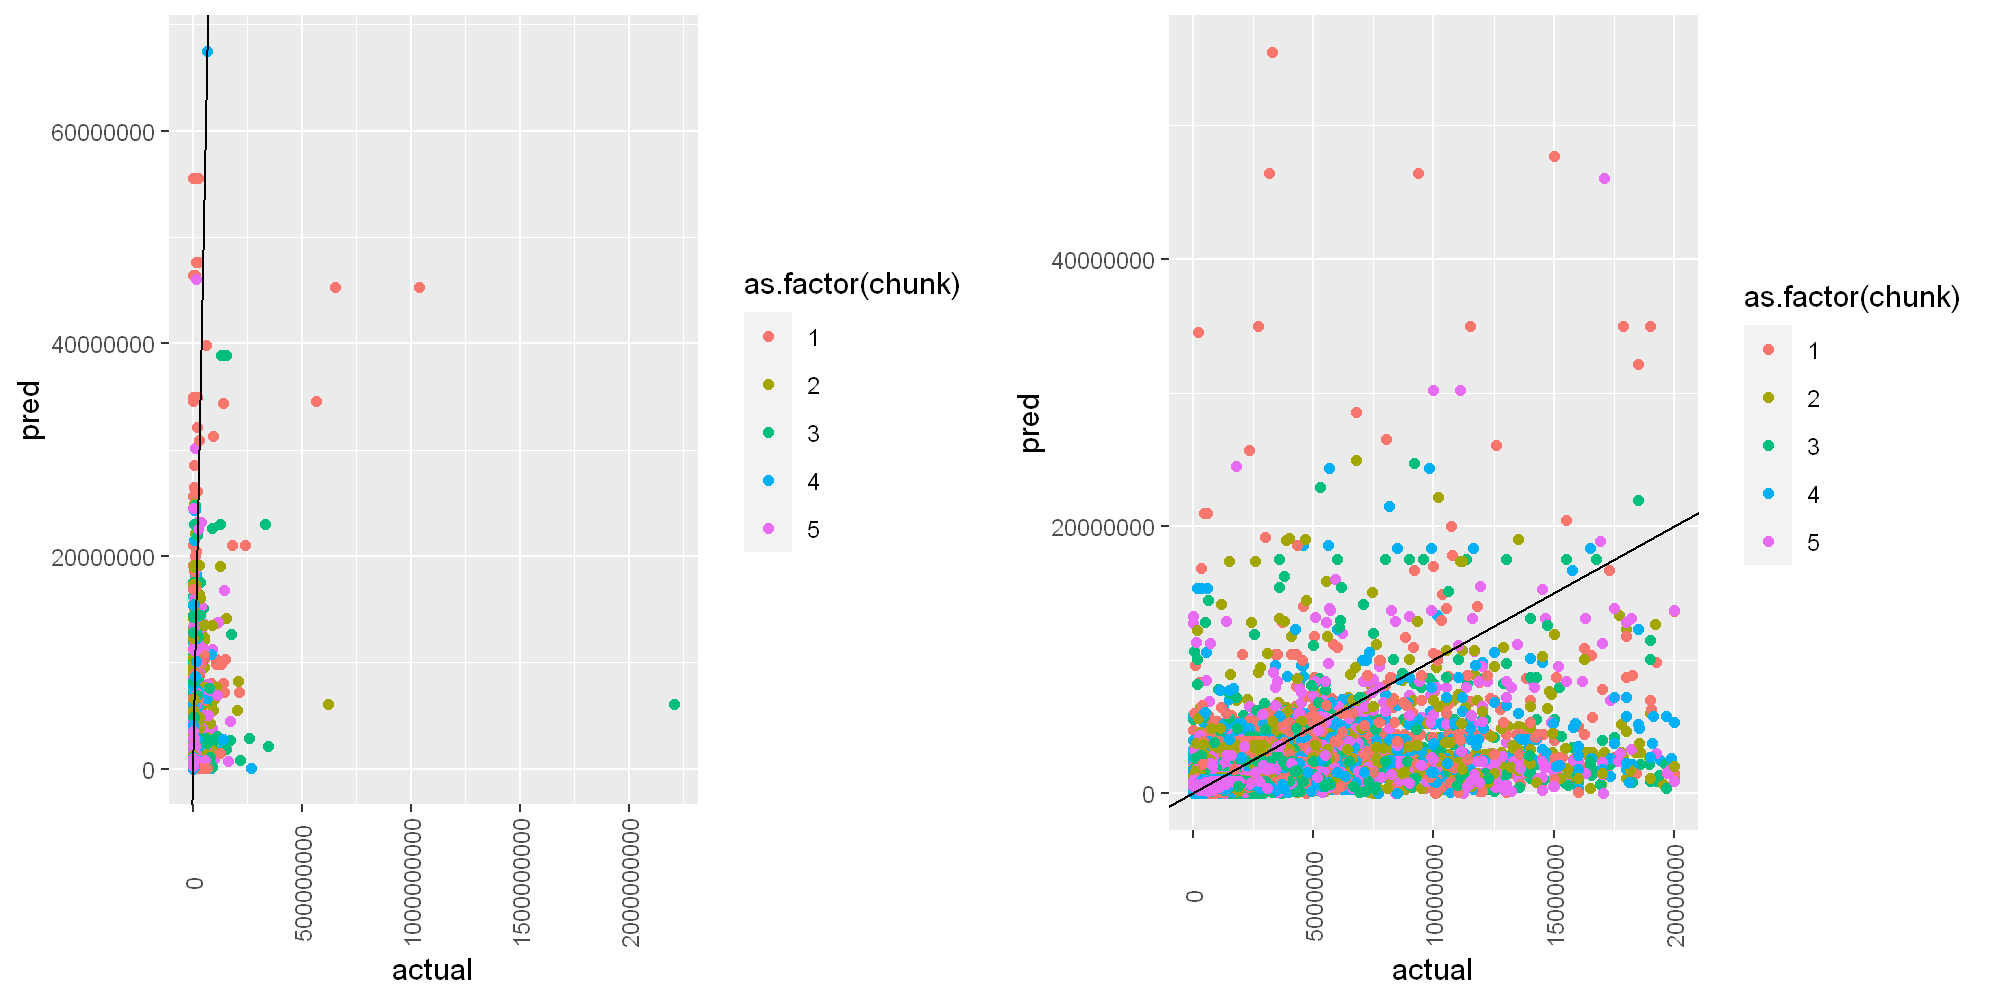

In [129]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) # for graph sizes
p1 = ggplot(data = pred_table_bb, aes(x = actual, y = pred, color = as.factor(chunk))) + geom_point() + geom_abline(intercept = 0, slope = 1)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))
p2 = ggplot(data = pred_table_bb[actual < 20000000], aes(x = actual, y = pred, color = as.factor(chunk))) + geom_point() + geom_abline(intercept = 0, slope = 1) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

grid.arrange(p1,p2, ncol = 2)

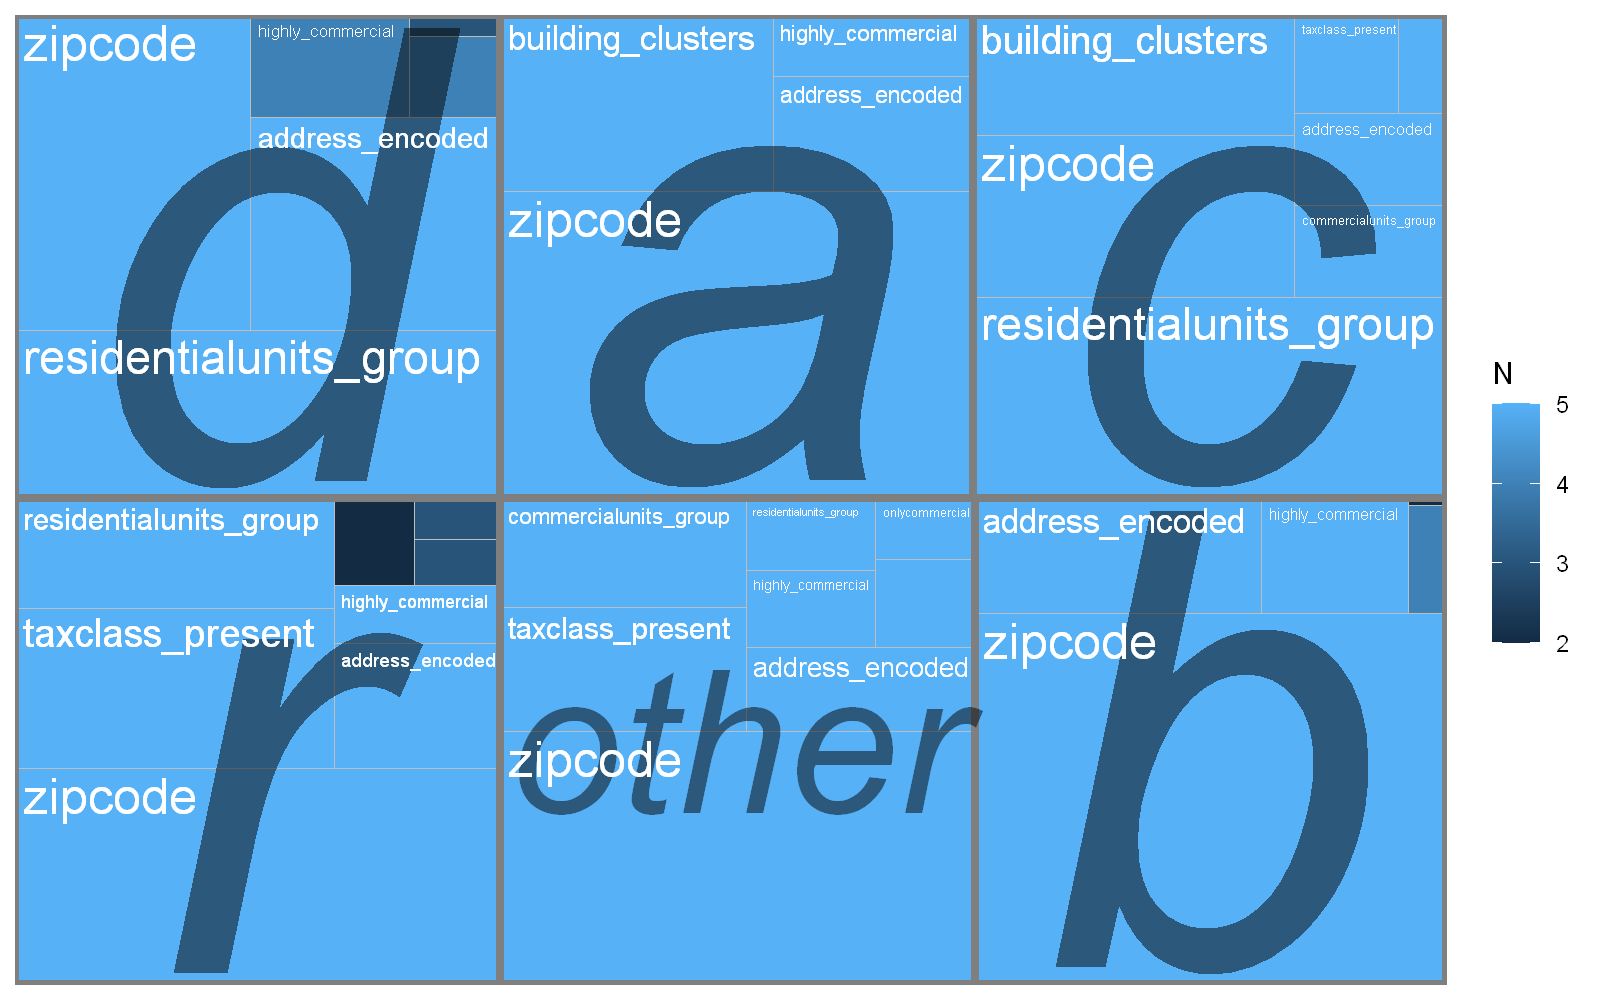

In [130]:
#imp_table_bb = imp_table_bb[order(-avg_gain)]
#imp_table_bb[, .SD[1], .(borough,b_class_group)][order(-avg_gain)]

dt_tree = imp_table_bb[,.(M = mean(avg_gain, na.rm = TRUE), N = .N) ,.(b_class_group,Feature)]

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
ggplot(dt_tree
       , aes(area = M, fill = N, label = Feature,subgroup = b_class_group)) +
  geom_treemap() +
 geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", grow = T, alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 0) +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T)

Warning message in as.data.table.list(jval, .named = NULL):
"Item 4 has 57439 rows but longest item has 57445; recycled with remainder."
Warning message in as.data.table.list(jval, .named = NULL):
"Item 5 has 57439 rows but longest item has 57445; recycled with remainder."


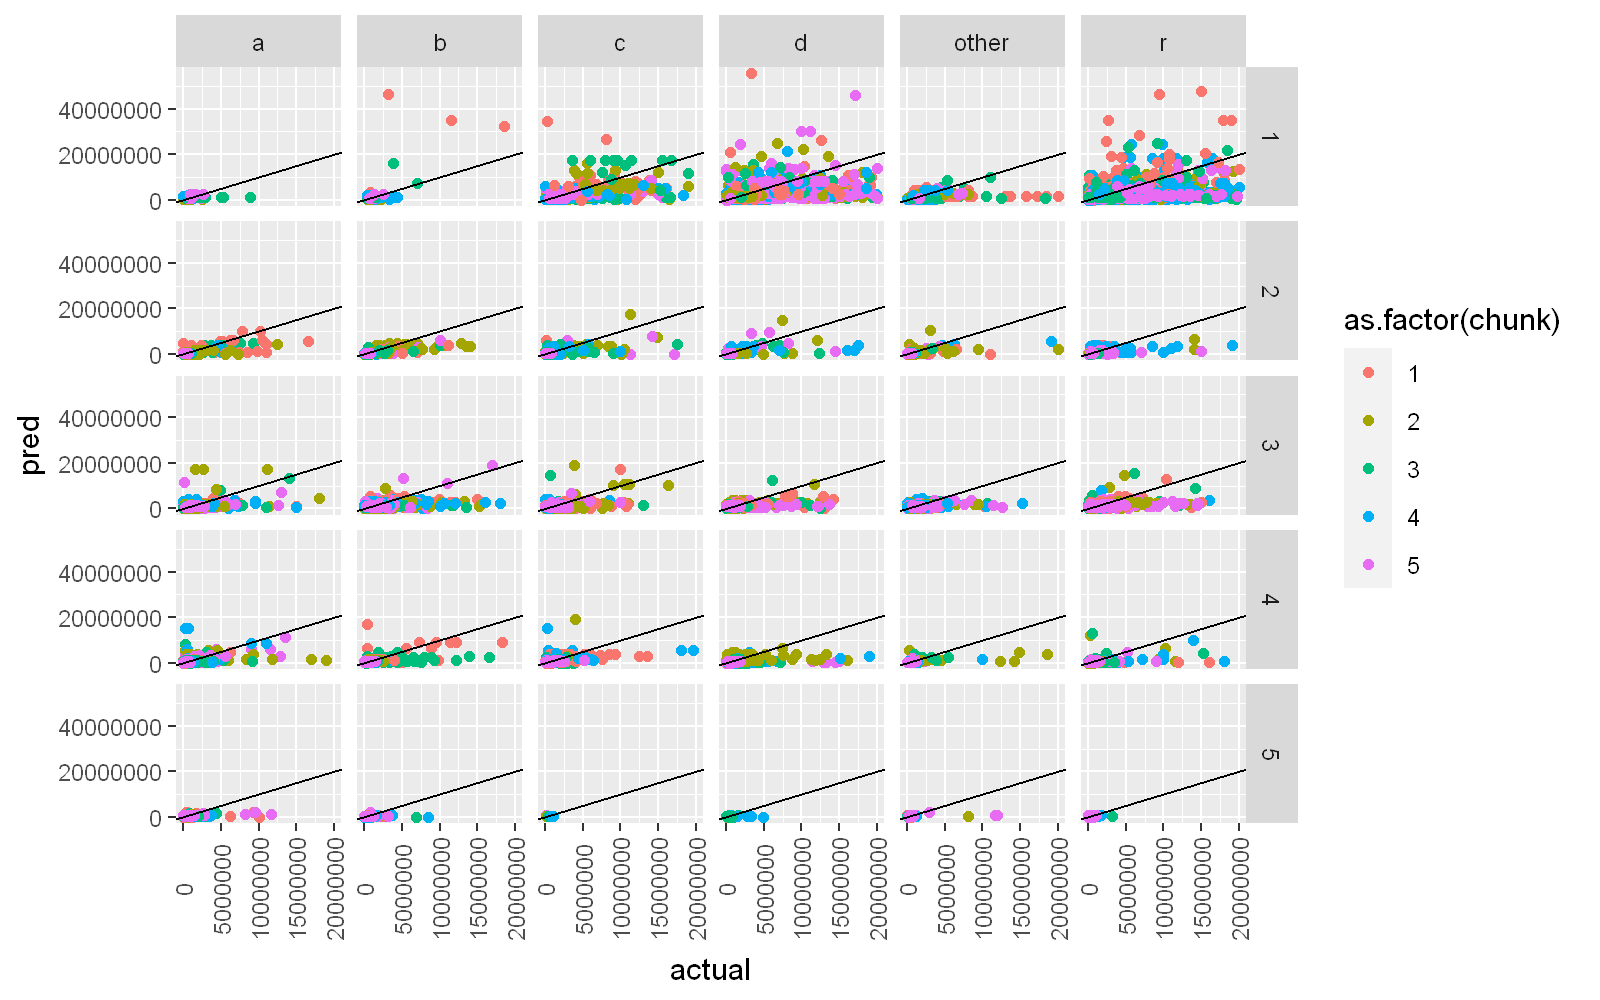

In [131]:
ggplot(data = pred_table_bb[actual < 20000000, .(actual,pred,chunk,borough = dt[saleprice <20000000]$borough, b_class_group = dt[saleprice <20000000]$b_class_group)],
       aes(x = actual, y=pred, group = as.factor(chunk), color = as.factor(chunk))) + 
    geom_point() +
    facet_grid(borough~b_class_group) + 
    geom_abline(intercept = 0, slope = 1) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5))

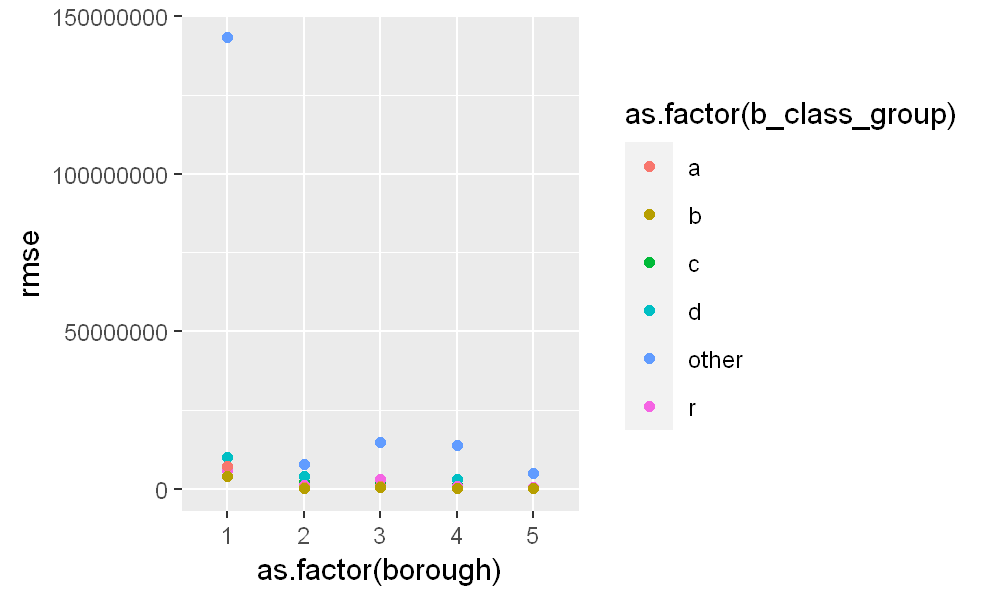

In [132]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200) # for graph sizes
ggplot(data =  pred_table_bb[, .(rmse= calc_rmse(pred,actual)),.(borough, b_class_group)],
      aes(x = as.factor(borough), y = rmse, group = as.factor(b_class_group), color = as.factor(b_class_group))) + geom_point() 

## XGBoost Based on Borough & Building Class W/O Outliers in Training

### saleprice with zipcode

In [133]:
## Both feature lists work nice
#feature_list = c("zipcode","residentialunits_log","commercialunits_log","address_encoded","taxclassatpresent_encoded","grosssquarefeet")
feature_list = c( "zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                )

train_target = "saleprice_wo"
test_target = "saleprice"

fit_bb_wo = model_xgboost_partial_wo(feature_list,train_target,test_target,chunk_no = 5)

pred_table_bb_wo = fit_bb_wo[[1]]

imp_table_bb_wo = fit_bb_wo[[2]]
imp_table_bb_wo

print("overall test rmse:")
calc_rmse(pred_table_bb_wo$pred,pred_table_bb_wo$actual)
calc_rmse(pred_table_bb_wo[actual < 20000000]$pred,pred_table_bb_wo[actual < 20000000]$actual)


Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:3839487.250000	test-rmse:9646397.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:3118016.000000	test-rmse:9392546.000000 
[3]	train-rmse:2655727.250000	test-rmse:9277878.000000 
[4]	train-rmse:2360343.500000	test-rmse:9173697.000000 
[5]	train-rmse:2123894.500000	test-rmse:9087418.000000 
[6]	train-rmse:1978108.500000	test-rmse:9067817.000000 
[7]	train-rmse:1889824.000000	test-rmse:8997614.000000 
[8]	train-rmse:1823306.875000	test-rmse:8988496.000000 
[9]	train-rmse:1781965.625000	test-rmse:8938518.000000 
[10]	train-rmse:1740777.375000	test-rmse:8934626.000000 
[11]	train-rmse:1710796.625000	test-rmse:8927242.000000 
[12]	train-rmse:1690548.750000	test-rmse:8934539.000000 
[13]	train-rmse:1671599.750000	test-rmse:8933006.000000 
[14]	train-rmse:1632114.250000	test-rmse:8934201.000000 
Stopping. Best iteration:
[11]	train-rmse:1710796.625000	test-rmse:8927242.00000

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:2329885.000000	test-rmse:9563970.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2021557.750000	test-rmse:9361510.000000 
[3]	train-rmse:1844939.875000	test-rmse:9226762.000000 
[4]	train-rmse:1746099.625000	test-rmse:9132696.000000 
[5]	train-rmse:1687760.500000	test-rmse:9078155.000000 
[6]	train-rmse:1650971.875000	test-rmse:9039501.000000 
[7]	train-rmse:1627246.750000	test-rmse:9001986.000000 
[8]	train-rmse:1614953.000000	test-rmse:8990724.000000 
[9]	train-rmse:1607435.625000	test-rmse:8987804.000000 
[10]	train-rmse:1600124.000000	test-rmse:8992623.000000 
[11]	train-rmse:1594824.875000	test-rmse:8989001.000000 
[12]	train-rmse:1590546.375000	test-rmse:8993877.000000 
Stopping. Best iteration:
[9]	train-rmse:1607435.625000	test-rmse:8987804.000000

[1]	train-rmse:2363115.500000	test-rmse:19170032.000000 
Multiple eval metrics are present. Will use test_rmse f

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:3330921.250000	test-rmse:5642429.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:2993838.750000	test-rmse:5317818.000000 
[3]	train-rmse:2800290.750000	test-rmse:5141268.500000 
[4]	train-rmse:2686863.250000	test-rmse:5049857.500000 
[5]	train-rmse:2617315.000000	test-rmse:5031805.500000 
[6]	train-rmse:2579498.250000	test-rmse:5015712.000000 
[7]	train-rmse:2560285.250000	test-rmse:4983759.500000 
[8]	train-rmse:2540314.500000	test-rmse:4974679.000000 
[9]	train-rmse:2528287.250000	test-rmse:4965832.500000 
[10]	train-rmse:2520369.500000	test-rmse:4958357.500000 
[11]	train-rmse:2497315.500000	test-rmse:4957125.500000 
[12]	train-rmse:2494314.750000	test-rmse:4950861.000000 
[13]	train-rmse:2491937.250000	test-rmse:4952371.000000 
[14]	train-rmse:2486547.750000	test-rmse:4948675.500000 
[15]	train-rmse:2482059.500000	test-rmse:4947968.500000 
[16]	train-rmse:2478795

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:7869727.000000	test-rmse:168655312.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6344750.500000	test-rmse:167802688.000000 
[3]	train-rmse:5281328.000000	test-rmse:167231520.000000 
[4]	train-rmse:4652542.000000	test-rmse:166796896.000000 
[5]	train-rmse:4198321.000000	test-rmse:166516160.000000 
[6]	train-rmse:3863143.000000	test-rmse:166284688.000000 
[7]	train-rmse:3596122.000000	test-rmse:166107744.000000 
[8]	train-rmse:3417043.500000	test-rmse:165991744.000000 
[9]	train-rmse:3283428.750000	test-rmse:165831248.000000 
[10]	train-rmse:3206112.000000	test-rmse:165716992.000000 
[11]	train-rmse:3143363.500000	test-rmse:165634672.000000 
[12]	train-rmse:3095888.750000	test-rmse:165620480.000000 
[13]	train-rmse:3031491.750000	test-rmse:165606384.000000 
[14]	train-rmse:2983566.750000	test-rmse:165595584.000000 
[15]	train-rmse:2927927.250000	test-rmse:165580496.0

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:7148730.000000	test-rmse:9216487.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5841270.500000	test-rmse:8117133.500000 
[3]	train-rmse:4873362.000000	test-rmse:7721318.500000 
[4]	train-rmse:4224745.500000	test-rmse:7500595.500000 
[5]	train-rmse:3786651.000000	test-rmse:7319108.500000 
[6]	train-rmse:3524337.000000	test-rmse:7173468.500000 
[7]	train-rmse:3366028.250000	test-rmse:7076233.500000 
[8]	train-rmse:3271422.250000	test-rmse:6891596.500000 
[9]	train-rmse:3213586.500000	test-rmse:6853543.500000 
[10]	train-rmse:3177854.500000	test-rmse:6823176.500000 
[11]	train-rmse:3155766.500000	test-rmse:6798836.500000 
[12]	train-rmse:3141490.000000	test-rmse:6740826.000000 
[13]	train-rmse:3132179.750000	test-rmse:6724990.500000 
[14]	train-rmse:3126026.750000	test-rmse:6712161.000000 
[15]	train-rmse:3121955.000000	test-rmse:6701737.500000 
[16]	train-rmse:3119257

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:4681717.500000	test-rmse:6960449.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:3712466.250000	test-rmse:6293495.500000 
[3]	train-rmse:2998262.500000	test-rmse:5807638.500000 
[4]	train-rmse:2477385.000000	test-rmse:5454354.000000 
[5]	train-rmse:2106382.250000	test-rmse:4931710.000000 
[6]	train-rmse:1816261.000000	test-rmse:4923400.000000 
[7]	train-rmse:1610685.250000	test-rmse:4927109.500000 
[8]	train-rmse:1460926.625000	test-rmse:4937996.000000 
[9]	train-rmse:1359496.375000	test-rmse:4952413.000000 
Stopping. Best iteration:
[6]	train-rmse:1816261.000000	test-rmse:4923400.000000

[1]	train-rmse:5415799.000000	test-rmse:1419053.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:4314899.000000	test-rmse:1177170.875000 
[3]	train-rmse:3595378.250000	test-rmse:

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:981550.000000	test-rmse:4727806.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:745145.625000	test-rmse:4588755.500000 
[3]	train-rmse:587272.375000	test-rmse:4497045.500000 
[4]	train-rmse:484126.750000	test-rmse:4458812.500000 
[5]	train-rmse:416202.031250	test-rmse:4427210.500000 
[6]	train-rmse:374070.218750	test-rmse:4403776.000000 
[7]	train-rmse:346865.875000	test-rmse:4382269.500000 
[8]	train-rmse:328561.406250	test-rmse:4366250.500000 
[9]	train-rmse:319536.375000	test-rmse:4356498.000000 
[10]	train-rmse:312005.250000	test-rmse:4350602.500000 
[11]	train-rmse:305685.875000	test-rmse:4353409.500000 
[12]	train-rmse:302462.687500	test-rmse:4353071.000000 
[13]	train-rmse:299479.062500	test-rmse:4352748.500000 
Stopping. Best iteration:
[10]	train-rmse:312005.250000	test-rmse:4350602.500000

[1]	train-rmse:936073.312500	test-rmse:3153533.250000 
Multiple eval

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:514119.687500	test-rmse:4256450.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:406137.531250	test-rmse:4119713.000000 
[3]	train-rmse:331605.218750	test-rmse:4027922.750000 
[4]	train-rmse:287966.375000	test-rmse:3963963.250000 
[5]	train-rmse:257262.656250	test-rmse:3917643.000000 
[6]	train-rmse:238987.984375	test-rmse:3884563.750000 
[7]	train-rmse:228470.421875	test-rmse:3861040.000000 
[8]	train-rmse:222333.078125	test-rmse:3843743.750000 
[9]	train-rmse:218767.750000	test-rmse:3831249.250000 
[10]	train-rmse:216532.578125	test-rmse:3823982.500000 
[11]	train-rmse:215174.375000	test-rmse:3818323.250000 
[12]	train-rmse:214339.703125	test-rmse:3813902.750000 
[13]	train-rmse:213818.015625	test-rmse:3810488.000000 
[14]	train-rmse:213484.875000	test-rmse:3808286.500000 
[15]	train-rmse:213270.015625	test-rmse:3806524.250000 
[16]	train-rmse:213131.437500	test-rms

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:417306.156250	test-rmse:1470914.125000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:345114.375000	test-rmse:1375391.625000 
[3]	train-rmse:294925.500000	test-rmse:1314999.125000 
[4]	train-rmse:260849.921875	test-rmse:1277755.875000 
[5]	train-rmse:238232.093750	test-rmse:1255512.750000 
[6]	train-rmse:223489.656250	test-rmse:1242754.000000 
[7]	train-rmse:214025.937500	test-rmse:1235696.000000 
[8]	train-rmse:207541.921875	test-rmse:1230025.875000 
[9]	train-rmse:203382.468750	test-rmse:1227234.375000 
[10]	train-rmse:200735.109375	test-rmse:1224418.375000 
[11]	train-rmse:199020.906250	test-rmse:1223185.625000 
[12]	train-rmse:197825.953125	test-rmse:1225055.625000 
[13]	train-rmse:197098.015625	test-rmse:1224976.875000 
[14]	train-rmse:196617.375000	test-rmse:1225258.625000 
Stopping. Best iteration:
[11]	train-rmse:199020.906250	test-rmse:1223185.625000

[1]	train-rm

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1460116.000000	test-rmse:3528966.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1213690.375000	test-rmse:3417065.000000 
[3]	train-rmse:1055972.500000	test-rmse:3360537.000000 
[4]	train-rmse:961999.750000	test-rmse:3301551.750000 
[5]	train-rmse:907773.000000	test-rmse:3266860.750000 
[6]	train-rmse:863423.937500	test-rmse:3257239.500000 
[7]	train-rmse:834608.562500	test-rmse:3260680.250000 
[8]	train-rmse:806076.250000	test-rmse:3261409.000000 
[9]	train-rmse:794679.625000	test-rmse:3276204.000000 
Stopping. Best iteration:
[6]	train-rmse:863423.937500	test-rmse:3257239.500000

[1]	train-rmse:1419147.875000	test-rmse:3393925.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1195335.875000	test-rmse:3240275.250000 
[3]	train-rmse:1060683.250000	test-rmse:3147177

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:448936.593750	test-rmse:240689.703125 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:357120.843750	test-rmse:172092.125000 
[3]	train-rmse:299187.156250	test-rmse:136528.125000 
[4]	train-rmse:264011.250000	test-rmse:125563.531250 
[5]	train-rmse:243621.406250	test-rmse:124583.695312 
[6]	train-rmse:231912.703125	test-rmse:127355.656250 
[7]	train-rmse:225223.203125	test-rmse:132202.703125 
[8]	train-rmse:221541.484375	test-rmse:136006.968750 
Stopping. Best iteration:
[5]	train-rmse:243621.406250	test-rmse:124583.695312

[1]	train-rmse:379741.187500	test-rmse:693703.562500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:305007.218750	test-rmse:612158.437500 
[3]	train-rmse:258210.531250	test-rmse:552880.937500 
[4]	train-rmse:230305.484375	test-rmse:513922.968750 
[5]	train-

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:381680.093750	test-rmse:366662.468750 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:295880.406250	test-rmse:286085.906250 
[3]	train-rmse:242027.203125	test-rmse:233891.171875 
[4]	train-rmse:210054.578125	test-rmse:203334.468750 
[5]	train-rmse:191574.156250	test-rmse:187284.453125 
[6]	train-rmse:181820.968750	test-rmse:179297.718750 
[7]	train-rmse:176319.359375	test-rmse:175873.390625 
[8]	train-rmse:173681.250000	test-rmse:174808.796875 
[9]	train-rmse:172073.375000	test-rmse:174076.093750 
[10]	train-rmse:171260.078125	test-rmse:174209.062500 
[11]	train-rmse:170659.656250	test-rmse:174332.234375 
[12]	train-rmse:170374.937500	test-rmse:174238.515625 
Stopping. Best iteration:
[9]	train-rmse:172073.375000	test-rmse:174076.093750

[1]	train-rmse:373174.062500	test-rmse:393011.750000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1271614.250000	test-rmse:1628932.375000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1044864.687500	test-rmse:1407846.625000 
[3]	train-rmse:904576.750000	test-rmse:1283450.250000 
[4]	train-rmse:815669.562500	test-rmse:1199198.625000 
[5]	train-rmse:750912.375000	test-rmse:1162703.625000 
[6]	train-rmse:712459.062500	test-rmse:1142746.000000 
[7]	train-rmse:684959.250000	test-rmse:1115634.000000 
[8]	train-rmse:664855.687500	test-rmse:1103450.250000 
[9]	train-rmse:650966.750000	test-rmse:1093186.375000 
[10]	train-rmse:637443.250000	test-rmse:1088114.750000 
[11]	train-rmse:628036.000000	test-rmse:1086207.500000 
[12]	train-rmse:619076.750000	test-rmse:1081002.625000 
[13]	train-rmse:612177.625000	test-rmse:1080457.500000 
[14]	train-rmse:607999.437500	test-rmse:1080400.625000 
[15]	train-rmse:601857.062500	test-rmse:1079393.250000 
[16]	train-rmse:598752.437500	test-r

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:718428.875000	test-rmse:1736563.375000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:567947.812500	test-rmse:1642969.250000 
[3]	train-rmse:475178.781250	test-rmse:1588877.875000 
[4]	train-rmse:407377.843750	test-rmse:1551620.250000 
[5]	train-rmse:363367.406250	test-rmse:1530331.000000 
[6]	train-rmse:338682.062500	test-rmse:1516801.375000 
[7]	train-rmse:321811.531250	test-rmse:1505938.375000 
[8]	train-rmse:311741.718750	test-rmse:1497502.000000 
[9]	train-rmse:305093.093750	test-rmse:1488887.625000 
[10]	train-rmse:300619.687500	test-rmse:1481072.125000 
[11]	train-rmse:298179.375000	test-rmse:1478182.125000 
[12]	train-rmse:296477.625000	test-rmse:1474805.125000 
[13]	train-rmse:295026.406250	test-rmse:1474227.875000 
[14]	train-rmse:294136.343750	test-rmse:1472754.375000 
[15]	train-rmse:293283.281250	test-rmse:1472189.375000 
[16]	train-rmse:292731.531250	test-rms

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1067879.250000	test-rmse:2091861.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:886958.625000	test-rmse:2025301.625000 
[3]	train-rmse:772438.000000	test-rmse:1992238.750000 
[4]	train-rmse:708576.062500	test-rmse:1973403.500000 
[5]	train-rmse:673674.812500	test-rmse:1963998.000000 
[6]	train-rmse:653769.687500	test-rmse:1957439.000000 
[7]	train-rmse:639141.875000	test-rmse:1954631.625000 
[8]	train-rmse:632526.687500	test-rmse:1952766.625000 
[9]	train-rmse:628811.875000	test-rmse:1951092.625000 
[10]	train-rmse:626646.312500	test-rmse:1950643.875000 
[11]	train-rmse:625585.375000	test-rmse:1950621.875000 
[12]	train-rmse:624921.250000	test-rmse:1950124.000000 
[13]	train-rmse:622362.125000	test-rmse:1950416.500000 
[14]	train-rmse:621491.562500	test-rmse:1949263.500000 
[15]	train-rmse:620849.125000	test-rmse:1949644.000000 
[16]	train-rmse:619791.187500	test-rm

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1880778.250000	test-rmse:4268543.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:1584871.375000	test-rmse:4076400.250000 
[3]	train-rmse:1400639.000000	test-rmse:3954088.500000 
[4]	train-rmse:1291714.000000	test-rmse:3874327.750000 
[5]	train-rmse:1214231.375000	test-rmse:3829593.500000 
[6]	train-rmse:1169705.500000	test-rmse:3797179.000000 
[7]	train-rmse:1122137.250000	test-rmse:3772779.250000 
[8]	train-rmse:1092745.875000	test-rmse:3753460.250000 
[9]	train-rmse:1071467.750000	test-rmse:3730625.000000 
[10]	train-rmse:1046728.625000	test-rmse:3721467.000000 
[11]	train-rmse:1033603.687500	test-rmse:3717453.750000 
[12]	train-rmse:1019402.875000	test-rmse:3712839.000000 
[13]	train-rmse:1010405.000000	test-rmse:3715387.500000 
[14]	train-rmse:1004769.625000	test-rmse:3710700.750000 
[15]	train-rmse:991100.625000	test-rmse:3710789.750000 
[16]	train-rmse:987195.6

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:896222.812500	test-rmse:1297302.875000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:731208.375000	test-rmse:1124746.625000 
[3]	train-rmse:627431.250000	test-rmse:1012275.312500 
[4]	train-rmse:564164.312500	test-rmse:937123.187500 
[5]	train-rmse:526190.062500	test-rmse:887330.687500 
[6]	train-rmse:502923.687500	test-rmse:842495.750000 
[7]	train-rmse:485651.750000	test-rmse:806548.937500 
[8]	train-rmse:477164.593750	test-rmse:787537.625000 
[9]	train-rmse:472202.937500	test-rmse:777894.125000 
[10]	train-rmse:468192.437500	test-rmse:767450.187500 
[11]	train-rmse:466491.437500	test-rmse:762668.750000 
[12]	train-rmse:465307.281250	test-rmse:756523.250000 
[13]	train-rmse:464495.468750	test-rmse:751058.562500 
[14]	train-rmse:460332.375000	test-rmse:743872.625000 
[15]	train-rmse:459784.968750	test-rmse:743140.375000 
[16]	train-rmse:458427.781250	test-rmse:743729.375

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:873993.312500	test-rmse:991558.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:699012.687500	test-rmse:796180.062500 
[3]	train-rmse:591105.937500	test-rmse:697246.312500 
[4]	train-rmse:525850.750000	test-rmse:644607.187500 
[5]	train-rmse:488421.718750	test-rmse:615258.937500 
[6]	train-rmse:467008.656250	test-rmse:612199.125000 
[7]	train-rmse:455151.375000	test-rmse:609468.687500 
[8]	train-rmse:449432.812500	test-rmse:612327.375000 
[9]	train-rmse:444242.437500	test-rmse:618268.062500 
[10]	train-rmse:440017.093750	test-rmse:618930.437500 
Stopping. Best iteration:
[7]	train-rmse:455151.375000	test-rmse:609468.687500

[1]	train-rmse:881588.937500	test-rmse:1095465.250000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:701318.250000	test-rmse:958473.125000 
[3]	trai

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:561356.875000	test-rmse:2561954.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:439250.750000	test-rmse:2455016.250000 
[3]	train-rmse:361754.250000	test-rmse:2386372.250000 
[4]	train-rmse:313792.687500	test-rmse:2341718.000000 
[5]	train-rmse:284630.687500	test-rmse:2303323.500000 
[6]	train-rmse:266788.687500	test-rmse:2278388.500000 
[7]	train-rmse:255635.906250	test-rmse:2259587.000000 
[8]	train-rmse:249713.265625	test-rmse:2253205.250000 
[9]	train-rmse:246022.312500	test-rmse:2240264.750000 
[10]	train-rmse:241720.109375	test-rmse:2233057.250000 
[11]	train-rmse:239873.781250	test-rmse:2231758.250000 
[12]	train-rmse:237460.921875	test-rmse:2226638.000000 
[13]	train-rmse:235974.500000	test-rmse:2222451.000000 
[14]	train-rmse:234893.906250	test-rmse:2217765.000000 
[15]	train-rmse:233933.125000	test-rmse:2214743.500000 
[16]	train-rmse:233383.390625	test-rms

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:299275.750000	test-rmse:5014814.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:240094.046875	test-rmse:4992696.500000 
[3]	train-rmse:200235.562500	test-rmse:4990401.000000 
[4]	train-rmse:176070.843750	test-rmse:4988890.500000 
[5]	train-rmse:162154.187500	test-rmse:4987899.000000 
[6]	train-rmse:154384.000000	test-rmse:4987111.000000 
[7]	train-rmse:150132.406250	test-rmse:4986472.500000 
[8]	train-rmse:147993.140625	test-rmse:4985992.000000 
[9]	train-rmse:146689.328125	test-rmse:4985002.000000 
[10]	train-rmse:145932.312500	test-rmse:4984264.000000 
[11]	train-rmse:145495.625000	test-rmse:4983755.500000 
[12]	train-rmse:145249.031250	test-rmse:4983922.500000 
[13]	train-rmse:145097.203125	test-rmse:4984077.000000 
[14]	train-rmse:144993.828125	test-rmse:4983865.000000 
Stopping. Best iteration:
[11]	train-rmse:145495.625000	test-rmse:4983755.500000

[1]	train-rm

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:612231.812500	test-rmse:993923.687500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:483046.187500	test-rmse:946722.625000 
[3]	train-rmse:403497.312500	test-rmse:930155.875000 
[4]	train-rmse:357174.312500	test-rmse:923143.812500 
[5]	train-rmse:331101.781250	test-rmse:921144.500000 
[6]	train-rmse:316882.906250	test-rmse:921648.687500 
[7]	train-rmse:309338.000000	test-rmse:922818.937500 
[8]	train-rmse:305508.000000	test-rmse:924097.125000 
Stopping. Best iteration:
[5]	train-rmse:331101.781250	test-rmse:921144.500000

[1]	train-rmse:594914.062500	test-rmse:1385441.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:470724.531250	test-rmse:1342846.250000 
[3]	train-rmse:394931.125000	test-rmse:1333752.250000 
[4]	train-rmse:349830.531250	test-rmse:1328555.875000 
[5]	tr

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:1116963.250000	test-rmse:3941355.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:892526.125000	test-rmse:3792074.000000 
[3]	train-rmse:755024.187500	test-rmse:3683078.500000 
[4]	train-rmse:666213.375000	test-rmse:3623405.750000 
[5]	train-rmse:610634.125000	test-rmse:3576449.000000 
[6]	train-rmse:577875.625000	test-rmse:3546674.500000 
[7]	train-rmse:555986.250000	test-rmse:3524814.250000 
[8]	train-rmse:542641.750000	test-rmse:3518425.750000 
[9]	train-rmse:533479.562500	test-rmse:3515919.750000 
[10]	train-rmse:528240.187500	test-rmse:3517170.250000 
[11]	train-rmse:520318.812500	test-rmse:3512249.500000 
[12]	train-rmse:515338.187500	test-rmse:3518847.750000 
[13]	train-rmse:511179.625000	test-rmse:3513922.000000 
[14]	train-rmse:507623.062500	test-rmse:3512971.750000 
Stopping. Best iteration:
[11]	train-rmse:520318.812500	test-rmse:3512249.500000

[1]	train-r

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:485378.781250	test-rmse:585216.125000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:368369.812500	test-rmse:456176.531250 
[3]	train-rmse:293430.593750	test-rmse:377823.468750 
[4]	train-rmse:247816.187500	test-rmse:334455.031250 
[5]	train-rmse:221408.984375	test-rmse:310534.406250 
[6]	train-rmse:206103.218750	test-rmse:294906.375000 
[7]	train-rmse:198204.781250	test-rmse:286794.875000 
[8]	train-rmse:193800.343750	test-rmse:283504.187500 
[9]	train-rmse:190757.609375	test-rmse:281440.750000 
[10]	train-rmse:189066.109375	test-rmse:281224.750000 
[11]	train-rmse:188291.250000	test-rmse:281556.343750 
[12]	train-rmse:187532.125000	test-rmse:280976.312500 
[13]	train-rmse:187221.781250	test-rmse:281359.281250 
[14]	train-rmse:186967.437500	test-rmse:281197.343750 
[15]	train-rmse:186791.234375	test-rmse:281199.656250 
Stopping. Best iteration:
[12]	train-rmse:187532.1250

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:555367.625000	test-rmse:646363.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:426044.562500	test-rmse:490667.437500 
[3]	train-rmse:344483.968750	test-rmse:404822.250000 
[4]	train-rmse:295534.625000	test-rmse:364640.125000 
[5]	train-rmse:267758.906250	test-rmse:349631.906250 
[6]	train-rmse:252745.140625	test-rmse:345515.406250 
[7]	train-rmse:244522.218750	test-rmse:347253.468750 
[8]	train-rmse:240268.109375	test-rmse:351039.312500 
[9]	train-rmse:238028.921875	test-rmse:353779.500000 
Stopping. Best iteration:
[6]	train-rmse:252745.140625	test-rmse:345515.406250

[1]	train-rmse:556851.062500	test-rmse:690420.875000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:430724.437500	test-rmse:550213.250000 
[3]	train-rmse:351666.718750	test-rmse:464192.187500 
[4]	train-

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:389246.562500	test-rmse:369211.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:309215.875000	test-rmse:296140.875000 
[3]	train-rmse:251432.750000	test-rmse:249805.843750 
[4]	train-rmse:211728.765625	test-rmse:218711.937500 
[5]	train-rmse:184449.687500	test-rmse:200288.093750 
[6]	train-rmse:166633.687500	test-rmse:183893.203125 
[7]	train-rmse:154301.625000	test-rmse:173120.750000 
[8]	train-rmse:144984.359375	test-rmse:167702.343750 
[9]	train-rmse:139161.375000	test-rmse:164903.546875 
[10]	train-rmse:135516.078125	test-rmse:161791.468750 
[11]	train-rmse:133139.484375	test-rmse:160239.890625 
[12]	train-rmse:131704.828125	test-rmse:160294.921875 
[13]	train-rmse:130680.515625	test-rmse:158997.250000 
[14]	train-rmse:129963.648438	test-rmse:159439.328125 
[15]	train-rmse:127697.960938	test-rmse:162831.906250 
[16]	train-rmse:126028.625000	test-rmse:166703.140625

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:197759.421875	test-rmse:117078.296875 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:154051.937500	test-rmse:66769.843750 
[3]	train-rmse:124926.757812	test-rmse:44574.132812 
[4]	train-rmse:106305.250000	test-rmse:49866.980469 
[5]	train-rmse:94933.296875	test-rmse:64016.632812 
[6]	train-rmse:88275.265625	test-rmse:77155.679688 
Stopping. Best iteration:
[3]	train-rmse:124926.757812	test-rmse:44574.132812

[1]	train-rmse:199167.546875	test-rmse:136166.265625 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:156948.156250	test-rmse:97156.679688 
[3]	train-rmse:128694.875000	test-rmse:72795.664062 
[4]	train-rmse:110513.804688	test-rmse:59629.863281 
[5]	train-rmse:99272.343750	test-rmse:53726.792969 
[6]	train-rmse:92609.718750	test-rmse:52128.730469 
[7]	train-rmse:88776.3906

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:246643.531250	test-rmse:235135.484375 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:188460.828125	test-rmse:180575.656250 
[3]	train-rmse:150791.906250	test-rmse:147605.781250 
[4]	train-rmse:126950.765625	test-rmse:130022.570312 
[5]	train-rmse:113215.804688	test-rmse:121164.125000 
[6]	train-rmse:105138.539062	test-rmse:117425.859375 
[7]	train-rmse:100186.609375	test-rmse:115717.359375 
[8]	train-rmse:97397.773438	test-rmse:116353.726562 
[9]	train-rmse:96076.109375	test-rmse:116726.476562 
[10]	train-rmse:95298.023438	test-rmse:118340.593750 
Stopping. Best iteration:
[7]	train-rmse:100186.609375	test-rmse:115717.359375

[1]	train-rmse:248598.578125	test-rmse:248030.953125 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:189989.218750	test-rmse:212409.562500 
[3]	train-rm

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:593799.187500	test-rmse:10961211.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:485922.781250	test-rmse:10948836.000000 
[3]	train-rmse:414100.250000	test-rmse:10901678.000000 
[4]	train-rmse:368071.250000	test-rmse:10898062.000000 
[5]	train-rmse:334717.218750	test-rmse:10871004.000000 
[6]	train-rmse:315536.781250	test-rmse:10851690.000000 
[7]	train-rmse:301666.187500	test-rmse:10851084.000000 
[8]	train-rmse:292908.375000	test-rmse:10850642.000000 
[9]	train-rmse:286708.843750	test-rmse:10850079.000000 
[10]	train-rmse:280880.687500	test-rmse:10849759.000000 
[11]	train-rmse:277019.718750	test-rmse:10849535.000000 
[12]	train-rmse:273677.531250	test-rmse:10849793.000000 
[13]	train-rmse:270485.187500	test-rmse:10849784.000000 
[14]	train-rmse:268543.437500	test-rmse:10850950.000000 
Stopping. Best iteration:
[11]	train-rmse:277019.718750	test-rmse:10849535.00000

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:397544.187500	test-rmse:349369.687500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:305050.500000	test-rmse:259377.500000 
[3]	train-rmse:247058.640625	test-rmse:204336.937500 
[4]	train-rmse:212488.328125	test-rmse:173275.343750 
[5]	train-rmse:192794.593750	test-rmse:158430.171875 
[6]	train-rmse:182346.468750	test-rmse:151723.781250 
[7]	train-rmse:176747.921875	test-rmse:150323.296875 
[8]	train-rmse:173862.328125	test-rmse:151096.015625 
[9]	train-rmse:172376.093750	test-rmse:151247.453125 
[10]	train-rmse:171572.125000	test-rmse:151985.609375 
Stopping. Best iteration:
[7]	train-rmse:176747.921875	test-rmse:150323.296875

[1]	train-rmse:386947.218750	test-rmse:410686.312500 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:296028.343750	test-rmse:322079.218750 
[3]	train

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:451294.750000	test-rmse:468841.156250 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:344705.406250	test-rmse:360665.781250 
[3]	train-rmse:277495.125000	test-rmse:295440.968750 
[4]	train-rmse:236582.859375	test-rmse:252412.328125 
[5]	train-rmse:213383.859375	test-rmse:230659.390625 
[6]	train-rmse:200751.218750	test-rmse:220758.500000 
[7]	train-rmse:193794.265625	test-rmse:216507.046875 
[8]	train-rmse:190197.734375	test-rmse:216085.406250 
[9]	train-rmse:188374.031250	test-rmse:217056.234375 
[10]	train-rmse:187449.390625	test-rmse:218309.312500 
[11]	train-rmse:186832.156250	test-rmse:218342.171875 
Stopping. Best iteration:
[8]	train-rmse:190197.734375	test-rmse:216085.406250

[1]	train-rmse:455925.000000	test-rmse:440687.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	trai

borough b_class_group Feature                avg_gain    
1   1       c             residentialunits_group 0.624942282 
2   1       c             zipcode                0.241305336 
3   1       c             commercialunits_group  0.063362111 
4   1       c             building_clusters      0.035358679 
5   1       c             address_encoded        0.018489023 
6   1       c             highly_commercial      0.010980340 
7   1       c             taxclass_present       0.005562229 
8   1       d             residentialunits_group 0.699375098 
9   1       d             zipcode                0.180517556 
10  1       d             address_encoded        0.065001727 
11  1       d             highly_commercial      0.041224830 
12  1       d             commercialunits_group  0.011869984 
13  1       d             building_clusters      0.002010806 
14  1       r             zipcode                0.564797556 
15  1       r             address_encoded        0.137072897 
16  1       r             highly_commercial      0.081475627 
17  1       r             building_clusters      0.054435241 
18  1       r             residentialunits_group 0.076636173 
19  1       r             onlycommercial         0.038730392 
20  1       r             taxclass_present       0.025937855 
21  1       r             commercialunits_group  0.020914258 
22  1       other         zipcode                0.664168857 
23  1       other         address_encoded        0.078734601 
24  1       other         commercialunits_group  0.097746088 
25  1       other         residentialunits_group 0.047601436 
26  1       other         highly_commercial      0.045394080 
27  1       other         onlycommercial         0.045529440 
28  1       other         taxclass_present       0.019648760 
29  1       other         building_clusters      0.001470922 
30  1       a             zipcode                0.578086884 
... ...     ...           ...                    ...         
148 5       c             zipcode                0.0864559968
149 5       c             address_encoded        0.0533524300
150 5       c             highly_commercial      0.0042959804
151 5       c             residentialunits_group 0.0154377945
152 5       d             address_encoded        0.9134361040
153 5       d             zipcode                0.0853566261
154 5       d             residentialunits_group 0.0228482439
155 5       r             zipcode                0.5039611046
156 5       r             highly_commercial      0.1444360386
157 5       r             taxclass_present       0.2178543946
158 5       r             address_encoded        0.1292355103
159 5       r             residentialunits_group 0.0334001597
160 5       other         taxclass_present       0.3682126787
161 5       other         zipcode                0.3016206615
162 5       other         address_encoded        0.0984954282
163 5       other         commercialunits_group  0.1120990682
164 5       other         building_clusters      0.0165831881
165 5       other         residentialunits_group 0.0706425413
166 5       other         onlycommercial         0.0117814143
167 5       other         highly_commercial      0.0205650198
168 5       a             building_clusters      0.7731867781
169 5       a             zipcode                0.1803933955
170 5       a             address_encoded        0.0449844694
171 5       a             highly_commercial      0.0011241572
172 5       a             commercialunits_group  0.0005186664
173 5       b             zipcode                0.9022087105
174 5       b             address_encoded        0.0753858007
175 5       b             highly_commercial      0.0049486685
176 5       b             building_clusters      0.0174084737
177 5       b             commercialunits_group  0.0010380804

[1] "overall test rmse:"


[1] 12196435

[1] 1430007

In [134]:
colnames(dt)

[1] "v1"                                "borough"                          
 [3] "neighborhood"                      "buildingclasscategory"            
 [5] "taxclassatpresent"                 "block"                            
 [7] "lot"                               "buildingclassatpresent"           
 [9] "address"                           "zipcode"                          
[11] "residentialunits"                  "commercialunits"                  
[13] "totalunits"                        "landsquarefeet"                   
[15] "grosssquarefeet"                   "yearbuilt"                        
[17] "taxclassattimeofsale"              "buildingclassattimeofsale"        
[19] "saleprice"                         "saledate"                         
[21] "bbl"                               "idx"                              
[23] "b_class_cat"                       "b_class_present"                  
[25] "taxclass_present"                  "b_class_group"                    
[27] "saleprice_log"                     "saleprice_wo"                     
[29] "saleprice_wo_log"                  "saleprice_log_wo"                 
[31] "yearbuilt_group"                   "totalunits_group"                 
[33] "commercialunits_group"             "grosssquarefeet_log_filled"       
[35] "grosssquarefeet_log_group"         "commercialunits_sqrt"             
[37] "residentialunits_sqrt"             "residentialunits_group"           
[39] "building_clusters"                 "saleprice_wo_3s"                  
[41] "saleprice_wo_IQR"                  "saleprice_log_wo_IQR"             
[43] "saleprice_log_wo_3s"               "iszero"                           
[45] "assessment_ratio_present"          "onlycommercial"                   
[47] "highly_commercial"                 "b_class_present_encoded"          
[49] "b_class_group_encoded"             "address_encoded"                  
[51] "taxclassatpresent_encoded"         "grosssquarefeet_log_group_encoded"
[53] "commercialunits_log"               "residentialunits_log"             
[55] "commercialunits_wo"

### saleprice_log with zipcode

In [135]:
feature_list = c( "zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                ,"grosssquarefeet_log_filled")

train_target = "saleprice_log_wo"
test_target = "saleprice_log"

fit_bb_wo = model_xgboost_partial_wo(feature_list,train_target,test_target,chunk_no = 5)

pred_table_bb_wo = fit_bb_wo[[1]]

imp_table_bb_wo = fit_bb_wo[[2]]

print("overall test rmse:")
calc_rmse(pred_table_bb_wo$pred,pred_table_bb_wo$actual)
calc_rmse(pred_table_bb_wo[actual < 20000000]$pred,pred_table_bb_wo[actual < 20000000]$actual)

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.552166	test-rmse:9.356132 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.722876	test-rmse:6.622382 
[3]	train-rmse:4.747572	test-rmse:4.668015 
[4]	train-rmse:3.375171	test-rmse:3.313744 
[5]	train-rmse:2.425585	test-rmse:2.358979 
[6]	train-rmse:1.774989	test-rmse:1.711883 
[7]	train-rmse:1.336462	test-rmse:1.356502 
[8]	train-rmse:1.047213	test-rmse:1.084626 
[9]	train-rmse:0.858564	test-rmse:0.947166 
[10]	train-rmse:0.741735	test-rmse:0.939152 
[11]	train-rmse:0.674714	test-rmse:0.905602 
[12]	train-rmse:0.629354	test-rmse:0.952983 
[13]	train-rmse:0.606832	test-rmse:0.943788 
[14]	train-rmse:0.588239	test-rmse:0.937474 
Stopping. Best iteration:
[11]	train-rmse:0.674714	test-rmse:0.905602

[1]	train-rmse:9.478835	test-rmse:9.564686 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.308808	test-rmse:9.383113 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.544896	test-rmse:6.614523 
[3]	train-rmse:4.619780	test-rmse:4.701146 
[4]	train-rmse:3.283414	test-rmse:3.297549 
[5]	train-rmse:2.364345	test-rmse:2.340504 
[6]	train-rmse:1.741933	test-rmse:1.737769 
[7]	train-rmse:1.331625	test-rmse:1.359652 
[8]	train-rmse:1.071890	test-rmse:1.147955 
[9]	train-rmse:0.915371	test-rmse:1.058255 
[10]	train-rmse:0.827546	test-rmse:1.039479 
[11]	train-rmse:0.779598	test-rmse:1.019622 
[12]	train-rmse:0.754620	test-rmse:1.041331 
[13]	train-rmse:0.739674	test-rmse:1.049211 
[14]	train-rmse:0.733205	test-rmse:1.050514 
Stopping. Best iteration:
[11]	train-rmse:0.779598	test-rmse:1.019622

[1]	train-rmse:9.363310	test-rmse:9.041458 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.673265	test-rmse:9.796436 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.802246	test-rmse:6.833838 
[3]	train-rmse:4.801968	test-rmse:4.793856 
[4]	train-rmse:3.413309	test-rmse:3.388548 
[5]	train-rmse:2.457033	test-rmse:2.428964 
[6]	train-rmse:1.806588	test-rmse:1.801284 
[7]	train-rmse:1.379129	test-rmse:1.397477 
[8]	train-rmse:1.107509	test-rmse:1.139159 
[9]	train-rmse:0.941203	test-rmse:0.999441 
[10]	train-rmse:0.850360	test-rmse:0.927643 
[11]	train-rmse:0.800234	test-rmse:0.896791 
[12]	train-rmse:0.774095	test-rmse:0.878277 
[13]	train-rmse:0.756734	test-rmse:0.874320 
[14]	train-rmse:0.748696	test-rmse:0.872969 
[15]	train-rmse:0.742806	test-rmse:0.872657 
[16]	train-rmse:0.735493	test-rmse:0.869797 
[17]	train-rmse:0.734097	test-rmse:0.872587 
[18]	train-rmse:0.733137	test-rmse:0.873269 
[19]	train-rmse:0.730338	test-rmse:0.873143 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.252530	test-rmse:11.562238 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.239427	test-rmse:8.371754 
[3]	train-rmse:5.133748	test-rmse:6.148461 
[4]	train-rmse:3.666218	test-rmse:4.547652 
[5]	train-rmse:2.649230	test-rmse:3.465000 
[6]	train-rmse:1.943855	test-rmse:2.785538 
[7]	train-rmse:1.445124	test-rmse:2.334625 
[8]	train-rmse:1.108617	test-rmse:2.033537 
[9]	train-rmse:0.875724	test-rmse:1.848188 
[10]	train-rmse:0.720943	test-rmse:1.723239 
[11]	train-rmse:0.612823	test-rmse:1.652541 
[12]	train-rmse:0.527882	test-rmse:1.606399 
[13]	train-rmse:0.494447	test-rmse:1.572577 
[14]	train-rmse:0.451491	test-rmse:1.547798 
[15]	train-rmse:0.431478	test-rmse:1.532591 
[16]	train-rmse:0.410619	test-rmse:1.527663 
[17]	train-rmse:0.403394	test-rmse:1.515424 
[18]	train-rmse:0.386989	test-rmse:1.502576 
[19]	train-rmse:0.370323	test-rmse:1.503995 
[20]	train-rmse:0.353

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.617598	test-rmse:10.605449 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.533655	test-rmse:7.515969 
[3]	train-rmse:5.377080	test-rmse:5.351726 
[4]	train-rmse:3.872694	test-rmse:3.820570 
[5]	train-rmse:2.838739	test-rmse:2.768799 
[6]	train-rmse:2.106102	test-rmse:2.089733 
[7]	train-rmse:1.556733	test-rmse:1.597951 
[8]	train-rmse:1.198617	test-rmse:1.258500 
[9]	train-rmse:0.911337	test-rmse:1.004423 
[10]	train-rmse:0.736856	test-rmse:0.863307 
[11]	train-rmse:0.585473	test-rmse:0.757332 
[12]	train-rmse:0.479954	test-rmse:0.673265 
[13]	train-rmse:0.388814	test-rmse:0.597686 
[14]	train-rmse:0.321838	test-rmse:0.543745 
[15]	train-rmse:0.272831	test-rmse:0.509134 
[16]	train-rmse:0.236980	test-rmse:0.482242 
[17]	train-rmse:0.209809	test-rmse:0.463777 
[18]	train-rmse:0.190487	test-rmse:0.451366 
[19]	train-rmse:0.175419	test-rmse:0.430244 
[20]	train-rmse:0.164

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.200396	test-rmse:10.714079 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.233291	test-rmse:7.734805 
[3]	train-rmse:5.154616	test-rmse:5.638537 
[4]	train-rmse:3.708273	test-rmse:4.166899 
[5]	train-rmse:2.707027	test-rmse:3.169872 
[6]	train-rmse:2.014689	test-rmse:2.320785 
[7]	train-rmse:1.518589	test-rmse:1.921857 
[8]	train-rmse:1.151302	test-rmse:1.558379 
[9]	train-rmse:0.909797	test-rmse:1.359416 
[10]	train-rmse:0.718242	test-rmse:1.228186 
[11]	train-rmse:0.576865	test-rmse:1.161580 
[12]	train-rmse:0.471716	test-rmse:1.101583 
[13]	train-rmse:0.394776	test-rmse:1.063918 
[14]	train-rmse:0.332600	test-rmse:1.021199 
[15]	train-rmse:0.284340	test-rmse:0.982043 
[16]	train-rmse:0.243018	test-rmse:0.969078 
[17]	train-rmse:0.221152	test-rmse:0.967646 
[18]	train-rmse:0.190811	test-rmse:0.958000 
[19]	train-rmse:0.165617	test-rmse:0.952884 
[20]	train-rmse:0.139

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.005816	test-rmse:9.060042 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.329307	test-rmse:6.392803 
[3]	train-rmse:4.457426	test-rmse:4.520964 
[4]	train-rmse:3.151157	test-rmse:3.224723 
[5]	train-rmse:2.243558	test-rmse:2.328691 
[6]	train-rmse:1.618381	test-rmse:1.711690 
[7]	train-rmse:1.189465	test-rmse:1.313379 
[8]	train-rmse:0.905394	test-rmse:1.061535 
[9]	train-rmse:0.709430	test-rmse:0.893069 
[10]	train-rmse:0.584268	test-rmse:0.811150 
[11]	train-rmse:0.502502	test-rmse:0.768993 
[12]	train-rmse:0.452386	test-rmse:0.738160 
[13]	train-rmse:0.423678	test-rmse:0.725463 
[14]	train-rmse:0.399158	test-rmse:0.722873 
[15]	train-rmse:0.386088	test-rmse:0.717101 
[16]	train-rmse:0.368940	test-rmse:0.719976 
[17]	train-rmse:0.357557	test-rmse:0.726094 
[18]	train-rmse:0.348108	test-rmse:0.722428 
Stopping. Best iteration:
[15]	train-rmse:0.386088	test-rmse:0.71710

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.308707	test-rmse:7.995579 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.843086	test-rmse:5.509439 
[3]	train-rmse:4.120651	test-rmse:3.878995 
[4]	train-rmse:2.921028	test-rmse:2.745684 
[5]	train-rmse:2.088940	test-rmse:1.978658 
[6]	train-rmse:1.517419	test-rmse:1.472867 
[7]	train-rmse:1.132399	test-rmse:1.147541 
[8]	train-rmse:0.876916	test-rmse:1.017746 
[9]	train-rmse:0.715474	test-rmse:0.933058 
[10]	train-rmse:0.617117	test-rmse:0.906138 
[11]	train-rmse:0.563661	test-rmse:0.891540 
[12]	train-rmse:0.533632	test-rmse:0.893118 
[13]	train-rmse:0.516583	test-rmse:0.894983 
[14]	train-rmse:0.507574	test-rmse:0.897302 
Stopping. Best iteration:
[11]	train-rmse:0.563661	test-rmse:0.891540

[1]	train-rmse:8.242745	test-rmse:8.464622 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.166001	test-rmse:8.608320 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.748271	test-rmse:6.198362 
[3]	train-rmse:4.059164	test-rmse:4.436376 
[4]	train-rmse:2.883997	test-rmse:3.222721 
[5]	train-rmse:2.065591	test-rmse:2.444430 
[6]	train-rmse:1.501045	test-rmse:1.912941 
[7]	train-rmse:1.111783	test-rmse:1.473505 
[8]	train-rmse:0.855812	test-rmse:1.178049 
[9]	train-rmse:0.686731	test-rmse:1.046639 
[10]	train-rmse:0.574915	test-rmse:0.983302 
[11]	train-rmse:0.505780	test-rmse:0.966221 
[12]	train-rmse:0.464258	test-rmse:0.950104 
[13]	train-rmse:0.438752	test-rmse:0.960423 
[14]	train-rmse:0.424515	test-rmse:0.980784 
[15]	train-rmse:0.416702	test-rmse:0.997203 
Stopping. Best iteration:
[12]	train-rmse:0.464258	test-rmse:0.950104

[1]	train-rmse:8.282216	test-rmse:7.886954 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train unt

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.252199	test-rmse:9.289011 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.536190	test-rmse:6.580436 
[3]	train-rmse:4.643437	test-rmse:4.711421 
[4]	train-rmse:3.329158	test-rmse:3.438282 
[5]	train-rmse:2.426591	test-rmse:2.613271 
[6]	train-rmse:1.803934	test-rmse:2.092507 
[7]	train-rmse:1.383180	test-rmse:1.741940 
[8]	train-rmse:1.105686	test-rmse:1.537906 
[9]	train-rmse:0.931345	test-rmse:1.416814 
[10]	train-rmse:0.828820	test-rmse:1.344403 
[11]	train-rmse:0.744991	test-rmse:1.289222 
[12]	train-rmse:0.689370	test-rmse:1.274323 
[13]	train-rmse:0.662548	test-rmse:1.258236 
[14]	train-rmse:0.627278	test-rmse:1.246390 
[15]	train-rmse:0.608967	test-rmse:1.249854 
[16]	train-rmse:0.601110	test-rmse:1.245131 
[17]	train-rmse:0.577686	test-rmse:1.243901 
[18]	train-rmse:0.560124	test-rmse:1.236742 
[19]	train-rmse:0.555476	test-rmse:1.235650 
[20]	train-rmse:0.54862

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.711580	test-rmse:8.363815 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.114823	test-rmse:5.782295 
[3]	train-rmse:4.301817	test-rmse:3.992208 
[4]	train-rmse:3.038244	test-rmse:2.780060 
[5]	train-rmse:2.159998	test-rmse:1.973483 
[6]	train-rmse:1.551210	test-rmse:1.466733 
[7]	train-rmse:1.131396	test-rmse:1.169153 
[8]	train-rmse:0.849237	test-rmse:1.023964 
[9]	train-rmse:0.657238	test-rmse:0.972162 
[10]	train-rmse:0.532531	test-rmse:0.950572 
[11]	train-rmse:0.460324	test-rmse:0.948392 
[12]	train-rmse:0.412003	test-rmse:0.955161 
[13]	train-rmse:0.384682	test-rmse:0.962618 
[14]	train-rmse:0.366186	test-rmse:0.971298 
Stopping. Best iteration:
[11]	train-rmse:0.460324	test-rmse:0.948392

[1]	train-rmse:8.640803	test-rmse:8.827027 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.757943	test-rmse:8.699812 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.144021	test-rmse:6.098456 
[3]	train-rmse:4.318181	test-rmse:4.290560 
[4]	train-rmse:3.046134	test-rmse:3.043893 
[5]	train-rmse:2.164487	test-rmse:2.197340 
[6]	train-rmse:1.558923	test-rmse:1.641299 
[7]	train-rmse:1.149184	test-rmse:1.291578 
[8]	train-rmse:0.873343	test-rmse:1.094324 
[9]	train-rmse:0.696810	test-rmse:0.979266 
[10]	train-rmse:0.584523	test-rmse:0.924213 
[11]	train-rmse:0.511025	test-rmse:0.897129 
[12]	train-rmse:0.470587	test-rmse:0.885452 
[13]	train-rmse:0.442529	test-rmse:0.881725 
[14]	train-rmse:0.425031	test-rmse:0.875680 
[15]	train-rmse:0.416181	test-rmse:0.877977 
[16]	train-rmse:0.410905	test-rmse:0.879006 
[17]	train-rmse:0.402123	test-rmse:0.877494 
Stopping. Best iteration:
[14]	train-rmse:0.425031	test-rmse:0.875680

[1]	train-rmse:8.749935	test-rmse:8.755291

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.305588	test-rmse:9.400786 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.544202	test-rmse:6.640206 
[3]	train-rmse:4.619424	test-rmse:4.690858 
[4]	train-rmse:3.280991	test-rmse:3.346360 
[5]	train-rmse:2.356365	test-rmse:2.433236 
[6]	train-rmse:1.723879	test-rmse:1.834595 
[7]	train-rmse:1.295620	test-rmse:1.438500 
[8]	train-rmse:1.017983	test-rmse:1.181927 
[9]	train-rmse:0.843525	test-rmse:1.051238 
[10]	train-rmse:0.737294	test-rmse:0.981579 
[11]	train-rmse:0.673923	test-rmse:0.946793 
[12]	train-rmse:0.635397	test-rmse:0.935930 
[13]	train-rmse:0.604160	test-rmse:0.922804 
[14]	train-rmse:0.586311	test-rmse:0.922298 
[15]	train-rmse:0.572739	test-rmse:0.929550 
[16]	train-rmse:0.560683	test-rmse:0.924762 
[17]	train-rmse:0.549916	test-rmse:0.923153 
Stopping. Best iteration:
[14]	train-rmse:0.586311	test-rmse:0.922298

[1]	train-rmse:9.308212	test-rmse:9.370200

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.677403	test-rmse:8.679508 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.095828	test-rmse:6.034132 
[3]	train-rmse:4.290939	test-rmse:4.205434 
[4]	train-rmse:3.032253	test-rmse:2.917098 
[5]	train-rmse:2.158059	test-rmse:2.053475 
[6]	train-rmse:1.554235	test-rmse:1.516560 
[7]	train-rmse:1.143772	test-rmse:1.124563 
[8]	train-rmse:0.867816	test-rmse:0.855199 
[9]	train-rmse:0.690771	test-rmse:0.696554 
[10]	train-rmse:0.580545	test-rmse:0.620100 
[11]	train-rmse:0.518097	test-rmse:0.580921 
[12]	train-rmse:0.480090	test-rmse:0.561862 
[13]	train-rmse:0.460017	test-rmse:0.559656 
[14]	train-rmse:0.447915	test-rmse:0.554065 
[15]	train-rmse:0.441346	test-rmse:0.551383 
[16]	train-rmse:0.437762	test-rmse:0.552102 
[17]	train-rmse:0.435651	test-rmse:0.553689 
[18]	train-rmse:0.432523	test-rmse:0.555192 
Stopping. Best iteration:
[15]	train-rmse:0.441346	test-rmse:0.55138

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.207086	test-rmse:9.011897 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.465491	test-rmse:6.286522 
[3]	train-rmse:4.551596	test-rmse:4.427179 
[4]	train-rmse:3.219681	test-rmse:3.136780 
[5]	train-rmse:2.297251	test-rmse:2.266330 
[6]	train-rmse:1.663427	test-rmse:1.699315 
[7]	train-rmse:1.233342	test-rmse:1.335218 
[8]	train-rmse:0.950920	test-rmse:1.127153 
[9]	train-rmse:0.773514	test-rmse:1.000475 
[10]	train-rmse:0.664150	test-rmse:0.926656 
[11]	train-rmse:0.603365	test-rmse:0.885939 
[12]	train-rmse:0.569045	test-rmse:0.870912 
[13]	train-rmse:0.551085	test-rmse:0.859824 
[14]	train-rmse:0.540818	test-rmse:0.856016 
[15]	train-rmse:0.535560	test-rmse:0.856997 
[16]	train-rmse:0.530582	test-rmse:0.859092 
[17]	train-rmse:0.528361	test-rmse:0.859640 
Stopping. Best iteration:
[14]	train-rmse:0.540818	test-rmse:0.856016

[1]	train-rmse:9.159916	test-rmse:9.277818

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.508665	test-rmse:9.731531 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.706135	test-rmse:6.951339 
[3]	train-rmse:4.759617	test-rmse:5.013197 
[4]	train-rmse:3.412184	test-rmse:3.725281 
[5]	train-rmse:2.489660	test-rmse:2.795808 
[6]	train-rmse:1.863822	test-rmse:2.207271 
[7]	train-rmse:1.451990	test-rmse:1.811273 
[8]	train-rmse:1.185474	test-rmse:1.562864 
[9]	train-rmse:1.023666	test-rmse:1.410059 
[10]	train-rmse:0.915720	test-rmse:1.291994 
[11]	train-rmse:0.859772	test-rmse:1.248062 
[12]	train-rmse:0.815184	test-rmse:1.222323 
[13]	train-rmse:0.789501	test-rmse:1.196357 
[14]	train-rmse:0.777837	test-rmse:1.188355 
[15]	train-rmse:0.756163	test-rmse:1.184086 
[16]	train-rmse:0.745075	test-rmse:1.180642 
[17]	train-rmse:0.738696	test-rmse:1.171801 
[18]	train-rmse:0.730986	test-rmse:1.171673 
[19]	train-rmse:0.710363	test-rmse:1.177899 
[20]	train-rmse:0.69107

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.074142	test-rmse:9.167627 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.370614	test-rmse:6.469861 
[3]	train-rmse:4.482539	test-rmse:4.602886 
[4]	train-rmse:3.167151	test-rmse:3.302197 
[5]	train-rmse:2.252189	test-rmse:2.418974 
[6]	train-rmse:1.621337	test-rmse:1.835112 
[7]	train-rmse:1.190191	test-rmse:1.453531 
[8]	train-rmse:0.898173	test-rmse:1.186265 
[9]	train-rmse:0.707550	test-rmse:1.058915 
[10]	train-rmse:0.591883	test-rmse:0.970772 
[11]	train-rmse:0.524351	test-rmse:0.924328 
[12]	train-rmse:0.485170	test-rmse:0.895087 
[13]	train-rmse:0.461503	test-rmse:0.883412 
[14]	train-rmse:0.445941	test-rmse:0.862098 
[15]	train-rmse:0.431213	test-rmse:0.860119 
[16]	train-rmse:0.424526	test-rmse:0.855905 
[17]	train-rmse:0.420070	test-rmse:0.854780 
[18]	train-rmse:0.413727	test-rmse:0.854193 
[19]	train-rmse:0.411233	test-rmse:0.851109 
[20]	train-rmse:0.40194

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.115062	test-rmse:9.428316 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.402051	test-rmse:6.692321 
[3]	train-rmse:4.509795	test-rmse:4.782611 
[4]	train-rmse:3.192431	test-rmse:3.445341 
[5]	train-rmse:2.280827	test-rmse:2.523388 
[6]	train-rmse:1.656049	test-rmse:1.899729 
[7]	train-rmse:1.234534	test-rmse:1.463439 
[8]	train-rmse:0.957713	test-rmse:1.201475 
[9]	train-rmse:0.783058	test-rmse:1.015883 
[10]	train-rmse:0.674215	test-rmse:0.930301 
[11]	train-rmse:0.614834	test-rmse:0.881984 
[12]	train-rmse:0.580992	test-rmse:0.855339 
[13]	train-rmse:0.555821	test-rmse:0.838878 
[14]	train-rmse:0.536879	test-rmse:0.830996 
[15]	train-rmse:0.523251	test-rmse:0.829038 
[16]	train-rmse:0.514103	test-rmse:0.824999 
[17]	train-rmse:0.508623	test-rmse:0.823999 
[18]	train-rmse:0.506848	test-rmse:0.821897 
[19]	train-rmse:0.499409	test-rmse:0.824878 
[20]	train-rmse:0.49450

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.685628	test-rmse:9.047315 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.094935	test-rmse:6.405883 
[3]	train-rmse:4.284873	test-rmse:4.534035 
[4]	train-rmse:3.023015	test-rmse:3.226982 
[5]	train-rmse:2.145334	test-rmse:2.336195 
[6]	train-rmse:1.536998	test-rmse:1.715304 
[7]	train-rmse:1.120796	test-rmse:1.291942 
[8]	train-rmse:0.839485	test-rmse:1.034093 
[9]	train-rmse:0.657651	test-rmse:0.878558 
[10]	train-rmse:0.541240	test-rmse:0.760771 
[11]	train-rmse:0.471820	test-rmse:0.675490 
[12]	train-rmse:0.433865	test-rmse:0.629748 
[13]	train-rmse:0.405404	test-rmse:0.601596 
[14]	train-rmse:0.389528	test-rmse:0.588830 
[15]	train-rmse:0.382394	test-rmse:0.577198 
[16]	train-rmse:0.373122	test-rmse:0.574756 
[17]	train-rmse:0.370165	test-rmse:0.577294 
[18]	train-rmse:0.368087	test-rmse:0.574824 
[19]	train-rmse:0.362413	test-rmse:0.574892 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.420343	test-rmse:8.392656 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.906713	test-rmse:5.879511 
[3]	train-rmse:4.150189	test-rmse:4.133840 
[4]	train-rmse:2.924512	test-rmse:2.934422 
[5]	train-rmse:2.070925	test-rmse:2.131323 
[6]	train-rmse:1.480293	test-rmse:1.578456 
[7]	train-rmse:1.076901	test-rmse:1.216435 
[8]	train-rmse:0.807152	test-rmse:0.967074 
[9]	train-rmse:0.633193	test-rmse:0.816742 
[10]	train-rmse:0.525021	test-rmse:0.732593 
[11]	train-rmse:0.462215	test-rmse:0.688182 
[12]	train-rmse:0.426888	test-rmse:0.656817 
[13]	train-rmse:0.408287	test-rmse:0.633236 
[14]	train-rmse:0.398511	test-rmse:0.618032 
[15]	train-rmse:0.393228	test-rmse:0.609510 
[16]	train-rmse:0.390180	test-rmse:0.604923 
[17]	train-rmse:0.388612	test-rmse:0.600743 
[18]	train-rmse:0.387566	test-rmse:0.605431 
[19]	train-rmse:0.386717	test-rmse:0.605913 
[20]	train-rmse:0.38625

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.908722	test-rmse:8.838648 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.254673	test-rmse:6.215365 
[3]	train-rmse:4.401845	test-rmse:4.371818 
[4]	train-rmse:3.111961	test-rmse:3.090410 
[5]	train-rmse:2.214521	test-rmse:2.215822 
[6]	train-rmse:1.597374	test-rmse:1.624010 
[7]	train-rmse:1.178507	test-rmse:1.255084 
[8]	train-rmse:0.901538	test-rmse:1.018319 
[9]	train-rmse:0.727141	test-rmse:0.882437 
[10]	train-rmse:0.622142	test-rmse:0.811139 
[11]	train-rmse:0.561983	test-rmse:0.762782 
[12]	train-rmse:0.529874	test-rmse:0.743126 
[13]	train-rmse:0.512251	test-rmse:0.733388 
[14]	train-rmse:0.501392	test-rmse:0.725322 
[15]	train-rmse:0.494798	test-rmse:0.727828 
[16]	train-rmse:0.490649	test-rmse:0.726863 
[17]	train-rmse:0.488924	test-rmse:0.728665 
Stopping. Best iteration:
[14]	train-rmse:0.501392	test-rmse:0.725322

[1]	train-rmse:8.877645	test-rmse:8.949286

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.334619	test-rmse:9.691025 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.573302	test-rmse:6.950515 
[3]	train-rmse:4.647752	test-rmse:4.937233 
[4]	train-rmse:3.307722	test-rmse:3.593834 
[5]	train-rmse:2.382201	test-rmse:2.618941 
[6]	train-rmse:1.743589	test-rmse:1.955262 
[7]	train-rmse:1.307575	test-rmse:1.519988 
[8]	train-rmse:1.019873	test-rmse:1.237751 
[9]	train-rmse:0.834304	test-rmse:1.045408 
[10]	train-rmse:0.702309	test-rmse:0.948090 
[11]	train-rmse:0.623582	test-rmse:0.883431 
[12]	train-rmse:0.573809	test-rmse:0.853043 
[13]	train-rmse:0.539535	test-rmse:0.834297 
[14]	train-rmse:0.522668	test-rmse:0.816989 
[15]	train-rmse:0.507225	test-rmse:0.811462 
[16]	train-rmse:0.501813	test-rmse:0.808743 
[17]	train-rmse:0.494188	test-rmse:0.816203 
[18]	train-rmse:0.485182	test-rmse:0.813913 
[19]	train-rmse:0.471413	test-rmse:0.816078 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.869901	test-rmse:9.000906 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.218926	test-rmse:6.315073 
[3]	train-rmse:4.366184	test-rmse:4.430932 
[4]	train-rmse:3.073028	test-rmse:3.122710 
[5]	train-rmse:2.173357	test-rmse:2.216907 
[6]	train-rmse:1.550757	test-rmse:1.593873 
[7]	train-rmse:1.123668	test-rmse:1.169098 
[8]	train-rmse:0.836917	test-rmse:0.890516 
[9]	train-rmse:0.649977	test-rmse:0.709905 
[10]	train-rmse:0.532275	test-rmse:0.611986 
[11]	train-rmse:0.463194	test-rmse:0.553515 
[12]	train-rmse:0.423790	test-rmse:0.519316 
[13]	train-rmse:0.402267	test-rmse:0.500812 
[14]	train-rmse:0.390301	test-rmse:0.493903 
[15]	train-rmse:0.382573	test-rmse:0.487928 
[16]	train-rmse:0.375333	test-rmse:0.484937 
[17]	train-rmse:0.373488	test-rmse:0.484287 
[18]	train-rmse:0.371501	test-rmse:0.486377 
[19]	train-rmse:0.367828	test-rmse:0.485322 
[20]	train-rmse:0.36605

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.976913	test-rmse:9.030484 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.295620	test-rmse:6.307334 
[3]	train-rmse:4.422196	test-rmse:4.401740 
[4]	train-rmse:3.115770	test-rmse:3.114716 
[5]	train-rmse:2.207857	test-rmse:2.213892 
[6]	train-rmse:1.581273	test-rmse:1.622722 
[7]	train-rmse:1.154051	test-rmse:1.242911 
[8]	train-rmse:0.870202	test-rmse:1.023529 
[9]	train-rmse:0.685638	test-rmse:0.912935 
[10]	train-rmse:0.571154	test-rmse:0.861869 
[11]	train-rmse:0.504926	test-rmse:0.841863 
[12]	train-rmse:0.465569	test-rmse:0.837719 
[13]	train-rmse:0.442581	test-rmse:0.839865 
[14]	train-rmse:0.429221	test-rmse:0.841031 
[15]	train-rmse:0.421441	test-rmse:0.844362 
Stopping. Best iteration:
[12]	train-rmse:0.465569	test-rmse:0.837719

[1]	train-rmse:8.970403	test-rmse:9.162219 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train unt

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.573519	test-rmse:8.303055 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.051748	test-rmse:5.794902 
[3]	train-rmse:4.288547	test-rmse:4.052012 
[4]	train-rmse:3.046811	test-rmse:2.856314 
[5]	train-rmse:2.178181	test-rmse:2.025220 
[6]	train-rmse:1.571218	test-rmse:1.463972 
[7]	train-rmse:1.153838	test-rmse:1.099815 
[8]	train-rmse:0.866909	test-rmse:0.903848 
[9]	train-rmse:0.671823	test-rmse:0.763484 
[10]	train-rmse:0.525922	test-rmse:0.711254 
[11]	train-rmse:0.418177	test-rmse:0.680587 
[12]	train-rmse:0.342502	test-rmse:0.680535 
[13]	train-rmse:0.291023	test-rmse:0.675411 
[14]	train-rmse:0.253821	test-rmse:0.677589 
[15]	train-rmse:0.227195	test-rmse:0.677881 
[16]	train-rmse:0.208831	test-rmse:0.685454 
Stopping. Best iteration:
[13]	train-rmse:0.291023	test-rmse:0.675411

[1]	train-rmse:8.662566	test-rmse:7.811053 
Multiple eval metrics are present. Will use

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.341174	test-rmse:8.021919 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.908005	test-rmse:5.590281 
[3]	train-rmse:4.190332	test-rmse:3.875126 
[4]	train-rmse:2.980085	test-rmse:2.669165 
[5]	train-rmse:2.130573	test-rmse:1.827211 
[6]	train-rmse:1.538592	test-rmse:1.248906 
[7]	train-rmse:1.130200	test-rmse:0.850389 
[8]	train-rmse:0.852099	test-rmse:0.621709 
[9]	train-rmse:0.660633	test-rmse:0.453550 
[10]	train-rmse:0.532564	test-rmse:0.388788 
[11]	train-rmse:0.450300	test-rmse:0.390595 
[12]	train-rmse:0.399834	test-rmse:0.419031 
[13]	train-rmse:0.370182	test-rmse:0.451829 
Stopping. Best iteration:
[10]	train-rmse:0.532564	test-rmse:0.388788

[1]	train-rmse:8.326715	test-rmse:8.156098 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.899113	test-rmse:5.725345 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.466039	test-rmse:8.465558 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.938439	test-rmse:5.943923 
[3]	train-rmse:4.170215	test-rmse:4.184163 
[4]	train-rmse:2.935223	test-rmse:2.961088 
[5]	train-rmse:2.075449	test-rmse:2.117832 
[6]	train-rmse:1.478868	test-rmse:1.558016 
[7]	train-rmse:1.067559	test-rmse:1.173740 
[8]	train-rmse:0.786238	test-rmse:0.948479 
[9]	train-rmse:0.597697	test-rmse:0.803723 
[10]	train-rmse:0.471172	test-rmse:0.734389 
[11]	train-rmse:0.394302	test-rmse:0.692831 
[12]	train-rmse:0.347057	test-rmse:0.685891 
[13]	train-rmse:0.319048	test-rmse:0.686477 
[14]	train-rmse:0.304261	test-rmse:0.689588 
[15]	train-rmse:0.295961	test-rmse:0.692234 
Stopping. Best iteration:
[12]	train-rmse:0.347057	test-rmse:0.685891

[1]	train-rmse:8.483954	test-rmse:8.351552 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train unt

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.860887	test-rmse:9.419149 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.250703	test-rmse:6.827483 
[3]	train-rmse:4.433660	test-rmse:5.033203 
[4]	train-rmse:3.169367	test-rmse:3.799752 
[5]	train-rmse:2.294868	test-rmse:2.941979 
[6]	train-rmse:1.698965	test-rmse:2.357342 
[7]	train-rmse:1.299773	test-rmse:1.984113 
[8]	train-rmse:1.029146	test-rmse:1.767883 
[9]	train-rmse:0.847393	test-rmse:1.681458 
[10]	train-rmse:0.725708	test-rmse:1.634107 
[11]	train-rmse:0.657118	test-rmse:1.562943 
[12]	train-rmse:0.600751	test-rmse:1.551063 
[13]	train-rmse:0.571290	test-rmse:1.521079 
[14]	train-rmse:0.543471	test-rmse:1.515043 
[15]	train-rmse:0.529980	test-rmse:1.500631 
[16]	train-rmse:0.493580	test-rmse:1.533181 
[17]	train-rmse:0.483099	test-rmse:1.530591 
[18]	train-rmse:0.461887	test-rmse:1.556146 
Stopping. Best iteration:
[15]	train-rmse:0.529980	test-rmse:1.50063

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.780199	test-rmse:8.720125 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.154999	test-rmse:6.105195 
[3]	train-rmse:4.319520	test-rmse:4.271056 
[4]	train-rmse:3.037515	test-rmse:2.993212 
[5]	train-rmse:2.144132	test-rmse:2.100336 
[6]	train-rmse:1.524904	test-rmse:1.490322 
[7]	train-rmse:1.099304	test-rmse:1.071757 
[8]	train-rmse:0.811543	test-rmse:0.798763 
[9]	train-rmse:0.621784	test-rmse:0.624723 
[10]	train-rmse:0.501763	test-rmse:0.522374 
[11]	train-rmse:0.428616	test-rmse:0.467418 
[12]	train-rmse:0.387009	test-rmse:0.441223 
[13]	train-rmse:0.364074	test-rmse:0.429346 
[14]	train-rmse:0.350478	test-rmse:0.422793 
[15]	train-rmse:0.342973	test-rmse:0.420906 
[16]	train-rmse:0.338482	test-rmse:0.420654 
[17]	train-rmse:0.335025	test-rmse:0.420112 
[18]	train-rmse:0.332381	test-rmse:0.421538 
[19]	train-rmse:0.328749	test-rmse:0.423488 
[20]	train-rmse:0.32721

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.875638	test-rmse:8.946206 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.226021	test-rmse:6.299860 
[3]	train-rmse:4.374260	test-rmse:4.443817 
[4]	train-rmse:3.081797	test-rmse:3.160653 
[5]	train-rmse:2.183026	test-rmse:2.268455 
[6]	train-rmse:1.560362	test-rmse:1.672028 
[7]	train-rmse:1.135527	test-rmse:1.270531 
[8]	train-rmse:0.850528	test-rmse:1.010651 
[9]	train-rmse:0.660093	test-rmse:0.854734 
[10]	train-rmse:0.538961	test-rmse:0.764481 
[11]	train-rmse:0.464695	test-rmse:0.714160 
[12]	train-rmse:0.418658	test-rmse:0.687306 
[13]	train-rmse:0.395336	test-rmse:0.673840 
[14]	train-rmse:0.377020	test-rmse:0.668008 
[15]	train-rmse:0.368210	test-rmse:0.664556 
[16]	train-rmse:0.362586	test-rmse:0.662326 
[17]	train-rmse:0.355396	test-rmse:0.661942 
[18]	train-rmse:0.352840	test-rmse:0.661102 
[19]	train-rmse:0.344400	test-rmse:0.662135 
[20]	train-rmse:0.33913

[1] 12152495

[1] 1411809

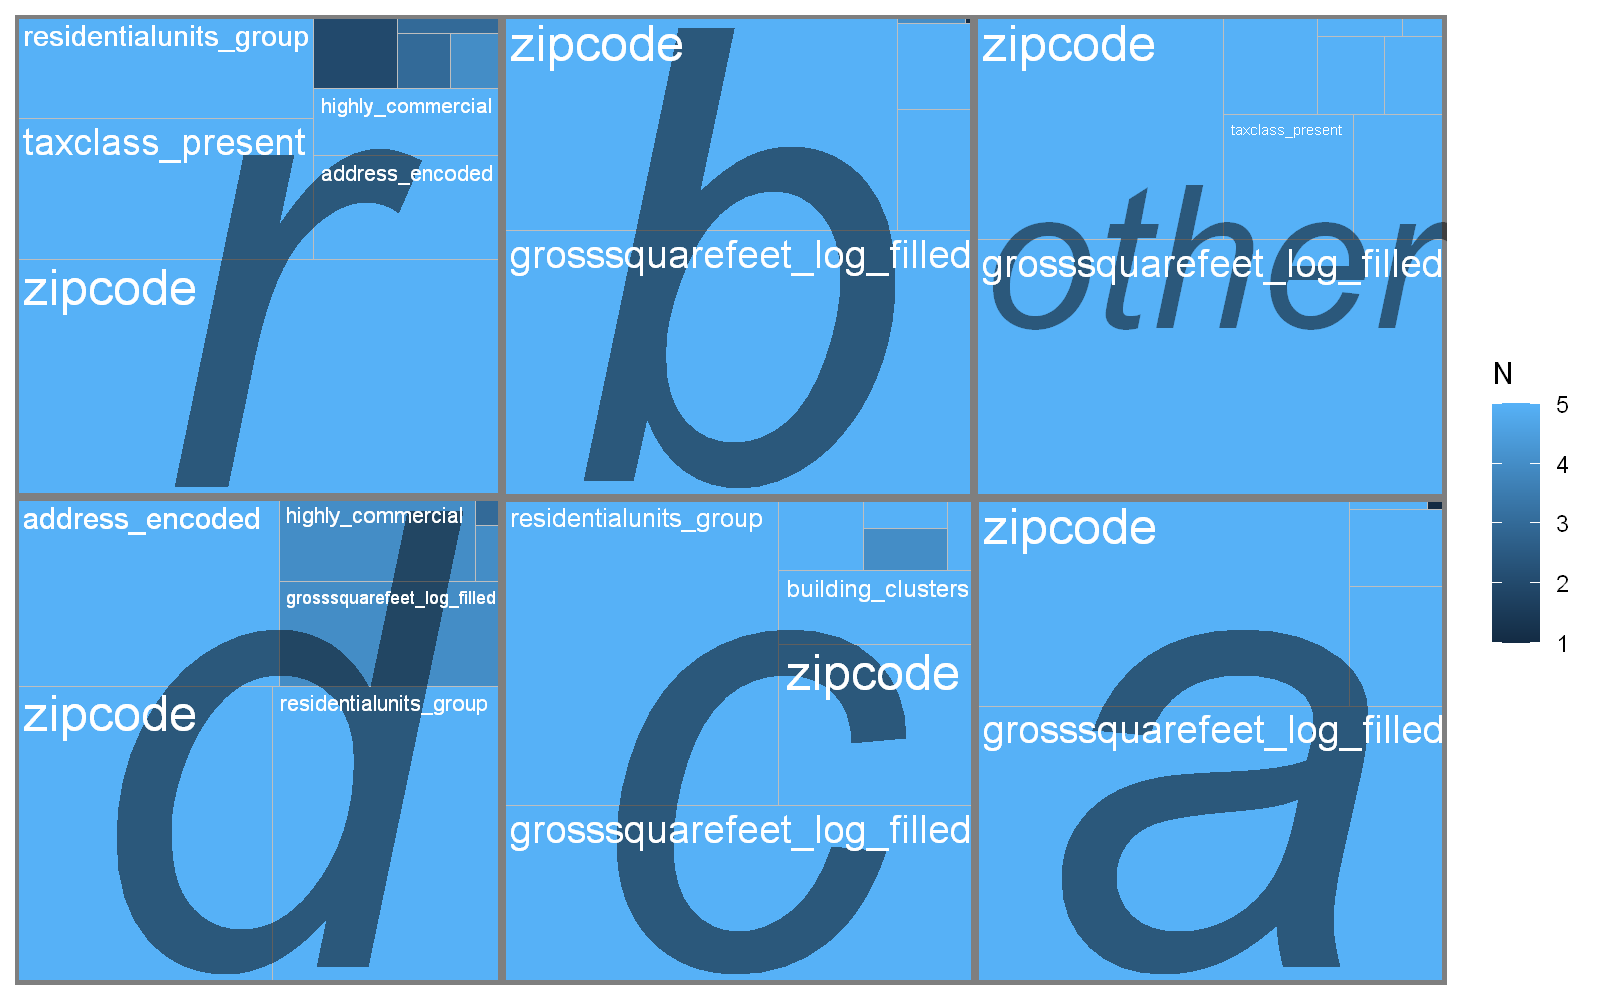

In [136]:
#imp_table_bb = imp_table_bb[order(-avg_gain)]
#imp_table_bb[, .SD[1], .(borough,b_class_group)][order(-avg_gain)]
dt_tree = imp_table_bb_wo[,.(M = mean(avg_gain, na.rm = TRUE), N = .N) ,.(b_class_group,Feature)]

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
ggplot(dt_tree
       , aes(area = M, fill = N, label = Feature,subgroup = b_class_group)) +
  geom_treemap() +
 geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", grow = T, alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 0) +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T)

### saleprice_log without zipcode

In [137]:
feature_list = c( "commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                ,"grosssquarefeet_log_filled")

train_target = "saleprice_log_wo"
test_target = "saleprice_log"

fit_bb_wo = model_xgboost_partial_wo(feature_list,train_target,test_target,chunk_no = 5)

pred_table_bb_wo = fit_bb_wo[[1]]

imp_table_bb_wo = fit_bb_wo[[2]]

print("overall test rmse:")
calc_rmse(pred_table_bb_wo$pred,pred_table_bb_wo$actual)
calc_rmse(pred_table_bb_wo[actual < 20000000]$pred,pred_table_bb_wo[actual < 20000000]$actual)


Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.552166	test-rmse:9.356132 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.722876	test-rmse:6.622382 
[3]	train-rmse:4.749852	test-rmse:4.720185 
[4]	train-rmse:3.381752	test-rmse:3.395814 
[5]	train-rmse:2.441664	test-rmse:2.496826 
[6]	train-rmse:1.807342	test-rmse:1.879660 
[7]	train-rmse:1.386907	test-rmse:1.469850 
[8]	train-rmse:1.119834	test-rmse:1.197467 
[9]	train-rmse:0.951159	test-rmse:1.040259 
[10]	train-rmse:0.851489	test-rmse:0.944681 
[11]	train-rmse:0.796225	test-rmse:0.887285 
[12]	train-rmse:0.765651	test-rmse:0.855002 
[13]	train-rmse:0.748954	test-rmse:0.832994 
[14]	train-rmse:0.738865	test-rmse:0.822012 
[15]	train-rmse:0.730175	test-rmse:0.818858 
[16]	train-rmse:0.725509	test-rmse:0.814039 
[17]	train-rmse:0.722236	test-rmse:0.811017 
[18]	train-rmse:0.717391	test-rmse:0.809390 
[19]	train-rmse:0.715096	test-rmse:0.807500 
[20]	train-rmse:0.70809

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.308808	test-rmse:9.383113 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.544896	test-rmse:6.614523 
[3]	train-rmse:4.619780	test-rmse:4.701146 
[4]	train-rmse:3.286172	test-rmse:3.376243 
[5]	train-rmse:2.371560	test-rmse:2.466408 
[6]	train-rmse:1.755249	test-rmse:1.865244 
[7]	train-rmse:1.353386	test-rmse:1.478029 
[8]	train-rmse:1.103126	test-rmse:1.233209 
[9]	train-rmse:0.955495	test-rmse:1.080280 
[10]	train-rmse:0.873833	test-rmse:0.996453 
[11]	train-rmse:0.830059	test-rmse:0.947693 
[12]	train-rmse:0.807304	test-rmse:0.922450 
[13]	train-rmse:0.795712	test-rmse:0.906488 
[14]	train-rmse:0.789243	test-rmse:0.899218 
[15]	train-rmse:0.786247	test-rmse:0.893770 
[16]	train-rmse:0.784595	test-rmse:0.890235 
[17]	train-rmse:0.783497	test-rmse:0.889535 
[18]	train-rmse:0.782865	test-rmse:0.887718 
[19]	train-rmse:0.782489	test-rmse:0.886368 
[20]	train-rmse:0.78222

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.674449	test-rmse:9.902641 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.805454	test-rmse:7.021844 
[3]	train-rmse:4.810263	test-rmse:5.016567 
[4]	train-rmse:3.430548	test-rmse:3.627504 
[5]	train-rmse:2.488140	test-rmse:2.678684 
[6]	train-rmse:1.858256	test-rmse:2.047536 
[7]	train-rmse:1.451247	test-rmse:1.635149 
[8]	train-rmse:1.201738	test-rmse:1.375239 
[9]	train-rmse:1.057748	test-rmse:1.212876 
[10]	train-rmse:0.978931	test-rmse:1.113530 
[11]	train-rmse:0.937587	test-rmse:1.053960 
[12]	train-rmse:0.916496	test-rmse:1.017289 
[13]	train-rmse:0.905871	test-rmse:0.992984 
[14]	train-rmse:0.900560	test-rmse:0.977546 
[15]	train-rmse:0.897845	test-rmse:0.968826 
[16]	train-rmse:0.896485	test-rmse:0.962047 
[17]	train-rmse:0.895762	test-rmse:0.958157 
[18]	train-rmse:0.895378	test-rmse:0.955633 
[19]	train-rmse:0.895196	test-rmse:0.953369 
[20]	train-rmse:0.89509

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.252530	test-rmse:11.562238 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.239427	test-rmse:8.371754 
[3]	train-rmse:5.133748	test-rmse:6.148461 
[4]	train-rmse:3.667107	test-rmse:4.615304 
[5]	train-rmse:2.650007	test-rmse:3.579392 
[6]	train-rmse:1.955148	test-rmse:2.865821 
[7]	train-rmse:1.474036	test-rmse:2.398241 
[8]	train-rmse:1.159802	test-rmse:2.082459 
[9]	train-rmse:0.936796	test-rmse:1.891940 
[10]	train-rmse:0.795431	test-rmse:1.753628 
[11]	train-rmse:0.704271	test-rmse:1.686116 
[12]	train-rmse:0.650744	test-rmse:1.630784 
[13]	train-rmse:0.619151	test-rmse:1.601396 
[14]	train-rmse:0.602428	test-rmse:1.583852 
[15]	train-rmse:0.580348	test-rmse:1.556586 
[16]	train-rmse:0.551703	test-rmse:1.548161 
[17]	train-rmse:0.546798	test-rmse:1.544354 
[18]	train-rmse:0.539324	test-rmse:1.535534 
[19]	train-rmse:0.536060	test-rmse:1.535850 
[20]	train-rmse:0.518

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.617598	test-rmse:10.605449 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.533655	test-rmse:7.515969 
[3]	train-rmse:5.377080	test-rmse:5.351726 
[4]	train-rmse:3.872694	test-rmse:3.920503 
[5]	train-rmse:2.838739	test-rmse:2.932069 
[6]	train-rmse:2.106102	test-rmse:2.248857 
[7]	train-rmse:1.559324	test-rmse:1.798706 
[8]	train-rmse:1.204557	test-rmse:1.516981 
[9]	train-rmse:0.927225	test-rmse:1.293522 
[10]	train-rmse:0.740821	test-rmse:1.138340 
[11]	train-rmse:0.617704	test-rmse:1.045821 
[12]	train-rmse:0.525444	test-rmse:0.980102 
[13]	train-rmse:0.443226	test-rmse:0.956574 
[14]	train-rmse:0.387649	test-rmse:0.936878 
[15]	train-rmse:0.343823	test-rmse:0.970338 
[16]	train-rmse:0.319253	test-rmse:0.958300 
[17]	train-rmse:0.297052	test-rmse:0.972906 
Stopping. Best iteration:
[14]	train-rmse:0.387649	test-rmse:0.936878

[1]	train-rmse:10.814026	test-rmse:9.228

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:10.200396	test-rmse:10.714079 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7.233291	test-rmse:7.734806 
[3]	train-rmse:5.154616	test-rmse:5.638537 
[4]	train-rmse:3.708273	test-rmse:4.166899 
[5]	train-rmse:2.707027	test-rmse:3.169872 
[6]	train-rmse:2.009138	test-rmse:2.457296 
[7]	train-rmse:1.512802	test-rmse:1.959589 
[8]	train-rmse:1.192783	test-rmse:1.619560 
[9]	train-rmse:0.990119	test-rmse:1.384874 
[10]	train-rmse:0.819867	test-rmse:1.263966 
[11]	train-rmse:0.702144	test-rmse:1.159311 
[12]	train-rmse:0.607270	test-rmse:1.094828 
[13]	train-rmse:0.557839	test-rmse:1.054695 
[14]	train-rmse:0.516943	test-rmse:1.040634 
[15]	train-rmse:0.462174	test-rmse:1.048087 
[16]	train-rmse:0.414967	test-rmse:1.046282 
[17]	train-rmse:0.398085	test-rmse:1.044443 
Stopping. Best iteration:
[14]	train-rmse:0.516943	test-rmse:1.040634

[1]	train-rmse:10.376463	test-rmse:9.621

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.005816	test-rmse:9.060042 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.329307	test-rmse:6.392803 
[3]	train-rmse:4.457426	test-rmse:4.520964 
[4]	train-rmse:3.151157	test-rmse:3.224723 
[5]	train-rmse:2.243558	test-rmse:2.328691 
[6]	train-rmse:1.617224	test-rmse:1.721520 
[7]	train-rmse:1.194513	test-rmse:1.325256 
[8]	train-rmse:0.914457	test-rmse:1.075715 
[9]	train-rmse:0.728726	test-rmse:0.916603 
[10]	train-rmse:0.610119	test-rmse:0.832409 
[11]	train-rmse:0.543852	test-rmse:0.780429 
[12]	train-rmse:0.496690	test-rmse:0.748069 
[13]	train-rmse:0.469855	test-rmse:0.732988 
[14]	train-rmse:0.443138	test-rmse:0.726540 
[15]	train-rmse:0.429914	test-rmse:0.721325 
[16]	train-rmse:0.417888	test-rmse:0.721072 
[17]	train-rmse:0.410208	test-rmse:0.719363 
[18]	train-rmse:0.399264	test-rmse:0.717019 
[19]	train-rmse:0.393779	test-rmse:0.716466 
[20]	train-rmse:0.38910

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.308707	test-rmse:7.995579 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.843086	test-rmse:5.509439 
[3]	train-rmse:4.120651	test-rmse:3.878995 
[4]	train-rmse:2.922191	test-rmse:2.754561 
[5]	train-rmse:2.092083	test-rmse:2.002943 
[6]	train-rmse:1.525307	test-rmse:1.496307 
[7]	train-rmse:1.143842	test-rmse:1.174203 
[8]	train-rmse:0.898518	test-rmse:0.998257 
[9]	train-rmse:0.744950	test-rmse:0.908237 
[10]	train-rmse:0.656204	test-rmse:0.877039 
[11]	train-rmse:0.605564	test-rmse:0.869225 
[12]	train-rmse:0.578492	test-rmse:0.871097 
[13]	train-rmse:0.564437	test-rmse:0.876734 
[14]	train-rmse:0.557169	test-rmse:0.881866 
Stopping. Best iteration:
[11]	train-rmse:0.605564	test-rmse:0.869225

[1]	train-rmse:8.242745	test-rmse:8.464622 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.166001	test-rmse:8.608320 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.748271	test-rmse:6.198362 
[3]	train-rmse:4.062243	test-rmse:4.529066 
[4]	train-rmse:2.888964	test-rmse:3.405555 
[5]	train-rmse:2.073884	test-rmse:2.545495 
[6]	train-rmse:1.512235	test-rmse:1.966244 
[7]	train-rmse:1.131895	test-rmse:1.598206 
[8]	train-rmse:0.881856	test-rmse:1.359022 
[9]	train-rmse:0.723495	test-rmse:1.194471 
[10]	train-rmse:0.628298	test-rmse:1.099915 
[11]	train-rmse:0.573717	test-rmse:1.042430 
[12]	train-rmse:0.543645	test-rmse:1.002382 
[13]	train-rmse:0.527432	test-rmse:0.978656 
[14]	train-rmse:0.518847	test-rmse:0.959933 
[15]	train-rmse:0.514286	test-rmse:0.949604 
[16]	train-rmse:0.511878	test-rmse:0.942401 
[17]	train-rmse:0.510600	test-rmse:0.937224 
[18]	train-rmse:0.509914	test-rmse:0.933092 
[19]	train-rmse:0.509539	test-rmse:0.930701 
[20]	train-rmse:0.50933

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.252199	test-rmse:9.289010 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.536190	test-rmse:6.580436 
[3]	train-rmse:4.644800	test-rmse:4.688581 
[4]	train-rmse:3.332635	test-rmse:3.416652 
[5]	train-rmse:2.435065	test-rmse:2.550634 
[6]	train-rmse:1.831626	test-rmse:1.998295 
[7]	train-rmse:1.425748	test-rmse:1.665850 
[8]	train-rmse:1.167130	test-rmse:1.470860 
[9]	train-rmse:1.009456	test-rmse:1.364891 
[10]	train-rmse:0.916961	test-rmse:1.307733 
[11]	train-rmse:0.861930	test-rmse:1.277039 
[12]	train-rmse:0.829841	test-rmse:1.264793 
[13]	train-rmse:0.810885	test-rmse:1.255990 
[14]	train-rmse:0.799564	test-rmse:1.253478 
[15]	train-rmse:0.786510	test-rmse:1.255457 
[16]	train-rmse:0.781892	test-rmse:1.254815 
[17]	train-rmse:0.769402	test-rmse:1.257042 
Stopping. Best iteration:
[14]	train-rmse:0.799564	test-rmse:1.253478

[1]	train-rmse:9.231738	test-rmse:9.435885

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.711581	test-rmse:8.363816 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.114823	test-rmse:5.782295 
[3]	train-rmse:4.301817	test-rmse:3.992208 
[4]	train-rmse:3.038244	test-rmse:2.780060 
[5]	train-rmse:2.159998	test-rmse:1.973483 
[6]	train-rmse:1.554568	test-rmse:1.468588 
[7]	train-rmse:1.141839	test-rmse:1.165022 
[8]	train-rmse:0.862465	test-rmse:1.015246 
[9]	train-rmse:0.677877	test-rmse:0.950480 
[10]	train-rmse:0.563831	test-rmse:0.928897 
[11]	train-rmse:0.493226	test-rmse:0.929525 
[12]	train-rmse:0.452953	test-rmse:0.937181 
[13]	train-rmse:0.429596	test-rmse:0.943215 
Stopping. Best iteration:
[10]	train-rmse:0.563831	test-rmse:0.928897

[1]	train-rmse:8.640803	test-rmse:8.827027 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.065664	test-rmse:6.256505 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.757943	test-rmse:8.699812 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.144021	test-rmse:6.098456 
[3]	train-rmse:4.318181	test-rmse:4.290560 
[4]	train-rmse:3.046134	test-rmse:3.043893 
[5]	train-rmse:2.164487	test-rmse:2.197340 
[6]	train-rmse:1.558953	test-rmse:1.640623 
[7]	train-rmse:1.149353	test-rmse:1.289704 
[8]	train-rmse:0.879557	test-rmse:1.081563 
[9]	train-rmse:0.706479	test-rmse:0.969921 
[10]	train-rmse:0.593346	test-rmse:0.915709 
[11]	train-rmse:0.524071	test-rmse:0.888667 
[12]	train-rmse:0.484919	test-rmse:0.879524 
[13]	train-rmse:0.465200	test-rmse:0.875791 
[14]	train-rmse:0.447886	test-rmse:0.875671 
[15]	train-rmse:0.439200	test-rmse:0.876538 
[16]	train-rmse:0.429569	test-rmse:0.879385 
[17]	train-rmse:0.421960	test-rmse:0.883003 
Stopping. Best iteration:
[14]	train-rmse:0.447886	test-rmse:0.875671

[1]	train-rmse:8.749935	test-rmse:8.755291

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.305587	test-rmse:9.400786 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.544202	test-rmse:6.640206 
[3]	train-rmse:4.620001	test-rmse:4.708942 
[4]	train-rmse:3.286138	test-rmse:3.379570 
[5]	train-rmse:2.369486	test-rmse:2.468950 
[6]	train-rmse:1.745751	test-rmse:1.868049 
[7]	train-rmse:1.335865	test-rmse:1.476749 
[8]	train-rmse:1.073154	test-rmse:1.243835 
[9]	train-rmse:0.913911	test-rmse:1.115281 
[10]	train-rmse:0.823954	test-rmse:1.039925 
[11]	train-rmse:0.770249	test-rmse:0.999084 
[12]	train-rmse:0.736583	test-rmse:0.977358 
[13]	train-rmse:0.710935	test-rmse:0.972702 
[14]	train-rmse:0.702447	test-rmse:0.969836 
[15]	train-rmse:0.696851	test-rmse:0.968553 
[16]	train-rmse:0.693685	test-rmse:0.965608 
[17]	train-rmse:0.689690	test-rmse:0.966914 
[18]	train-rmse:0.678607	test-rmse:0.969539 
[19]	train-rmse:0.673509	test-rmse:0.967548 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.677403	test-rmse:8.679509 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.096570	test-rmse:6.026643 
[3]	train-rmse:4.294943	test-rmse:4.174021 
[4]	train-rmse:3.041826	test-rmse:2.885673 
[5]	train-rmse:2.176603	test-rmse:1.998467 
[6]	train-rmse:1.586110	test-rmse:1.398579 
[7]	train-rmse:1.193103	test-rmse:1.009659 
[8]	train-rmse:0.940363	test-rmse:0.775433 
[9]	train-rmse:0.787427	test-rmse:0.657743 
[10]	train-rmse:0.698511	test-rmse:0.609206 
[11]	train-rmse:0.650057	test-rmse:0.597903 
[12]	train-rmse:0.624550	test-rmse:0.603597 
[13]	train-rmse:0.611486	test-rmse:0.612505 
[14]	train-rmse:0.604746	test-rmse:0.622147 
Stopping. Best iteration:
[11]	train-rmse:0.650057	test-rmse:0.597903

[1]	train-rmse:8.601503	test-rmse:9.119301 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.207486	test-rmse:8.991811 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.467295	test-rmse:6.253538 
[3]	train-rmse:4.556628	test-rmse:4.371399 
[4]	train-rmse:3.229757	test-rmse:3.071446 
[5]	train-rmse:2.314905	test-rmse:2.184901 
[6]	train-rmse:1.693905	test-rmse:1.597192 
[7]	train-rmse:1.282872	test-rmse:1.229009 
[8]	train-rmse:1.022167	test-rmse:1.015512 
[9]	train-rmse:0.865269	test-rmse:0.906922 
[10]	train-rmse:0.776477	test-rmse:0.858013 
[11]	train-rmse:0.728524	test-rmse:0.839494 
[12]	train-rmse:0.703660	test-rmse:0.835429 
[13]	train-rmse:0.691042	test-rmse:0.836826 
[14]	train-rmse:0.684704	test-rmse:0.840090 
[15]	train-rmse:0.681529	test-rmse:0.843703 
Stopping. Best iteration:
[12]	train-rmse:0.703660	test-rmse:0.835429

[1]	train-rmse:9.159916	test-rmse:9.277818 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train unt

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.508665	test-rmse:9.731531 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.706135	test-rmse:6.951339 
[3]	train-rmse:4.759617	test-rmse:5.013197 
[4]	train-rmse:3.413927	test-rmse:3.701121 
[5]	train-rmse:2.495826	test-rmse:2.789298 
[6]	train-rmse:1.880611	test-rmse:2.189666 
[7]	train-rmse:1.481085	test-rmse:1.805017 
[8]	train-rmse:1.226560	test-rmse:1.568385 
[9]	train-rmse:1.077420	test-rmse:1.429082 
[10]	train-rmse:0.984856	test-rmse:1.342703 
[11]	train-rmse:0.935189	test-rmse:1.291978 
[12]	train-rmse:0.902633	test-rmse:1.261104 
[13]	train-rmse:0.886718	test-rmse:1.238138 
[14]	train-rmse:0.872524	test-rmse:1.236695 
[15]	train-rmse:0.864078	test-rmse:1.229511 
[16]	train-rmse:0.851614	test-rmse:1.231070 
[17]	train-rmse:0.844923	test-rmse:1.225900 
[18]	train-rmse:0.841224	test-rmse:1.225529 
[19]	train-rmse:0.837563	test-rmse:1.232424 
[20]	train-rmse:0.83568

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.074142	test-rmse:9.167627 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.370614	test-rmse:6.469861 
[3]	train-rmse:4.483422	test-rmse:4.594169 
[4]	train-rmse:3.170002	test-rmse:3.299574 
[5]	train-rmse:2.260724	test-rmse:2.415683 
[6]	train-rmse:1.634990	test-rmse:1.811309 
[7]	train-rmse:1.212637	test-rmse:1.418665 
[8]	train-rmse:0.933383	test-rmse:1.174073 
[9]	train-rmse:0.756651	test-rmse:1.026131 
[10]	train-rmse:0.650565	test-rmse:0.941928 
[11]	train-rmse:0.587117	test-rmse:0.897072 
[12]	train-rmse:0.548309	test-rmse:0.871289 
[13]	train-rmse:0.523473	test-rmse:0.857596 
[14]	train-rmse:0.511957	test-rmse:0.851018 
[15]	train-rmse:0.506151	test-rmse:0.846908 
[16]	train-rmse:0.497885	test-rmse:0.843274 
[17]	train-rmse:0.496037	test-rmse:0.843502 
[18]	train-rmse:0.490962	test-rmse:0.844016 
[19]	train-rmse:0.490237	test-rmse:0.844633 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.115062	test-rmse:9.428317 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.403851	test-rmse:6.692894 
[3]	train-rmse:4.513468	test-rmse:4.788183 
[4]	train-rmse:3.201513	test-rmse:3.467120 
[5]	train-rmse:2.297875	test-rmse:2.545228 
[6]	train-rmse:1.683513	test-rmse:1.928571 
[7]	train-rmse:1.271901	test-rmse:1.515190 
[8]	train-rmse:1.006224	test-rmse:1.255235 
[9]	train-rmse:0.842992	test-rmse:1.094131 
[10]	train-rmse:0.749364	test-rmse:0.998002 
[11]	train-rmse:0.695483	test-rmse:0.944403 
[12]	train-rmse:0.665159	test-rmse:0.914458 
[13]	train-rmse:0.644734	test-rmse:0.898429 
[14]	train-rmse:0.636863	test-rmse:0.886571 
[15]	train-rmse:0.626368	test-rmse:0.880346 
[16]	train-rmse:0.621907	test-rmse:0.876254 
[17]	train-rmse:0.619923	test-rmse:0.873246 
[18]	train-rmse:0.618474	test-rmse:0.871559 
[19]	train-rmse:0.617409	test-rmse:0.870364 
[20]	train-rmse:0.61228

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.685628	test-rmse:9.047315 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.094935	test-rmse:6.405883 
[3]	train-rmse:4.285530	test-rmse:4.563002 
[4]	train-rmse:3.024789	test-rmse:3.281277 
[5]	train-rmse:2.148874	test-rmse:2.396989 
[6]	train-rmse:1.544719	test-rmse:1.786662 
[7]	train-rmse:1.131334	test-rmse:1.371120 
[8]	train-rmse:0.856866	test-rmse:1.097007 
[9]	train-rmse:0.679897	test-rmse:0.912159 
[10]	train-rmse:0.569484	test-rmse:0.805673 
[11]	train-rmse:0.505645	test-rmse:0.740386 
[12]	train-rmse:0.469492	test-rmse:0.691584 
[13]	train-rmse:0.449149	test-rmse:0.667494 
[14]	train-rmse:0.438557	test-rmse:0.654586 
[15]	train-rmse:0.427167	test-rmse:0.644000 
[16]	train-rmse:0.422872	test-rmse:0.637604 
[17]	train-rmse:0.418027	test-rmse:0.631062 
[18]	train-rmse:0.416465	test-rmse:0.628231 
[19]	train-rmse:0.411684	test-rmse:0.628689 
[20]	train-rmse:0.40422

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.420343	test-rmse:8.392657 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.907432	test-rmse:5.881966 
[3]	train-rmse:4.152614	test-rmse:4.127653 
[4]	train-rmse:2.929441	test-rmse:2.938648 
[5]	train-rmse:2.080979	test-rmse:2.116247 
[6]	train-rmse:1.498033	test-rmse:1.560004 
[7]	train-rmse:1.104480	test-rmse:1.183995 
[8]	train-rmse:0.846531	test-rmse:0.939114 
[9]	train-rmse:0.685228	test-rmse:0.786302 
[10]	train-rmse:0.589550	test-rmse:0.701499 
[11]	train-rmse:0.535307	test-rmse:0.652282 
[12]	train-rmse:0.506121	test-rmse:0.624383 
[13]	train-rmse:0.490935	test-rmse:0.610474 
[14]	train-rmse:0.483034	test-rmse:0.602877 
[15]	train-rmse:0.478962	test-rmse:0.598948 
[16]	train-rmse:0.476880	test-rmse:0.596276 
[17]	train-rmse:0.475876	test-rmse:0.594833 
[18]	train-rmse:0.475351	test-rmse:0.593826 
[19]	train-rmse:0.474964	test-rmse:0.593718 
[20]	train-rmse:0.47475

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.911283	test-rmse:8.804555 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.261204	test-rmse:6.162061 
[3]	train-rmse:4.412914	test-rmse:4.322649 
[4]	train-rmse:3.129190	test-rmse:3.082907 
[5]	train-rmse:2.244666	test-rmse:2.228294 
[6]	train-rmse:1.643766	test-rmse:1.657706 
[7]	train-rmse:1.246746	test-rmse:1.288564 
[8]	train-rmse:0.995102	test-rmse:1.057303 
[9]	train-rmse:0.844252	test-rmse:0.923828 
[10]	train-rmse:0.758979	test-rmse:0.849902 
[11]	train-rmse:0.712999	test-rmse:0.811804 
[12]	train-rmse:0.689168	test-rmse:0.791080 
[13]	train-rmse:0.677039	test-rmse:0.782572 
[14]	train-rmse:0.670956	test-rmse:0.777855 
[15]	train-rmse:0.667908	test-rmse:0.775728 
[16]	train-rmse:0.666392	test-rmse:0.774694 
[17]	train-rmse:0.665605	test-rmse:0.774793 
[18]	train-rmse:0.665210	test-rmse:0.774309 
[19]	train-rmse:0.665008	test-rmse:0.774244 
[20]	train-rmse:0.66489

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:9.334619	test-rmse:9.691025 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.573302	test-rmse:6.950514 
[3]	train-rmse:4.647714	test-rmse:5.017888 
[4]	train-rmse:3.310369	test-rmse:3.685518 
[5]	train-rmse:2.389721	test-rmse:2.765725 
[6]	train-rmse:1.760341	test-rmse:2.124024 
[7]	train-rmse:1.343923	test-rmse:1.696063 
[8]	train-rmse:1.077168	test-rmse:1.414372 
[9]	train-rmse:0.911895	test-rmse:1.232840 
[10]	train-rmse:0.809892	test-rmse:1.108398 
[11]	train-rmse:0.749641	test-rmse:1.027100 
[12]	train-rmse:0.714642	test-rmse:0.973292 
[13]	train-rmse:0.685916	test-rmse:0.934326 
[14]	train-rmse:0.661050	test-rmse:0.918371 
[15]	train-rmse:0.645794	test-rmse:0.906457 
[16]	train-rmse:0.639210	test-rmse:0.897512 
[17]	train-rmse:0.632286	test-rmse:0.893469 
[18]	train-rmse:0.628314	test-rmse:0.891724 
[19]	train-rmse:0.623381	test-rmse:0.890070 
[20]	train-rmse:0.62113

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.871769	test-rmse:9.049367 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.222945	test-rmse:6.392780 
[3]	train-rmse:4.372407	test-rmse:4.543027 
[4]	train-rmse:3.082842	test-rmse:3.246987 
[5]	train-rmse:2.188039	test-rmse:2.348459 
[6]	train-rmse:1.572724	test-rmse:1.728853 
[7]	train-rmse:1.156482	test-rmse:1.310050 
[8]	train-rmse:0.882606	test-rmse:1.032196 
[9]	train-rmse:0.709740	test-rmse:0.852438 
[10]	train-rmse:0.606243	test-rmse:0.740252 
[11]	train-rmse:0.547758	test-rmse:0.672580 
[12]	train-rmse:0.515439	test-rmse:0.632427 
[13]	train-rmse:0.498576	test-rmse:0.607631 
[14]	train-rmse:0.488835	test-rmse:0.592289 
[15]	train-rmse:0.482948	test-rmse:0.583087 
[16]	train-rmse:0.478321	test-rmse:0.577266 
[17]	train-rmse:0.477127	test-rmse:0.573627 
[18]	train-rmse:0.476185	test-rmse:0.571933 
[19]	train-rmse:0.475536	test-rmse:0.569880 
[20]	train-rmse:0.47396

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.977412	test-rmse:9.095025 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.297731	test-rmse:6.426375 
[3]	train-rmse:4.426542	test-rmse:4.565155 
[4]	train-rmse:3.123334	test-rmse:3.279535 
[5]	train-rmse:2.219755	test-rmse:2.407603 
[6]	train-rmse:1.599660	test-rmse:1.817239 
[7]	train-rmse:1.180725	test-rmse:1.439994 
[8]	train-rmse:0.906420	test-rmse:1.202866 
[9]	train-rmse:0.731669	test-rmse:1.065964 
[10]	train-rmse:0.627325	test-rmse:0.986660 
[11]	train-rmse:0.567608	test-rmse:0.941814 
[12]	train-rmse:0.535044	test-rmse:0.917421 
[13]	train-rmse:0.517234	test-rmse:0.902531 
[14]	train-rmse:0.506370	test-rmse:0.895619 
[15]	train-rmse:0.501051	test-rmse:0.890558 
[16]	train-rmse:0.498709	test-rmse:0.887659 
[17]	train-rmse:0.496094	test-rmse:0.886240 
[18]	train-rmse:0.494859	test-rmse:0.884845 
[19]	train-rmse:0.493485	test-rmse:0.884369 
[20]	train-rmse:0.49035

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.573519	test-rmse:8.303055 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.051747	test-rmse:5.794902 
[3]	train-rmse:4.288547	test-rmse:4.052012 
[4]	train-rmse:3.046811	test-rmse:2.856314 
[5]	train-rmse:2.178181	test-rmse:2.025220 
[6]	train-rmse:1.571218	test-rmse:1.463972 
[7]	train-rmse:1.153838	test-rmse:1.099815 
[8]	train-rmse:0.866909	test-rmse:0.903848 
[9]	train-rmse:0.672298	test-rmse:0.777684 
[10]	train-rmse:0.528035	test-rmse:0.709474 
[11]	train-rmse:0.432202	test-rmse:0.690254 
[12]	train-rmse:0.362951	test-rmse:0.683508 
[13]	train-rmse:0.320304	test-rmse:0.682542 
[14]	train-rmse:0.287393	test-rmse:0.683023 
[15]	train-rmse:0.268639	test-rmse:0.686247 
[16]	train-rmse:0.243872	test-rmse:0.686318 
Stopping. Best iteration:
[13]	train-rmse:0.320304	test-rmse:0.682542

[1]	train-rmse:8.662565	test-rmse:7.811053 
Multiple eval metrics are present. Will use

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.341174	test-rmse:8.021919 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.908005	test-rmse:5.590281 
[3]	train-rmse:4.190333	test-rmse:3.875126 
[4]	train-rmse:2.980085	test-rmse:2.669165 
[5]	train-rmse:2.130573	test-rmse:1.827211 
[6]	train-rmse:1.538592	test-rmse:1.248906 
[7]	train-rmse:1.130200	test-rmse:0.850389 
[8]	train-rmse:0.852099	test-rmse:0.621709 
[9]	train-rmse:0.660633	test-rmse:0.453550 
[10]	train-rmse:0.532564	test-rmse:0.388788 
[11]	train-rmse:0.450300	test-rmse:0.390595 
[12]	train-rmse:0.399834	test-rmse:0.419031 
[13]	train-rmse:0.370182	test-rmse:0.451829 
Stopping. Best iteration:
[10]	train-rmse:0.532564	test-rmse:0.388788

[1]	train-rmse:8.326715	test-rmse:8.156098 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.899113	test-rmse:5.725345 
[3]

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.466039	test-rmse:8.465558 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:5.938439	test-rmse:5.943923 
[3]	train-rmse:4.170215	test-rmse:4.184163 
[4]	train-rmse:2.935223	test-rmse:2.961088 
[5]	train-rmse:2.075450	test-rmse:2.117832 
[6]	train-rmse:1.479147	test-rmse:1.529664 
[7]	train-rmse:1.067783	test-rmse:1.138269 
[8]	train-rmse:0.788610	test-rmse:0.896621 
[9]	train-rmse:0.604497	test-rmse:0.758869 
[10]	train-rmse:0.488218	test-rmse:0.687078 
[11]	train-rmse:0.418250	test-rmse:0.659526 
[12]	train-rmse:0.379554	test-rmse:0.648861 
[13]	train-rmse:0.357893	test-rmse:0.648643 
[14]	train-rmse:0.346613	test-rmse:0.651781 
[15]	train-rmse:0.340812	test-rmse:0.655947 
[16]	train-rmse:0.337858	test-rmse:0.659658 
Stopping. Best iteration:
[13]	train-rmse:0.357893	test-rmse:0.648643

[1]	train-rmse:8.483954	test-rmse:8.351552 
Multiple eval metrics are present. Will use

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.860887	test-rmse:9.419149 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.250703	test-rmse:6.827483 
[3]	train-rmse:4.433660	test-rmse:5.033203 
[4]	train-rmse:3.169367	test-rmse:3.799752 
[5]	train-rmse:2.294868	test-rmse:2.941979 
[6]	train-rmse:1.698965	test-rmse:2.357342 
[7]	train-rmse:1.302652	test-rmse:1.987617 
[8]	train-rmse:1.044121	test-rmse:1.755374 
[9]	train-rmse:0.876201	test-rmse:1.597521 
[10]	train-rmse:0.769597	test-rmse:1.501276 
[11]	train-rmse:0.694936	test-rmse:1.445897 
[12]	train-rmse:0.649315	test-rmse:1.426523 
[13]	train-rmse:0.620367	test-rmse:1.406340 
[14]	train-rmse:0.598720	test-rmse:1.399132 
[15]	train-rmse:0.584096	test-rmse:1.392344 
[16]	train-rmse:0.575342	test-rmse:1.385149 
[17]	train-rmse:0.555039	test-rmse:1.383729 
[18]	train-rmse:0.551288	test-rmse:1.380048 
[19]	train-rmse:0.541712	test-rmse:1.386292 
[20]	train-rmse:0.53610

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.780199	test-rmse:8.720125 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.154999	test-rmse:6.105194 
[3]	train-rmse:4.319520	test-rmse:4.271056 
[4]	train-rmse:3.037515	test-rmse:2.993212 
[5]	train-rmse:2.144497	test-rmse:2.103827 
[6]	train-rmse:1.525852	test-rmse:1.490063 
[7]	train-rmse:1.101591	test-rmse:1.079584 
[8]	train-rmse:0.815941	test-rmse:0.806591 
[9]	train-rmse:0.629491	test-rmse:0.634687 
[10]	train-rmse:0.511265	test-rmse:0.533876 
[11]	train-rmse:0.440821	test-rmse:0.477380 
[12]	train-rmse:0.400494	test-rmse:0.449140 
[13]	train-rmse:0.378058	test-rmse:0.435773 
[14]	train-rmse:0.366403	test-rmse:0.430393 
[15]	train-rmse:0.359765	test-rmse:0.427581 
[16]	train-rmse:0.356279	test-rmse:0.427452 
[17]	train-rmse:0.353901	test-rmse:0.428259 
[18]	train-rmse:0.352319	test-rmse:0.428241 
[19]	train-rmse:0.351136	test-rmse:0.427969 
Stopping. Best iteratio

Warning message in `[.data.table`(dt_model_sub, , `:=`((incomplete_cols), NULL)):
"length(LHS)==0; no columns to delete or assign RHS to."


[1]	train-rmse:8.875637	test-rmse:8.946206 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.226021	test-rmse:6.299860 
[3]	train-rmse:4.374984	test-rmse:4.453355 
[4]	train-rmse:3.083682	test-rmse:3.170388 
[5]	train-rmse:2.184730	test-rmse:2.283771 
[6]	train-rmse:1.565196	test-rmse:1.678538 
[7]	train-rmse:1.143104	test-rmse:1.278177 
[8]	train-rmse:0.863466	test-rmse:1.020087 
[9]	train-rmse:0.682608	test-rmse:0.859915 
[10]	train-rmse:0.566762	test-rmse:0.765222 
[11]	train-rmse:0.497258	test-rmse:0.711946 
[12]	train-rmse:0.458463	test-rmse:0.684172 
[13]	train-rmse:0.435749	test-rmse:0.666368 
[14]	train-rmse:0.420187	test-rmse:0.657350 
[15]	train-rmse:0.408499	test-rmse:0.658700 
[16]	train-rmse:0.404773	test-rmse:0.655831 
[17]	train-rmse:0.400493	test-rmse:0.654012 
[18]	train-rmse:0.393103	test-rmse:0.659776 
[19]	train-rmse:0.390336	test-rmse:0.658623 
[20]	train-rmse:0.38264

[1] 12182099

[1] 1477394

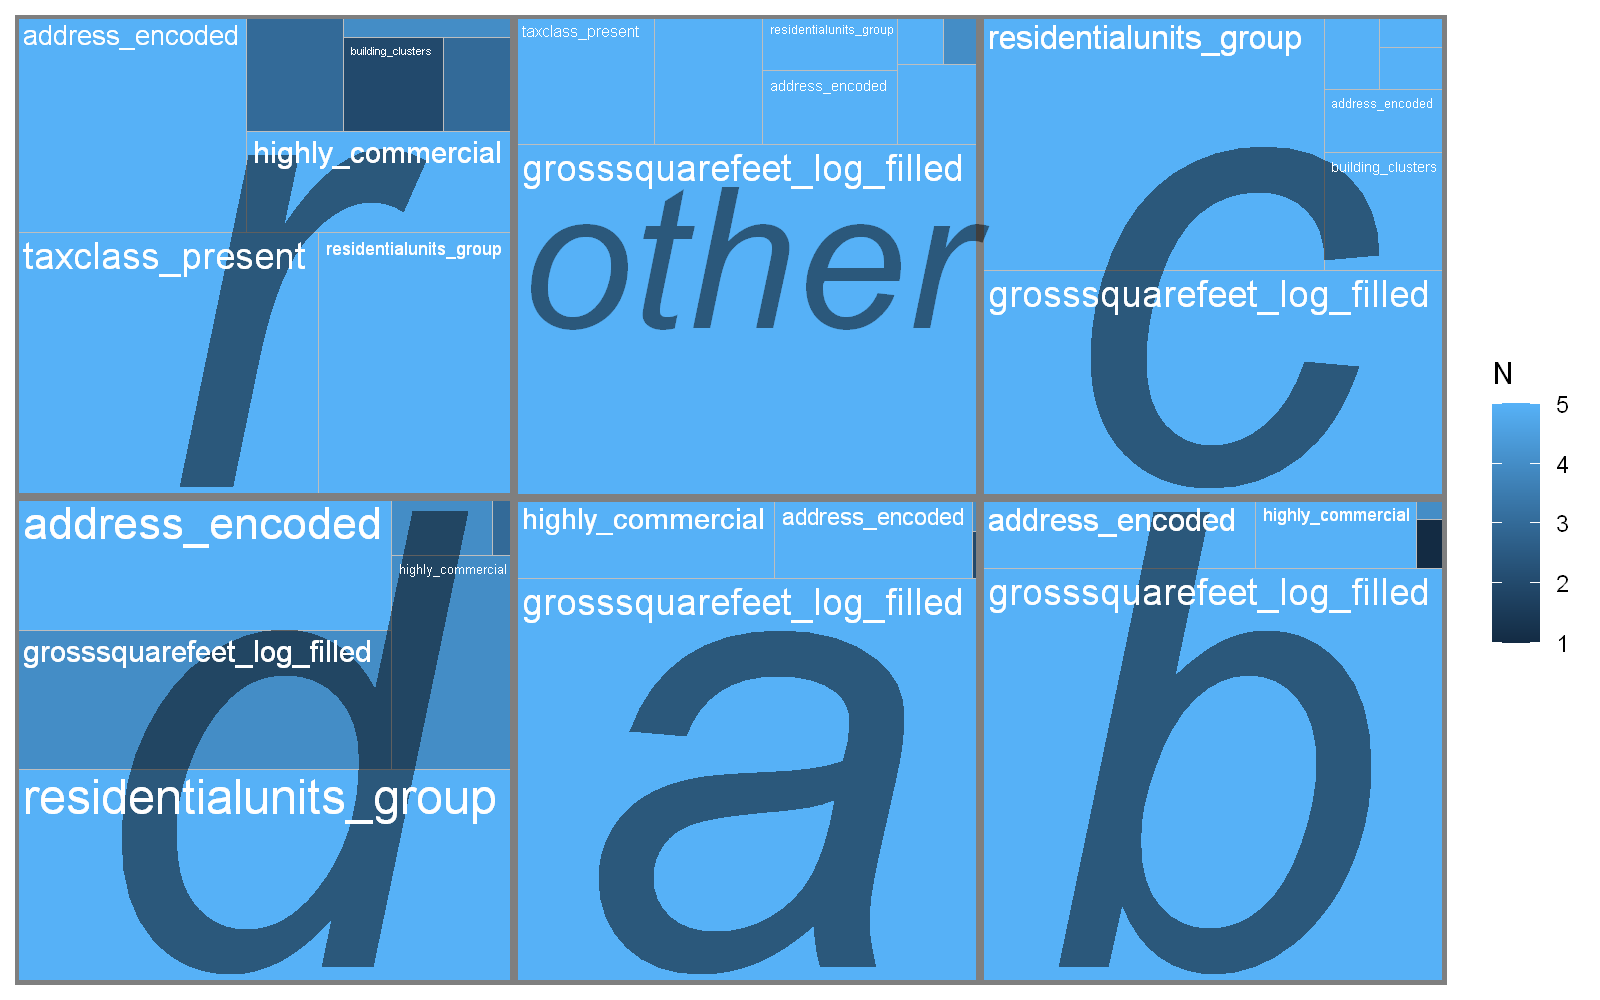

In [138]:
#imp_table_bb = imp_table_bb[order(-avg_gain)]
#imp_table_bb[, .SD[1], .(borough,b_class_group)][order(-avg_gain)]
dt_tree = imp_table_bb_wo[,.(M = mean(avg_gain, na.rm = TRUE), N = .N) ,.(b_class_group,Feature)]

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
ggplot(dt_tree
       , aes(area = M, fill = N, label = Feature,subgroup = b_class_group)) +
  geom_treemap() +
 geom_treemap_subgroup_border() +
  geom_treemap_subgroup_text(place = "centre", grow = T, alpha = 0.5, colour =
                             "black", fontface = "italic", min.size = 0) +
  geom_treemap_text(colour = "white", place = "topleft", reflow = T)

## Deep dive into 'others'

In [139]:
feature_list = c( "zipcode","commercialunits_group","residentialunits_group","highly_commercial","onlycommercial"
                 ,"address_encoded","taxclass_present","building_clusters","assessment_ratio_present"
                ,"grosssquarefeet_log_filled")

target = "saleprice_log"

dt_model = copy(dt[b_class_group =="other",.SD,.SDcols = c("idx","b_class_group",target,feature_list)])

chunk_no = 10
set.seed(0)
folds <- cut(seq(1,nrow(dt_model)),breaks=chunk_no,labels=FALSE)

pred_table = data.table()
imp_table = data.table()
fitted_table = data.table()

for(i in 1:chunk_no){
  #Segment your data by fold using the which() function 

  testIndexes <- which(folds==i,arr.ind=TRUE)
  testData    <- dt_model[testIndexes, ]
  trainData   <- dt_model[-testIndexes, ]
  
   y_train        = trainData[[target]]
   y_test         = testData[[target]]
    
    Scale_Parameters = get_scale_params(trainData, feature_list)
    x_train = scale(trainData[,.SD,.SDcols = feature_list])
    
    x_test = testData[,.SD,.SDcols = feature_list]
    scale_external(x_test,Scale_Parameters)
    
  d_train= xgb.DMatrix(data = as.matrix(x_train), label = y_train)
  d_test = xgb.DMatrix(data = as.matrix(x_test), label = y_test)
  
  set.seed(i)
  xg.model = xgb.train( data = d_train, 
                        nrounds = 20,
                        early_stopping_rounds = 3,
                        params = params, 
                        watchlist = list(train = d_train, test = d_test))
  
  if(str_detect(target,"log") == TRUE){
      xg.pred  = exp(predict(xg.model, d_test))
      actual = exp(y_test)
      
      xg.fitted = exp(predict(xg.model, d_train))
  }else{
      xg.pred  = predict(xg.model, d_test)
      actual = y_test
      
      xg.fitted = exp(predict(xg.model, d_train))
  }
    
   imp = data.table(xgb.importance( feature_names = colnames(x_train), model = xg.model))
   imp_table = rbind(imp_table,data.table(chunk = i, imp))  
    
    
  #Check performance
  sub_pred_table = testData[,.(idx, actual = actual, pred = xg.pred, chunk = i)]
  sub_fitted_table = trainData[,.(idx, fitted = xg.fitted, chunk = i )]
  
  pred_table = rbind(pred_table,sub_pred_table )
  fitted_table = rbind(fitted_table,sub_fitted_table )
 
}   


[1]	train-rmse:9.475795	test-rmse:10.592774 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.696434	test-rmse:7.674856 
[3]	train-rmse:4.770021	test-rmse:5.616743 
[4]	train-rmse:3.445459	test-rmse:4.218417 
[5]	train-rmse:2.544741	test-rmse:3.526853 
[6]	train-rmse:1.947937	test-rmse:3.124066 
[7]	train-rmse:1.558087	test-rmse:2.949484 
[8]	train-rmse:1.322696	test-rmse:2.931334 
[9]	train-rmse:1.182355	test-rmse:2.998362 
[10]	train-rmse:1.097964	test-rmse:3.025176 
[11]	train-rmse:1.046365	test-rmse:3.128329 
Stopping. Best iteration:
[8]	train-rmse:1.322696	test-rmse:2.931334

[1]	train-rmse:9.583471	test-rmse:9.526132 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:6.774062	test-rmse:6.678609 
[3]	train-rmse:4.824202	test-rmse:4.777328 
[4]	train-rmse:3.478246	test-rmse:3.482120 
[5]	t

In [140]:
pred_table = merge(pred_table, dt[,.(idx,b_class_present, taxclass_present)], by = "idx", all.x = TRUE )

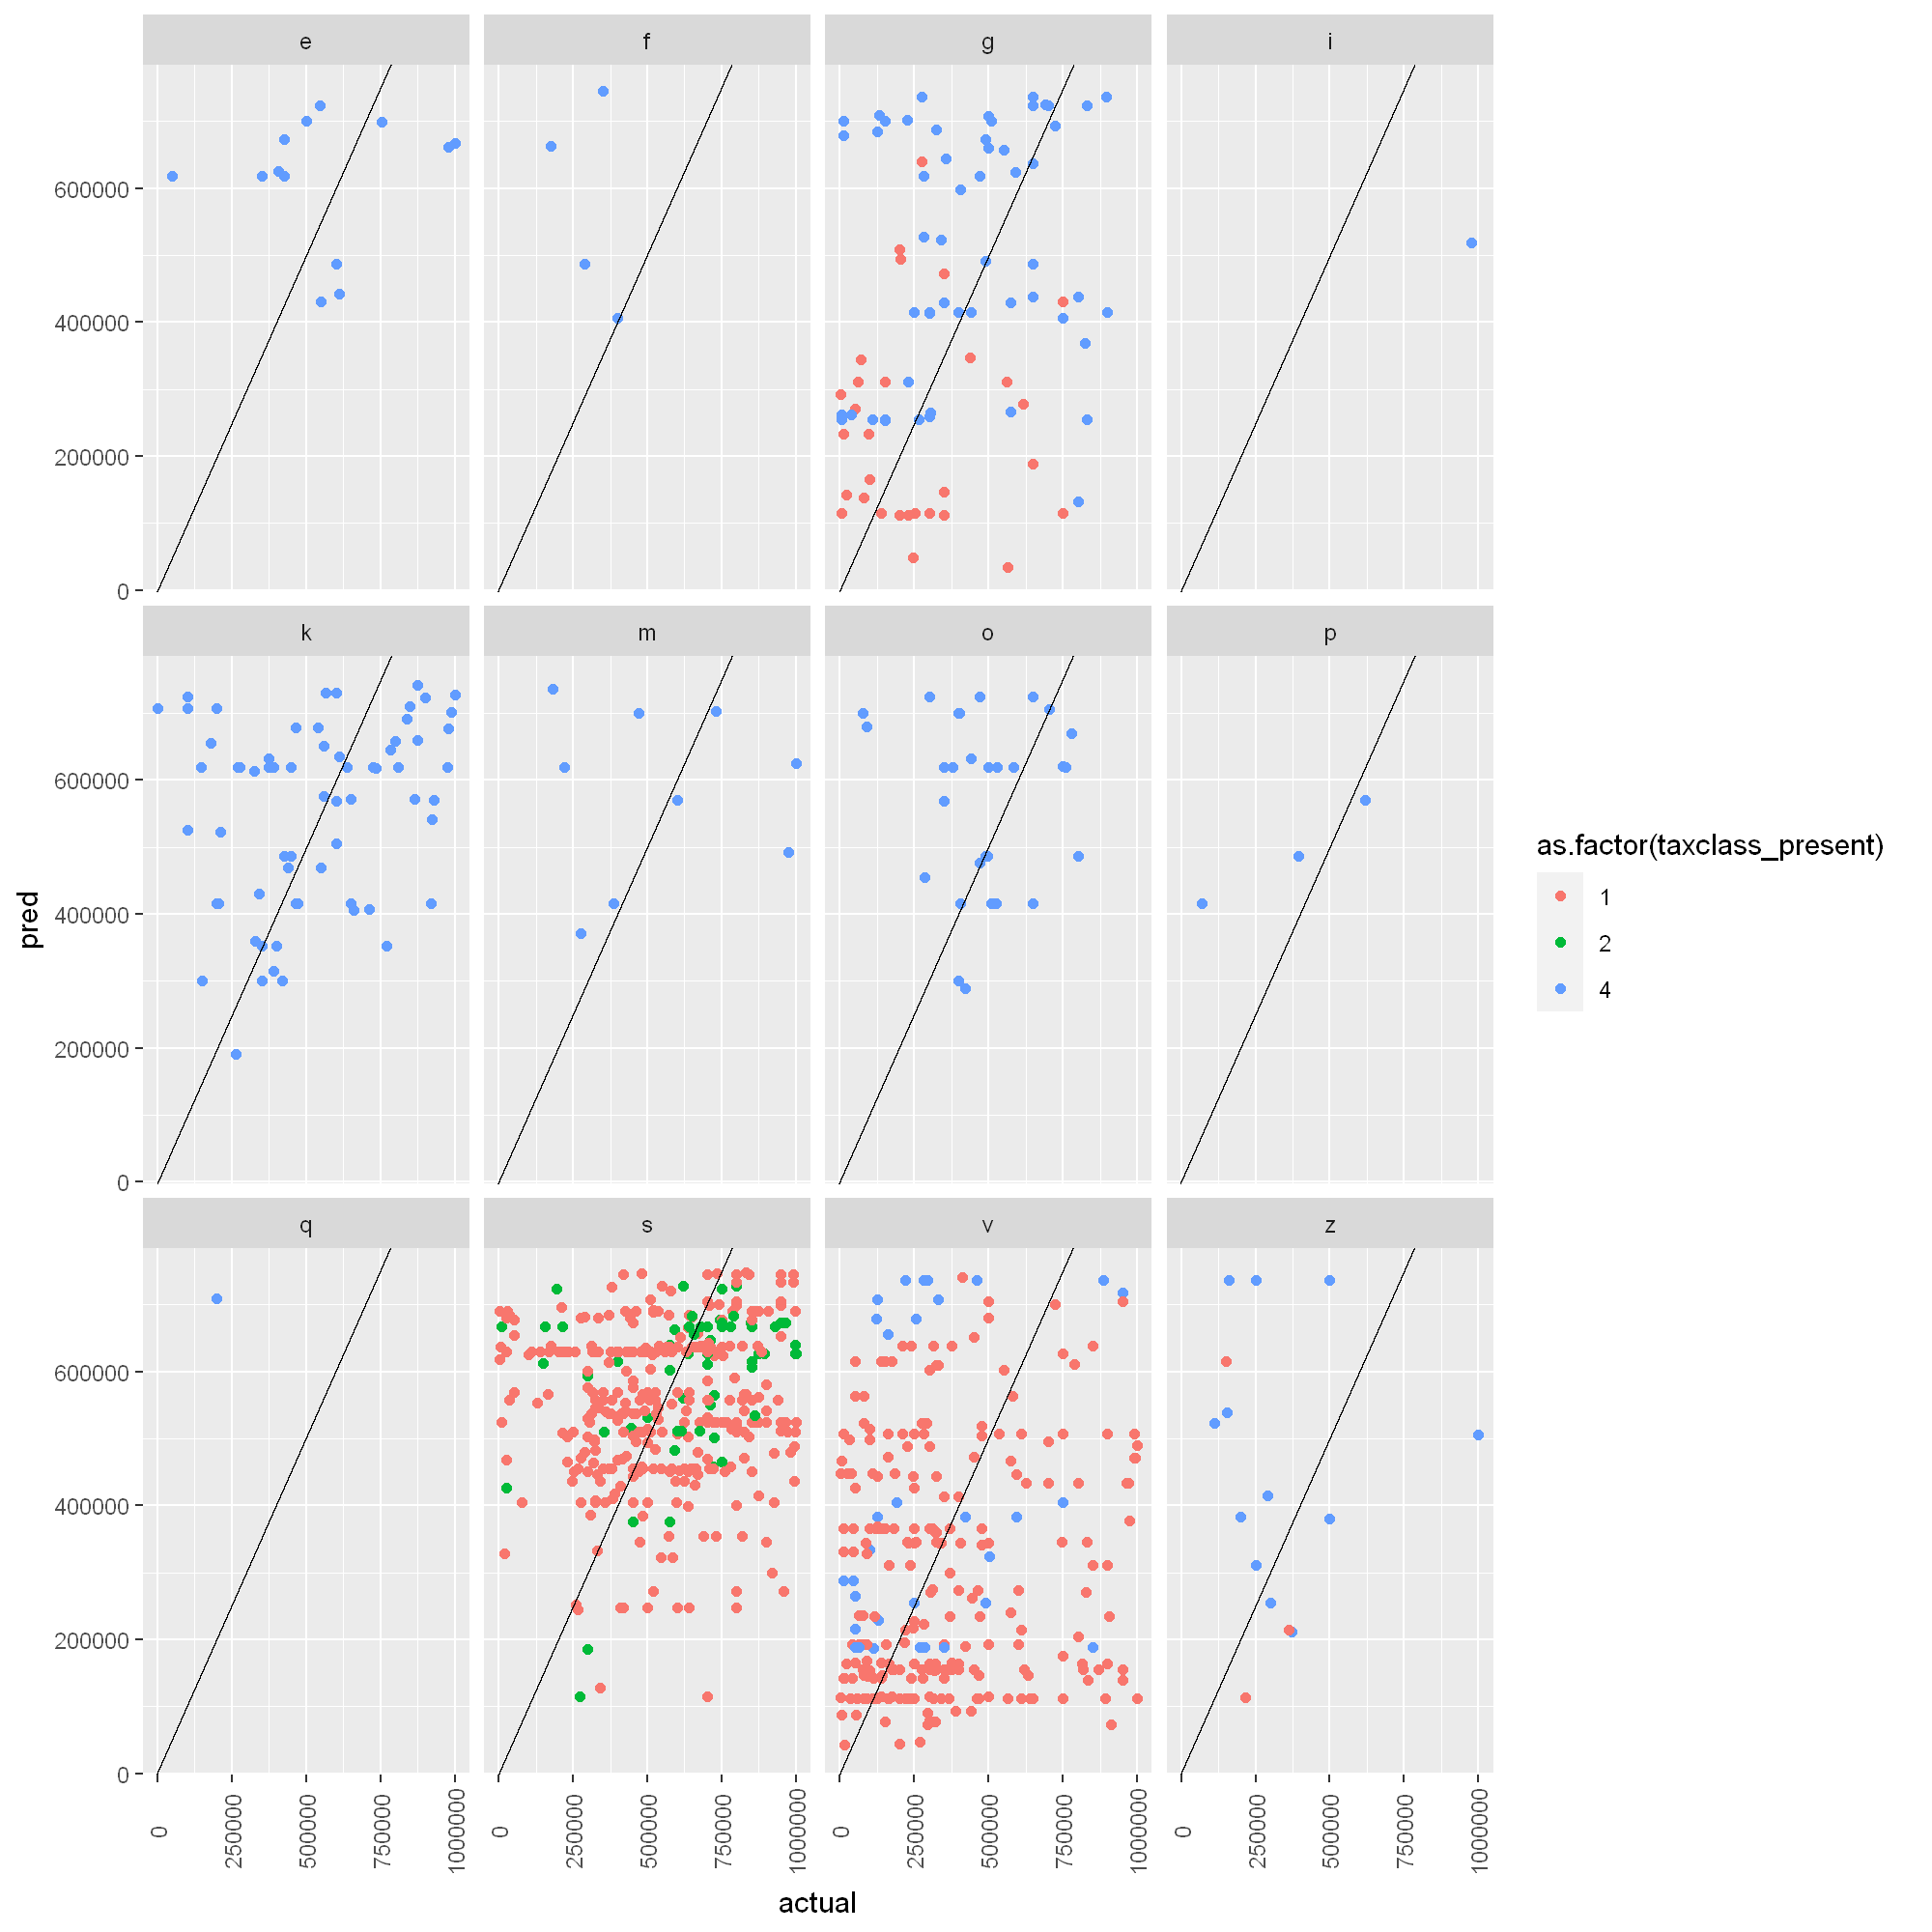

In [141]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200) # for graph sizes

ggplot(data = pred_table[actual < 1000000 & pred < 750000], aes(x = actual, y = pred, color = as.factor(taxclass_present))) + geom_point() + 
geom_abline(intercept = 0, slope = 1) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5)) +
facet_wrap(~b_class_present)


## XGBoost with TimeSeries Perspective

In [142]:
dt_ts = copy(dt)
dt_ts[, year := year(saledate)]
dt_ts[, wday := wday(saledate)]
dt_ts[, month := month(saledate)]
dt_ts[, week := week(saledate)]

month_dt= dt_ts[,.(month_avg_saleprice = mean(saleprice),
                   month_num_saleprice = .N),
                .(month,borough,b_class_group)]

month_dt = month_dt[order(month)]
month_dt[,`:=` (month_avg_saleprice  = shift(month_avg_saleprice,1,type = "lag"),
                month_num_saleprice  = shift(month_num_saleprice,1,type = "lag")),
         .(borough,b_class_group)]

week_dt= dt_ts[,.(week_avg_saleprice = mean(saleprice),
                  week_num_saleprice = .N),
               .(week,borough,b_class_group)]

week_dt = week_dt[order(week)]
week_dt[,`:=` ( week_avg_saleprice  = shift(week_avg_saleprice,1,type = "lag"),
                week_num_saleprice  = shift(week_num_saleprice,1,type = "lag")),
         .(borough,b_class_group)]

dt_ts = merge(dt_ts,month_dt, by = c("borough","b_class_group","month") )
dt_ts = merge(dt_ts,week_dt, by = c("borough","b_class_group","week") )

dt_ts = dt_ts[order(saledate)]

In [143]:
params = list(   booster = "gbtree"
                 #  , eta = best_params$eta #learning rate
                 #  , gamma = best_params$gamma # min loss reduction
                 #   , max_depth = best_params$depth
                 , min_child_weight = 1, subsample = 1, colsample_bytree= 1
                 , objective = "reg:squarederror"
                 , eval_metric = "rmse")

feature_list = c("borough","zipcode","residentialunits","commercialunits","address_encoded","b_class_present_encoded","taxclassatpresent_encoded","week_avg_saleprice","week_num_saleprice","month_avg_saleprice","month_num_saleprice")
target = "saleprice"

dt_ts_model = copy(dt_ts[,.SD,.SDcols = c("idx","month","year",target,feature_list)])

In [144]:
imp_table = data.table()
xg_preds = c()
for(i in c(1:7)){
  
    x_train_sub = dt_ts_model[(month <= i & year == 2017)| year == 2016,.SD,.SDcols = feature_list]
    Scale_Parameters = get_scale_params(x_train_sub)
    x_train_sub = scale(x_train_sub, center = TRUE, scale = TRUE)
  
    
    x_test_sub  = dt_ts_model[((month == i+1) & year == 2017) ,.SD,.SDcols = feature_list]
    scale_external(x_test_sub,Scale_Parameters)
    
    y_train_sub = dt_ts_model[(month <= i & year == 2017)| year == 2016][[target]]
    y_test_sub  = dt_ts_model[(month == 1+i) & year == 2017][[target]]
    
    d_train_sub= xgb.DMatrix(data = as.matrix(x_train_sub), label = y_train_sub)
    d_test_sub = xgb.DMatrix(data = as.matrix(x_test_sub), label = y_test_sub)
    
    set.seed(0)
    xg.model_sub = xgb.train( data = d_train_sub, 
                              nrounds = 30,
                              early_stopping_rounds = 3,
                              params = params, 
                              watchlist = list(train = d_train_sub, test = d_test_sub))
    
    imp = data.table(xgb.importance( feature_names = colnames(x_train_sub), model = xg.model_sub))
    imp_table = rbind(imp_table,data.table(month = i, imp))
    
    xg.pred_sub  = predict(xg.model_sub, d_test_sub)
    pred = xg.pred_sub
    xg_preds = c(xg_preds,pred)  
  
}

[1]	train-rmse:9704705.000000	test-rmse:3296821.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:8531835.000000	test-rmse:3199848.250000 
[3]	train-rmse:7619855.500000	test-rmse:3135980.500000 
[4]	train-rmse:6903849.500000	test-rmse:3245223.000000 
[5]	train-rmse:6360238.000000	test-rmse:3224500.000000 
[6]	train-rmse:5901778.500000	test-rmse:3338857.250000 
Stopping. Best iteration:
[3]	train-rmse:7619855.500000	test-rmse:3135980.500000

[1]	train-rmse:9033909.000000	test-rmse:5983018.500000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:7960217.000000	test-rmse:5866709.000000 
[3]	train-rmse:7116164.000000	test-rmse:5796786.500000 
[4]	train-rmse:6480772.500000	test-rmse:5768605.500000 
[5]	train-rmse:5972284.000000	test-rmse:5737396.500000 
[6]	train-rmse:5558573.500000	test-rmse:

In [145]:
imp_table_2= dcast(imp_table, Feature ~ month, value.var = "Gain")
imp_table_2[order(-`5`)]


Feature                   1               2            3           
1  zipcode                   0.3666863584091 0.3718584866 0.3898320650
2  week_num_saleprice        0.0449917220809 0.0519866526 0.0083080747
3  commercialunits           0.2526496385865 0.2327231346 0.2226555662
4  residentialunits          0.1474168886052 0.1616791410 0.1811951062
5  week_avg_saleprice        0.1237781057110 0.1078047202 0.1205063003
6  month_avg_saleprice       0.0468876410091 0.0409448106 0.0487944458
7  b_class_present_encoded   0.0142383185164 0.0227154113 0.0171771435
8  month_num_saleprice       0.0002260518082 0.0007604329 0.0022693525
9  address_encoded           0.0031243076786 0.0078576564 0.0067589415
10 borough                   0.0000009675949 0.0014255472 0.0009696438
11 taxclassatpresent_encoded              NA 0.0002440066 0.0015333607
   4           5                 6            7           
1  0.402333926 0.380012206237241 0.3916600838 0.3574691807
2  0.014392801 0.247750492517238 0.2517739687 0.2551718402
3  0.248431893 0.242729263241704 0.2364598955 0.2640867928
4  0.166163344 0.065129681937992 0.0549987363 0.0492730087
5  0.089424938 0.032146072694874 0.0306743934 0.0273158565
6  0.038808649 0.024906915765110 0.0185985441 0.0181011905
7  0.028891929 0.004677509623465 0.0039349164 0.0064462078
8  0.005244080 0.002012431498698 0.0028166909 0.0058921134
9  0.003883135 0.000635423079412 0.0017445197 0.0015336999
10 0.001240353 0.000000003404265 0.0070677899 0.0142660016
11 0.001184953                NA 0.0002704612 0.0004441078

In [146]:
print("overall test rmse:")
calc_rmse(pred_table$pred,pred_table$actual)
calc_rmse(pred_table[actual < 20000000]$pred,pred_table[actual < 20000000]$actual)

[1] "overall test rmse:"


[1] 50940985

[1] 3772929

## Final words

Best model seems to be saleprice_log with zipcode, trained without outliers.

zipcode improves the model performance.

outliers in he prediction set causes some sort of tradeoff. 

1. improve the test performance: predict outlier observations better in the expense of predicting the regular data points worse

2. improve the prediction accuracy of as many data points as possible : diverge from the outlier observations and predict regular data points better


There should be some sort of distinction between outlier and regular data points. However, I could not find it. Therefore, I could not predict them in separate models. That's why I could not escape the tradeoff I mentioned above.


### Special : Why bad Prediction?

In [147]:
pred_table_bb_wo[, error := actual - pred]

In [148]:
pred_table_bb_wo[order(-abs(error))] %>% head(10)

idx   actual     pred        chunk borough b_class_group error     
1   7448 2210000000 10793659.67 3     1       other         2199206340
2   2560 1040000000 21152639.15 1     1       other         1018847361
3   2558  652000000 21152639.15 1     1       other          630847361
4   6333  620000000   231960.07 2     1       d              619768040
5   2051  565000000 22116462.74 1     1       other          542883537
6  35390  345000000   599979.80 3     3       other          344400020
7   6318  330000000 20168480.58 3     1       other          309831519
8   9595  268124175  8806109.56 4     1       other          259318065
9  66509  257500000  3650676.64 3     4       other          253849323
10  2091  239114603    68325.75 1     1       d              239046277

In [149]:
selected_data = pred_table_bb_wo[abs(error)> (mean(error)*1.6)]
selected_data = dt[idx %in% selected_data$idx]
nrow(selected_data)

selected_list = c("saleprice_log","borough","block","lot","zipcode","residentialunits","commercialunits","yearbuilt","assessment_ratio_present","address_encoded","b_class_group_encoded","taxclassatpresent_encoded")
selected_data = selected_data[,.SD,.SDcols = selected_list]

Scale_Parameters = get_scale_params(dt, selected_list)
scale_external(selected_data,Scale_Parameters)

[1] 6648

In [150]:
set.seed(200)
clusters <- kmeans(selected_data, centers = 3, nstart= 15)

In [151]:
clusters

K-means clustering with 3 clusters of sizes 2459, 4162, 27

Cluster means:
  saleprice_log    borough      block        lot    zipcode residentialunits
1      1.424007  0.1167612 -0.4245743 -0.1073720  0.5457525        0.1819667
2      1.556850 -1.4375017 -0.8635838  0.7724970 -1.3560518        0.1457964
3      2.563738 -1.0123383 -0.4757837 -0.5399831 -0.9139562       29.5371330
  commercialunits  yearbuilt assessment_ratio_present address_encoded
1      0.09189132 -0.1453734                0.1838305      -0.1866311
2      0.03372353 -0.1339376                0.8992717      -0.2834275
3      8.80271019  0.2071931                0.9200065      -0.2165303
  b_class_group_encoded taxclassatpresent_encoded
1           0.004520012                0.02449631
2          -0.557202874               -0.80047692
3          -0.819642380               -0.77968515

Clustering vector:
   [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

All are located close by an avenue. 

All have residential and commercial units

In [152]:
table(clusters$cluster)


   1    2    3 
2459 4162   27 

In [153]:
unique(dt[,.(address, address_encoded)])

address address_encoded
1 avenue  1              
2 street  2              
3 other   3

In [154]:
table(dt$taxclassatpresent)


    1    1a    1b    1c     2    2a    2b    2c     4 
24964  1095   305   130 25675  1255   399  1543  2429 

I could not find a common property of outlier points :(

# SQL

In [155]:
#       with nys as (
#       select nyx.* 
#        ,case when SALE_PRICE = '-' or SALE PRICE IS NULL then 0 else SALE_PRICE end as SALE_PRICE_cor
#        ,COALESCE(grosssquarefeet,0) as grosssquarefeet_cor
#       from nyx_rolling_sales nyx
#       ),
#       stats as (
#       select nys.*    
#           ,avg(SALE_PRICE_cor) over() as mean
#           ,stddev(SALE_PRICE_cor) over () as sd 
#           ,avg(SALE_PRICE_cor) over(partition by NEIGHBORHOOD,BUILDING_CLASS) as mean_nb
#           ,stddev(SALE_PRICE_cor) over (partition by NEIGHBORHOOD,BUILDING_CLASS) as sd_nb
#       from nys 
#       )
#       select s.*
#           , COALESCE(TRY((s.SALE_PRICE_cor - s.mean) / s.sd),0) as sale_price_zscore -- a
#           , COALESCE(TRY((s.SALE_PRICE_cor - s.mean_nb) / s.sd_nb),0) as sale_price_zscore_neighborhood --b
#           , COALESCE(TRY(grosssquarefeet_cor/totalunits),0) as square_ft_per_unit --c
#           , COALESCE(TRY(s.SALE_PRICE_cor/totalunits),0) as price_per_unit --c
#       from stats s
#       